# Carga de información

# Carga de datos

## Config

In [274]:
periodo_de_estudio = ['2022-11-01','2022-11-15']
periodo_historico = ['2022-07-01', '2022-10-31']
periodo_comparación = ['2022-10-15', '2022-10-31']

# Mes_Estudio = 10


In [275]:
from IPython.display import Markdown as md
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
from datetime import datetime
from scipy import stats

import plotly.io as pio
pio.renderers.default = "svg"

warnings.filterwarnings('ignore')
# Read the data

data = pd.read_csv('Query_Q1_Nov.txt', sep = ';', index_col='timestamp').replace(',', '.', regex = True)

data = data[:][:-1]
data.index = pd.to_datetime(data.index)



historico_OPC = pd.read_pickle('Historico_OPC/historic_opc.pkl')
historico_OPC.columns = ['name', 'value']
historico_OPC.index = pd.to_datetime(historico_OPC.index)

historico_produccion_p2 = pd.read_pickle('Historico_OPC/p2_production_historic.pkl')
historico_produccion_p2.index = pd.to_datetime(historico_produccion_p2.index)

historico_meds = pd.read_pickle('Historico_OPC/data_electric_long_2022_11_01.pkl')
historico_meds.index = pd.to_datetime(historico_meds.index, format='%y/%m/%d %H:%M:%S').tz_convert(None)

historico_OPC = pd.concat([historico_OPC, historico_produccion_p2], axis=0)

historic_data = pd.concat([historico_meds, historico_OPC], axis=0)
historic_data.reset_index(inplace=True)

mask_historic_data = (historic_data['datetime'] > periodo_historico[0]) & (historic_data['datetime'] <= periodo_historico[1])
historic_data = historic_data.loc[mask_historic_data]

historic_data.index = historic_data['datetime']
historic_data.columns = ['datetime','NAME','variable','Active power','load','description']
historic_data['variable'].replace(np.nan,"OPC" , inplace=True)
historic_data = historic_data[historic_data['variable'].isin(['active_power', 'OPC'])]

# Cálculos de consumo

## Planta 1

In [276]:
Planta_1 = pd.DataFrame()
Planta_1_historico = pd.DataFrame()

### Bomba de Etileno (G-0259) y Compresor de Nitrógeno (K-1102)

In [277]:
planta1_14 = data[data['NAME'] == 'Planta1.14']
planta1_14_AE = planta1_14.loc[:][['Active Power']]
planta1_14_AE['Active Power'] = planta1_14_AE['Active Power'].astype(float)
planta1_14_AE_horaria = planta1_14_AE.resample('H').mean()
planta1_14_AE_horaria['Planta'] = 'Planta 1'
planta1_14_AE_horaria['S/E'] = 'Unipol I'
planta1_14_AE_horaria['Máquina'] = 'Bomba de Etileno (G-0259) y Compresor de Nitrógeno (K-1102)'
planta1_14_AE_horaria['Proceso'] = 'Almacenamiento MP & Servicios'
planta1_14_AE_diaria = planta1_14_AE_horaria.resample('D').sum()
planta1_14_AE_mes = planta1_14_AE_diaria.resample('M').sum()

Planta_1 = pd.concat([Planta_1, planta1_14_AE_horaria], axis=0)



planta1_14_historico = historic_data[historic_data['NAME'] == 'Planta1.14']
planta1_14_historico_AE = planta1_14_historico[planta1_14_historico['variable']=='active_power']
planta1_14_historico_AE.index = pd.to_datetime(planta1_14_historico_AE.index)
planta1_14_historico_AE_horaria = planta1_14_historico_AE.resample('H').mean()
planta1_14_historico_AE_horaria['Planta'] = 'Planta 1'
planta1_14_historico_AE_horaria['S/E'] = 'Unipol I'
planta1_14_historico_AE_horaria['Máquina'] = 'Bomba de Etileno (G-0259) y Compresor de Nitrógeno (K-1102)'
planta1_14_historico_AE_horaria['Proceso'] = 'Almacenamiento MP & Servicios'
planta1_14_historico_AE_diaria = planta1_14_historico_AE_horaria.resample('D').sum()
planta1_14_historico_AE_mes = planta1_14_historico_AE_diaria.resample('M').sum()

Planta_1_historico = pd.concat([Planta_1_historico, planta1_14_historico_AE_horaria], axis=0)


### Compresor Reactor 1 (K-4003)

In [278]:
planta1_K_4003 = data[['FIX.JI-40032.F_CV']].dropna()
planta1_K_4003['FIX.JI-40032.F_CV'] = planta1_K_4003['FIX.JI-40032.F_CV'].astype(float)
planta1_K_4003.columns = ['Active Power']
planta1_K_4003_horaria = planta1_K_4003.resample('H').mean()
planta1_K_4003_horaria['Planta'] = 'Planta 1'
planta1_K_4003_horaria['S/E'] = 'Unipol I'
planta1_K_4003_horaria['Máquina'] = 'Compresor Reactor 1 (K-4003)'
planta1_K_4003_horaria['Proceso'] = 'Reacción'
planta1_K_4003_diaria = planta1_K_4003_horaria.resample('D').sum()
planta1_K_4003_mes = planta1_K_4003_diaria.resample('M').sum()

Planta_1 = Planta_1.append(planta1_K_4003_horaria)

planta1_K_4003_historico = historic_data[historic_data['NAME'] == 'FIX.JI-40032.F_CV']
planta1_K_4003_historico = planta1_K_4003_historico.drop(['datetime','NAME', 'variable', 'load', 'description','datetime'], axis=1)
planta1_K_4003_historico.columns = ['Active power']
planta1_K_4003_historico_horaria = planta1_K_4003_historico.resample('H').mean()
planta1_K_4003_historico_horaria['Planta'] = 'Planta 1'
planta1_K_4003_historico_horaria['S/E'] = 'Unipol I'
planta1_K_4003_historico_horaria['Máquina'] = 'Compresor Reactor 1 (K-4003)'
planta1_K_4003_historico_horaria['Proceso'] = 'Reacción'
planta1_K_4003_historico_diaria = planta1_K_4003_historico_horaria.resample('D').sum()
planta1_K_4003_historico_mes = planta1_K_4003_historico_diaria.resample('M').sum()


Planta_1_historico = Planta_1_historico.append(planta1_K_4003_historico_horaria)


### Compresor Reactor 2 (K-4303) // PENDIENTE -- NO ESTÁ EN EL QUERY

In [279]:

# planta1_K_4303 = data[['Rx2 Compressor Power (F_CV)']].astype(float).dropna()
# planta1_K_4303.columns = ['Active Power']
# planta1_K_4303_horaria = planta1_K_4303.resample('H').mean()
# planta1_K_4303_horaria = planta1_K_4303_horaria.resample('D').sum()
# planta1_K_4303_horaria['Máquina'] = 'Compresor Reactor 1 (K-4003)'
# planta1_K_4303_horaria['Proceso'] = 'Reacción'
# planta1_K_4303_diaria['Planta'] = 'Planta 1'
# planta1_K_4303_mes = planta1_K_4303_diaria.resample('M').sum()
# planta1_K_4303_mes_operacion = planta1_K_4303_horaria[planta1_K_4303_horaria['FIX.JI-43032.F_CV']>0].count()
# print(f"El medidor Planta 1.14 correspondiente a la Bomba de Etileno (G-0259) y el Compresor de Nitrógeno (K-1102), registró un consumo total de {(planta1_K_4303_mes.values[0][0]/1000).round(2)} MWh, correspondientes a {planta1_K_4303_mes_operacion.values[0]} horas de operación.")
# planta1_K_4303_diaria.plot.bar()

# Planta_1 = Planta_1.append(planta1_K_4303_horaria)

### Bomba de propileno area 20 (G-0216) 

In [280]:
planta1_G_0216 = data[data['NAME'] == 'Planta1.15']
planta1_G_0216 = planta1_G_0216.loc[:][['Active Power']].astype(float).dropna()
planta1_G_0216_horaria = planta1_G_0216.resample('H').mean()
planta1_G_0216_horaria['Planta'] = 'Planta 1'
planta1_G_0216_horaria['S/E'] = 'Unipol I'
planta1_G_0216_horaria['Máquina'] = 'Bomba de propileno area 20 (G-0216)'
planta1_G_0216_horaria['Proceso'] = 'Almacenamiento MP'
planta1_G_0216_diaria = planta1_G_0216_horaria.resample('D').sum()
planta1_G_0216_mes = planta1_G_0216_diaria.resample('M').sum()

Planta_1 = Planta_1.append(planta1_G_0216_horaria)


planta1_G_0216_historico = historic_data[historic_data['NAME'] == 'Planta1.15']
planta1_G_0216_historico_AE = planta1_G_0216_historico[planta1_G_0216_historico['variable']=='active_power']
planta1_G_0216_historico_AE.index = pd.to_datetime(planta1_G_0216_historico_AE.index)
planta1_G_0216_historico_AE_horaria = planta1_G_0216_historico.resample('H').mean()
planta1_G_0216_historico_AE_horaria['Planta'] = 'Planta 1'
planta1_G_0216_historico_AE_horaria['S/E'] = 'Unipol I'
planta1_G_0216_historico_AE_horaria['Máquina'] = 'Bomba de propileno area 20 (G-0216)'
planta1_G_0216_historico_AE_horaria['Proceso'] = 'Almacenamiento MP'
planta1_G_0216_historico_AE_diaria = planta1_G_0216_historico_AE_horaria.resample('D').sum()
planta1_G_0216_historico_AE_mes = planta1_G_0216_historico_AE_diaria.resample('M').sum()

Planta_1_historico = Planta_1_historico.append(planta1_G_0216_historico_AE_horaria)



### Bomba de propileno (G-0226) 

In [281]:
planta1_G_0226 = data[data['NAME'] == 'Planta1.16']
planta1_G_0226 = planta1_G_0226.loc[:][['Active Power']].astype(float).dropna()
planta1_G_0226_horaria = planta1_G_0226.resample('H').mean()
planta1_G_0226_horaria['Planta'] = 'Planta 1'
planta1_G_0226_horaria['S/E'] = 'Unipol I'
planta1_G_0226_horaria['Máquina'] = 'Bomba de propileno (G-0226)'
planta1_G_0226_horaria['Proceso'] = 'Almacenamiento MP'
planta1_G_0226_diaria = planta1_G_0226_horaria.resample('D').sum()
planta1_G_0226_mes = planta1_G_0226_diaria.resample('M').sum()


Planta_1 = Planta_1.append(planta1_G_0226_horaria)



planta1_G_0226_historico = historic_data[historic_data['NAME'] == 'Planta1.16']
planta1_G_0226_historico_AE = planta1_G_0226_historico[planta1_G_0226_historico['variable']=='active_power']
planta1_G_0226_historico_AE.index = pd.to_datetime(planta1_G_0226_historico_AE.index)
planta1_G_0226_historico_AE_horaria = planta1_G_0226_historico.resample('H').mean()
planta1_G_0226_historico_AE_horaria['Planta'] = 'Planta 1'
planta1_G_0226_historico_AE_horaria['S/E'] = 'Unipol I'
planta1_G_0226_historico_AE_horaria['Máquina'] = 'Bomba de propileno (G-0226)'
planta1_G_0226_historico_AE_horaria['Proceso'] = 'Almacenamiento MP'
planta1_G_0226_historico_AE_diaria = planta1_G_0226_historico_AE_horaria.resample('D').sum()
planta1_G_0226_historico_AE_mes = planta1_G_0226_historico_AE_diaria.resample('M').sum()

Planta_1_historico = Planta_1_historico.append(planta1_G_0226_historico_AE_horaria)

### Bomba calentador propileno (G-0231) 

In [282]:

planta1_G_0231 = data[data['NAME'] == 'Planta1.17']
planta1_G_0231 = planta1_G_0231.loc[:][['Active Power']].astype(float).dropna()
planta1_G_0231_horaria = planta1_G_0231.resample('H').mean()
planta1_G_0231_horaria['Planta'] = 'Planta 1'
planta1_G_0231_horaria['S/E'] = 'Unipol I'
planta1_G_0231_horaria['Máquina'] = 'Bomba calentador propileno (G-0231)'
planta1_G_0231_horaria['Proceso'] = 'Servicios'
planta1_G_0231_diaria = planta1_G_0231_horaria.resample('D').sum()
planta1_G_0231_mes = planta1_G_0231_diaria.resample('M').sum()

Planta_1 = Planta_1.append(planta1_G_0231_horaria)


planta1_G_0231_historico = historic_data[historic_data['NAME'] == 'Planta1.17']
planta1_G_0231_historico_AE = planta1_G_0231_historico[planta1_G_0231_historico['variable']=='active_power']
planta1_G_0231_historico_AE.index = pd.to_datetime(planta1_G_0231_historico_AE.index)
planta1_G_0231_historico_AE_horaria = planta1_G_0231_historico.resample('H').mean()
planta1_G_0231_historico_AE_horaria['Planta'] = 'Planta 1'
planta1_G_0231_historico_AE_horaria['S/E'] = 'Unipol I'
planta1_G_0231_historico_AE_horaria['Máquina'] = 'Bomba calentador propileno (G-0231)'
planta1_G_0231_historico_AE_horaria['Proceso'] = 'Servicios'
planta1_G_0231_historico_AE_diaria = planta1_G_0231_historico_AE_horaria.resample('D').sum()
planta1_G_0231_historico_AE_mes = planta1_G_0231_historico_AE_diaria.resample('M').sum()

Planta_1_historico = Planta_1_historico.append(planta1_G_0231_historico_AE_horaria)


### Bomba calentador propileno (G-0230) & bomba calentador propileno (G-0232) 

In [283]:
planta1_G_0230 = data[data['NAME'] == 'Planta1.18']
planta1_G_0230 = planta1_G_0230.loc[:][['Active Power']].astype(float).dropna()
planta1_G_0230_horaria = planta1_G_0230.resample('H').mean()
planta1_G_0230_horaria['Planta'] = 'Planta 1'
planta1_G_0230_horaria['S/E'] = 'Unipol I'
planta1_G_0230_horaria['Máquina'] = 'Bomba calentador propileno (G-0230) & bomba calentador propileno (G-0232)'
planta1_G_0230_horaria['Proceso'] = 'Servicios'
planta1_G_0230_diaria = planta1_G_0230_horaria.resample('D').sum()
planta1_G_0230_mes = planta1_G_0230_diaria.resample('M').sum()


Planta_1 = Planta_1.append(planta1_G_0230_horaria)


planta1_G_0230_historico = historic_data[historic_data['NAME'] == 'Planta1.18']
planta1_G_0230_historico_AE = planta1_G_0230_historico[planta1_G_0230_historico['variable']=='active_power']
planta1_G_0230_historico_AE.index = pd.to_datetime(planta1_G_0230_historico_AE.index)
planta1_G_0230_historico_AE_horaria = planta1_G_0230_historico.resample('H').mean()
planta1_G_0230_historico_AE_horaria['Planta'] = 'Planta 1'
planta1_G_0230_historico_AE_horaria['S/E'] = 'Unipol I'
planta1_G_0230_historico_AE_horaria['Máquina'] = 'Bomba calentador propileno (G-0230) & bomba calentador propileno (G-0232)'
planta1_G_0230_historico_AE_horaria['Proceso'] = 'Servicios'
planta1_G_0230_historico_AE_diaria = planta1_G_0230_historico_AE_horaria.resample('D').sum()
planta1_G_0230_historico_AE_mes = planta1_G_0230_historico_AE_diaria.resample('M').sum()

Planta_1_historico = Planta_1_historico.append(planta1_G_0230_historico_AE_horaria)

### Bomba de Cargue de Propileno (G-2013) & Bomba de Circulación de Agua del E-4002 (G-4004) 

In [284]:
planta1_G_2013 = data[data['NAME'] == 'Planta1.31']
planta1_G_2013 = planta1_G_2013.loc[:][['Active Power']].astype(float).dropna()
planta1_G_2013_horaria = planta1_G_2013.resample('H').mean()
planta1_G_2013_horaria['Planta'] = 'Planta 1'
planta1_G_2013_horaria['S/E'] = 'Unipol I'
planta1_G_2013_horaria['Máquina'] = 'Bomba de Cargue de Propileno (G-2013) & Bomba de Circulación de Agua del E-4002 (G-4004)'
planta1_G_2013_horaria['Proceso'] = 'Reacción' 
planta1_G_2013_diaria = planta1_G_2013_horaria.resample('D').sum()
planta1_G_2013_mes = planta1_G_2013_diaria.resample('M').sum()


Planta_1 = Planta_1.append(planta1_G_2013_horaria)

planta1_G_2013_historico = historic_data[historic_data['NAME'] == 'Planta1.31']
planta1_G_2013_historico_AE = planta1_G_2013_historico[planta1_G_2013_historico['variable']=='active_power']
planta1_G_2013_historico_AE.index = pd.to_datetime(planta1_G_2013_historico_AE.index)
planta1_G_2013_historico_AE_horaria = planta1_G_2013_historico.resample('H').mean()
planta1_G_2013_historico_AE_horaria['Planta'] = 'Planta 1'
planta1_G_2013_historico_AE_horaria['S/E'] = 'Unipol I'
planta1_G_2013_historico_AE_horaria['Máquina'] = 'Bomba de Cargue de Propileno (G-2013) & Bomba de Circulación de Agua del E-4002 (G-4004)'
planta1_G_2013_historico_AE_horaria['Proceso'] = 'Reacción' 
planta1_G_2013_historico_AE_diaria = planta1_G_2013_historico_AE_horaria.resample('D').sum()
planta1_G_2013_historico_AE_mes = planta1_G_2013_historico_AE_diaria.resample('M').sum()

Planta_1_historico = Planta_1_historico.append(planta1_G_2013_historico_AE_horaria)

### Bomba booster de propileno (G-2011)

In [285]:
planta1_G_2011 = data[data['NAME'] == 'Planta1.35']
planta1_G_2011 = planta1_G_2011.loc[:][['Active Power']].astype(float).dropna()
planta1_G_2011_horaria = planta1_G_2011.resample('H').mean()
planta1_G_2011_horaria['Planta'] = 'Planta 1'
planta1_G_2011_horaria['S/E'] = 'Unipol I'
planta1_G_2011_horaria['Máquina'] = 'Bomba de Cargue de Propileno (G-2011)'
planta1_G_2011_horaria['Proceso'] = 'Reacción'
planta1_G_2011_diaria = planta1_G_2011_horaria.resample('D').sum()
planta1_G_2011_mes = planta1_G_2011_diaria.resample('M').sum()

Planta_1 = Planta_1.append(planta1_G_2011_horaria)



planta1_G_2011_historico = historic_data[historic_data['NAME'] == 'Planta1.35']
planta1_G_2011_historico_AE = planta1_G_2011_historico[planta1_G_2011_historico['variable']=='active_power']
planta1_G_2011_historico_AE.index = pd.to_datetime(planta1_G_2011_historico_AE.index)
planta1_G_2011_historico_AE_horaria = planta1_G_2011_historico.resample('H').mean()
planta1_G_2011_historico_AE_horaria['Planta'] = 'Planta 1'
planta1_G_2011_historico_AE_horaria['S/E'] = 'Unipol I'
planta1_G_2011_historico_AE_horaria['Máquina'] = 'Bomba de Cargue de Propileno (G-2011)'
planta1_G_2011_historico_AE_horaria['Proceso'] = 'Reacción' 
planta1_G_2011_historico_AE_diaria = planta1_G_2011_historico_AE_horaria.resample('D').sum()
planta1_G_2011_historico_AE_mes = planta1_G_2011_historico_AE_diaria.resample('M').sum()

Planta_1_historico = Planta_1_historico.append(planta1_G_2011_historico_AE_horaria)

### Bomba booster de propileno (G-2012)

In [286]:
planta1_G_2012 = data[data['NAME'] == 'Planta1.G2012']
planta1_G_2012 = planta1_G_2012.loc[:][['Active Energy Delivered']].astype(float).dropna()
planta1_G_2012['Active Energy Delivered'] = planta1_G_2012.diff()
planta1_G_2012.columns = ['Active Power']
planta1_G_2012_horaria = planta1_G_2012.resample('H').sum()
planta1_G_2012_horaria['Planta'] = 'Planta 1'
planta1_G_2012_horaria['S/E'] = 'Unipol I'
planta1_G_2012_horaria['Máquina'] = 'Bomba booster de propileno (G-2012)'
planta1_G_2012_horaria['Proceso'] = 'Reacción'
planta1_G_2012_diaria = planta1_G_2012.resample('D').sum()
planta1_G_2012_mes = planta1_G_2012.resample('M').sum()


Planta_1 = Planta_1.append(planta1_G_2012_horaria)


planta1_G_2012_historico = historic_data[historic_data['NAME'] == 'Planta1.G2012']
planta1_G_2012_historico_AE = planta1_G_2012_historico[planta1_G_2012_historico['variable']=='active_power']
planta1_G_2012_historico_AE.index = pd.to_datetime(planta1_G_2012_historico_AE.index)
planta1_G_2012_historico_AE_horaria = planta1_G_2012_historico.resample('H').mean()
planta1_G_2012_historico_AE_horaria['Planta'] = 'Planta 1'
planta1_G_2012_historico_AE_horaria['S/E'] = 'Unipol I'
planta1_G_2012_historico_AE_horaria['Máquina'] = 'Bomba booster de propileno (G-2012)'
planta1_G_2012_historico_AE_horaria['Proceso'] = 'Reacción' 
planta1_G_2012_historico_AE_diaria = planta1_G_2012_historico_AE_horaria.resample('D').sum()
planta1_G_2012_historico_AE_mes = planta1_G_2012_historico_AE_diaria.resample('M').sum()

Planta_1_historico = Planta_1_historico.append(planta1_G_2012_historico_AE_horaria)

### Bomba de Circulación de Agua de Torre 2 (G-0402)

In [287]:
planta1_G_0402 = data[data['NAME'] == 'Planta1.30']
planta1_G_0402 = planta1_G_0402.loc[:][['Active Power']].astype(float).dropna()
planta1_G_0402_horaria = planta1_G_0402.resample('H').mean()
planta1_G_0402_horaria['Planta'] = 'Planta 1'
planta1_G_0402_horaria['S/E'] = 'Unipol I'
planta1_G_0402_horaria['Máquina'] = 'Bomba de Circulación de Agua de Torre 2 (G-0402)'
planta1_G_0402_horaria['Proceso'] = 'Servicios'
planta1_G_0402_diaria = planta1_G_0402_horaria.resample('D').sum()
planta1_G_0402_mes = planta1_G_0402_diaria.resample('M').sum()

Planta_1 = Planta_1.append(planta1_G_0402_horaria)

planta1_G_0402_historico = historic_data[historic_data['NAME'] == 'Planta1.30']
planta1_G_0402_historico_AE = planta1_G_0402_historico[planta1_G_0402_historico['variable']=='active_power']
planta1_G_0402_historico_AE.index = pd.to_datetime(planta1_G_0402_historico_AE.index)
planta1_G_0402_historico_AE_horaria = planta1_G_0402_historico.resample('H').mean()
planta1_G_0402_historico_AE_horaria['Planta'] = 'Planta 1'
planta1_G_0402_historico_AE_horaria['S/E'] = 'Unipol I'
planta1_G_0402_historico_AE_horaria['Máquina'] = 'Bomba de Circulación de Agua de Torre 2 (G-0402)'
planta1_G_0402_historico_AE_horaria['Proceso'] = 'Servicios'
planta1_G_0402_historico_AE_diaria = planta1_G_0402_historico_AE_horaria.resample('D').sum()
planta1_G_0402_historico_AE_mes = planta1_G_0402_historico_AE_diaria.resample('M').sum()

Planta_1_historico = Planta_1_historico.append(planta1_G_0402_historico_AE_horaria)

### Bomba de Circulación de Agua de Torre 4 (G-0404)

In [288]:
planta1_G_0404 = data[data['NAME'] == 'Planta1.G0404']
planta1_G_0404 = planta1_G_0404.loc[:][['Active Energy Delivered']].astype(float).dropna()
planta1_G_0404['Active Energy Delivered'] = planta1_G_0404.diff()
planta1_G_0404.columns = ['Active Power']
planta1_G_0404_horaria = planta1_G_0404.resample('H').sum()
planta1_G_0404_horaria['Planta'] = 'Planta 1'
planta1_G_0404_horaria['S/E'] = 'Unipol I'
planta1_G_0404_horaria['Máquina'] = 'Bomba de Circulación de Agua de Torre 4 (G-0404)'
planta1_G_0404_horaria['Proceso'] = 'Servicios'
planta1_G_0404_diaria = planta1_G_0404.resample('D').sum()
planta1_G_0404_mes = planta1_G_0404.resample('M').sum()

Planta_1 = Planta_1.append(planta1_G_0404_horaria)


planta1_G_0404_historico = historic_data[historic_data['NAME'] == 'Planta1.G0404']
planta1_G_0404_historico_AE = planta1_G_0404_historico[planta1_G_0404_historico['variable']=='active_power']
planta1_G_0404_historico_AE.index = pd.to_datetime(planta1_G_0404_historico_AE.index)
planta1_G_0404_historico_AE_horaria = planta1_G_0404_historico.resample('H').mean()
planta1_G_0404_historico_AE_horaria['Planta'] = 'Planta 1'
planta1_G_0404_historico_AE_horaria['S/E'] = 'Unipol I'
planta1_G_0404_historico_AE_horaria['Máquina'] = 'Bomba de Circulación de Agua de Torre 4 (G-0404)'
planta1_G_0404_historico_AE_horaria['Proceso'] = 'Servicios'
planta1_G_0404_historico_AE_diaria = planta1_G_0404_historico_AE_horaria.resample('D').sum()
planta1_G_0404_historico_AE_mes = planta1_G_0404_historico_AE_diaria.resample('M').sum()

Planta_1_historico = Planta_1_historico.append(planta1_G_0404_historico_AE_horaria)

### Bomba de Circulación de Agua de Torre N°5 (G-0405)

In [289]:
planta1_G_0405 = data[data['NAME'] == 'Planta1.5']
planta1_G_0405 = planta1_G_0405.loc[:][['Active Energy Delivered']].astype(float).dropna()
planta1_G_0405['Active Energy Delivered'] = planta1_G_0405.diff()
planta1_G_0405.columns = ['Active Power']
planta1_G_0405_horaria = planta1_G_0405.resample('H').sum()
planta1_G_0405_horaria['Planta'] = 'Planta 1'
planta1_G_0405_horaria['S/E'] = 'Unipol II'
planta1_G_0405_horaria['Máquina'] = 'Bomba de Circulación de Agua de Torre N°5 (G-0405)'
planta1_G_0405_horaria['Proceso'] = 'Servicios'
planta1_G_0405_diaria = planta1_G_0405.resample('D').sum()
planta1_G_0405_mes = planta1_G_0405.resample('M').sum()

Planta_1 = Planta_1.append(planta1_G_0405_horaria)


planta1_G_0405_historico = historic_data[historic_data['NAME'] == 'Planta1.5']
planta1_G_0405_historico_AE = planta1_G_0405_historico[planta1_G_0405_historico['variable']=='active_power']
planta1_G_0405_historico_AE.index = pd.to_datetime(planta1_G_0405_historico_AE.index)
planta1_G_0405_historico_AE_horaria = planta1_G_0405_historico.resample('H').mean()
planta1_G_0405_historico_AE_horaria['Planta'] = 'Planta 1'
planta1_G_0405_historico_AE_horaria['S/E'] = 'Unipol I'
planta1_G_0405_historico_AE_horaria['Máquina'] = 'Bomba de Circulación de Agua de Torre N°5 (G-0405)'
planta1_G_0405_historico_AE_horaria['Proceso'] = 'Servicios'
planta1_G_0405_historico_AE_diaria = planta1_G_0405_historico_AE_horaria.resample('D').sum()
planta1_G_0405_historico_AE_mes = planta1_G_0405_historico_AE_diaria.resample('M').sum()

Planta_1_historico = Planta_1_historico.append(planta1_G_0405_historico_AE_horaria)

### Bombas de Agua Tratada (G-0446) y (G-0447)

In [290]:
planta1_G_0446 = data[data['NAME'] == 'Planta1.32']
planta1_G_0446 = planta1_G_0446.loc[:][['Active Energy Delivered']].astype(float).dropna()
planta1_G_0446['Active Energy Delivered'] = planta1_G_0446.diff()
planta1_G_0446.columns = ['Active Power']
planta1_G_0446_horaria = planta1_G_0446.resample('H').sum()
planta1_G_0446_horaria['Planta'] = 'Planta 1'
planta1_G_0446_horaria['S/E'] = 'Unipol I'
planta1_G_0446_horaria['Máquina'] = 'Bombas de Agua Tratada (G-0446) y (G-0447)'
planta1_G_0446_horaria['Proceso'] = 'Servicios'
planta1_G_0446_diaria = planta1_G_0446.resample('D').sum()
planta1_G_0446_mes = planta1_G_0446.resample('M').sum()



Planta_1 = Planta_1.append(planta1_G_0446_horaria)




planta1_G_0446_historico = historic_data[historic_data['NAME'] == 'Planta1.32']
planta1_G_0446_historico_AE = planta1_G_0446_historico[planta1_G_0446_historico['variable']=='active_power']
planta1_G_0446_historico_AE.index = pd.to_datetime(planta1_G_0446_historico_AE.index)
planta1_G_0446_historico_AE_horaria = planta1_G_0446_historico.resample('H').mean()
planta1_G_0446_historico_AE_horaria['Planta'] = 'Planta 1'
planta1_G_0446_historico_AE_horaria['S/E'] = 'Unipol I'
planta1_G_0446_historico_AE_horaria['Máquina'] = 'Bombas de Agua Tratada (G-0446) y (G-0447)'
planta1_G_0446_historico_AE_horaria['Proceso'] = 'Servicios'
planta1_G_0446_historico_AE_diaria = planta1_G_0446_historico_AE_horaria.resample('D').sum()
planta1_G_0446_historico_AE_mes = planta1_G_0446_historico_AE_diaria.resample('M').sum()

Planta_1_historico = Planta_1_historico.append(planta1_G_0446_historico_AE_horaria)

### Ventilador de Torres de Enfriamiento (Y-0400F2M)

In [291]:
planta1_Y_0400F2M = data[data['NAME'] == 'Planta1.24']
planta1_Y_0400F2M = planta1_Y_0400F2M.loc[:][['Active Energy Delivered']].astype(float).dropna()
planta1_Y_0400F2M['Active Energy Delivered'] = planta1_Y_0400F2M.diff()
planta1_Y_0400F2M.columns = ['Active Power']
planta1_Y_0400F2M_horaria = planta1_Y_0400F2M.resample('H').sum()
planta1_Y_0400F2M_horaria['Planta'] = 'Planta 1'
planta1_Y_0400F2M_horaria['S/E'] = 'Unipol I'
planta1_Y_0400F2M_horaria['Máquina'] = 'Ventilador de Torres de Enfriamiento (Y_0400F2M)'
planta1_Y_0400F2M_horaria['Proceso'] = 'Servicios'
planta1_Y_0400F2M_diaria = planta1_Y_0400F2M.resample('D').sum()
planta1_Y_0400F2M_mes = planta1_Y_0400F2M.resample('M').sum()

Planta_1 = Planta_1.append(planta1_Y_0400F2M_horaria)



planta1_Y_0400F2M_historico = historic_data[historic_data['NAME'] == 'Planta1.24']
planta1_Y_0400F2M_historico_AE = planta1_Y_0400F2M_historico[planta1_Y_0400F2M_historico['variable']=='active_power']
planta1_Y_0400F2M_historico_AE.index = pd.to_datetime(planta1_Y_0400F2M_historico_AE.index)
planta1_Y_0400F2M_historico_AE_horaria = planta1_Y_0400F2M_historico.resample('H').mean()
planta1_Y_0400F2M_historico_AE_horaria['Planta'] = 'Planta 1'
planta1_Y_0400F2M_historico_AE_horaria['S/E'] = 'Unipol I'
planta1_Y_0400F2M_historico_AE_horaria['Máquina'] = 'Ventilador de Torres de Enfriamiento (Y_0400F2M)'
planta1_Y_0400F2M_historico_AE_horaria['Proceso'] = 'Servicios'
planta1_Y_0400F2M_historico_AE_diaria = planta1_Y_0400F2M_historico_AE_horaria.resample('D').sum()
planta1_Y_0400F2M_historico_AE_mes = planta1_Y_0400F2M_historico_AE_diaria.resample('M').sum()

Planta_1_historico = Planta_1_historico.append(planta1_Y_0400F2M_historico_AE_horaria)

### Ventilador de Torres de Enfriamiento Y-0400F3

In [292]:
planta1_Y_0400F3 = data[data['NAME'] == 'Planta1.29']
planta1_Y_0400F3 = planta1_Y_0400F3.loc[:][['Active Energy Delivered']].astype(float).dropna()
planta1_Y_0400F3['Active Energy Delivered'] = planta1_Y_0400F3.diff()
planta1_Y_0400F3.columns = ['Active Power']
planta1_Y_0400F3_horaria = planta1_Y_0400F3.resample('H').sum()
planta1_Y_0400F3_horaria['Planta'] = 'Planta 1'
planta1_Y_0400F3_horaria['S/E'] = 'Unipol I'
planta1_Y_0400F3_horaria['Máquina'] = 'Ventilador de Torres de Enfriamiento (Y_0400F3)'
planta1_Y_0400F3_horaria['Proceso'] = 'Servicios'
planta1_Y_0400F3_diaria = planta1_Y_0400F3.resample('D').sum()
planta1_Y_0400F3_mes = planta1_Y_0400F3.resample('M').sum()



Planta_1 = Planta_1.append(planta1_Y_0400F3_horaria)



planta1_Y_0400F3_historico = historic_data[historic_data['NAME'] == 'Planta1.29']
planta1_Y_0400F3_historico_AE = planta1_Y_0400F3_historico[planta1_Y_0400F3_historico['variable']=='active_power']
planta1_Y_0400F3_historico_AE.index = pd.to_datetime(planta1_Y_0400F3_historico_AE.index)
planta1_Y_0400F3_historico_AE_horaria = planta1_Y_0400F3_historico.resample('H').mean()
planta1_Y_0400F3_historico_AE_horaria['Planta'] = 'Planta 1'
planta1_Y_0400F3_historico_AE_horaria['S/E'] = 'Unipol I'
planta1_Y_0400F3_historico_AE_horaria['Máquina'] = 'Ventilador de Torres de Enfriamiento (Y_0400F3)'
planta1_Y_0400F3_historico_AE_horaria['Proceso'] = 'Servicios'
planta1_Y_0400F3_historico_AE_diaria = planta1_Y_0400F3_historico_AE_horaria.resample('D').sum()
planta1_Y_0400F3_historico_AE_mes = planta1_Y_0400F3_historico_AE_diaria.resample('M').sum()

Planta_1_historico = Planta_1_historico.append(planta1_Y_0400F3_historico_AE_horaria)


### Ventilador de Torres de Enfriamiento Y-0400F1M

In [293]:
planta1_Y_0400F1M = data[data['NAME'] == 'Planta1.Y0400F1M']
planta1_Y_0400F1M = planta1_Y_0400F1M.loc[:][['Active Energy Delivered']].astype(float).dropna()
planta1_Y_0400F1M['Active Energy Delivered'] = planta1_Y_0400F1M.diff()
planta1_Y_0400F1M.columns = ['Active Power']
planta1_Y_0400F1M_horaria = planta1_Y_0400F1M.resample('H').sum()
planta1_Y_0400F1M_horaria['Planta'] = 'Planta 1'
planta1_Y_0400F1M_horaria['S/E'] = 'Unipol I'
planta1_Y_0400F1M_horaria['Máquina'] = 'Ventilador de Torres de Enfriamiento (Y_0400F1M)'
planta1_Y_0400F1M_horaria['Proceso'] = 'Servicios'
planta1_Y_0400F1M_diaria = planta1_Y_0400F1M.resample('D').sum()
planta1_Y_0400F1M_mes = planta1_Y_0400F1M.resample('M').sum()



Planta_1 = Planta_1.append(planta1_Y_0400F1M_horaria)

planta1_Y_0400F1M_historico = historic_data[historic_data['NAME'] == 'Planta1.Y0400F1M']
planta1_Y_0400F1M_historico_AE = planta1_Y_0400F1M_historico[planta1_Y_0400F1M_historico['variable']=='active_power']
planta1_Y_0400F1M_historico_AE.index = pd.to_datetime(planta1_Y_0400F1M_historico_AE.index)
planta1_Y_0400F1M_historico_AE_horaria = planta1_Y_0400F1M_historico.resample('H').mean()
planta1_Y_0400F1M_historico_AE_horaria['Planta'] = 'Planta 1'
planta1_Y_0400F1M_historico_AE_horaria['S/E'] = 'Unipol I'
planta1_Y_0400F1M_historico_AE_horaria['Máquina'] = 'Ventilador de Torres de Enfriamiento (Y_0400F1M)'
planta1_Y_0400F1M_historico_AE_horaria['Proceso'] = 'Servicios'
planta1_Y_0400F1M_historico_AE_diaria = planta1_Y_0400F1M_historico_AE_horaria.resample('D').sum()
planta1_Y_0400F1M_historico_AE_mes = planta1_Y_0400F1M_historico_AE_diaria.resample('M').sum()

Planta_1_historico = Planta_1_historico.append(planta1_Y_0400F1M_historico_AE_horaria)

### Compresor de Etileno (K-0253)

In [294]:

planta1_K_0253 = data[['FIX.P1-JI-0253.F_CV']].astype(float).dropna()
planta1_K_0253.columns = ['Active Power']
planta1_K_0253_horaria = planta1_K_0253.resample('H').mean()
planta1_K_0253_horaria['Planta'] = 'Planta 1'
planta1_K_0253_horaria['S/E'] = 'Unipol I'
planta1_K_0253_horaria['Máquina'] = 'Compresor de Etileno (K-0253)'
planta1_K_0253_horaria['Proceso'] = 'Almacenamiento MP'
planta1_K_0253_diaria = planta1_K_0253_horaria.resample('D').sum()
planta1_K_0253_mes = planta1_K_0253_diaria.resample('M').sum()


Planta_1 = Planta_1.append(planta1_K_0253_horaria)




planta1_K_0253_historico = historic_data[historic_data['NAME'] == 'FIX.P1-JI-0253.F_CV']
planta1_K_0253_historico = planta1_K_0253_historico.drop(['datetime','NAME', 'variable', 'load', 'description','datetime'], axis=1)
planta1_K_0253_historico.columns = ['Active power']
planta1_K_0253_historico_horaria = planta1_K_0253_historico.resample('H').mean()
planta1_K_0253_historico_horaria['Planta'] = 'Planta 1'
planta1_K_0253_historico_horaria['S/E'] = 'Unipol I'
planta1_K_0253_historico_horaria['Máquina'] = 'Compresor de Etileno (K-0253)'
planta1_K_0253_historico_horaria['Proceso'] = 'Almacenamiento MP'
planta1_K_0253_historico_diaria = planta1_K_0253_historico_horaria.resample('D').sum()
planta1_K_0253_historico_mes = planta1_K_0253_historico_diaria.resample('M').sum()


Planta_1_historico = Planta_1_historico.append(planta1_K_0253_historico_horaria)

### Compresor de Propileno (K-0204)

In [295]:
planta1_K_0204 = data[['FIX.P1-JI-0204.F_CV']].astype(float).dropna()
planta1_K_0204.columns = ['Active Power']
planta1_K_0204_horaria = planta1_K_0204.resample('H').mean()
planta1_K_0204_horaria['Planta'] = 'Planta 1'
planta1_K_0204_horaria['S/E'] = 'Unipol I'
planta1_K_0204_horaria['Máquina'] = 'Compresor de Propileno (K-0204)'
planta1_K_0204_horaria['Proceso'] = 'Almacenamiento MP'
planta1_K_0204_diaria = planta1_K_0204_horaria.resample('D').sum()
planta1_K_0204_mes = planta1_K_0204_diaria.resample('M').sum()


Planta_1 = Planta_1.append(planta1_K_0204_horaria)




planta1_K_0204_historico = historic_data[historic_data['NAME'] == 'FIX.P1-JI-0204.F_CV']
planta1_K_0204_historico = planta1_K_0204_historico.drop(['datetime','NAME', 'variable', 'load', 'description','datetime'], axis=1)
planta1_K_0204_historico.columns = ['Active power']
planta1_K_0204_historico_horaria = planta1_K_0204_historico.resample('H').mean()
planta1_K_0204_historico_horaria['Planta'] = 'Planta 1'
planta1_K_0204_historico_horaria['S/E'] = 'Unipol I'
planta1_K_0204_historico_horaria['Máquina'] = 'Compresor de Propileno (K-0204)'
planta1_K_0204_historico_horaria['Proceso'] = 'Almacenamiento MP'
planta1_K_0204_historico_diaria = planta1_K_0204_historico_horaria.resample('D').sum()
planta1_K_0204_historico_mes = planta1_K_0204_historico_diaria.resample('M').sum()


Planta_1_historico = Planta_1_historico.append(planta1_K_0204_historico_horaria)

### Motor Soplador Aire de Transporte (K-0303-M)

In [296]:
planta1_K_0203_M = data[data['NAME'] == 'Planta1.3']
planta1_K_0203_M = planta1_K_0203_M.loc[:][['Active Energy Delivered']].astype(float).dropna()
planta1_K_0203_M['Active Energy Delivered'] = planta1_K_0203_M.diff()
planta1_K_0203_M.columns = ['Active Power']
planta1_K_0203_M_horaria = planta1_K_0203_M.resample('H').sum()
planta1_K_0203_M_horaria['Planta'] = 'Planta 1'
planta1_K_0203_M_horaria['S/E'] = 'Unipol II'
planta1_K_0203_M_horaria['Máquina'] = 'Motor Soplador Aire de Transporte (K-0303-M)'
planta1_K_0203_M_horaria['Proceso'] = 'Empaque'
planta1_K_0203_M_diaria = planta1_K_0203_M.resample('D').sum()
planta1_K_0203_M_mes = planta1_K_0203_M.resample('M').sum()


Planta_1 = Planta_1.append(planta1_K_0203_M_horaria)


planta1_K_0203_M_historico = historic_data[historic_data['NAME'] == 'Planta1.3']
planta1_K_0203_M_historico_AE = planta1_K_0203_M_historico[planta1_K_0203_M_historico['variable']=='active_power']
planta1_K_0203_M_historico_AE.index = pd.to_datetime(planta1_K_0203_M_historico_AE.index)
planta1_K_0203_M_historico_AE_horaria = planta1_K_0203_M_historico.resample('H').mean()
planta1_K_0203_M_historico_AE_horaria['Planta'] = 'Planta 1'
planta1_K_0203_M_historico_AE_horaria['S/E'] = 'Unipol II'
planta1_K_0203_M_historico_AE_horaria['Máquina'] = 'Motor Soplador Aire de Transporte (K-0303-M)'
planta1_K_0203_M_historico_AE_horaria['Proceso'] = 'Empaque'
planta1_K_0203_M_historico_AE_diaria = planta1_K_0203_M_historico_AE_horaria.resample('D').sum()
planta1_K_0203_M_historico_AE_mes = planta1_K_0203_M_historico_AE_diaria.resample('M').sum()

Planta_1_historico = Planta_1_historico.append(planta1_K_0203_M_historico_AE_horaria)

### Soplador de Transporte de Pellets (K-0305), Soplador hacia el Silo de Almacenamiento (K-0308) & Soplador hacia Empaque (K-0311)

In [297]:
planta1_K_0305 = data[data['NAME'] == 'Planta1.38']
planta1_K_0305 = planta1_K_0305.loc[:][['Active Energy Delivered']].astype(float).dropna()
planta1_K_0305['Active Energy Delivered'] = planta1_K_0305.diff()
planta1_K_0305.columns = ['Active Power']
planta1_K_0305_horaria = planta1_K_0305.resample('H').sum()
planta1_K_0305_horaria['Planta'] = 'Planta 1'
planta1_K_0305_horaria['S/E'] = 'Unipol I'
planta1_K_0305_horaria['Máquina'] = 'Soplador de Transporte de Pellets (K-0305), Soplador hacia el Silo de Almacenamiento (K-0308) & Soplador hacia Empaque (K-0311)'
planta1_K_0305_horaria['Proceso'] = 'Empaque'
planta1_K_0305_diaria = planta1_K_0305.resample('D').sum()
planta1_K_0305_mes = planta1_K_0305.resample('M').sum()

Planta_1 = Planta_1.append(planta1_K_0305_horaria)



planta1_K_0305_historico = historic_data[historic_data['NAME'] == 'Planta1.38']
planta1_K_0305_historico_AE = planta1_K_0305_historico[planta1_K_0305_historico['variable']=='active_power']
planta1_K_0305_historico_AE.index = pd.to_datetime(planta1_K_0305_historico_AE.index)
planta1_K_0305_historico_AE_horaria = planta1_K_0305_historico.resample('H').mean()
planta1_K_0305_historico_AE_horaria['Planta'] = 'Planta 1'
planta1_K_0305_historico_AE_horaria['S/E'] = 'Unipol I'
planta1_K_0305_historico_AE_horaria['Máquina'] = 'Soplador de Transporte de Pellets (K-0305), Soplador hacia el Silo de Almacenamiento (K-0308) & Soplador hacia Empaque (K-0311)'
planta1_K_0305_historico_AE_horaria['Proceso'] = 'Empaque'
planta1_K_0305_historico_AE_diaria = planta1_K_0305_historico_AE_horaria.resample('D').sum()
planta1_K_0305_historico_AE_mes = planta1_K_0305_historico_AE_diaria.resample('M').sum()

Planta_1_historico = Planta_1_historico.append(planta1_K_0305_historico_AE_horaria)

### Soplador de Aire para Silos Unipol I (K-0304)


In [298]:
planta1_K_0304 = data[data['NAME'] == 'planta1.K0304']
planta1_K_0304 = planta1_K_0304.loc[:][['Active Energy Delivered']].astype(float).dropna()
planta1_K_0304['Active Energy Delivered'] = planta1_K_0304.diff()
planta1_K_0304.columns = ['Active Power']
planta1_K_0304_horaria = planta1_K_0304.resample('H').sum()
planta1_K_0304_horaria['Planta'] = 'Planta 1'
planta1_K_0304_horaria['S/E'] = 'Unipol II'
planta1_K_0304_horaria['Máquina'] = 'Soplador de Aire para Silos Unipol 1 (K-0304)'
planta1_K_0304_horaria['Proceso'] = 'Empaque'
planta1_K_0304_diaria = planta1_K_0304.resample('D').sum()
planta1_K_0304_mes = planta1_K_0304.resample('M').sum()

Planta_1 = Planta_1.append(planta1_K_0304_horaria)




planta1_K_0304_historico = historic_data[historic_data['NAME'] == 'Planta1.K0304']
planta1_K_0304_historico_AE = planta1_K_0304_historico[planta1_K_0304_historico['variable']=='active_power']
planta1_K_0304_historico_AE.index = pd.to_datetime(planta1_K_0304_historico_AE.index)
planta1_K_0304_historico_AE_horaria = planta1_K_0304_historico.resample('H').mean()
planta1_K_0304_historico_AE_horaria['Planta'] = 'Planta 1'
planta1_K_0304_historico_AE_horaria['S/E'] = 'Unipol II'
planta1_K_0304_historico_AE_horaria['Máquina'] = 'Soplador de Aire para Silos Unipol 1 (K-0304)'
planta1_K_0304_historico_AE_horaria['Proceso'] = 'Empaque'
planta1_K_0304_historico_AE_diaria = planta1_K_0304_historico_AE_horaria.resample('D').sum()
planta1_K_0304_historico_AE_mes = planta1_K_0304_historico_AE_diaria.resample('M').sum()

Planta_1_historico = Planta_1_historico.append(planta1_K_0304_historico_AE_horaria)

### Soplador hacia el Silo de Almacenamiento (K-0309)

In [299]:
planta1_K_0309 = data[data['NAME'] == 'planta1.13']
planta1_K_0309 = planta1_K_0309.loc[:][['Active Energy Delivered']].astype(float).dropna()
planta1_K_0309['Active Energy Delivered'] = planta1_K_0309.diff()
planta1_K_0309.columns = ['Active Power']
planta1_K_0309_horaria = planta1_K_0309.resample('H').sum()
planta1_K_0309_horaria['Planta'] = 'Planta 1'
planta1_K_0309_horaria['S/E'] = 'Unipol I'
planta1_K_0309_horaria['Máquina'] = 'Soplador hacia el Silo de Almacenamiento (K-0309)'
planta1_K_0309_horaria['Proceso'] = 'Empaque'
planta1_K_0309_diaria = planta1_K_0309.resample('D').sum()
planta1_K_0309_mes = planta1_K_0309.resample('M').sum()
Planta_1 = Planta_1.append(planta1_K_0309_horaria)



planta1_K_0309_historico = historic_data[historic_data['NAME'] == 'Planta1.13']
planta1_K_0309_historico_AE = planta1_K_0309_historico[planta1_K_0309_historico['variable']=='active_power']
planta1_K_0309_historico_AE.index = pd.to_datetime(planta1_K_0309_historico_AE.index)
planta1_K_0309_historico_AE_horaria = planta1_K_0309_historico.resample('H').mean()
planta1_K_0309_historico_AE_horaria['Planta'] = 'Planta 1'
planta1_K_0309_historico_AE_horaria['S/E'] = 'Unipol I'
planta1_K_0309_historico_AE_horaria['Máquina'] = 'Soplador hacia el Silo de Almacenamiento (K-0309)'
planta1_K_0309_historico_AE_horaria['Proceso'] = 'Empaque'
planta1_K_0309_historico_AE_diaria = planta1_K_0309_historico_AE_horaria.resample('D').sum()
planta1_K_0309_historico_AE_mes = planta1_K_0309_historico_AE_diaria.resample('M').sum()

Planta_1_historico = Planta_1_historico.append(planta1_K_0309_historico_AE_horaria)

### Extrusora Y-7101

In [300]:
planta1_Y_7101 = data[['FIX.XI7101-213.F_CV']].astype(float).dropna()
planta1_Y_7101.columns = ['Active Power']
planta1_Y_7101_horaria = planta1_Y_7101.resample('H').mean()
planta1_Y_7101_horaria['Planta'] = 'Planta 1'
planta1_Y_7101_horaria['S/E'] = 'Unipol II'
planta1_Y_7101_horaria['Máquina'] = 'Extrusora Y-7101'
planta1_Y_7101_horaria['Proceso'] = 'Peletizado'
planta1_Y_7101_diaria = planta1_Y_7101_horaria.resample('D').sum()
planta1_Y_7101_mes = planta1_Y_7101_diaria.resample('M').sum()

Planta_1 = Planta_1.append(planta1_Y_7101_horaria)


planta1_Y_7101_historico = historic_data[historic_data['NAME'] == 'FIX.XI7101-213.F_CV']
planta1_Y_7101_historico = planta1_Y_7101_historico.drop(['datetime','NAME', 'variable', 'load', 'description','datetime'], axis=1)
planta1_Y_7101_historico.columns = ['Active power']
planta1_Y_7101_historico_horaria = planta1_Y_7101_historico.resample('H').mean()
planta1_Y_7101_historico_horaria['Planta'] = 'Planta 1'
planta1_Y_7101_historico_horaria['S/E'] = 'Unipol II'
planta1_Y_7101_historico_horaria['Máquina'] = 'Extrusora Y-7101'
planta1_Y_7101_historico_horaria['Proceso'] = 'Peletizado'
planta1_Y_7101_historico_diaria = planta1_Y_7101_historico_horaria.resample('D').sum()
planta1_Y_7101_historico_mes = planta1_Y_7101_historico_diaria.resample('M').sum()


Planta_1_historico = Planta_1_historico.append(planta1_Y_7101_historico_horaria)

### Mixer Y-7001

In [301]:
planta1_Y_7001 = data[['FIX.MIX-JI-7001-02.F_CV']].astype(float).dropna()
planta1_Y_7001.columns = ['Active Power']
planta1_Y_7001_horaria = planta1_Y_7001.resample('H').mean()
planta1_Y_7001_horaria['Planta'] = 'Planta 1'
planta1_Y_7001_horaria['S/E'] = 'Unipol I'
planta1_Y_7001_horaria['Máquina'] = 'Mixer Y-7001'
planta1_Y_7001_horaria['Proceso'] = 'Peletizado'
planta1_Y_7001_diaria = planta1_Y_7001_horaria.resample('D').sum()
planta1_Y_7001_mes = planta1_Y_7001_diaria.resample('M').sum()

Planta_1 = Planta_1.append(planta1_Y_7001_horaria)




planta1_Y_7001_historico = historic_data[historic_data['NAME'] == 'FIX.MIX-JI-7001-02.F_CV']
planta1_Y_7001_historico = planta1_Y_7001_historico.drop(['datetime','NAME', 'variable', 'load', 'description','datetime'], axis=1)
planta1_Y_7001_historico.columns = ['Active power']
planta1_Y_7001_historico_horaria = planta1_Y_7001_historico.resample('H').mean()
planta1_Y_7001_historico_horaria['Planta'] = 'Planta 1'
planta1_Y_7001_historico_horaria['S/E'] = 'Unipol I'
planta1_Y_7001_historico_horaria['Máquina'] = 'Mixer Y-7001'
planta1_Y_7001_historico_horaria['Proceso'] = 'Peletizado'
planta1_Y_7001_historico_diaria = planta1_Y_7001_historico_horaria.resample('D').sum()
planta1_Y_7001_historico_mes = planta1_Y_7001_historico_diaria.resample('M').sum()


Planta_1_historico = Planta_1_historico.append(planta1_Y_7001_historico_horaria)

### Compresor de Recuperación de Venteos (K-5234)

In [302]:
planta1_K_5234 = data[['FIX.P1-JI-5234.F_CV']].astype(float).dropna()
planta1_K_5234.columns = ['Active Power']
planta1_K_5234_horaria = planta1_K_5234.resample('H').mean()
planta1_K_5234_horaria['Planta'] = 'Planta 1'
planta1_K_5234_horaria['S/E'] = 'Unipol I'
planta1_K_5234_horaria['Máquina'] = 'Compresor de Recuperación de Venteos (K-5234)'
planta1_K_5234_horaria['Proceso'] = 'Recuperación'
planta1_K_5234_diaria = planta1_K_5234_horaria.resample('D').sum()
planta1_K_5234_mes = planta1_K_5234_diaria.resample('M').sum()



Planta_1 = Planta_1.append(planta1_K_5234_horaria)



planta1_K_5234_historico = historic_data[historic_data['NAME'] == 'FIX.P1-JI-5234.F_CV']
planta1_K_5234_historico = planta1_K_5234_historico.drop(['datetime','NAME', 'variable', 'load', 'description','datetime'], axis=1)
planta1_K_5234_historico.columns = ['Active power']
planta1_K_5234_historico_horaria = planta1_K_5234_historico.resample('H').mean()
planta1_K_5234_historico_horaria['Planta'] = 'Planta 1'
planta1_K_5234_historico_horaria['S/E'] = 'Unipol I'
planta1_K_5234_historico_horaria['Máquina'] = 'Compresor de Recuperación de Venteos (K-5234)'
planta1_K_5234_historico_horaria['Proceso'] = 'Recuperación'
planta1_K_5234_historico_diaria = planta1_K_5234_historico_horaria.resample('D').sum()
planta1_K_5234_historico_mes = planta1_K_5234_historico_diaria.resample('M').sum()


Planta_1_historico = Planta_1_historico.append(planta1_K_5234_historico_horaria)

## Planta 2

In [303]:
Planta_2 = pd.DataFrame()
Planta_2_historico = pd.DataFrame()

### Compresor de transporte de N2 (20K050BM01)

In [304]:
planta2_20K050BM01 = data[data['NAME'] == 'Planta2.2']
planta2_20K050BM01 = planta2_20K050BM01.loc[:][['Active Energy Delivered']].astype(float).dropna()
planta2_20K050BM01['Active Energy Delivered'] = planta2_20K050BM01.diff()
planta2_20K050BM01.columns = ['Active Power']
planta2_20K050BM01_horaria = planta2_20K050BM01.resample('H').sum()
planta2_20K050BM01_horaria['Planta'] = 'Planta 2'
planta2_20K050BM01_horaria['S/E'] = 'PP3'
planta2_20K050BM01_horaria['Máquina'] = 'Compresor de transporte de N2 (20K050BM01)'
planta2_20K050BM01_horaria['Proceso'] = 'Reacción'
planta2_20K050BM01_diaria = planta2_20K050BM01.resample('D').sum()
planta2_20K050BM01_mes = planta2_20K050BM01.resample('M').sum()



Planta_2 = pd.concat([Planta_2,planta2_20K050BM01_horaria], axis=0)

planta2_20K050BM01_historico = historic_data[historic_data['NAME'] == 'Planta2.2']
planta2_20K050BM01_historico = planta2_20K050BM01_historico[planta2_20K050BM01_historico['variable']=='active_power']
planta2_20K050BM01_historico.index = pd.to_datetime(planta2_20K050BM01_historico.index)
planta2_20K050BM01_historico_horaria = planta2_20K050BM01_historico.resample('H').mean()
planta2_20K050BM01_historico_horaria['Planta'] = 'Planta 2'
planta2_20K050BM01_historico_horaria['S/E'] = 'PP3'
planta2_20K050BM01_historico_horaria['Máquina'] = 'Compresor de transporte de N2 (20K050BM01)'
planta2_20K050BM01_historico_horaria['Proceso'] = 'Reacción'
planta2_20K050BM01_historico_diaria = planta2_20K050BM01_historico.resample('D').sum()
planta2_20K050BM01_historico_mes = planta2_20K050BM01_historico.resample('M').sum()

Planta_2_historico = pd.concat([Planta_2_historico,planta2_20K050BM01_historico_horaria], axis=0)


### Compresor de inertes (20K010M01)

In [305]:
planta2_20K010M01 = data[data['NAME'] == 'Planta2.20K10M01']
planta2_20K010M01 = planta2_20K010M01.loc[:][['Active Energy Delivered']].astype(float).dropna()
planta2_20K010M01['Active Energy Delivered'] = planta2_20K010M01.diff()
planta2_20K010M01.columns = ['Active Power']
planta2_20K010M01_horaria = planta2_20K010M01.resample('H').sum()
planta2_20K010M01_horaria['Planta'] = 'Planta 2'
planta2_20K010M01_horaria['S/E'] = 'PP3'
planta2_20K010M01_horaria['Máquina'] = 'Compresor de inertes (20K010M01)'
planta2_20K010M01_horaria['Proceso'] = 'Reacción'
planta2_20K010M01_diaria = planta2_20K010M01.resample('D').sum()
planta2_20K010M01_mes = planta2_20K010M01.resample('M').sum()



Planta_2 = pd.concat([Planta_2,planta2_20K010M01_horaria], axis=0)


planta2_20K010M01_historico = historic_data[historic_data['NAME'] == 'Planta2.20K10M01']
planta2_20K010M01_historico = planta2_20K010M01_historico[planta2_20K010M01_historico['variable']=='active_power']
planta2_20K010M01_historico.index = pd.to_datetime(planta2_20K010M01_historico.index)
planta2_20K010M01_historico_horaria = planta2_20K010M01_historico.resample('H').mean()
planta2_20K010M01_historico_horaria['Planta'] = 'Planta 2'
planta2_20K010M01_historico_horaria['S/E'] = 'PP3'
planta2_20K010M01_historico_horaria['Máquina'] = 'Compresor de inertes (20K010M01)'
planta2_20K010M01_historico_horaria['Proceso'] = 'Reacción'
planta2_20K010M01_historico_diaria = planta2_20K010M01_historico.resample('D').sum()
planta2_20K010M01_historico_mes = planta2_20K010M01_historico.resample('M').sum()

Planta_2_historico = pd.concat([Planta_2_historico,planta2_20K010M01_historico_horaria], axis=0)

### Blender aditivo sólido A (03DN11AM01)

In [306]:
planta2_03DN11AM01 = data[data['NAME'] == 'Planta2.11']
planta2_03DN11AM01 = planta2_03DN11AM01.loc[:][['Active Energy Delivered']].astype(float).dropna()
planta2_03DN11AM01['Active Energy Delivered'] = planta2_03DN11AM01.diff()
planta2_03DN11AM01.columns = ['Active Power']
planta2_03DN11AM01_horaria = planta2_03DN11AM01.resample('H').sum()
planta2_03DN11AM01_horaria['Planta'] = 'Planta 2'
planta2_03DN11AM01_horaria['S/E'] = 'PP3'
planta2_03DN11AM01_horaria['Máquina'] = 'Blender aditivo sólido A (03DN11AM01)'
planta2_03DN11AM01_horaria['Proceso'] = 'Peletizado'
planta2_03DN11AM01_diaria = planta2_03DN11AM01.resample('D').sum()
planta2_03DN11AM01_mes = planta2_03DN11AM01.resample('M').sum()



Planta_2 = pd.concat([Planta_2,planta2_03DN11AM01_horaria], axis=0)

planta2_03DN11AM01_historico = historic_data[historic_data['NAME'] == 'Planta2.11']
planta2_03DN11AM01_historico = planta2_03DN11AM01_historico[planta2_03DN11AM01_historico['variable']=='active_power']
planta2_03DN11AM01_historico.index = pd.to_datetime(planta2_03DN11AM01_historico.index)
planta2_03DN11AM01_historico_horaria = planta2_03DN11AM01_historico.resample('H').mean()
planta2_03DN11AM01_historico_horaria['Planta'] = 'Planta 2'
planta2_03DN11AM01_historico_horaria['S/E'] = 'PP3'
planta2_03DN11AM01_historico_horaria['Máquina'] = 'Blender aditivo sólido A (03DN11AM01)'
planta2_03DN11AM01_historico_horaria['Proceso'] = 'Peletizado'
planta2_03DN11AM01_historico_diaria = planta2_03DN11AM01_historico.resample('D').sum()
planta2_03DN11AM01_historico_mes = planta2_03DN11AM01_historico.resample('M').sum()

Planta_2_historico = pd.concat([Planta_2_historico,planta2_03DN11AM01_historico_horaria], axis=0)

### Agitador de purga (20DN51M01)

In [307]:
planta2_20DN51M01 = data[data['NAME'] == 'Planta2.22']
planta2_20DN51M01 = planta2_20DN51M01.loc[:][['Active Energy Delivered']].astype(float).dropna()
planta2_20DN51M01['Active Energy Delivered'] = planta2_20DN51M01.diff()
planta2_20DN51M01.columns = ['Active Power']
planta2_20DN51M01_horaria = planta2_20DN51M01.resample('H').sum()
planta2_20DN51M01_horaria['Planta'] = 'Planta 2'
planta2_20DN51M01_horaria['S/E'] = 'PP3'
planta2_20DN51M01_horaria['Máquina'] = 'Agitador de purga (20DN51M01)'
planta2_20DN51M01_horaria['Proceso'] = 'Reacción'
planta2_20DN51M01_diaria = planta2_20DN51M01.resample('D').sum()
planta2_20DN51M01_mes = planta2_20DN51M01.resample('M').sum()

Planta_2 = pd.concat([Planta_2,planta2_20DN51M01_horaria], axis=0)


planta2_20DN51M01_historico = historic_data[historic_data['NAME'] == 'Planta2.22']
planta2_20DN51M01_historico = planta2_20DN51M01_historico[planta2_20DN51M01_historico['variable']=='active_power']
planta2_20DN51M01_historico.index = pd.to_datetime(planta2_20DN51M01_historico.index)
planta2_20DN51M01_historico_horaria = planta2_20DN51M01_historico.resample('H').mean()
planta2_20DN51M01_historico_horaria['Planta'] = 'Planta 2'
planta2_20DN51M01_historico_horaria['S/E'] = 'PP3'
planta2_20DN51M01_historico_horaria['Máquina'] = 'Agitador de purga (20DN51M01)'
planta2_20DN51M01_historico_horaria['Proceso'] = 'Reacción'
planta2_20DN51M01_historico_diaria = planta2_20DN51M01_historico.resample('D').sum()
planta2_20DN51M01_historico_mes = planta2_20DN51M01_historico.resample('M').sum()

Planta_2_historico = pd.concat([Planta_2_historico,planta2_20DN51M01_historico_horaria], axis=0)


### Bombas torre de enfriamiento (94P010CM01) y (94P010DM01)

In [308]:
planta2_94P010CM01 = data[data['NAME'] == 'Planta2.21']
planta2_94P010CM01 = planta2_94P010CM01.loc[:][['Active Energy Delivered']].astype(float).dropna()
planta2_94P010CM01['Active Energy Delivered'] = planta2_94P010CM01.diff()
planta2_94P010CM01.columns = ['Active Power']
planta2_94P010CM01_horaria = planta2_94P010CM01.resample('H').sum()
planta2_94P010CM01_horaria['Planta'] = 'Planta 2'
planta2_94P010CM01_horaria['S/E'] = 'PP3'
planta2_94P010CM01_horaria['Máquina'] = 'Bombas torre de enfriamiento (94P010CM01) y (94P010DM01)'
planta2_94P010CM01_horaria['Proceso'] = 'Servicios'
planta2_94P010CM01_diaria = planta2_94P010CM01.resample('D').sum()
planta2_94P010CM01_mes = planta2_94P010CM01.resample('M').sum()
planta2_94P010CM01_mes_operacion = planta2_94P010CM01_horaria[planta2_94P010CM01_horaria['Active Power']>0].count()

Planta_2 = pd.concat([Planta_2,planta2_94P010CM01_horaria], axis=0)


planta2_94P010CM01_historico = historic_data[historic_data['NAME'] == 'Planta2.21']
planta2_94P010CM01_historico = planta2_94P010CM01_historico[planta2_94P010CM01_historico['variable']=='active_power']
planta2_94P010CM01_historico.index = pd.to_datetime(planta2_94P010CM01_historico.index)
planta2_94P010CM01_historico_horaria = planta2_94P010CM01_historico.resample('H').mean()
planta2_94P010CM01_historico_horaria['Planta'] = 'Planta 2'
planta2_94P010CM01_historico_horaria['S/E'] = 'PP3'
planta2_94P010CM01_historico_horaria['Máquina'] = 'Bombas torre de enfriamiento (94P010CM01) y (94P010DM01)'
planta2_94P010CM01_historico_horaria['Proceso'] = 'Servicios'
planta2_94P010CM01_historico_diaria = planta2_94P010CM01_historico.resample('D').sum()
planta2_94P010CM01_historico_mes = planta2_94P010CM01_historico.resample('M').sum()

Planta_2_historico = pd.concat([Planta_2_historico,planta2_94P010CM01_historico_horaria], axis=0)

### Bombas torre de enfriamiento (94P010AM01) y (94P010BM01)

In [309]:
planta2_94P010AM01 = data[data['NAME'] == 'Planta2.33']
planta2_94P010AM01 = planta2_94P010AM01.loc[:][['Active Energy Delivered']].astype(float).dropna()
planta2_94P010AM01['Active Energy Delivered'] = planta2_94P010AM01.diff()
planta2_94P010AM01.columns = ['Active Power']
planta2_94P010AM01_horaria = planta2_94P010AM01.resample('H').sum()
planta2_94P010AM01_horaria['Planta'] = 'Planta 2'
planta2_94P010AM01_horaria['S/E'] = 'PP3'
planta2_94P010AM01_horaria['Máquina'] = 'Bombas torre de enfriamiento (94P010AM01) y (94P010BM01)'
planta2_94P010AM01_horaria['Proceso'] = 'Servicios'
planta2_94P010AM01_diaria = planta2_94P010AM01.resample('D').sum()
planta2_94P010AM01_mes = planta2_94P010AM01.resample('M').sum()
planta2_94P010AM01_mes_operacion = planta2_94P010AM01_horaria[planta2_94P010AM01_horaria['Active Power']>0].count()

Planta_2 = pd.concat([Planta_2,planta2_94P010AM01_horaria], axis=0)


planta2_94P010AM01_historico = historic_data[historic_data['NAME'] == 'Planta2.33']
planta2_94P010AM01_historico = planta2_94P010AM01_historico[planta2_94P010AM01_historico['variable']=='active_power']
planta2_94P010AM01_historico.index = pd.to_datetime(planta2_94P010AM01_historico.index)
planta2_94P010AM01_historico_horaria = planta2_94P010AM01_historico.resample('H').mean()
planta2_94P010AM01_historico_horaria['Planta'] = 'Planta 2'
planta2_94P010AM01_historico_horaria['S/E'] = 'PP3'
planta2_94P010AM01_historico_horaria['Máquina'] = 'Bombas torre de enfriamiento (94P010AM01) y (94P010BM01)'
planta2_94P010AM01_historico_horaria['Proceso'] = 'Servicios'
planta2_94P010AM01_historico_diaria = planta2_94P010AM01_historico.resample('D').sum()
planta2_94P010AM01_historico_mes = planta2_94P010AM01_historico.resample('M').sum()

Planta_2_historico = pd.concat([Planta_2_historico,planta2_94P010AM01_historico_horaria], axis=0)

### COMPRESOR DE NITROGENO (K-1104)

In [310]:
planta2_226 = data[data['NAME'] == 'Planta2.26']
planta2_226 = planta2_226.loc[:][['Active Energy Delivered']].astype(float).dropna()
planta2_226['Active Energy Delivered'] = planta2_226.diff()
planta2_226.columns = ['Active Power']
planta2_226_horaria = planta2_226.resample('H').sum()
planta2_226_horaria['Planta'] = 'Planta 2'
planta2_226_horaria['S/E'] = 'PP3'
planta2_226_horaria['Máquina'] = 'COMPRESOR DE NITROGENO (K-1104)'
planta2_226_horaria['Proceso'] = 'Servicios'
planta2_226_diaria = planta2_226.resample('D').sum()
planta2_226_mes = planta2_226.resample('M').sum()
planta2_226_mes_operacion = planta2_226_horaria[planta2_226_horaria['Active Power']>0].count()

Planta_2 = pd.concat([Planta_2,planta2_226_horaria], axis=0)

planta2_226_historico = historic_data[historic_data['NAME'] == 'Planta2.26']
planta2_226_historico = planta2_226_historico[planta2_226_historico['variable']=='active_power']
planta2_226_historico.index = pd.to_datetime(planta2_226_historico.index)
planta2_226_historico_horaria = planta2_226_historico.resample('H').mean()
planta2_226_historico_horaria['Planta'] = 'Planta 2'
planta2_226_historico_horaria['S/E'] = 'PP3'
planta2_226_historico_horaria['Máquina'] = 'COMPRESOR DE NITROGENO (K-1104)'
planta2_226_historico_horaria['Proceso'] = 'Servicios'
planta2_226_historico_diaria = planta2_226_historico.resample('D').sum()
planta2_226_historico_mes = planta2_226_historico.resample('M').sum()

Planta_2_historico = pd.concat([Planta_2_historico,planta2_226_historico_horaria], axis=0)

### Compresor de nitrógeno (01K040M01)

In [311]:
planta2_01K040M01 = data[data['NAME'] == 'Planta2.1']
planta2_01K040M01 = planta2_01K040M01.loc[:][['Active Energy Delivered']].astype(float).dropna()
planta2_01K040M01['Active Energy Delivered'] = planta2_01K040M01.diff()
planta2_01K040M01.columns = ['Active Power']
planta2_01K040M01_horaria = planta2_01K040M01.resample('H').sum()
planta2_01K040M01_horaria['Planta'] = 'Planta 2'
planta2_01K040M01_horaria['S/E'] = 'PP3'
planta2_01K040M01_horaria['Máquina'] = 'Compresor de nitrógeno (01K040M01)'
planta2_01K040M01_horaria['Proceso'] = 'Servicios'
planta2_01K040M01_diaria = planta2_01K040M01.resample('D').sum()
planta2_01K040M01_mes = planta2_01K040M01.resample('M').sum()


Planta_2 = pd.concat([Planta_2,planta2_01K040M01_horaria], axis=0)


planta2_01K040M01_historico = historic_data[historic_data['NAME'] == 'Planta2.1']
planta2_01K040M01_historico = planta2_01K040M01_historico[planta2_01K040M01_historico['variable']=='active_power']
planta2_01K040M01_historico.index = pd.to_datetime(planta2_01K040M01_historico.index)
planta2_01K040M01_historico_horaria = planta2_01K040M01_historico.resample('H').mean()
planta2_01K040M01_historico_horaria['Planta'] = 'Planta 2'
planta2_01K040M01_historico_horaria['S/E'] = 'PP3'
planta2_01K040M01_historico_horaria['Máquina'] = 'Compresor de nitrógeno (01K040M01)'
planta2_01K040M01_historico_horaria['Proceso'] = 'Servicios'
planta2_01K040M01_historico_diaria = planta2_01K040M01_historico.resample('D').sum()
planta2_01K040M01_historico_mes = planta2_01K040M01_historico.resample('M').sum()

Planta_2_historico = pd.concat([Planta_2_historico,planta2_01K040M01_historico_horaria], axis=0)

### Bomba torres de enfriamiento (94P010E)

In [312]:
planta2_94P010E = data[data['NAME'] == 'Planta2.6']
planta2_94P010E = planta2_94P010E.loc[:][['Active Energy Delivered']].astype(float).dropna()
planta2_94P010E['Active Energy Delivered'] = planta2_94P010E.diff()
planta2_94P010E.columns = ['Active Power']
planta2_94P010E_horaria = planta2_94P010E.resample('H').sum()
planta2_94P010E_horaria['Planta'] = 'Planta 2'
planta2_94P010E_horaria['S/E'] = 'Unipol II'
planta2_94P010E_horaria['Máquina'] = 'Bomba torres de enfriamiento(94P010E)'
planta2_94P010E_horaria['Proceso'] = 'Servicios'
planta2_94P010E_diaria = planta2_94P010E.resample('D').sum()
planta2_94P010E_mes = planta2_94P010E.resample('M').sum()
planta2_94P010E_mes_operacion = planta2_94P010E_horaria[planta2_94P010E_horaria['Active Power']>0].count()


Planta_2 = pd.concat([Planta_2,planta2_94P010E_horaria], axis=0)



planta2_94P010E_historico = historic_data[historic_data['NAME'] == 'Planta2.6']
planta2_94P010E_historico = planta2_94P010E_historico[planta2_94P010E_historico['variable']=='active_power']
planta2_94P010E_historico.index = pd.to_datetime(planta2_94P010E_historico.index)
planta2_94P010E_historico_horaria = planta2_94P010E_historico.resample('H').mean()
planta2_94P010E_historico_horaria['Planta'] = 'Planta 2'
planta2_94P010E_historico_horaria['S/E'] = 'Unipol II'
planta2_94P010E_historico_horaria['Máquina'] = 'Bomba torres de enfriamiento(94P010E)'
planta2_94P010E_historico_horaria['Proceso'] = 'Servicios'
planta2_94P010E_historico_diaria = planta2_94P010E_historico.resample('D').sum()
planta2_94P010E_historico_mes = planta2_94P010E_historico.resample('M').sum()

Planta_2_historico = pd.concat([Planta_2_historico,planta2_94P010E_historico_horaria], axis=0)

### Extrusora 21UN20

In [313]:
planta2_21UN20 = data[['FIX.P2-POWER-EXT-P2.F_CV']].astype(float).dropna()
planta2_21UN20.columns = ['Active Power']
planta2_21UN20_horaria = planta2_21UN20.resample('H').mean()
planta2_21UN20_horaria['Planta'] = 'Planta 2'
planta2_21UN20_horaria['S/E'] = 'PTA2'
planta2_21UN20_horaria['Máquina'] = 'Extrusora (21UN20)'
planta2_21UN20_horaria['Proceso'] = 'Peletizado'
planta2_21UN20_diaria = planta2_21UN20_horaria.resample('D').sum()
planta2_21UN20_mes = planta2_21UN20_diaria.resample('M').sum()
planta2_21UN20_mes_operacion = planta2_21UN20_horaria[planta2_21UN20_horaria['Active Power']>0].count()

Planta_2 = pd.concat([Planta_2,planta2_21UN20_horaria], axis=0)


planta2_21UN20_historico = historic_data[historic_data['NAME'] == 'FIX.P2-POWER-EXT-P2.F_CV']
planta2_21UN20_historico = planta2_21UN20_historico.drop(['datetime','NAME', 'variable', 'load', 'description','datetime'], axis=1)
planta2_21UN20_historico.columns = ['Active power']
planta2_21UN20_historico_horaria = planta2_21UN20_historico.resample('H').mean()
planta2_21UN20_historico_horaria['Planta'] = 'Planta 2'
planta2_21UN20_historico_horaria['S/E'] = 'PTA2'
planta2_21UN20_historico_horaria['Máquina'] = 'Extrusora (21UN20)'
planta2_21UN20_historico_horaria['Proceso'] = 'Peletizado'
planta2_21UN20_historico_diaria = planta2_21UN20_historico_horaria.resample('D').sum()
planta2_21UN20_historico_mes = planta2_21UN20_historico_diaria.resample('M').sum()


Planta_2_historico = pd.concat([Planta_2_historico,planta2_21UN20_historico_horaria], axis=0)

### Ventiladores de descarga de aditivos sólidos (03DN10CM01)

In [314]:
planta2_03DN10CM01 = data[data['NAME'] == 'Planta2.9']
planta2_03DN10CM01 = planta2_03DN10CM01.loc[:][['Active Energy Delivered']].astype(float).dropna()
planta2_03DN10CM01['Active Energy Delivered'] = planta2_03DN10CM01.diff()
planta2_03DN10CM01.columns = ['Active Power']
planta2_03DN10CM01_horaria = planta2_03DN10CM01.resample('H').sum()
planta2_03DN10CM01_horaria['Planta'] = 'Planta 2'
planta2_03DN10CM01_horaria['Máquina'] = 'Ventiladores de descarga de aditivos sólidos (03DN10CM01)'
planta2_03DN10CM01_horaria['Proceso'] = 'Peletizado'
planta2_03DN10CM01_diaria = planta2_03DN10CM01.resample('D').sum()
planta2_03DN10CM01_mes = planta2_03DN10CM01.resample('M').sum()
planta2_03DN10CM01_mes_operacion = planta2_03DN10CM01_horaria[planta2_03DN10CM01_horaria['Active Power']>0].count()

Planta_2 = pd.concat([Planta_2,planta2_03DN10CM01_horaria], axis=0)

planta2_03DN10CM01_historico = historic_data[historic_data['NAME'] == 'Planta2.9']
planta2_03DN10CM01_historico = planta2_03DN10CM01_historico[planta2_03DN10CM01_historico['variable']=='active_power']
planta2_03DN10CM01_historico.index = pd.to_datetime(planta2_03DN10CM01_historico.index)
planta2_03DN10CM01_historico_horaria = planta2_03DN10CM01_historico.resample('H').mean()
planta2_03DN10CM01_historico_horaria['Planta'] = 'Planta 2'
planta2_03DN10CM01_historico_horaria['Máquina'] = 'Ventiladores de descarga de aditivos sólidos (03DN10CM01)'
planta2_03DN10CM01_historico_horaria['Proceso'] = 'Peletizado'
planta2_03DN10CM01_historico_diaria = planta2_03DN10CM01_historico.resample('D').sum()
planta2_03DN10CM01_historico_mes = planta2_03DN10CM01_historico.resample('M').sum()

Planta_2_historico = pd.concat([Planta_2_historico,planta2_03DN10CM01_historico_horaria], axis=0)


### Compresor (20K060)


In [315]:
planta2_20K060 = data[['FIX.P2-20K060-M01-POWER.F_CV']].astype(float).dropna()
planta2_20K060.columns = ['Active Power']
planta2_20K060_horaria = planta2_20K060.resample('H').mean()
planta2_20K060_horaria['Planta'] = 'Planta 2'
planta2_20K060_horaria['S/E'] = 'PP3'
planta2_20K060_horaria['Máquina'] = 'Compresor (20K060)'
planta2_20K060_horaria['Proceso'] = 'Recuperación'
planta2_20K060_diaria = planta2_20K060_horaria.resample('D').sum()
planta2_20K060_mes = planta2_20K060_diaria.resample('M').sum()
planta2_20K060_mes_operacion = planta2_20K060_horaria[planta2_20K060_horaria['Active Power']>0].count()


Planta_2 = pd.concat([Planta_2,planta2_20K060_horaria], axis=0)

planta2_20K060_historico = historic_data[historic_data['NAME'] == 'FIX.P2-20K060-M01-POWER.F_CV']
planta2_20K060_historico = planta2_20K060_historico.drop(['datetime','NAME', 'variable', 'load', 'description','datetime'], axis=1)
planta2_20K060_historico.columns = ['Active power']
planta2_20K060_historico_horaria = planta2_20K060_historico.resample('H').mean()
planta2_20K060_historico_horaria['Planta'] = 'Planta 2'
planta2_20K060_historico_horaria['S/E'] = 'PP3'
planta2_20K060_historico_horaria['Máquina'] = 'Compresor (20K060)'
planta2_20K060_historico_horaria['Proceso'] = 'Recuperación'
planta2_20K060_historico_diaria = planta2_20K060_historico_horaria.resample('D').sum()
planta2_20K060_historico_mes = planta2_20K060_historico_diaria.resample('M').sum()


Planta_2_historico = pd.concat([Planta_2_historico,planta2_20K060_historico_horaria], axis=0)

### Bomba de propileno (01P010AM01)

In [316]:
planta2_01P010AM01 = data[data['NAME'] == 'Planta2.27']
planta2_01P010AM01 = planta2_01P010AM01.loc[:][['Active Energy Delivered']].astype(float).dropna()
planta2_01P010AM01['Active Energy Delivered'] = planta2_01P010AM01.diff()
planta2_01P010AM01.columns = ['Active Power']
planta2_01P010AM01_horaria = planta2_01P010AM01.resample('H').sum()
planta2_01P010AM01_horaria['Planta'] = 'Planta 2'
planta2_01P010AM01_horaria['S/E'] = 'PP3'
planta2_01P010AM01_horaria['Máquina'] = 'Bomba de propileno (01P010AM01)'
planta2_01P010AM01_horaria['Proceso'] = 'Almacenamiento MP'
planta2_01P010AM01_diaria = planta2_01P010AM01.resample('D').sum()
planta2_01P010AM01_mes = planta2_01P010AM01.resample('M').sum()


Planta_2 = pd.concat([Planta_2,planta2_01P010AM01_horaria], axis=0)


planta2_01P010AM01_historico = historic_data[historic_data['NAME'] == 'Planta2.27']
planta2_01P010AM01_historico = planta2_01P010AM01_historico[planta2_01P010AM01_historico['variable']=='active_power']
planta2_01P010AM01_historico.index = pd.to_datetime(planta2_01P010AM01_historico.index)
planta2_01P010AM01_historico_horaria = planta2_01P010AM01_historico.resample('H').mean()
planta2_01P010AM01_historico_horaria['Planta'] = 'Planta 2'
planta2_01P010AM01_historico_horaria['S/E'] = 'PP3'
planta2_01P010AM01_historico_horaria['Máquina'] = 'Bomba de propileno (01P010AM01)'
planta2_01P010AM01_historico_horaria['Proceso'] = 'Almacenamiento MP'
planta2_01P010AM01_historico_diaria = planta2_01P010AM01_historico.resample('D').sum()
planta2_01P010AM01_historico_mes = planta2_01P010AM01_historico.resample('M').sum()

Planta_2_historico = pd.concat([Planta_2_historico,planta2_01P010AM01_historico_horaria], axis=0)

# Gestión energética Esenttia

In [317]:
Planta_1['Active Power'] = Planta_1['Active Power']/1000
Planta_1.rename(columns={'Active Power':'Consumo (MWh)'}, inplace=True)
Planta_1['timestamp'] = Planta_1.index
Planta_1['month_year'] = Planta_1.timestamp.dt.month
Planta_1['day'] = Planta_1.timestamp.dt.day
Planta_1['day_of_week'] = Planta_1.timestamp.dt.day_name()
Planta_1['year'] = Planta_1.timestamp.dt.year
Planta_1['hour'] = Planta_1.timestamp.dt.hour

Planta_2['Active Power'] = Planta_2['Active Power']/1000
Planta_2.rename(columns={'Active Power':'Consumo (MWh)'}, inplace=True)
Planta_2['timestamp'] = Planta_2.index
Planta_2['month_year'] = Planta_2.timestamp.dt.month
Planta_2['day'] = Planta_2.timestamp.dt.day
Planta_2['day_of_week'] = Planta_2.timestamp.dt.day_name()
Planta_2['year'] = Planta_2.timestamp.dt.year
Planta_2['hour'] = Planta_2.timestamp.dt.hour

Planta_1_historico.drop(['datetime','NAME','variable','load','description'],axis=1)
Planta_1_historico['Active Power'] = Planta_1_historico['Active power']/1000
Planta_1_historico.rename(columns={'Active Power':'Consumo (MWh)'}, inplace=True)
Planta_1_historico['timestamp'] = Planta_1_historico.index
Planta_1_historico['month_year'] = Planta_1_historico.timestamp.dt.month
Planta_1_historico['day'] = Planta_1_historico.timestamp.dt.day
Planta_1_historico['day_of_week'] = Planta_1_historico.timestamp.dt.day_name()
Planta_1_historico['year'] = Planta_1_historico.timestamp.dt.year
Planta_1_historico['hour'] = Planta_1_historico.timestamp.dt.hour

Planta_2_historico.drop(['datetime','NAME','variable','load','description'],axis=1)
Planta_2_historico['Active Power'] = Planta_2_historico['Active power']/1000
Planta_2_historico.rename(columns={'Active Power':'Consumo (MWh)'}, inplace=True)
Planta_2_historico['timestamp'] = Planta_2_historico.index
Planta_2_historico['month_year'] = Planta_2_historico.timestamp.dt.month
Planta_2_historico['day'] = Planta_2_historico.timestamp.dt.day
Planta_2_historico['day_of_week'] = Planta_2_historico.timestamp.dt.day_name()
Planta_2_historico['year'] = Planta_2_historico.timestamp.dt.year
Planta_2_historico['hour'] = Planta_2_historico.timestamp.dt.hour


Esenttia = pd.DataFrame()
Esenttia = pd.concat([Planta_1,Planta_2], axis=0)


Esenttia_historico = pd.DataFrame()
Esenttia_historico = pd.concat([Planta_1_historico,Planta_2_historico], axis=0)
Esenttia_historico= Esenttia_historico.drop(['datetime','NAME','variable','load','description','Active power'],axis=1)
Esenttia_historico.rename(index={'datetime':'timestamp'})
Esenttia_historico.index = Esenttia_historico['timestamp']

Esenttia_complete = pd.concat([Esenttia,Esenttia_historico], axis=0)

mask_bl = (Esenttia_complete['timestamp'] > periodo_historico[0]) & (Esenttia_complete['timestamp'] <= periodo_historico[1])
Esenttia_bl = Esenttia_complete.loc[mask_bl]

mask_sp = (Esenttia_complete['timestamp'] > periodo_de_estudio[0]) & (Esenttia_complete['timestamp'] <= periodo_de_estudio[1])
Esenttia_sp = Esenttia_complete.loc[mask_sp]


Esenttia_historico = Esenttia_bl

Esenttia_last_quarter = Esenttia_complete.loc[Esenttia_complete['timestamp'].between(periodo_comparación[0],periodo_comparación[1])]


In [318]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 10000)
pd.options.display.max_colwidth = 10000
pd.set_option('display.width', 1000)
md(f"Las máquinas incluidas en este informe son: ")

Las máquinas incluidas en este informe son: 

In [319]:
Maquinas_unicas = pd.DataFrame()
Maquinas_unicas['Máquinas'] = Esenttia['Máquina'].unique()
Maquinas_unicas

Máquinas
0                                                                       Bomba de Etileno (G-0259) y Compresor de Nitrógeno (K-1102)
1                                                                                                      Compresor Reactor 1 (K-4003)
2                                                                                               Bomba de propileno area 20 (G-0216)
3                                                                                                       Bomba de propileno (G-0226)
4                                                         Bomba calentador propileno (G-0230) & bomba calentador propileno (G-0232)
5                                          Bomba de Cargue de Propileno (G-2013) & Bomba de Circulación de Agua del E-4002 (G-4004)
6                                                                                             Bomba de Cargue de Propileno (G-2011)
7                                                                                               Bomba booster de propileno (G-2012)
8                                                                                  Bomba de Circulación de Agua de Torre 2 (G-0402)
9                                                                                  Bomba de Circulación de Agua de Torre 4 (G-0404)
10                                                                               Bomba de Circulación de Agua de Torre N°5 (G-0405)
11                                                                                       Bombas de Agua Tratada (G-0446) y (G-0447)
12                                                                                 Ventilador de Torres de Enfriamiento (Y_0400F2M)
13                                                                                  Ventilador de Torres de Enfriamiento (Y_0400F3)
14                                                                                 Ventilador de Torres de Enfriamiento (Y_0400F1M)
15                                                                                                    Compresor de Etileno (K-0253)
16                                                                                                  Compresor de Propileno (K-0204)
17                                                                                     Motor Soplador Aire de Transporte (K-0303-M)
18  Soplador de Transporte de Pellets (K-0305), Soplador hacia el Silo de Almacenamiento (K-0308) & Soplador hacia Empaque (K-0311)
19                                                                                                                 Extrusora Y-7101
20                                                                                                                     Mixer Y-7001
21                                                                                    Compresor de Recuperación de Venteos (K-5234)
22                                                                                       Compresor de transporte de N2 (20K050BM01)
23                                                                                                 Compresor de inertes (20K010M01)
24                                                                                            Blender aditivo sólido A (03DN11AM01)
25                                                                                                    Agitador de purga (20DN51M01)
26                                                                         Bombas torre de enfriamiento (94P010CM01) y (94P010DM01)
27                                                                         Bombas torre de enfriamiento (94P010AM01) y (94P010BM01)
28                                                                                                  COMPRESOR DE NITROGENO (K-1104)
29                                                                                            Bomba torres de enfriamiento(94P010E)
30                             

In [320]:

md(f"¡Hola! En Celsia revolucionamos para evolucionar, por eso, como tus asesores energéticos y aliados estratégicos, queremos ayudarte a gestionar de una manera óptima el consumo de tus energéticos, para esto te presentamos tus consumos correspondientes al periodo de estudio entre { periodo_de_estudio[0]} y {periodo_de_estudio[1]}. ")


¡Hola! En Celsia revolucionamos para evolucionar, por eso, como tus asesores energéticos y aliados estratégicos, queremos ayudarte a gestionar de una manera óptima el consumo de tus energéticos, para esto te presentamos tus consumos correspondientes al periodo de estudio entre 2022-11-01 y 2022-11-15. 

En este informe encontrarás el análisis de los consumos de energía de Esenttia, incluyendo Planta 1, Planta 2 y sus respectivos dispositivos. 

En las gráficas se presentan 2 indicadores: la línea de consumo típico y la línea de meta de consumo que sirven como referencia respecto al consumo observado de energía para cada Planta y/o máquina. La línea de meta se calcula como la mediana de los datos resultantes de la extracción de los percentiles 25 y 50 de los datos de consumo. Así mismo, la línea de consumo típico es la mediana de la extracción de los datos entre los percentiles 5 y 95 de la distribución de la variable de interés, dándonos una línea de referencia de consumo típico durante el periodo. Este indicador es más robusto que el promedio porque no es sensible a las horas de no operación de la máquina.

In [321]:
Esenttia_sp_grouped = Esenttia_sp.groupby(['Máquina']).sum().sort_values(by='Consumo (MWh)', ascending=False)
Esenttia_sp_grouped.drop(columns=['day','month_year','year','hour'], inplace=True)
Esenttia_sp_grouped['%_equivalente'] = Esenttia_sp_grouped['Consumo (MWh)']/Esenttia_sp_grouped['Consumo (MWh)'].sum()*100
Esenttia_sp_grouped['%_Acumulado'] = Esenttia_sp_grouped['%_equivalente'].cumsum().round(2)
Esenttia_sp_grouped['Cantidad horas de operación'] = Esenttia_sp[Esenttia_sp['Consumo (MWh)']>0].groupby(['Máquina']).count()['Consumo (MWh)']
Esenttia_sp_grouped.reset_index(inplace=True)

Esenttia_sp_grouped_last_q = Esenttia_last_quarter.groupby(['Máquina']).sum().sort_values(by='Consumo (MWh)', ascending=False)
Esenttia_sp_grouped_last_q.drop(columns=['day','month_year','year','hour'], inplace=True)
Esenttia_sp_grouped_last_q['%_equivalente'] = Esenttia_sp_grouped_last_q['Consumo (MWh)']/Esenttia_sp_grouped_last_q['Consumo (MWh)'].sum()*100
Esenttia_sp_grouped_last_q['%_Acumulado'] = Esenttia_sp_grouped_last_q['%_equivalente'].cumsum().round(2)
Esenttia_sp_grouped_last_q['Cantidad horas de operación'] = Esenttia_sp[Esenttia_sp['Consumo (MWh)']>0].groupby(['Máquina']).count()['Consumo (MWh)']
Esenttia_sp_grouped_last_q.reset_index(inplace=True)

Esenttia_sp_grouped_pie_chart = Esenttia_sp_grouped[Esenttia_sp_grouped['%_equivalente']>1]
other_row = {'Máquina':'Otros', 'Consumo (MWh)': Esenttia_sp_grouped[Esenttia_sp_grouped['%_equivalente']<1]['Consumo (MWh)'].sum() ,'%_equivalente':(100-Esenttia_sp_grouped_pie_chart['%_equivalente'].round(2).sum()), '%_Acumulado':100}
Esenttia_sp_grouped_pie_chart = Esenttia_sp_grouped_pie_chart.append(other_row, ignore_index=True)




In [322]:
import numpy as np

consumo_a = Esenttia_sp_grouped['Consumo (MWh)'].sum().round(2)
consumo_b = Esenttia_sp_grouped_last_q['Consumo (MWh)'].sum().round(2)



In [323]:
if consumo_a > consumo_b:
    print(f"Durante el periodo de estudio, el consumo medido fue de {consumo_a} MWh, equivalente a un aumento de {abs(consumo_a - consumo_b).round(2)} MWh, lo que representa un aumento de {(abs(1 - (consumo_b / consumo_a))*100).round(2)}% respecto al último periodo medido,  con la siguiente desagregación diaria:")
else:
    print(f"Durante el periodo de estudio, el consumo medido fue de {consumo_a} MWh, equivalente a una disminución de {abs(consumo_a - consumo_b).round(2)} MWh, lo que representa una disminución de {(abs(1 - (consumo_b / consumo_a))*100).round(2)}% respecto al último periodo medido, con la siguiente desagregación diaria:")

Durante el periodo de estudio, el consumo medido fue de 4234.62 MWh, equivalente a una disminución de 852.64 MWh, lo que representa una disminución de 20.13% respecto al último periodo medido, con la siguiente desagregación diaria:


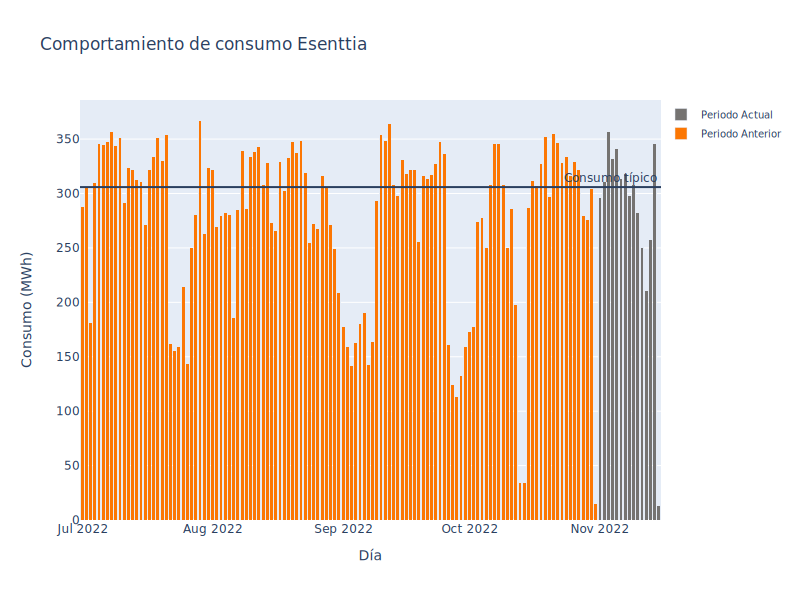

In [324]:
Esenttia_bl_diaria = Esenttia_bl.resample('D').sum().sort_values(by='timestamp', ascending=True).reset_index()
Esenttia_sp_diaria = Esenttia_sp.resample('D').sum().sort_values(by='timestamp', ascending=True).reset_index()


Esenttia_planta1 = Esenttia_complete[Esenttia_complete['Planta'] == 'Planta 1']
Esenttia_planta1_last_q = Esenttia_planta1.loc[Esenttia_planta1['timestamp'].between(periodo_comparación[0],periodo_comparación[1])]
Esenttia_planta2 = Esenttia_complete[Esenttia_complete['Planta'] == 'Planta 2']
Esenttia_planta2_last_q = Esenttia_planta2.loc[Esenttia_planta2['timestamp'].between(periodo_comparación[0],periodo_comparación[1])]
Esenttia_planta1_diaria = Esenttia_planta1.resample('D').sum().sort_values(by='timestamp', ascending=True).reset_index()
Esenttia_planta2_diaria = Esenttia_planta2.resample('D').sum().sort_values(by='timestamp', ascending=True).reset_index()
Esenttia_historico_diaria = Esenttia_historico.resample('D').sum().sort_values(by='timestamp', ascending=True).reset_index()


fig = go.Figure(data=[
    go.Bar(name='Periodo Anterior', x=Esenttia_bl_diaria['timestamp'], y=Esenttia_bl_diaria['Consumo (MWh)']),
    go.Bar(name='Periodo Actual', x=Esenttia_sp_diaria['timestamp'], y=Esenttia_sp_diaria['Consumo (MWh)'])
])

fig.update_layout(barmode='stack', title='Comportamiento de consumo Esenttia', width=800, height=600, colorway=['#fc7703', '#757371'], xaxis_title="Día", yaxis_title="Consumo (MWh)")


Esenttia_LB=Esenttia_historico_diaria ['Consumo (MWh)'].median()

fig.add_hline(y=Esenttia_LB, annotation_text=" Consumo típico")
fig.update_layout(legend=dict(

    xanchor="left",
    x=1,
    font=dict(size=10)
))

fig.show()

In [325]:
md("A continuación, presentamos la desagregación del consumo general de Esenttia por cada planta; planta 1, planta 2 donde se aprecian los principales usos significativos de la energía, USE’s: ")

A continuación, presentamos la desagregación del consumo general de Esenttia por cada planta; planta 1, planta 2 donde se aprecian los principales usos significativos de la energía, USE’s: 

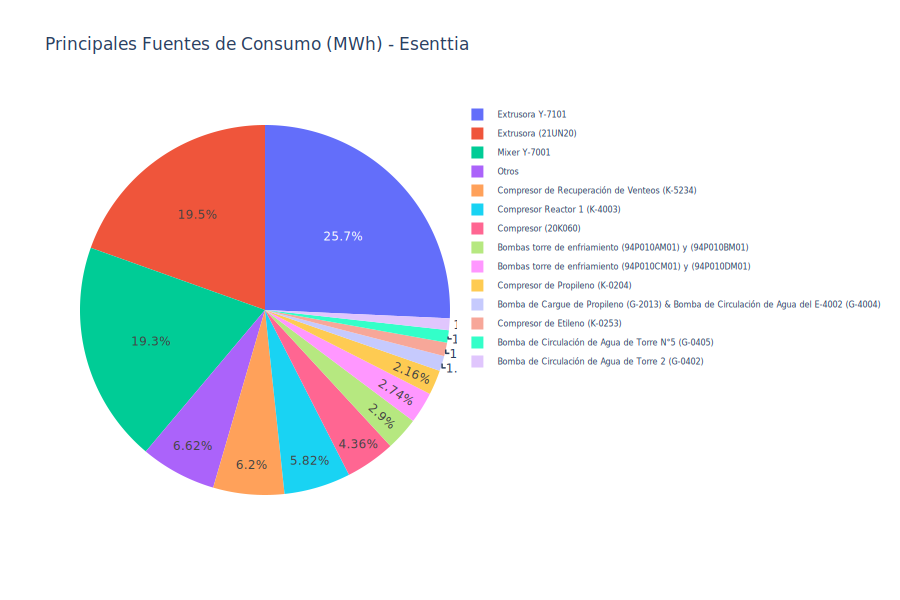

In [326]:
Esenttia_sp_grouped_pie_chart = Esenttia_sp_grouped[Esenttia_sp_grouped['%_equivalente']>1]
other_row = {'Máquina':'Otros', 'Consumo (MWh)': Esenttia_sp_grouped[Esenttia_sp_grouped['%_equivalente']<1]['Consumo (MWh)'].sum() ,'%_equivalente':(100-Esenttia_sp_grouped_pie_chart['%_equivalente'].round(2).sum()), '%_Acumulado':100}
Esenttia_sp_grouped_pie_chart = Esenttia_sp_grouped_pie_chart.append(other_row, ignore_index=True)
fig = px.pie(Esenttia_sp_grouped_pie_chart, values='Consumo (MWh)', names='Máquina', title='Principales Fuentes de Consumo (MWh) -  Esenttia', width=900, height=600)
fig.update_layout(showlegend=True, legend=dict(font=dict(size=8)))

fig.show()

In [327]:
Esenttia_sp_grouped_pie_chart.round(2)

Máquina  Consumo (MWh)  %_equivalente  %_Acumulado  Cantidad horas de operación
0                                                                           Extrusora Y-7101        1089.14          25.72        25.72                        336.0
1                                                                         Extrusora (21UN20)         827.64          19.54        45.26                        336.0
2                                                                               Mixer Y-7001         817.83          19.31        64.58                        317.0
3                                              Compresor de Recuperación de Venteos (K-5234)         262.74           6.20        70.78                        336.0
4                                                               Compresor Reactor 1 (K-4003)         246.35           5.82        76.60                        336.0
5                                                                         Compresor (20K060)         184.44           4.36        80.95                        329.0
6                                   Bombas torre de enfriamiento (94P010AM01) y (94P010BM01)         122.98           2.90        83.86                        336.0
7                                   Bombas torre de enfriamiento (94P010CM01) y (94P010DM01)         116.19           2.74        86.60                        336.0
8                                                            Compresor de Propileno (K-0204)          91.47           2.16        88.76                        336.0
9   Bomba de Cargue de Propileno (G-2013) & Bomba de Circulación de Agua del E-4002 (G-4004)          56.04           1.32        90.09                        336.0
10                                                             Compresor de Etileno (K-0253)          49.96           1.18        91.27                        336.0
11                                        Bomba de Circulación de Agua de Torre N°5 (G-0405)          45.84           1.08        92.35                        336.0
12                                          Bomba de Circulación de Agua de Torre 2 (G-0402)          43.53           1.03        93.38                        234.0
13                                                                                     Otros         280.48           6.64       100.00                          NaN

In [328]:
md(f"Así mismo, al verificar el consumo por proceso, observamos lo siguiente: ")

Así mismo, al verificar el consumo por proceso, observamos lo siguiente: 

In [329]:
Esenttia_sp_grouped_process = Esenttia_sp.groupby(['Proceso']).sum().sort_values(by='Consumo (MWh)', ascending=False)
Esenttia_sp_grouped_process.drop(columns=['day','month_year','year','hour'], inplace=True)
Esenttia_sp_grouped_process['%_equivalente'] = Esenttia_sp_grouped_process['Consumo (MWh)']/Esenttia_sp_grouped_process['Consumo (MWh)'].sum()*100
Esenttia_sp_grouped_process['%_Acumulado'] = Esenttia_sp_grouped_process['%_equivalente'].cumsum().round(2)
Esenttia_sp_grouped_process.reset_index(inplace=True)



Esenttia_sp_grouped_pie_chart = Esenttia_sp_grouped_process[Esenttia_sp_grouped_process['%_equivalente']>1]


other_row = {'Proceso':'Otros', 'Consumo (MWh)': Esenttia_sp_grouped_process[Esenttia_sp_grouped_process['%_equivalente']<1]['Consumo (MWh)'].sum() ,'%_equivalente':(100-Esenttia_sp_grouped_pie_chart['%_equivalente'].round(2).sum()), '%_Acumulado':100}
Esenttia_sp_grouped_pie_chart = Esenttia_sp_grouped_pie_chart.append(other_row, ignore_index=True)




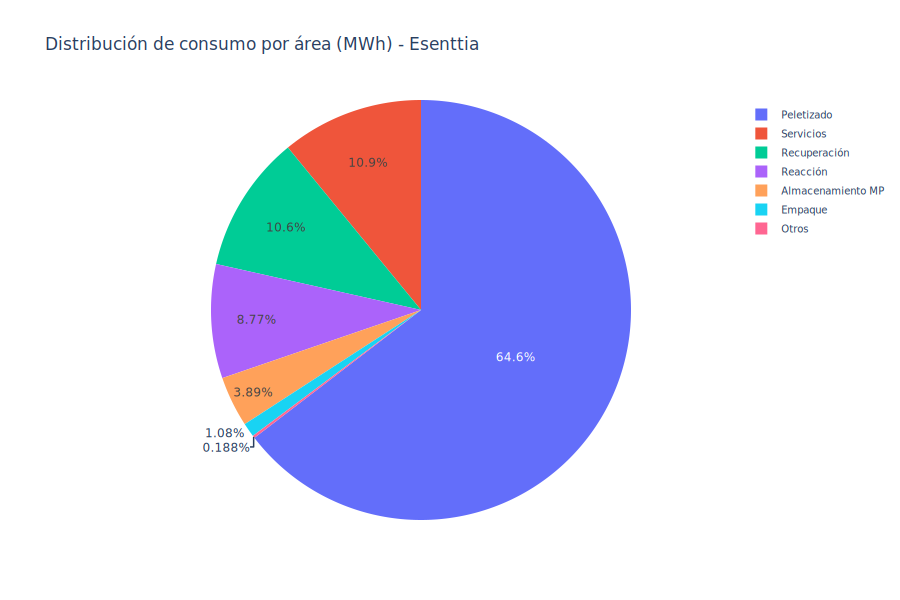

In [330]:

fig = px.pie(Esenttia_sp_grouped_pie_chart, values='Consumo (MWh)', names='Proceso', title='Distribución de consumo por área (MWh) - Esenttia', width=900, height=600)
fig.update_layout(showlegend=True, legend=dict(font=dict(size=10)))

fig.show()

In [331]:
Esenttia_sp_grouped_pie_chart.round(2)

Proceso  Consumo (MWh)  %_equivalente  %_Acumulado
0         Peletizado        2734.84          64.58        64.58
1          Servicios         462.66          10.93        75.51
2       Recuperación         447.18          10.56        86.07
3           Reacción         371.31           8.77        94.84
4  Almacenamiento MP         164.76           3.89        98.73
5            Empaque          45.89           1.08        99.81
6              Otros           7.98           0.19       100.00

In [332]:
md(f"Finalmente, te presentamos la distribución diaria de cada proceso: ")

Finalmente, te presentamos la distribución diaria de cada proceso: 

In [333]:
Esenttia_complete_Almacenamiento = Esenttia_complete[Esenttia_complete['Proceso']=='Almacenamiento MP & Servicios']
Esenttia_complete_Reacción = Esenttia_complete[Esenttia_complete['Proceso']=='Reacción']
Esenttia_complete_Almacenamiento_MP = Esenttia_complete[Esenttia_complete['Proceso']=='Almacenamiento MP']
Esenttia_complete_Servicios = Esenttia_complete[Esenttia_complete['Proceso']=='Servicios']
Esenttia_complete_Empaque = Esenttia_complete[Esenttia_complete['Proceso']=='Empaque']
Esenttia_complete_Peletizado = Esenttia_complete[Esenttia_complete['Proceso']=='Peletizado']
Esenttia_complete_Recuperación = Esenttia_complete[Esenttia_complete['Proceso']=='Recuperación']

Esenttia_complete_Almacenamiento_diario = Esenttia_complete_Almacenamiento.resample('D').sum().sort_values(by='timestamp', ascending=True).reset_index()
Esenttia_complete_Reacción_diario = Esenttia_complete_Reacción.resample('D').sum().sort_values(by='timestamp', ascending=True).reset_index()
Esenttia_complete_Almacenamiento_MP_diario = Esenttia_complete_Almacenamiento_MP.resample('D').sum().sort_values(by='timestamp', ascending=True).reset_index()
Esenttia_complete_Servicios_diario = Esenttia_complete_Servicios.resample('D').sum().sort_values(by='timestamp', ascending=True).reset_index()
Esenttia_complete_Empaque_diario = Esenttia_complete_Empaque.resample('D').sum().sort_values(by='timestamp', ascending=True).reset_index()
Esenttia_complete_Peletizado_diario = Esenttia_complete_Peletizado.resample('D').sum().sort_values(by='timestamp', ascending=True).reset_index()
Esenttia_complete_Recuperación_diario = Esenttia_complete_Recuperación.resample('D').sum().sort_values(by='timestamp', ascending=True).reset_index()


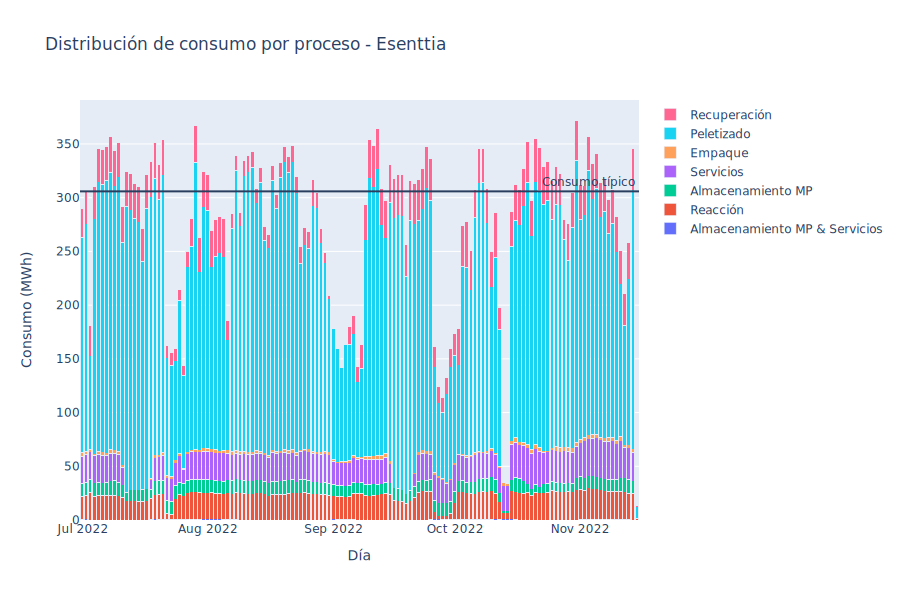

In [334]:
fig = go.Figure(data=[
    go.Bar(name='Almacenamiento MP & Servicios', x=Esenttia_complete_Almacenamiento_diario['timestamp'], y=Esenttia_complete_Almacenamiento_diario['Consumo (MWh)']),
    go.Bar(name='Reacción', x=Esenttia_complete_Reacción_diario['timestamp'], y=Esenttia_complete_Reacción_diario['Consumo (MWh)']),
    go.Bar(name='Almacenamiento MP', x=Esenttia_complete_Almacenamiento_MP_diario['timestamp'], y=Esenttia_complete_Almacenamiento_MP_diario['Consumo (MWh)']),
    go.Bar(name='Servicios', x=Esenttia_complete_Servicios_diario['timestamp'], y=Esenttia_complete_Servicios_diario['Consumo (MWh)']),
    go.Bar(name='Empaque', x=Esenttia_complete_Empaque_diario['timestamp'], y=Esenttia_complete_Empaque_diario['Consumo (MWh)']),
    go.Bar(name='Peletizado', x=Esenttia_complete_Peletizado_diario['timestamp'], y=Esenttia_complete_Peletizado_diario['Consumo (MWh)']),
    go.Bar(name='Recuperación', x=Esenttia_complete_Recuperación_diario['timestamp'], y=Esenttia_complete_Recuperación_diario['Consumo (MWh)']),
])
# Change the bar mode
fig.update_layout(barmode='stack', title='Distribución de consumo por proceso -  Esenttia', width=900, height=600, xaxis_title="Día", yaxis_title="Consumo (MWh)")
fig.add_hline(y=Esenttia_LB, annotation_text=" Consumo típico" )
fig.show()

In [335]:
md(f"Finalmente, en términos de eficiencia de proceso, observamos el siguiente comportamiento díario:")

Finalmente, en términos de eficiencia de proceso, observamos el siguiente comportamiento díario:

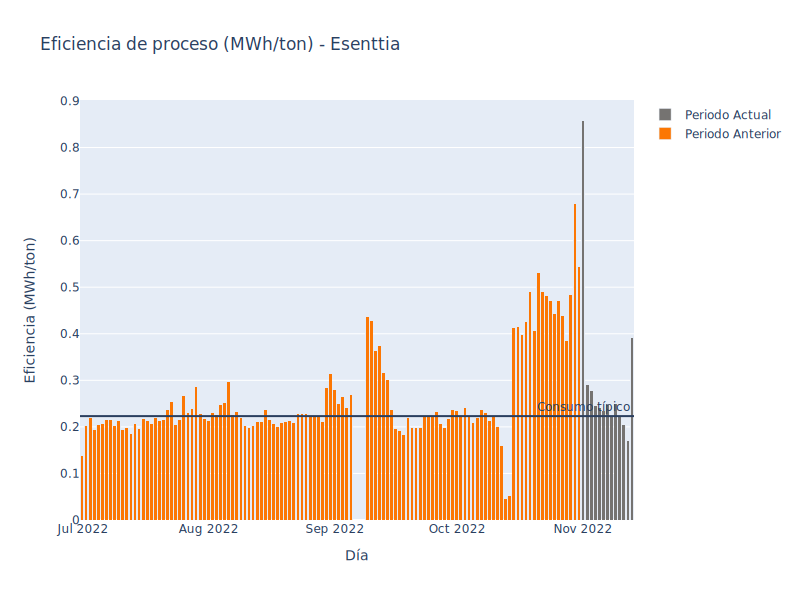

In [336]:
produccion_esenttia_historica = historic_data[historic_data['NAME'].isin(['FIX.APC-FILTPR1.F_CV', 'FIX.APC-FILTPR2.F_CV', 'FIX.MES-P2-REACCION-RATA.F_CV' ])]
produccion_esenttia_historica.drop(columns=['datetime', 'NAME', 'variable', 'load', 'description'], inplace=True)
produccion_esenttia_historica.replace('Bad', np.nan, inplace=True)
produccion_esenttia_historica['Active power'] = produccion_esenttia_historica['Active power'].astype(float)
produccion_esenttia_historica_diaria = produccion_esenttia_historica.resample('D').sum()

esenttia_consumo_total_historico_diario = Esenttia_bl_diaria.drop(columns=['month_year', 'day','year','hour'], inplace=False)
esenttia_consumo_total_historico_diario.index = esenttia_consumo_total_historico_diario['timestamp']
esenttia_consumo_total_historico_diario.drop(columns=['timestamp'], inplace=True)

produccion_esenttia_historica_diaria.index.names = ['timestamp']
produccion_esenttia_historica_diaria

Esenttia_eficiencia_historica = esenttia_consumo_total_historico_diario.merge(produccion_esenttia_historica_diaria, left_index=True, right_index=True)
Esenttia_eficiencia_historica.rename(columns={'Active power': 'Producción (ton)'}, inplace=True)
Esenttia_eficiencia_historica['Eficiencia (MWh/ton)'] = Esenttia_eficiencia_historica['Consumo (MWh)']/Esenttia_eficiencia_historica['Producción (ton)']

Esenttia_eficiencia_historica = Esenttia_eficiencia_historica[Esenttia_eficiencia_historica['Eficiencia (MWh/ton)'].between(0, 1.5)]
Esenttia_eficiencia_historica.reset_index(inplace=True)
Esenttia_eficiencia_historica = Esenttia_eficiencia_historica[Esenttia_eficiencia_historica.timestamp != '2022-11-01']

produccion_esenttia_sp_p1 = data[['FIX.APC-FILTPR1.F_CV', 'FIX.APC-FILTPR2.F_CV']]
produccion_esenttia_sp_p1.dropna(inplace=True)
produccion_esenttia_sp_p1 = produccion_esenttia_sp_p1.astype(float)
produccion_esenttia_sp_p1 = produccion_esenttia_sp_p1.resample('h').mean()

produccion_esenttia_sp_p2 = historico_produccion_p2[historico_produccion_p2['name']=='FIX.MES-P2-REACCION-RATA.F_CV']
produccion_esenttia_sp_p2.drop(columns=['name'], inplace=True)
produccion_esenttia_sp_p2.rename(columns={'value': 'FIX.MES-P2-REACCION-RATA.F_CV'}, inplace=True)
produccion_esenttia_sp_p2.index.names = ['timestamp']

produccion_esenttia_sp = produccion_esenttia_sp_p1.merge(produccion_esenttia_sp_p2, left_index=True, right_index=True)
produccion_esenttia_sp = produccion_esenttia_sp.astype(float)

produccion_esenttia_sp['Producción (ton)'] = produccion_esenttia_sp['FIX.APC-FILTPR1.F_CV'] + produccion_esenttia_sp['FIX.APC-FILTPR2.F_CV'] + produccion_esenttia_sp['FIX.MES-P2-REACCION-RATA.F_CV']
produccion_esenttia_sp.drop(columns=['FIX.APC-FILTPR1.F_CV', 'FIX.APC-FILTPR2.F_CV', 'FIX.MES-P2-REACCION-RATA.F_CV'], inplace=True)
produccion_esenttia_sp_diaria = produccion_esenttia_sp.resample('D').sum()

consumo_esenttia_sp = Esenttia_sp_diaria.drop(columns=['month_year', 'day','year','hour'], inplace=False)
consumo_esenttia_sp.index = consumo_esenttia_sp['timestamp']
consumo_esenttia_sp.drop(columns=['timestamp'], inplace=True)

produccion_esenttia_sp_diaria =produccion_esenttia_sp_diaria.merge(consumo_esenttia_sp, left_index=True, right_index=True)

produccion_esenttia_sp_diaria['Eficiencia (MWh/ton)'] = produccion_esenttia_sp_diaria['Consumo (MWh)']/produccion_esenttia_sp_diaria['Producción (ton)']
produccion_esenttia_sp_diaria.reset_index(inplace=True)

Esenttia_eficiencia_total = pd.concat([Esenttia_eficiencia_historica,produccion_esenttia_sp_diaria], axis=0)
Esenttia_eficiencia_total['periodo'] = np.where((Esenttia_eficiencia_total['timestamp'] >= datetime.strptime(periodo_historico[0], "%Y-%m-%d")) & (Esenttia_eficiencia_total['timestamp'] <= datetime.strptime(periodo_historico[1], "%Y-%m-%d")), 'Baseline', 'Estudio')

Esenttia_eficiencia_total_LB = Esenttia_eficiencia_total.loc[(Esenttia_eficiencia_total['periodo']=="Baseline") & (Esenttia_eficiencia_total['Eficiencia (MWh/ton)'].between(Esenttia_eficiencia_total['Eficiencia (MWh/ton)'].quantile(.05),Esenttia_eficiencia_total['Eficiencia (MWh/ton)'].quantile(.95)))]['Eficiencia (MWh/ton)'].median()

fig = go.Figure(data=[
    go.Bar(name='Periodo Anterior', x=Esenttia_eficiencia_historica['timestamp'], y=Esenttia_eficiencia_historica['Eficiencia (MWh/ton)']),
    go.Bar(name='Periodo Actual', x=produccion_esenttia_sp_diaria['timestamp'], y=produccion_esenttia_sp_diaria['Eficiencia (MWh/ton)'])
])
fig.add_hline(y=Esenttia_eficiencia_total_LB, annotation_text=" Consumo típico" )

fig.update_layout(barmode='stack', title='Eficiencia de proceso (MWh/ton) - Esenttia', width=800, height=600, colorway=['#fc7703', '#757371'], xaxis_title="Día", yaxis_title="Eficiencia (MWh/ton)")


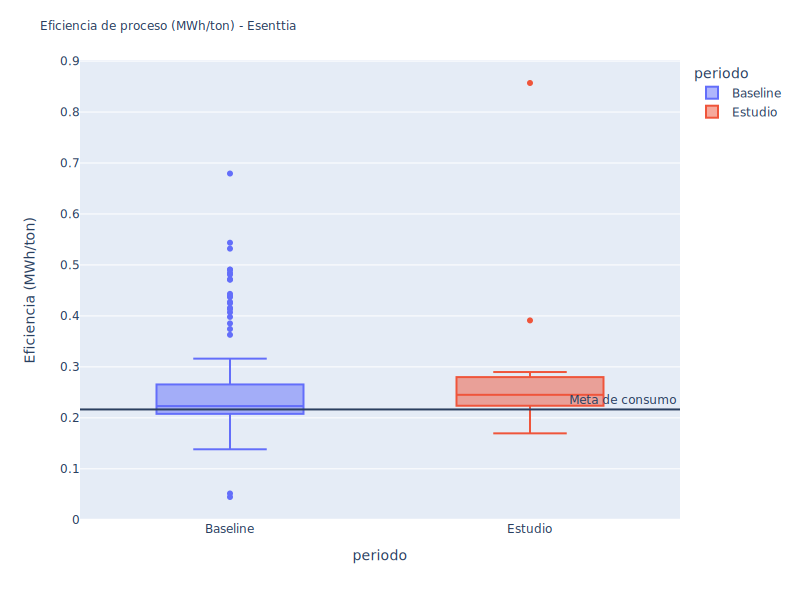

In [337]:
Esenttia_eficiencia_total_LB = Esenttia_eficiencia_total.loc[(Esenttia_eficiencia_total['periodo']=="Baseline") & (Esenttia_eficiencia_total['Eficiencia (MWh/ton)'].between(Esenttia_eficiencia_total['Eficiencia (MWh/ton)'].quantile(.25),Esenttia_eficiencia_total['Eficiencia (MWh/ton)'].quantile(.5)))]['Eficiencia (MWh/ton)'].mean()

fig = px.box(Esenttia_eficiencia_total, x="periodo", y="Eficiencia (MWh/ton)", color="periodo")
fig.add_hline(y=Esenttia_eficiencia_total_LB, annotation_text=" Meta de consumo")
fig.update_layout( title='Eficiencia de proceso (MWh/ton) - Esenttia', width=800, height=600, colorway=['#fc7703', '#757371'], yaxis_title="Eficiencia (MWh/ton)", title_font_size=12)
fig.show()

In [338]:
md(f"Al analizar el comportamiento por planta, observamos lo siguiente:")

Al analizar el comportamiento por planta, observamos lo siguiente:

## Planta 1

In [339]:
Esenttia_planta1['periodo'] = np.where((Esenttia_planta1['timestamp'] >= datetime.strptime(periodo_historico[0], "%Y-%m-%d")) & (Esenttia_planta1['timestamp'] <= datetime.strptime(periodo_historico[1], "%Y-%m-%d")), 'Baseline', 'Estudio')
Esenttia_planta1_sp = Esenttia_planta1[Esenttia_planta1['periodo'] == 'Estudio']

Esenttia_planta1_sp_grouped = Esenttia_planta1_sp.groupby(['Máquina']).sum().sort_values(by='Consumo (MWh)', ascending=False)
Esenttia_planta1_sp_grouped.drop(columns=['day','month_year','year','hour'], inplace=True)
Esenttia_planta1_sp_grouped['%_equivalente'] = Esenttia_planta1_sp_grouped['Consumo (MWh)']/Esenttia_planta1_sp_grouped['Consumo (MWh)'].sum()*100
Esenttia_planta1_sp_grouped['%_Acumulado'] = Esenttia_planta1_sp_grouped['%_equivalente'].cumsum().round(2)
Esenttia_planta1_sp_grouped['Cantidad horas de operación'] = Esenttia_planta1_sp[Esenttia_planta1_sp['Consumo (MWh)']>0].groupby(['Máquina']).count()['Consumo (MWh)']
Esenttia_planta1_sp_grouped.reset_index(inplace=True)


Esenttia_planta1_sp_grouped_last_q = Esenttia_planta1_last_q.groupby(['Máquina']).sum().sort_values(by='Consumo (MWh)', ascending=False)




Esenttia_planta1_sp_grouped_pie_chart = Esenttia_planta1_sp_grouped[Esenttia_planta1_sp_grouped['%_equivalente']>1]
other_row = {'Máquina':'Otros', 'Consumo (MWh)': Esenttia_planta1_sp_grouped[Esenttia_planta1_sp_grouped['%_equivalente']<1]['Consumo (MWh)'].sum() ,'%_equivalente':(100-Esenttia_planta1_sp_grouped_pie_chart['%_equivalente'].round(2).sum()), '%_Acumulado':100}
Esenttia_planta1_sp_grouped_pie_chart = Esenttia_planta1_sp_grouped_pie_chart.append(other_row, ignore_index=True)

planta_1_historico = Esenttia_planta1[Esenttia_planta1['periodo'] == 'Baseline']

planta_1_complete = Esenttia_complete[Esenttia_complete['Planta']=='Planta 1']



In [340]:
import numpy as np

mask_bl = (Esenttia_planta1['timestamp'] > periodo_historico[0]) & (Esenttia_planta1['timestamp'] <= periodo_historico[1])
Esenttia_planta_1_bl = Esenttia_planta1.loc[mask_bl]

mask_sp = (Esenttia_planta1['timestamp'] > periodo_de_estudio[0]) & (Esenttia_planta1['timestamp'] <= periodo_de_estudio[1])
Esenttia_planta_1_sp = Esenttia_planta1.loc[mask_sp]

consumo_a = Esenttia_planta_1_sp['Consumo (MWh)'].sum().round(2)
consumo_b = Esenttia_planta1_sp_grouped_last_q['Consumo (MWh)'].sum().round(2)

if consumo_a > consumo_b:
    print(f"Durante el periodo de estudio, el consumo total de la Planta 1 fue de {consumo_a} MWh, equivalente a un aumento de {abs(consumo_a - consumo_b).round(2)} MWh, lo que representa un aumento de {(abs(1 - (consumo_b / consumo_a))*100).round(2)}% respecto al último periodo medido,  con la siguiente desagregación diaria:")
else:
    print(f"Durante el periodo de estudio, el consumo total de la Planta 1 fue de {consumo_a} MWh, equivalente a una disminución de {abs(consumo_a - consumo_b).round(2)} MWh, lo que representa una disminución de {(abs(1 - (consumo_b / consumo_a))*100).round(2)}% respecto al último periodo medido, con la siguiente desagregación diaria:")

Durante el periodo de estudio, el consumo total de la Planta 1 fue de 2888.2 MWh, equivalente a una disminución de 294.72 MWh, lo que representa una disminución de 10.2% respecto al último periodo medido, con la siguiente desagregación diaria:


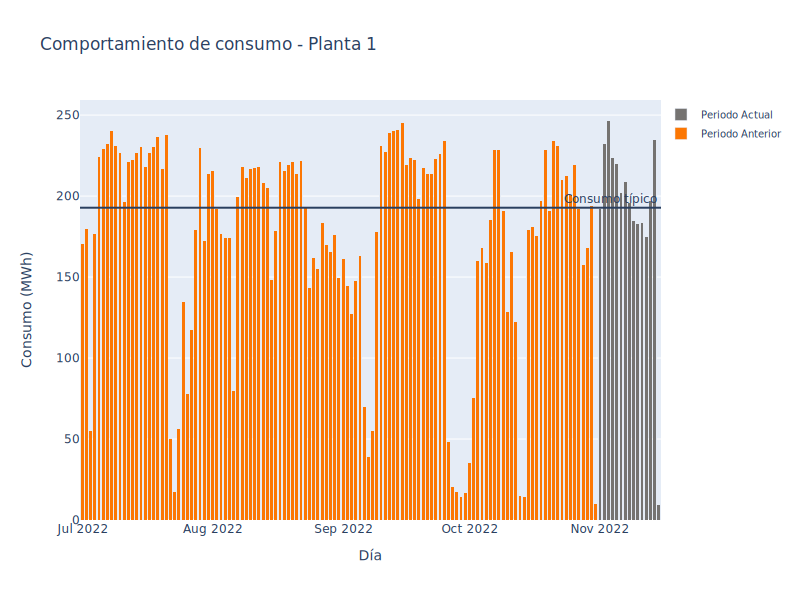

In [341]:

Esenttia_planta_1_bl_diaria = Esenttia_planta_1_bl.resample('D').sum().sort_values(by='timestamp', ascending=True).reset_index()
Esenttia_planta_1_sp_diaria = Esenttia_planta_1_sp.resample('D').sum().sort_values(by='timestamp', ascending=True).reset_index()
Esenttia_planta_1_historico_diaria = planta_1_historico.resample('D').sum().sort_values(by='timestamp', ascending=True).reset_index()

pd.concat([Esenttia_planta_1_bl_diaria, Esenttia_planta_1_sp_diaria, Esenttia_planta_1_historico_diaria], axis=1)

fig = go.Figure(data=[
    go.Bar(name='Periodo Anterior', x=Esenttia_planta_1_historico_diaria['timestamp'], y=Esenttia_planta_1_historico_diaria['Consumo (MWh)']),
    go.Bar(name='Periodo Actual', x=Esenttia_planta_1_sp_diaria['timestamp'], y=Esenttia_planta_1_sp_diaria['Consumo (MWh)']),
    

])
Planta1_LB=Esenttia_planta_1_historico_diaria ['Consumo (MWh)'].median()

fig.add_hline(y=Planta1_LB, annotation_text=" Consumo típico")
fig.update_layout(barmode='stack', title='Comportamiento de consumo - Planta 1', width=800, height=600, colorway=['#fc7703', '#757371'], xaxis_title="Día", yaxis_title="Consumo (MWh)")
fig.update_layout(legend=dict(

    xanchor="left",
    x=1,
    font=dict(size=10)
))
fig.show()

In [342]:
md("A continuación, presentamos la desagregación del consumo general de planta 1, donde se aprecian los principales usos significativos de la energía, USE’s: ")

A continuación, presentamos la desagregación del consumo general de planta 1, donde se aprecian los principales usos significativos de la energía, USE’s: 

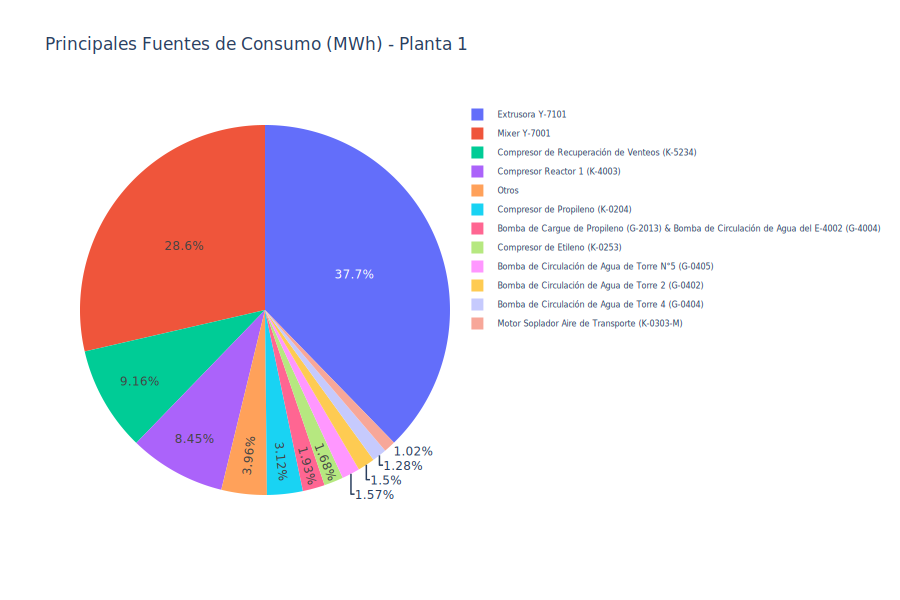

In [343]:
fig = px.pie(Esenttia_planta1_sp_grouped_pie_chart, values='Consumo (MWh)', names='Máquina', title='Principales Fuentes de Consumo (MWh) -  Planta 1', width=900, height=600)
fig.update_layout(showlegend=True, legend=dict(font=dict(size=8)))
fig.show()

In [344]:
Esenttia_planta1_sp_grouped_pie_chart.round(2)

Máquina  Consumo (MWh)  %_equivalente  %_Acumulado  Cantidad horas de operación
0                                                                           Extrusora Y-7101        1181.06          37.72        37.72                        360.0
1                                                                               Mixer Y-7001         895.46          28.60        66.32                        341.0
2                                              Compresor de Recuperación de Venteos (K-5234)         286.76           9.16        75.48                        360.0
3                                                               Compresor Reactor 1 (K-4003)         264.43           8.45        83.92                        360.0
4                                                            Compresor de Propileno (K-0204)          97.81           3.12        87.05                        360.0
5   Bomba de Cargue de Propileno (G-2013) & Bomba de Circulación de Agua del E-4002 (G-4004)          60.46           1.93        88.98                        360.0
6                                                              Compresor de Etileno (K-0253)          52.74           1.68        90.66                        360.0
7                                         Bomba de Circulación de Agua de Torre N°5 (G-0405)          49.20           1.57        92.24                        360.0
8                                           Bomba de Circulación de Agua de Torre 2 (G-0402)          46.92           1.50        93.73                        252.0
9                                           Bomba de Circulación de Agua de Torre 4 (G-0404)          40.09           1.28        95.01                        250.0
10                                              Motor Soplador Aire de Transporte (K-0303-M)          32.06           1.02        96.04                        349.0
11                                                                                     Otros         124.06           3.97       100.00                          NaN

In [345]:
md(f"Así mismo, al verificar el consumo por proceso, observamos lo siguiente: ")


Así mismo, al verificar el consumo por proceso, observamos lo siguiente: 

In [346]:
planta_1_complete_Almacenamiento = planta_1_complete[planta_1_complete['Proceso']=='Almacenamiento MP & Servicios']
planta_1_complete_Reacción = planta_1_complete[planta_1_complete['Proceso']=='Reacción']
planta_1_complete_Almacenamiento_MP = planta_1_complete[planta_1_complete['Proceso']=='Almacenamiento MP']
planta_1_complete_Servicios = planta_1_complete[planta_1_complete['Proceso']=='Servicios']
planta_1_complete_Empaque = planta_1_complete[planta_1_complete['Proceso']=='Empaque']
planta_1_complete_Peletizado = planta_1_complete[planta_1_complete['Proceso']=='Peletizado']
planta_1_complete_Recuperación = planta_1_complete[planta_1_complete['Proceso']=='Recuperación']

planta_1_complete_Almacenamiento_diario = planta_1_complete_Almacenamiento.resample('D').sum().sort_values(by='timestamp', ascending=True).reset_index()
planta_1_complete_Reacción_diario = planta_1_complete_Reacción.resample('D').sum().sort_values(by='timestamp', ascending=True).reset_index()
planta_1_complete_Almacenamiento_MP_diario = planta_1_complete_Almacenamiento_MP.resample('D').sum().sort_values(by='timestamp', ascending=True).reset_index()
planta_1_complete_Servicios_diario = planta_1_complete_Servicios.resample('D').sum().sort_values(by='timestamp', ascending=True).reset_index()
planta_1_complete_Empaque_diario = planta_1_complete_Empaque.resample('D').sum().sort_values(by='timestamp', ascending=True).reset_index()
planta_1_complete_Peletizado_diario = planta_1_complete_Peletizado.resample('D').sum().sort_values(by='timestamp', ascending=True).reset_index()
planta_1_complete_Recuperación_diario = planta_1_complete_Recuperación.resample('D').sum().sort_values(by='timestamp', ascending=True).reset_index()


In [347]:
Esenttia_sp_planta1_grouped_process = Esenttia_planta1.groupby(['Proceso']).sum().sort_values(by='Consumo (MWh)', ascending=False)
Esenttia_sp_planta1_grouped_process.drop(columns=['day','month_year','year','hour'], inplace=True)
Esenttia_sp_planta1_grouped_process['%_equivalente'] = Esenttia_sp_planta1_grouped_process['Consumo (MWh)']/Esenttia_sp_planta1_grouped_process['Consumo (MWh)'].sum()*100
Esenttia_sp_planta1_grouped_process['%_Acumulado'] = Esenttia_sp_planta1_grouped_process['%_equivalente'].cumsum().round(2)
Esenttia_sp_planta1_grouped_process.reset_index(inplace=True)



Esenttia_sp_planta1_grouped_process = Esenttia_sp_planta1_grouped_process[Esenttia_sp_planta1_grouped_process['%_equivalente']>1]


other_row = {'Proceso':'Otros', 'Consumo (MWh)': Esenttia_sp_planta1_grouped_process[Esenttia_sp_planta1_grouped_process['%_equivalente']<1]['Consumo (MWh)'].sum() ,'%_equivalente':(100-Esenttia_sp_grouped_pie_chart['%_equivalente'].round(2).sum()), '%_Acumulado':100}
Esenttia_sp_planta1_grouped_process = Esenttia_sp_planta1_grouped_process.append(other_row, ignore_index=True)


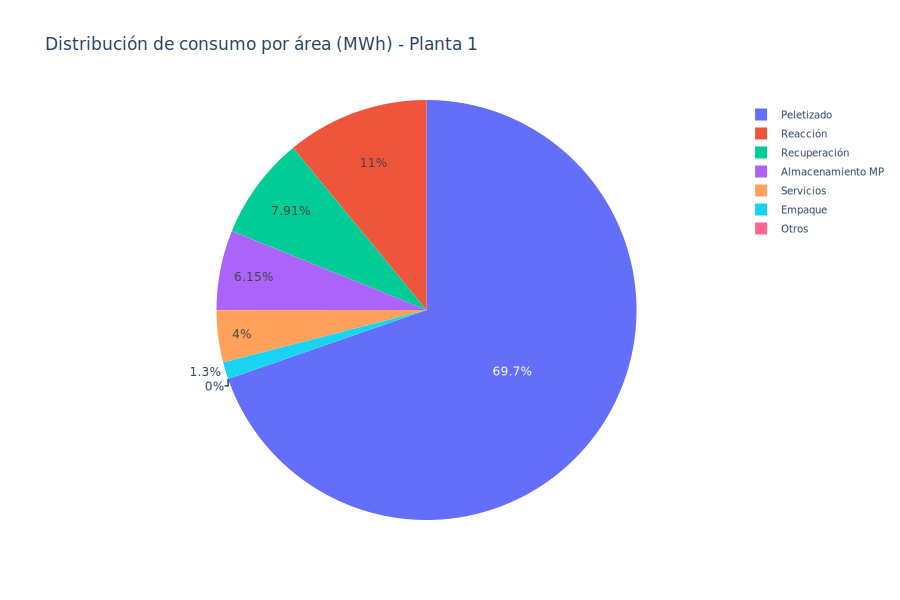

In [348]:

fig = px.pie(Esenttia_sp_planta1_grouped_process, values='Consumo (MWh)', names='Proceso', title='Distribución de consumo por área (MWh) -  Planta 1', width=900, height=600)
fig.update_layout(showlegend=True, legend=dict(font=dict(size=10)))

fig.show()

In [349]:

Esenttia_sp_planta1_grouped_process.round(2)


Proceso  Consumo (MWh)  %_equivalente  %_Acumulado
0         Peletizado       17066.56          69.56        69.56
1           Reacción        2684.29          10.94        80.50
2       Recuperación        1936.67           7.89        88.39
3  Almacenamiento MP        1506.15           6.14        94.53
4          Servicios         980.91           4.00        98.53
5            Empaque         318.74           1.30        99.83
6              Otros           0.00           0.00       100.00

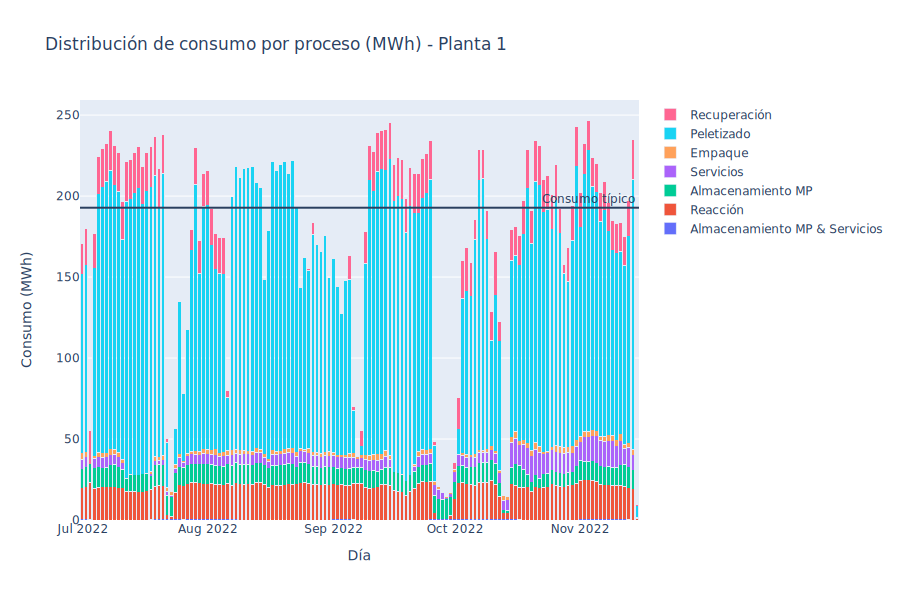

In [350]:
fig = go.Figure(data=[
    go.Bar(name='Almacenamiento MP & Servicios', x=planta_1_complete_Almacenamiento_diario['timestamp'], y=planta_1_complete_Almacenamiento_diario['Consumo (MWh)']),
    go.Bar(name='Reacción', x=planta_1_complete_Reacción_diario['timestamp'], y=planta_1_complete_Reacción_diario['Consumo (MWh)']),
    go.Bar(name='Almacenamiento MP', x=planta_1_complete_Almacenamiento_MP_diario['timestamp'], y=planta_1_complete_Almacenamiento_MP_diario['Consumo (MWh)']),
    go.Bar(name='Servicios', x=planta_1_complete_Servicios_diario['timestamp'], y=planta_1_complete_Servicios_diario['Consumo (MWh)']),
    go.Bar(name='Empaque', x=planta_1_complete_Empaque_diario['timestamp'], y=planta_1_complete_Empaque_diario['Consumo (MWh)']),
    go.Bar(name='Peletizado', x=planta_1_complete_Peletizado_diario['timestamp'], y=planta_1_complete_Peletizado_diario['Consumo (MWh)']),
    go.Bar(name='Recuperación', x=planta_1_complete_Recuperación_diario['timestamp'], y=planta_1_complete_Recuperación_diario['Consumo (MWh)']),
])
# Change the bar mode
fig.update_layout(barmode='stack', title='Distribución de consumo por proceso (MWh) -  Planta 1', width=900, height=600, xaxis_title="Día", yaxis_title="Consumo (MWh)")
fig.add_hline(y=Planta1_LB, annotation_text=" Consumo típico")
fig.show()

In [351]:
md(f"Finalmente, en términos de eficiencia de proceso, observamos el siguiente comportamiento díario:")

Finalmente, en términos de eficiencia de proceso, observamos el siguiente comportamiento díario:

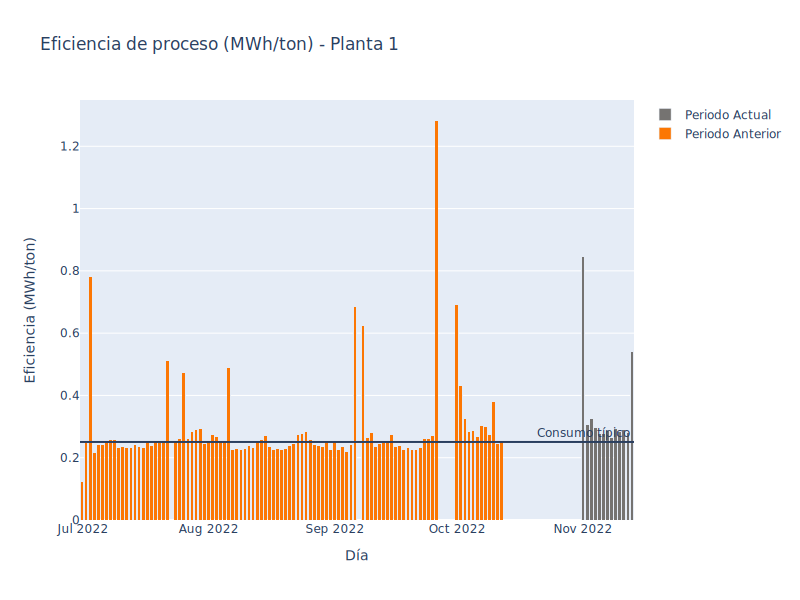

In [352]:
produccion_planta1_historica = historic_data[historic_data['NAME'].isin(['FIX.APC-FILTPR1.F_CV', 'FIX.APC-FILTPR2.F_CV' ])]
produccion_planta1_historica.drop(columns=['datetime', 'NAME', 'variable', 'load', 'description'], inplace=True)
produccion_planta1_historica.replace('Bad', np.nan, inplace=True)
produccion_planta1_historica['Active power'] = produccion_planta1_historica['Active power'].astype(float)
produccion_planta1_historica_diaria = produccion_planta1_historica.resample('D').sum()

planta1_consumo_total_historico_diario = Esenttia_planta_1_bl_diaria.drop(columns=['month_year', 'day','year','hour'], inplace=False)
planta1_consumo_total_historico_diario.index = planta1_consumo_total_historico_diario['timestamp']
planta1_consumo_total_historico_diario.drop(columns=['timestamp'], inplace=True)

produccion_planta1_historica_diaria.index.names = ['timestamp']
produccion_planta1_historica_diaria

planta1_eficiencia_historica = planta1_consumo_total_historico_diario.merge(produccion_planta1_historica_diaria, left_index=True, right_index=True)
planta1_eficiencia_historica.rename(columns={'Active power': 'Producción (ton)'}, inplace=True)
planta1_eficiencia_historica['Eficiencia (MWh/ton)'] = planta1_eficiencia_historica['Consumo (MWh)']/planta1_eficiencia_historica['Producción (ton)']

planta1_eficiencia_historica = planta1_eficiencia_historica[planta1_eficiencia_historica['Eficiencia (MWh/ton)'].between(0, 1.5)]
planta1_eficiencia_historica.reset_index(inplace=True)
planta1_eficiencia_historica = planta1_eficiencia_historica[planta1_eficiencia_historica.timestamp != '2022-11-01']

produccion_planta1_sp_p1 = data[['FIX.APC-FILTPR1.F_CV', 'FIX.APC-FILTPR2.F_CV']]
produccion_planta1_sp_p1.dropna(inplace=True)
produccion_planta1_sp_p1 = produccion_planta1_sp_p1.astype(float)
produccion_planta1_sp_p1 = produccion_planta1_sp_p1.resample('h').mean()


produccion_planta1_sp = produccion_planta1_sp_p1

produccion_planta1_sp['Producción (ton)'] = produccion_planta1_sp['FIX.APC-FILTPR1.F_CV'] + produccion_planta1_sp['FIX.APC-FILTPR2.F_CV']
produccion_planta1_sp.drop(columns=['FIX.APC-FILTPR1.F_CV', 'FIX.APC-FILTPR2.F_CV'], inplace=True)
produccion_planta1_sp_diaria = produccion_planta1_sp.resample('D').sum()

consumo_planta1_sp = Esenttia_planta_1_sp_diaria.drop(columns=['month_year', 'day','year','hour'], inplace=False)
consumo_planta1_sp.index = consumo_planta1_sp['timestamp']
consumo_planta1_sp.drop(columns=['timestamp'], inplace=True)

produccion_planta1_sp_diaria =produccion_planta1_sp_diaria.merge(consumo_planta1_sp, left_index=True, right_index=True)

produccion_planta1_sp_diaria['Eficiencia (MWh/ton)'] = produccion_planta1_sp_diaria['Consumo (MWh)']/produccion_planta1_sp_diaria['Producción (ton)']
produccion_planta1_sp_diaria.reset_index(inplace=True)

planta1_eficiencia_total = pd.concat([planta1_eficiencia_historica,produccion_planta1_sp_diaria], axis=0)
planta1_eficiencia_total['periodo'] = np.where((planta1_eficiencia_total['timestamp'] >= datetime.strptime(periodo_historico[0], "%Y-%m-%d")) & (planta1_eficiencia_total['timestamp'] <= datetime.strptime(periodo_historico[1], "%Y-%m-%d")), 'Baseline', 'Estudio')

planta1_eficiencia_total_LB = planta1_eficiencia_total.loc[(planta1_eficiencia_total['periodo']=="Baseline") & (planta1_eficiencia_total['Eficiencia (MWh/ton)'].between(planta1_eficiencia_total['Eficiencia (MWh/ton)'].quantile(.05),planta1_eficiencia_total['Eficiencia (MWh/ton)'].quantile(.95)))]['Eficiencia (MWh/ton)'].median()

fig = go.Figure(data=[
    go.Bar(name='Periodo Anterior', x=planta1_eficiencia_historica['timestamp'], y=planta1_eficiencia_historica['Eficiencia (MWh/ton)']),
    go.Bar(name='Periodo Actual', x=produccion_planta1_sp_diaria['timestamp'], y=produccion_planta1_sp_diaria['Eficiencia (MWh/ton)'])
])
fig.add_hline(y=planta1_eficiencia_total_LB, annotation_text=" Consumo típico" )

fig.update_layout(barmode='stack', title='Eficiencia de proceso (MWh/ton) - Planta 1', width=800, height=600, colorway=['#fc7703', '#757371'], xaxis_title="Día", yaxis_title="Eficiencia (MWh/ton)")


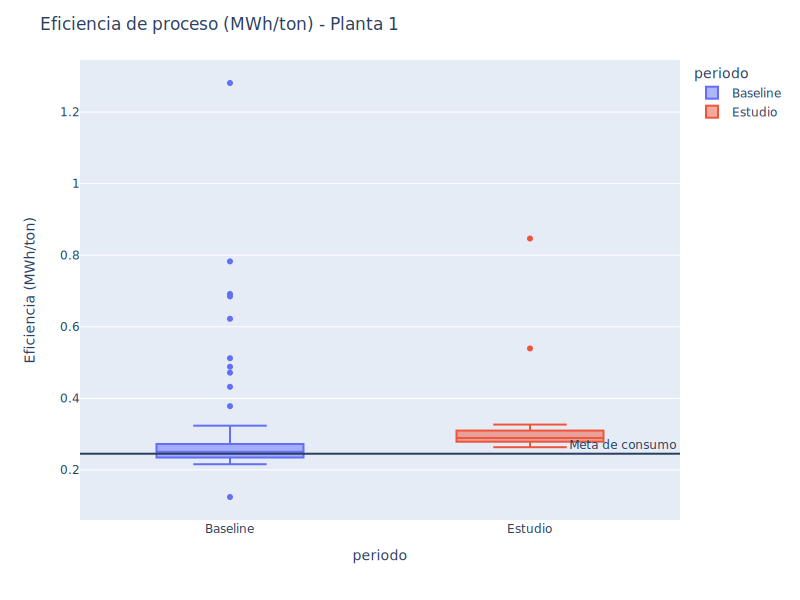

In [353]:
planta1_eficiencia_total_LB = planta1_eficiencia_total.loc[(planta1_eficiencia_total['periodo']=="Baseline") & (planta1_eficiencia_total['Eficiencia (MWh/ton)'].between(planta1_eficiencia_total['Eficiencia (MWh/ton)'].quantile(.25),planta1_eficiencia_total['Eficiencia (MWh/ton)'].quantile(.5)))]['Eficiencia (MWh/ton)'].mean()

fig = px.box(planta1_eficiencia_total, x="periodo", y="Eficiencia (MWh/ton)", color="periodo")
fig.add_hline(y=planta1_eficiencia_total_LB, annotation_text=" Meta de consumo")
fig.update_layout( title='Eficiencia de proceso (MWh/ton) - Planta 1', width=800, height=600, colorway=['#fc7703', '#757371'], yaxis_title="Eficiencia (MWh/ton)")
fig.show()

In [354]:
md(f"Ahora, observemos el comportamiento de Planta 2:")

Ahora, observemos el comportamiento de Planta 2:

## Planta 2

In [355]:
Esenttia_planta2['periodo'] = np.where((Esenttia_planta2['timestamp'] >= datetime.strptime(periodo_historico[0], "%Y-%m-%d")) & (Esenttia_planta2['timestamp'] <= datetime.strptime(periodo_historico[1], "%Y-%m-%d")), 'Baseline', 'Estudio')
Esenttia_planta2_sp = Esenttia_planta2[Esenttia_planta2['periodo'] == 'Estudio']

Esenttia_planta2_sp_grouped = Esenttia_planta2_sp.groupby(['Máquina']).sum().sort_values(by='Consumo (MWh)', ascending=False)
Esenttia_planta2_sp_grouped.drop(columns=['day','month_year','year','hour'], inplace=True)
Esenttia_planta2_sp_grouped['%_equivalente'] = Esenttia_planta2_sp_grouped['Consumo (MWh)']/Esenttia_planta2_sp_grouped['Consumo (MWh)'].sum()*100
Esenttia_planta2_sp_grouped['%_Acumulado'] = Esenttia_planta2_sp_grouped['%_equivalente'].cumsum().round(2)
Esenttia_planta2_sp_grouped['Cantidad horas de operación'] = Esenttia_planta2_sp[Esenttia_planta2_sp['Consumo (MWh)']>0].groupby(['Máquina']).count()['Consumo (MWh)']
Esenttia_planta2_sp_grouped.reset_index(inplace=True)

Esenttia_planta2_sp_grouped_pie_chart = Esenttia_planta2_sp_grouped[Esenttia_planta2_sp_grouped['%_equivalente']>1]
other_row = {'Máquina':'Otros', 'Consumo (MWh)': Esenttia_planta2_sp_grouped[Esenttia_planta2_sp_grouped['%_equivalente']<1]['Consumo (MWh)'].sum() ,'%_equivalente':(100-Esenttia_planta2_sp_grouped_pie_chart['%_equivalente'].round(2).sum()), '%_Acumulado':100}
Esenttia_planta2_sp_grouped_pie_chart = Esenttia_planta2_sp_grouped_pie_chart.append(other_row, ignore_index=True)

planta_2_historico = Esenttia_planta2[Esenttia_planta2['periodo'] == 'Baseline']

planta_2_complete = Esenttia_complete[Esenttia_complete['Planta']=='Planta 2']

Esenttia_planta2_sp_grouped_last_q = Esenttia_planta2_last_q.groupby(['Máquina']).sum().sort_values(by='Consumo (MWh)', ascending=False)

import numpy as np

mask_bl = (Esenttia_planta2['timestamp'] > periodo_historico[0]) & (Esenttia_planta2['timestamp'] <= periodo_historico[1])
Esenttia_planta_2_bl = Esenttia_planta2.loc[mask_bl]

mask_sp = (Esenttia_planta2['timestamp'] > periodo_de_estudio[0]) & (Esenttia_planta2['timestamp'] <= periodo_de_estudio[1])
Esenttia_planta_2_sp = Esenttia_planta2.loc[mask_sp]




In [356]:

consumo_a = Esenttia_planta_2_sp['Consumo (MWh)'].sum().round(2)
consumo_b = Esenttia_planta2_sp_grouped_last_q['Consumo (MWh)'].sum().round(2)

if consumo_a > consumo_b:
    print(f"Durante el periodo de estudio, el consumo total de la Planta 2 fue de {consumo_a} MWh, equivalente a un aumento de {abs(consumo_a - consumo_b).round(2)} MWh, lo que representa un aumento de {(abs(1 - (consumo_b / consumo_a))*100).round(2)}% respecto al último periodo medido,  con la siguiente desagregación diaria:")
else:
    print(f"Durante el periodo de estudio, el consumo total de la Planta 2 fue de {consumo_a} MWh, equivalente a una disminución de {abs(consumo_a - consumo_b).round(2)} MWh, lo que representa una disminución de {(abs(1 - (consumo_b / consumo_a))*100).round(2)}% respecto al último periodo medido, con la siguiente desagregación diaria:")

Durante el periodo de estudio, el consumo total de la Planta 2 fue de 1346.42 MWh, equivalente a una disminución de 557.93 MWh, lo que representa una disminución de 41.44% respecto al último periodo medido, con la siguiente desagregación diaria:


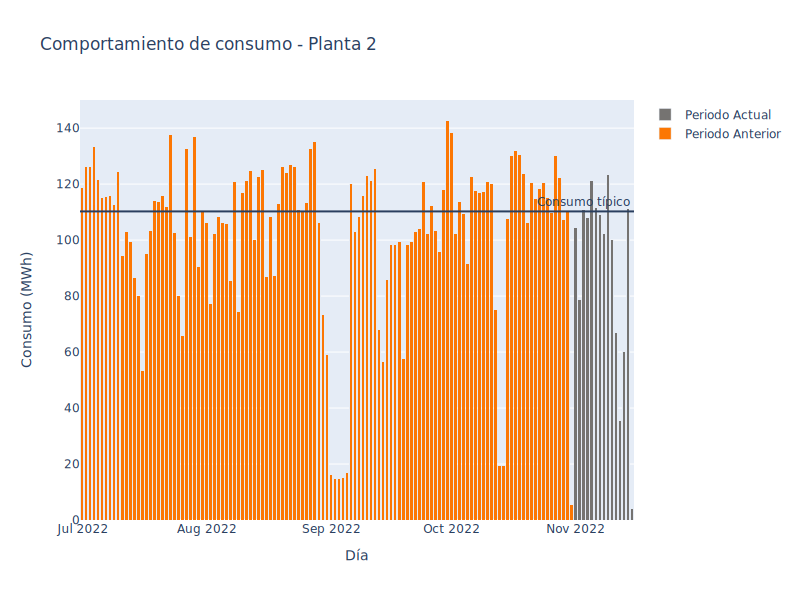

In [357]:
Esenttia_planta_2_bl_diaria = Esenttia_planta_2_bl.resample('D').sum().sort_values(by='timestamp', ascending=True).reset_index()
Esenttia_planta_2_sp_diaria = Esenttia_planta_2_sp.resample('D').sum().sort_values(by='timestamp', ascending=True).reset_index()
Esenttia_planta_2_historico_diaria = planta_2_historico.resample('D').sum().sort_values(by='timestamp', ascending=True).reset_index()

fig = go.Figure(data=[
    go.Bar(name='Periodo Anterior', x=Esenttia_planta_2_historico_diaria['timestamp'], y=Esenttia_planta_2_historico_diaria['Consumo (MWh)']),
    go.Bar(name='Periodo Actual', x=Esenttia_planta_2_sp_diaria['timestamp'], y=Esenttia_planta_2_sp_diaria['Consumo (MWh)']),
    

])

Planta2_LB=Esenttia_planta_2_historico_diaria ['Consumo (MWh)'].median()

fig.add_hline(y=Planta2_LB, annotation_text=" Consumo típico")
fig.update_layout(barmode='stack', title='Comportamiento de consumo - Planta 2', width=800, height=600, colorway=['#fc7703', '#757371'], xaxis_title="Día", yaxis_title="Consumo (MWh)")
fig.show()

In [358]:
md("A continuación, presentamos la desagregación del consumo general de planta 2, donde se aprecian los principales usos significativos de la energía, USE’s: ")

A continuación, presentamos la desagregación del consumo general de planta 2, donde se aprecian los principales usos significativos de la energía, USE’s: 

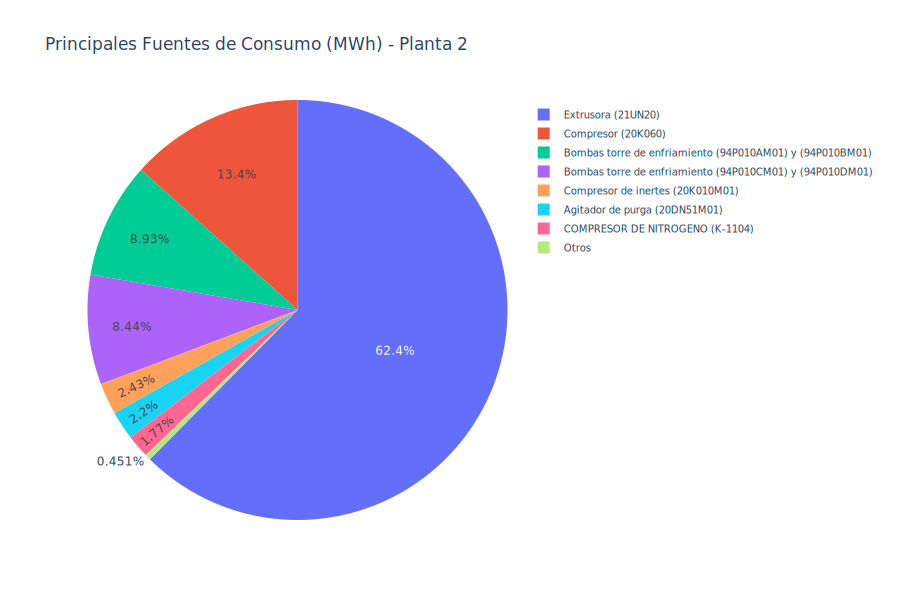

In [359]:
fig = px.pie(Esenttia_planta2_sp_grouped_pie_chart, values='Consumo (MWh)', names='Máquina', title='Principales Fuentes de Consumo (MWh) -  Planta 2', width=(900), height=600)
fig.update_layout(showlegend=True, legend=dict(font=dict(size=10)))
fig.show()

In [360]:
Esenttia_planta2_sp_grouped_pie_chart.round(2)

Máquina  Consumo (MWh)  %_equivalente  %_Acumulado  Cantidad horas de operación
0                                        Extrusora (21UN20)         920.86          62.41        62.41                        360.0
1                                        Compresor (20K060)         197.33          13.37        75.78                        353.0
2  Bombas torre de enfriamiento (94P010AM01) y (94P010BM01)         131.76           8.93        84.71                        360.0
3  Bombas torre de enfriamiento (94P010CM01) y (94P010DM01)         124.49           8.44        93.14                        360.0
4                          Compresor de inertes (20K010M01)          35.89           2.43        95.58                        350.0
5                             Agitador de purga (20DN51M01)          32.48           2.20        97.78                        289.0
6                           COMPRESOR DE NITROGENO (K-1104)          26.13           1.77        99.55                        281.0
7                                                     Otros           6.65           0.45       100.00                          NaN

In [361]:
md(f"Así mismo, al verificar el consumo por proceso, observamos lo siguiente: ")

Así mismo, al verificar el consumo por proceso, observamos lo siguiente: 

In [362]:
planta_2_complete_Reacción = planta_2_complete[planta_2_complete['Proceso']=='Reacción']
planta_2_complete_Almacenamiento_MP = planta_2_complete[planta_2_complete['Proceso']=='Almacenamiento MP']
planta_2_complete_Servicios = planta_2_complete[planta_2_complete['Proceso']=='Servicios']

planta_2_complete_Peletizado = planta_2_complete[planta_2_complete['Proceso']=='Peletizado']
planta_2_complete_Recuperación = planta_2_complete[planta_2_complete['Proceso']=='Recuperación']


planta_2_complete_Reacción_diario = planta_2_complete_Reacción.resample('D').sum().sort_values(by='timestamp', ascending=True).reset_index()
planta_2_complete_Almacenamiento_MP_diario = planta_2_complete_Almacenamiento_MP.resample('D').sum().sort_values(by='timestamp', ascending=True).reset_index()
planta_2_complete_Servicios_diario = planta_2_complete_Servicios.resample('D').sum().sort_values(by='timestamp', ascending=True).reset_index()
planta_2_complete_Peletizado_diario = planta_2_complete_Peletizado.resample('D').sum().sort_values(by='timestamp', ascending=True).reset_index()
planta_2_complete_Recuperación_diario = planta_2_complete_Recuperación.resample('D').sum().sort_values(by='timestamp', ascending=True).reset_index()

In [363]:
Esenttia_sp_planta2_grouped_process = Esenttia_planta2.groupby(['Proceso']).sum().sort_values(by='Consumo (MWh)', ascending=False)
Esenttia_sp_planta2_grouped_process.drop(columns=['day','month_year','year','hour'], inplace=True)
Esenttia_sp_planta2_grouped_process['%_equivalente'] = Esenttia_sp_planta2_grouped_process['Consumo (MWh)']/Esenttia_sp_planta2_grouped_process['Consumo (MWh)'].sum()*100
Esenttia_sp_planta2_grouped_process['%_Acumulado'] = Esenttia_sp_planta2_grouped_process['%_equivalente'].cumsum().round(2)
Esenttia_sp_planta2_grouped_process.reset_index(inplace=True)



Esenttia_sp_planta2_grouped_process = Esenttia_sp_planta2_grouped_process[Esenttia_sp_planta2_grouped_process['%_equivalente']>1]


other_row = {'Proceso':'Otros', 'Consumo (MWh)': Esenttia_sp_planta2_grouped_process[Esenttia_sp_planta2_grouped_process['%_equivalente']<1]['Consumo (MWh)'].sum() ,'%_equivalente':(100-Esenttia_sp_grouped_pie_chart['%_equivalente'].round(2).sum()), '%_Acumulado':100}
Esenttia_sp_planta2_grouped_process = Esenttia_sp_planta2_grouped_process.append(other_row, ignore_index=True)





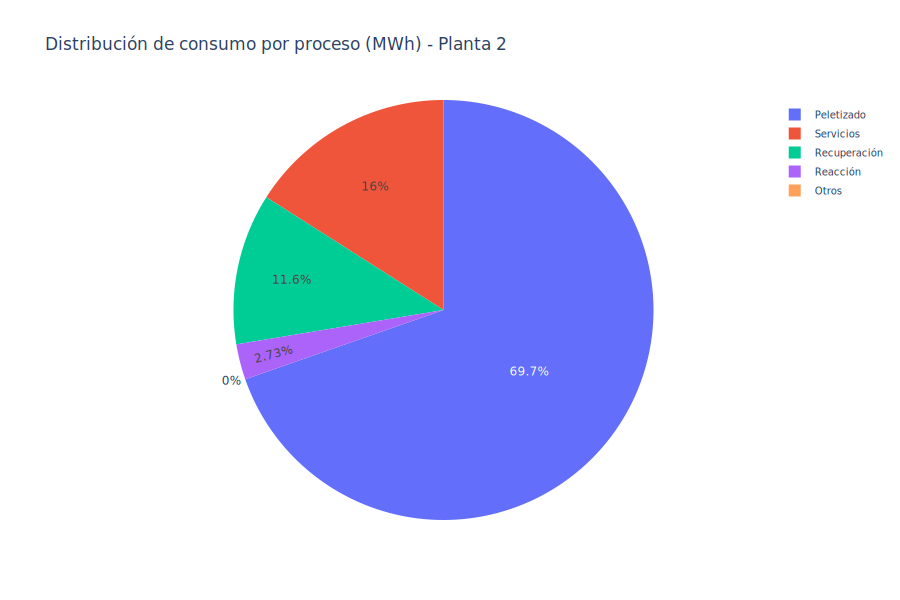

In [364]:
fig = px.pie(Esenttia_sp_planta2_grouped_process, values='Consumo (MWh)', names='Proceso', title='Distribución de consumo por proceso (MWh) -  Planta 2', width=900, height=600)
fig.update_layout(showlegend=True, legend=dict(font=dict(size=10)))

fig.show()

In [365]:
Esenttia_sp_planta2_grouped_process.round(2)

Proceso  Consumo (MWh)  %_equivalente  %_Acumulado
0    Peletizado        9820.18          69.65        69.65
1     Servicios        2252.97          15.98        85.63
2  Recuperación        1640.51          11.64        97.27
3      Reacción         385.59           2.73       100.00
4         Otros           0.00           0.00       100.00

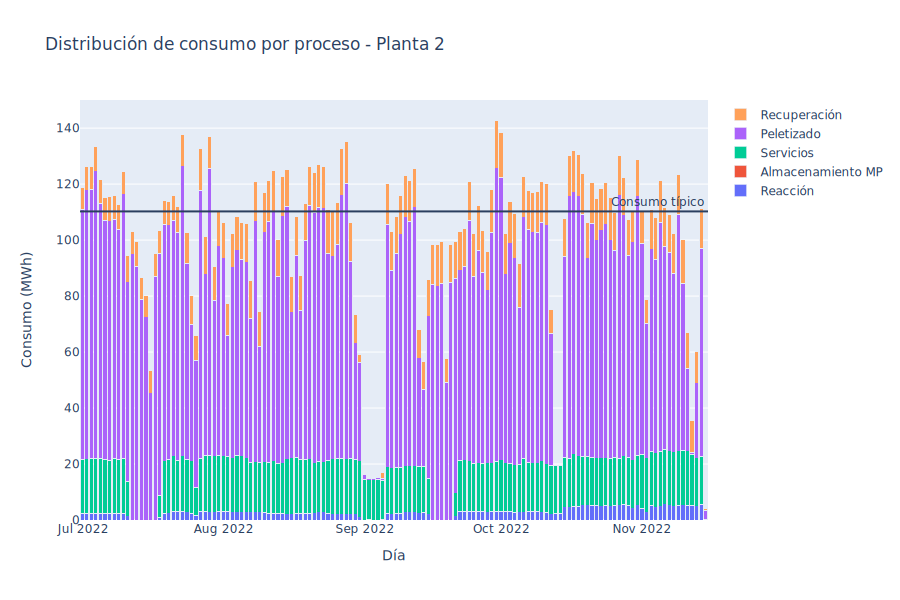

In [366]:
fig = go.Figure(data=[

    go.Bar(name='Reacción', x=planta_2_complete_Reacción_diario['timestamp'], y=planta_2_complete_Reacción_diario['Consumo (MWh)']),
    go.Bar(name='Almacenamiento MP', x=planta_2_complete_Almacenamiento_MP_diario['timestamp'], y=planta_2_complete_Almacenamiento_MP_diario['Consumo (MWh)']),
    go.Bar(name='Servicios', x=planta_2_complete_Servicios_diario['timestamp'], y=planta_2_complete_Servicios_diario['Consumo (MWh)']),
    go.Bar(name='Peletizado', x=planta_2_complete_Peletizado_diario['timestamp'], y=planta_2_complete_Peletizado_diario['Consumo (MWh)']),
    go.Bar(name='Recuperación', x=planta_2_complete_Recuperación_diario['timestamp'], y=planta_2_complete_Recuperación_diario['Consumo (MWh)']),
])
# Change the bar mode
fig.update_layout(barmode='stack', title='Distribución de consumo por proceso -  Planta 2', width=900, height=600, xaxis_title="Día", yaxis_title="Consumo (MWh)")
fig.add_hline(y=Planta2_LB, annotation_text=" Consumo típico")
fig.show()

In [367]:
md(f"Finalmente, en términos de eficiencia de proceso, observamos el siguiente comportamiento díario:")

Finalmente, en términos de eficiencia de proceso, observamos el siguiente comportamiento díario:

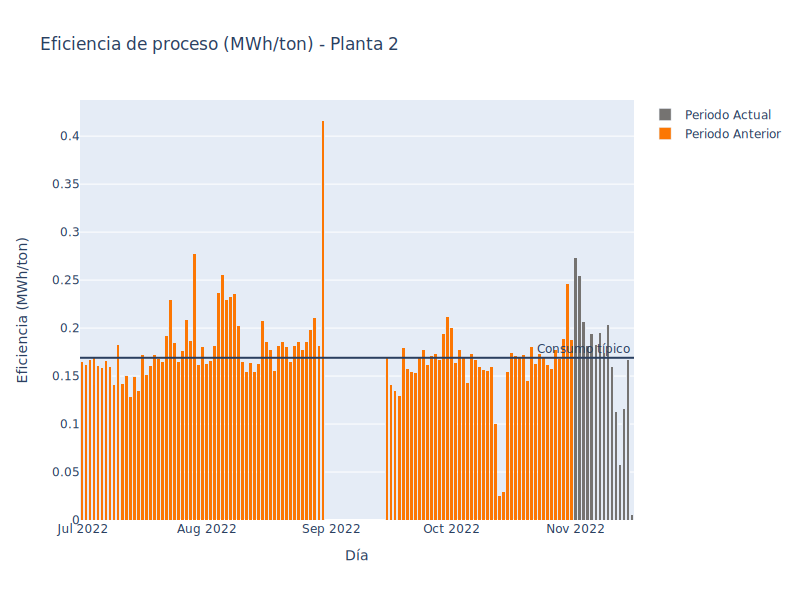

In [368]:
produccion_planta_2_historica = historic_data[historic_data['NAME'].isin(['FIX.MES-P2-REACCION-RATA.F_CV' ])]
produccion_planta_2_historica.drop(columns=['datetime', 'NAME', 'variable', 'load', 'description'], inplace=True)
produccion_planta_2_historica.replace('Bad', np.nan, inplace=True)
produccion_planta_2_historica['Active power'] = produccion_planta_2_historica['Active power'].astype(float)
produccion_planta_2_historica_diaria = produccion_planta_2_historica.resample('D').sum()

planta_2_consumo_total_historico_diario = Esenttia_planta_2_bl_diaria.drop(columns=['month_year', 'day','year','hour'], inplace=False)
planta_2_consumo_total_historico_diario.index = planta_2_consumo_total_historico_diario['timestamp']
planta_2_consumo_total_historico_diario.drop(columns=['timestamp'], inplace=True)

produccion_planta_2_historica_diaria.index.names = ['timestamp']
produccion_planta_2_historica_diaria

planta_2_eficiencia_historica = planta_2_consumo_total_historico_diario.merge(produccion_planta_2_historica_diaria, left_index=True, right_index=True)
planta_2_eficiencia_historica.rename(columns={'Active power': 'Producción (ton)'}, inplace=True)
planta_2_eficiencia_historica['Eficiencia (MWh/ton)'] = planta_2_eficiencia_historica['Consumo (MWh)']/planta_2_eficiencia_historica['Producción (ton)']

planta_2_eficiencia_historica = planta_2_eficiencia_historica[planta_2_eficiencia_historica['Eficiencia (MWh/ton)'].between(0, 1.5)]
planta_2_eficiencia_historica.reset_index(inplace=True)
planta_2_eficiencia_historica = planta_2_eficiencia_historica[planta_2_eficiencia_historica.timestamp != '2022-11-01']


produccion_planta_2_sp_p2 = historico_produccion_p2[historico_produccion_p2['name']=='FIX.MES-P2-REACCION-RATA.F_CV']
produccion_planta_2_sp_p2.drop(columns=['name'], inplace=True)
produccion_planta_2_sp_p2.rename(columns={'value': 'FIX.MES-P2-REACCION-RATA.F_CV'}, inplace=True)
produccion_planta_2_sp_p2.index.names = ['timestamp']

produccion_planta_2_sp = produccion_planta_2_sp_p2
produccion_planta_2_sp.replace('Bad', np.nan, inplace=True)
produccion_planta_2_sp = produccion_planta_2_sp.astype(float)

produccion_planta_2_sp['Producción (ton)'] = produccion_planta_2_sp['FIX.MES-P2-REACCION-RATA.F_CV']
produccion_planta_2_sp.drop(columns=['FIX.MES-P2-REACCION-RATA.F_CV'], inplace=True)
produccion_planta_2_sp_diaria = produccion_planta_2_sp.resample('D').sum()

consumo_planta_2_sp = Esenttia_planta_2_sp_diaria.drop(columns=['month_year', 'day','year','hour'], inplace=False)
consumo_planta_2_sp.index = consumo_planta_2_sp['timestamp']
consumo_planta_2_sp.drop(columns=['timestamp'], inplace=True)

produccion_planta_2_sp_diaria =produccion_planta_2_sp_diaria.merge(consumo_planta_2_sp, left_index=True, right_index=True)

produccion_planta_2_sp_diaria['Eficiencia (MWh/ton)'] = produccion_planta_2_sp_diaria['Consumo (MWh)']/produccion_planta_2_sp_diaria['Producción (ton)']
produccion_planta_2_sp_diaria.reset_index(inplace=True)

planta_2_eficiencia_total = pd.concat([planta_2_eficiencia_historica,produccion_planta_2_sp_diaria], axis=0)
planta_2_eficiencia_total['periodo'] = np.where((planta_2_eficiencia_total['timestamp'] >= datetime.strptime(periodo_historico[0], "%Y-%m-%d")) & (planta_2_eficiencia_total['timestamp'] <= datetime.strptime(periodo_historico[1], "%Y-%m-%d")), 'Baseline', 'Estudio')

planta_2_eficiencia_total_LB = planta_2_eficiencia_total.loc[(planta_2_eficiencia_total['periodo']=="Baseline") & (planta_2_eficiencia_total['Eficiencia (MWh/ton)'].between(planta_2_eficiencia_total['Eficiencia (MWh/ton)'].quantile(.05),planta_2_eficiencia_total['Eficiencia (MWh/ton)'].quantile(.95)))]['Eficiencia (MWh/ton)'].median()

fig = go.Figure(data=[
    go.Bar(name='Periodo Anterior', x=planta_2_eficiencia_historica['timestamp'], y=planta_2_eficiencia_historica['Eficiencia (MWh/ton)']),
    go.Bar(name='Periodo Actual', x=produccion_planta_2_sp_diaria['timestamp'], y=produccion_planta_2_sp_diaria['Eficiencia (MWh/ton)'])
])
fig.add_hline(y=planta_2_eficiencia_total_LB, annotation_text=" Consumo típico" )

fig.update_layout(barmode='stack', title='Eficiencia de proceso (MWh/ton) - Planta 2', width=800, height=600, colorway=['#fc7703', '#757371'], xaxis_title="Día", yaxis_title="Eficiencia (MWh/ton)")


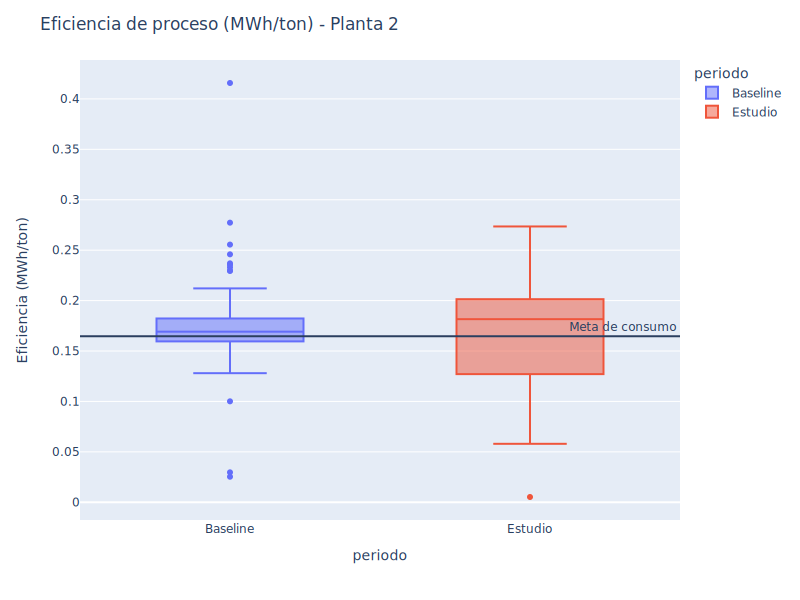

In [369]:
planta_2_eficiencia_total_LB = planta_2_eficiencia_total.loc[(planta_2_eficiencia_total['periodo']=="Baseline") & (planta_2_eficiencia_total['Eficiencia (MWh/ton)'].between(planta_2_eficiencia_total['Eficiencia (MWh/ton)'].quantile(.25),planta_2_eficiencia_total['Eficiencia (MWh/ton)'].quantile(.5)))]['Eficiencia (MWh/ton)'].mean()

fig = px.box(planta_2_eficiencia_total, x="periodo", y="Eficiencia (MWh/ton)", color="periodo")
fig.add_hline(y=planta_2_eficiencia_total_LB, annotation_text=" Meta de consumo")
fig.update_layout( title='Eficiencia de proceso (MWh/ton) - Planta 2', width=800, height=600, colorway=['#fc7703', '#757371'], yaxis_title="Eficiencia (MWh/ton)")
fig.show()

In [370]:
md(f"Ahora, observemos el comportamiento por Máquina")

Ahora, observemos el comportamiento por Máquina

## Análisis por máquina - Planta 1

### Bomba de Etileno (G-0259) y Compresor de Nitrógeno (K-1102)

In [371]:
G_0259 = Esenttia[Esenttia['Máquina'] == 'Bomba de Etileno (G-0259) y Compresor de Nitrógeno (K-1102)']
G_0259_historico = Esenttia_historico[Esenttia_historico['Máquina'] == 'Bomba de Etileno (G-0259) y Compresor de Nitrógeno (K-1102)']


mask_bl = (G_0259_historico['timestamp'] > periodo_historico[0]) & (G_0259_historico['timestamp'] <= periodo_historico[1])
G_0259_bl = G_0259_historico.loc[mask_bl]

mask_sp = (G_0259['timestamp'] >= periodo_de_estudio[0]) & (G_0259['timestamp'] <= periodo_de_estudio[1])
G_0259_sp = G_0259.loc[mask_sp]

G_0259_sp.replace(0, np.nan, inplace=True)
G_0259_bl.replace(0, np.nan, inplace=True)


G_0259_complete = pd.concat([G_0259_sp,G_0259_bl], axis=0)


G_0259_complete['periodo'] = np.where((G_0259_complete['timestamp'] >= datetime.strptime(periodo_historico[0], "%Y-%m-%d")) & (G_0259_complete['timestamp'] <= datetime.strptime(periodo_historico[1], "%Y-%m-%d")), 'Baseline', 'Estudio')

md(f"Durante el periodo de estudio, el consumo total fue de {G_0259_sp['Consumo (MWh)'].sum().round(2)} MWh")

Durante el periodo de estudio, el consumo total fue de 8.01 MWh

In [372]:
md(f"El consumo por día para la Bomba de Etileno (G-0259) y el Compresor de Nitrógeno (K-1102) puede ser observado en la siguiente gráfica:")

El consumo por día para la Bomba de Etileno (G-0259) y el Compresor de Nitrógeno (K-1102) puede ser observado en la siguiente gráfica:

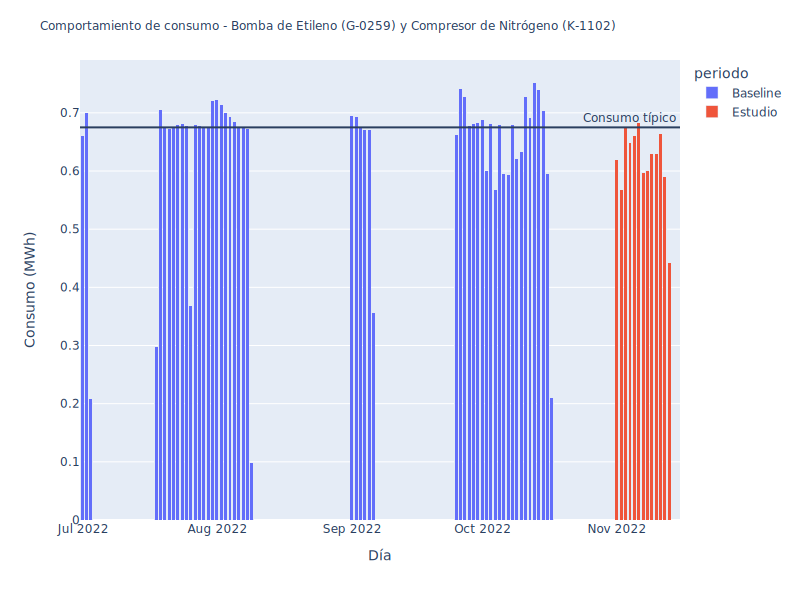

In [373]:
G_0259_diario = G_0259_complete.resample('D').sum().sort_values(by='timestamp', ascending=True).reset_index()
G_0259_diario.replace(0, np.nan, inplace=True)
G_0259_diario['periodo'] = np.where((G_0259_diario['timestamp'] >= datetime.strptime(periodo_historico[0], "%Y-%m-%d")) & (G_0259_diario['timestamp'] <= datetime.strptime(periodo_historico[1], "%Y-%m-%d")), 'Baseline', 'Estudio')


fig = px.bar(G_0259_diario, x="timestamp", y="Consumo (MWh)", color="periodo")

G_0259_diario_LB=G_0259_diario ['Consumo (MWh)'].median()
fig.add_hline(y=G_0259_diario_LB, annotation_text=" Consumo típico")

fig.update_layout(barmode='stack', title='Comportamiento de consumo - Bomba de Etileno (G-0259) y Compresor de Nitrógeno (K-1102)', width=800, height=600, colorway=['#fc7703', '#757371'], xaxis_title="Día", yaxis_title="Consumo (MWh)", title_font_size=12)
fig.show()

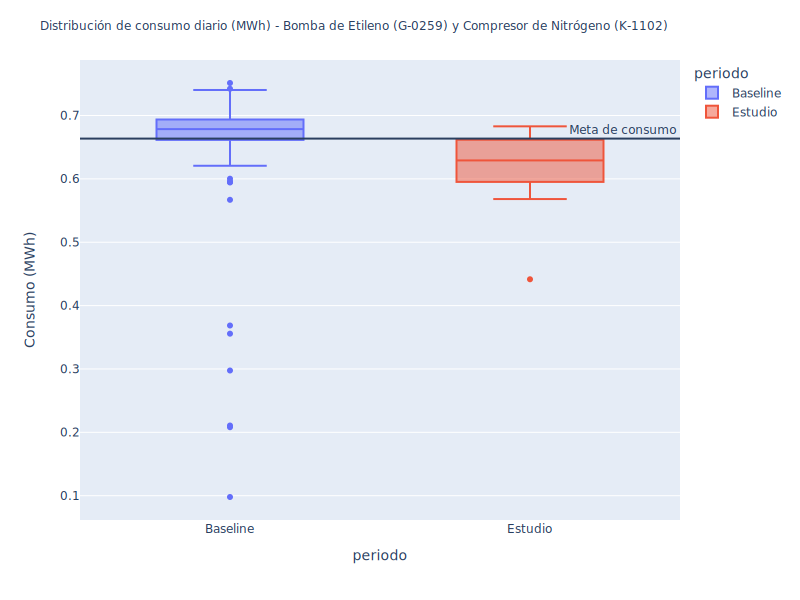

In [374]:
G_0259_LB = G_0259_diario.loc[(G_0259_diario['periodo']=="Baseline") & (G_0259_diario['Consumo (MWh)'].between(G_0259_diario['Consumo (MWh)'].quantile(.25),G_0259_diario['Consumo (MWh)'].quantile(.5)))]['Consumo (MWh)'].mean()

fig = px.box(G_0259_diario, x="periodo", y="Consumo (MWh)", color="periodo")
fig.add_hline(y=G_0259_LB, annotation_text=" Meta de consumo")
fig.update_layout( title='Distribución de consumo diario (MWh) - Bomba de Etileno (G-0259) y Compresor de Nitrógeno (K-1102)', width=800, height=600, colorway=['#fc7703', '#757371'], yaxis_title="Consumo (MWh)", title_font_size=12)
fig.show()


### Compresor Reactor 1 (K-4003)

In [375]:
K_4003 = Esenttia[Esenttia['Máquina'] == 'Compresor Reactor 1 (K-4003)']
K_4003_historico = Esenttia_historico[Esenttia_historico['Máquina'] == 'Compresor Reactor 1 (K-4003)']


mask_bl = (K_4003_historico['timestamp'] > periodo_historico[0]) & (K_4003_historico['timestamp'] <= periodo_historico[1])
K_4003_bl = K_4003_historico.loc[mask_bl]

mask_sp = (K_4003['timestamp'] >= periodo_de_estudio[0]) & (K_4003['timestamp'] <= periodo_de_estudio[1])
K_4003_sp = K_4003.loc[mask_sp]

K_4003_sp.replace(0, np.nan, inplace=True)
K_4003_bl.replace(0, np.nan, inplace=True)

K_4003_complete = pd.concat([K_4003_sp,K_4003_bl], axis=0)


K_4003_complete['periodo'] = np.where((K_4003_complete['timestamp'] >= datetime.strptime(periodo_historico[0], "%Y-%m-%d")) & (K_4003_complete['timestamp'] <= datetime.strptime(periodo_historico[1], "%Y-%m-%d")), 'Baseline', 'Estudio')



md(f"Durante el periodo de estudio, el consumo total fue de {K_4003_sp['Consumo (MWh)'].sum().round(2)} MWh")

Durante el periodo de estudio, el consumo total fue de 247.1 MWh

In [376]:
md(f"El consumo por día del Compresor Reactor 1 (K-4003) puede ser observado en la siguiente gráfica:")

El consumo por día del Compresor Reactor 1 (K-4003) puede ser observado en la siguiente gráfica:

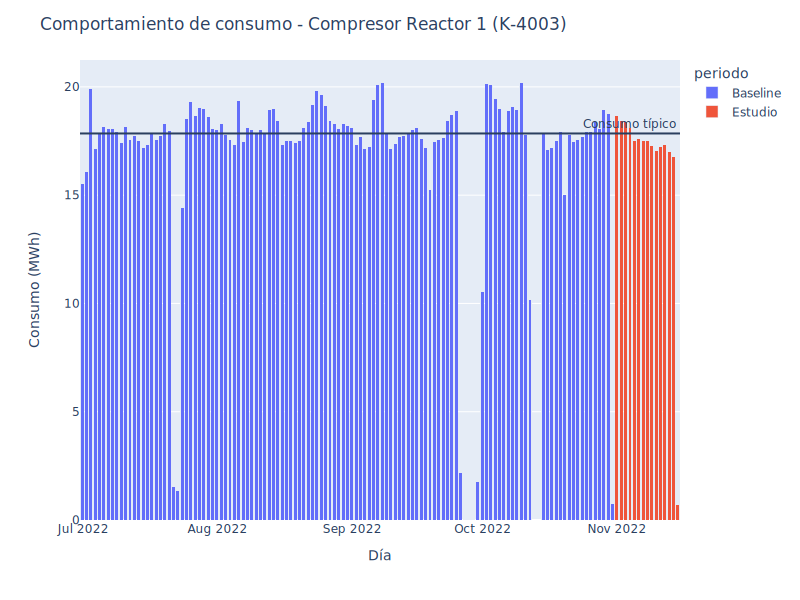

In [377]:
K_4003_diario = K_4003_complete.resample('D').sum().sort_values(by='timestamp', ascending=True).reset_index()
K_4003_diario.replace(0, np.nan, inplace=True)
K_4003_diario['periodo'] = np.where((K_4003_diario['timestamp'] >= datetime.strptime(periodo_historico[0], "%Y-%m-%d")) & (K_4003_diario['timestamp'] <= datetime.strptime(periodo_historico[1], "%Y-%m-%d")), 'Baseline', 'Estudio')

K_4003_diario_LB=K_4003_diario['Consumo (MWh)'].median()

fig = px.bar(K_4003_diario, x="timestamp", y="Consumo (MWh)", color="periodo")
fig.update_layout(barmode='stack', title='Comportamiento de consumo - Compresor Reactor 1 (K-4003)', width=800, height=600, colorway=[ '#757371', '#fc7703'], xaxis_title="Día", yaxis_title="Consumo (MWh)")
fig.add_hline(y=K_4003_diario_LB, annotation_text=" Consumo típico")
fig.show()

In [378]:


K_4003_complete = pd.DataFrame()
K_4003_historico_complete = pd.DataFrame()

Tags_K4003  = ['FIX.AI-400114.F_CV','FIX.AI-400115.F_CV','FIX.AI-400116B.F_CV','FIX.AI-400117B.F_CV','FIX.AI-400118.F_CV','FIX.AI-400119.F_CV','FIX.APC-CGDENS1.F_CV','FIX.APC-CGFLO1M1.F_CV','FIX.FI-40021.F_CV','FIX.FIC-40015.F_CV','FIX.FIC-40015A-OUT.F_CV','FIX.JI-40032.F_CV','FIX.P1-TI-4002-4.F_CV','FIX.PDI-40022.F_CV','FIX.PDI-40031.F_CV','FIX.PDI-40036.F_CV','FIX.PIC-400130.F_CV','FIX.TI-40023.F_CV','FIX.TI-40035.F_CV', 'FIX.APC-FILTPR1.F_CV' ]


K_4003_complete = data[Tags_K4003].astype(float)
K_4003_historico_complete = historic_data.loc[historic_data['NAME'].isin(Tags_K4003)].drop('datetime', axis=1)


K_4003_historico_complete = K_4003_historico_complete.pivot_table(index='datetime', columns='NAME', values='Active power', aggfunc='mean')




K_4003_complete['Carga térmica (MWh)'] = ((K_4003_complete['FIX.P1-TI-4002-4.F_CV'] - K_4003_complete['FIX.TI-40023.F_CV'])*4.18*K_4003_complete['FIX.FI-40021.F_CV'] /3600)
K_4003_complete['KPI (MW KWh/kg)'] = K_4003_complete['FIX.JI-40032.F_CV'] / K_4003_complete['FIX.APC-CGFLO1M1.F_CV']


K_4003_historico_complete['Carga térmica (MWh)'] = ((K_4003_historico_complete['FIX.P1-TI-4002-4.F_CV'] - K_4003_historico_complete['FIX.TI-40023.F_CV'])*4.18*K_4003_historico_complete['FIX.FI-40021.F_CV'] /3600)
K_4003_historico_complete['KPI (MW KWh/kg)'] = K_4003_historico_complete['FIX.JI-40032.F_CV'] / K_4003_historico_complete['FIX.APC-CGFLO1M1.F_CV']


K_4003_complete = K_4003_complete[K_4003_complete['KPI (MW KWh/kg)'].between(K_4003_complete['KPI (MW KWh/kg)'].quantile(.05),K_4003_complete['KPI (MW KWh/kg)'].quantile(.95) ) ]
K_4003_complete = K_4003_complete[K_4003_complete['FIX.APC-CGFLO1M1.F_CV'].between(K_4003_complete['FIX.APC-CGFLO1M1.F_CV'].quantile(.05),K_4003_complete['FIX.APC-CGFLO1M1.F_CV'].quantile(.95) ) ]
K_4003_historico_complete = K_4003_historico_complete[K_4003_historico_complete['KPI (MW KWh/kg)'].between(K_4003_historico_complete['KPI (MW KWh/kg)'].quantile(.05),K_4003_historico_complete['KPI (MW KWh/kg)'].quantile(.95) ) ]
K_4003_historico_complete = K_4003_historico_complete[K_4003_historico_complete['FIX.APC-CGFLO1M1.F_CV'].between(K_4003_historico_complete['FIX.APC-CGFLO1M1.F_CV'].quantile(.05),K_4003_historico_complete['FIX.APC-CGFLO1M1.F_CV'].quantile(.95) ) ]



K_4003_complete['timestamp'] = pd.to_datetime(K_4003_complete.index)
K_4003_historico_complete['timestamp'] = pd.to_datetime(K_4003_historico_complete.index)


K_4003_complete['periodo'] = np.where((K_4003_complete['timestamp'] > datetime.strptime(periodo_historico[0], "%Y-%m-%d")) & (K_4003_complete['timestamp'] <= datetime.strptime(periodo_historico[1], "%Y-%m-%d")), 'Baseline', 'Estudio')
K_4003_historico_complete['periodo'] = np.where((K_4003_historico_complete['timestamp'] > datetime.strptime(periodo_historico[0], "%Y-%m-%d")) & (K_4003_historico_complete['timestamp'] <= datetime.strptime(periodo_historico[1], "%Y-%m-%d")), 'Baseline', 'Estudio')

K_4003_complete_sp = K_4003_complete[K_4003_complete['periodo']=='Estudio']


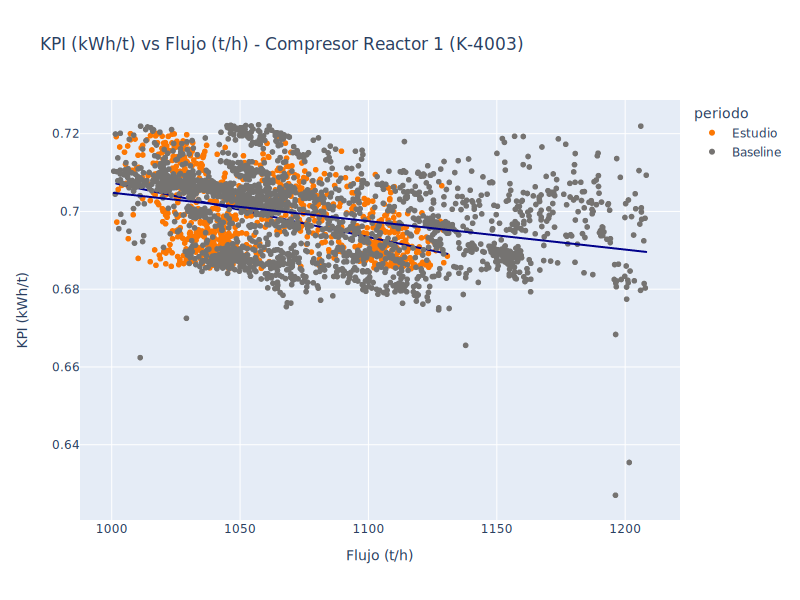

AIC Periodo de estudio -12722.07704870767
AIC Periodo Anterior -7231.003350099572
R^2 Periodo de estudio 0.10856183552466303
R^2 Periodo Anterior 0.2086609702654535
MSE Periodo de estudio 0.00011620583468708809
MSE Periodo Anterior 9.643489131738481e-05


In [379]:
K_4003_complete_scatter = pd.concat([K_4003_complete_sp,K_4003_historico_complete], axis = 0)



fig = px.scatter(K_4003_complete_scatter, x=K_4003_complete_scatter['FIX.APC-CGFLO1M1.F_CV'], y=K_4003_complete_scatter['KPI (MW KWh/kg)'], color='periodo', trendline="ols", trendline_color_override="darkblue", title=' KPI (kWh/t) vs Flujo (t/h) - Compresor Reactor 1 (K-4003)', width=800,
 height=600, color_discrete_map={'Baseline': '#757371', 'Estudio': '#fc7703'}, labels={'FIX.APC-CGFLO1M1.F_CV': 'Flujo (t/h)', 'KPI (MW KWh/kg)': 'KPI (kWh/t)'})
fig.show()

print('AIC Periodo de estudio',px.get_trendline_results(fig)['px_fit_results'][1].aic)
print('AIC Periodo Anterior',px.get_trendline_results(fig)['px_fit_results'][0].aic)


print('R^2 Periodo de estudio',px.get_trendline_results(fig)['px_fit_results'][1].rsquared)
print('R^2 Periodo Anterior',px.get_trendline_results(fig)['px_fit_results'][0].rsquared)

print('MSE Periodo de estudio',px.get_trendline_results(fig)['px_fit_results'][1].mse_total)
print('MSE Periodo Anterior',px.get_trendline_results(fig)['px_fit_results'][0].mse_total)

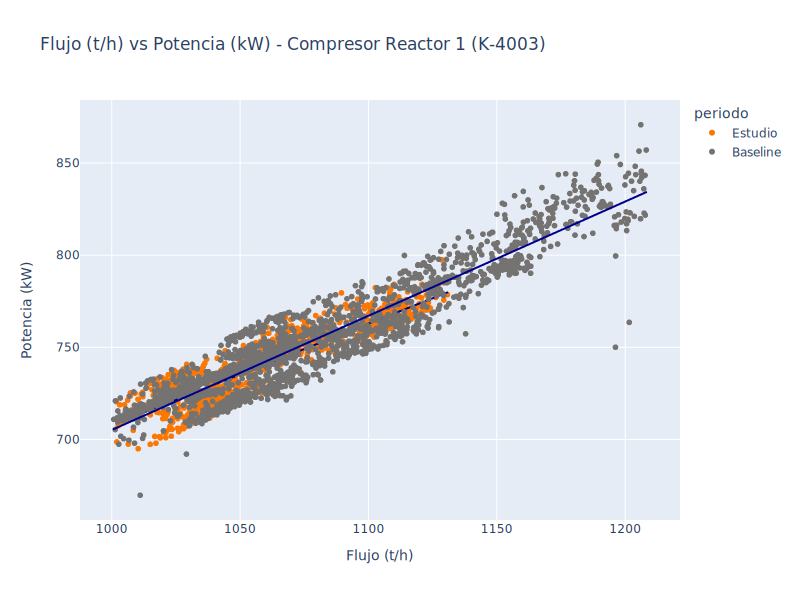

AIC Periodo de estudio 15349.953736612664
AIC Periodo Anterior 7892.800672481451
R^2 Periodo de estudio 0.8810848138101995
R^2 Periodo Anterior 0.7915268845235989
MSE Periodo de estudio 1026.9752045114228
MSE Periodo Anterior 393.4935082380348


In [380]:
fig = px.scatter(K_4003_complete_scatter, y=K_4003_complete_scatter['FIX.JI-40032.F_CV'], x=K_4003_complete_scatter['FIX.APC-CGFLO1M1.F_CV'], color='periodo', trendline="ols", trendline_color_override="darkblue", title='Flujo (t/h) vs Potencia (kW) - Compresor Reactor 1 (K-4003)', width=800,
 height=600, color_discrete_map={'Baseline': '#757371', 'Estudio': '#fc7703'}, labels={'FIX.JI-40032.F_CV': 'Potencia (kW)', 'FIX.APC-CGFLO1M1.F_CV': 'Flujo (t/h)'})
fig.show()

print('AIC Periodo de estudio',px.get_trendline_results(fig)['px_fit_results'][1].aic)
print('AIC Periodo Anterior',px.get_trendline_results(fig)['px_fit_results'][0].aic)


print('R^2 Periodo de estudio',px.get_trendline_results(fig)['px_fit_results'][1].rsquared)
print('R^2 Periodo Anterior',px.get_trendline_results(fig)['px_fit_results'][0].rsquared)

print('MSE Periodo de estudio',px.get_trendline_results(fig)['px_fit_results'][1].mse_total)
print('MSE Periodo Anterior',px.get_trendline_results(fig)['px_fit_results'][0].mse_total)

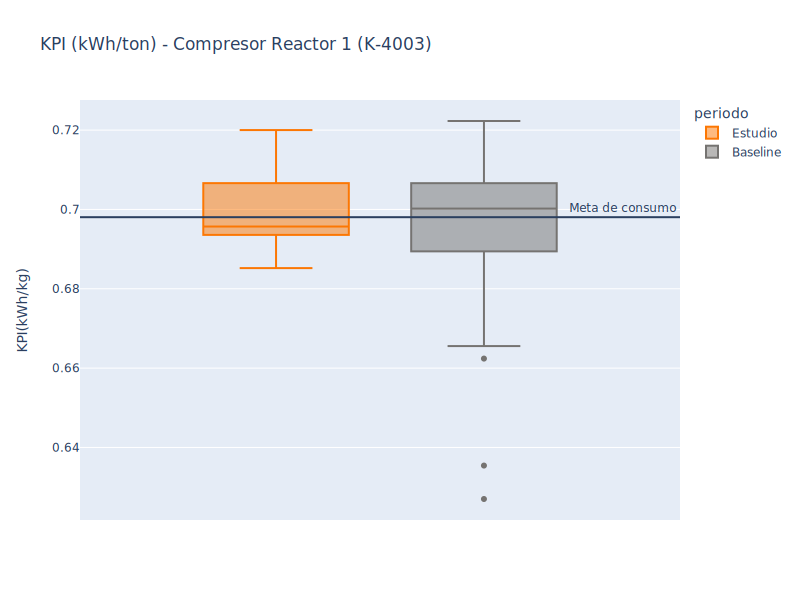

In [381]:



fig = px.box(K_4003_complete_scatter, y=K_4003_complete_scatter['KPI (MW KWh/kg)'], color='periodo',  title='KPI (kWh/ton) - Compresor Reactor 1 (K-4003)', width=800,
 height=600, color_discrete_map={'Baseline': '#757371', 'Estudio': '#fc7703'}, labels={'KPI (MW KWh/kg)': 'KPI (kWh/kg)'})


K_4003_complete_scatter_baseline = K_4003_complete_scatter[K_4003_complete_scatter['periodo']=='Baseline']
fig.add_hline(y=K_4003_complete_scatter_baseline[K_4003_complete_scatter_baseline['KPI (MW KWh/kg)'].between(K_4003_complete_scatter_baseline['KPI (MW KWh/kg)'].quantile(.3),K_4003_complete_scatter_baseline['KPI (MW KWh/kg)'].quantile(.6))]['KPI (MW KWh/kg)'].mean(), annotation_text=" Meta de consumo")
    
fig.update_layout( yaxis_title="KPI(kWh/kg)")
fig.show()

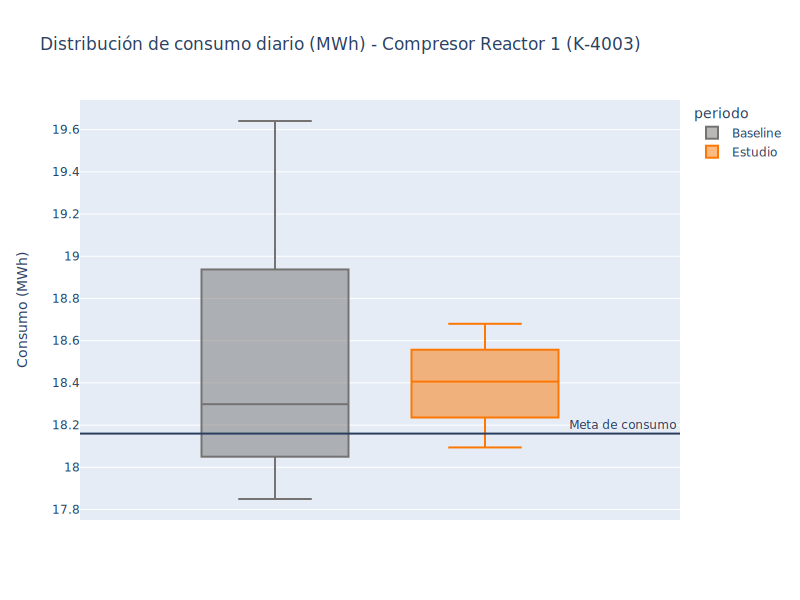

In [382]:

K_4003_diario = K_4003_diario[K_4003_diario['Consumo (MWh)'].between(K_4003_diario['Consumo (MWh)'].quantile(.5),K_4003_diario['Consumo (MWh)'].quantile(.95))]
fig = px.box(K_4003_diario, y=K_4003_diario['Consumo (MWh)'], color='periodo',  title='Distribución de consumo diario (MWh) - Compresor Reactor 1 (K-4003)', width=800,
 height=600, color_discrete_map={'Baseline': '#757371', 'Estudio': '#fc7703'}, labels={'FIX.JI-40032.F_CV': 'Potencia (kW)'})


fig.add_hline(y=K_4003_diario[K_4003_diario['Consumo (MWh)'].between(K_4003_diario['Consumo (MWh)'].quantile(.25),K_4003_diario['Consumo (MWh)'].quantile(.5))]['Consumo (MWh)'].mean(), annotation_text=" Meta de consumo")
    

fig.show()

#### Modelación Analitica

R^2 medio 0.9381947651551752
Error cuadratico medio sobre el conjunto de Test: 55.38 kW


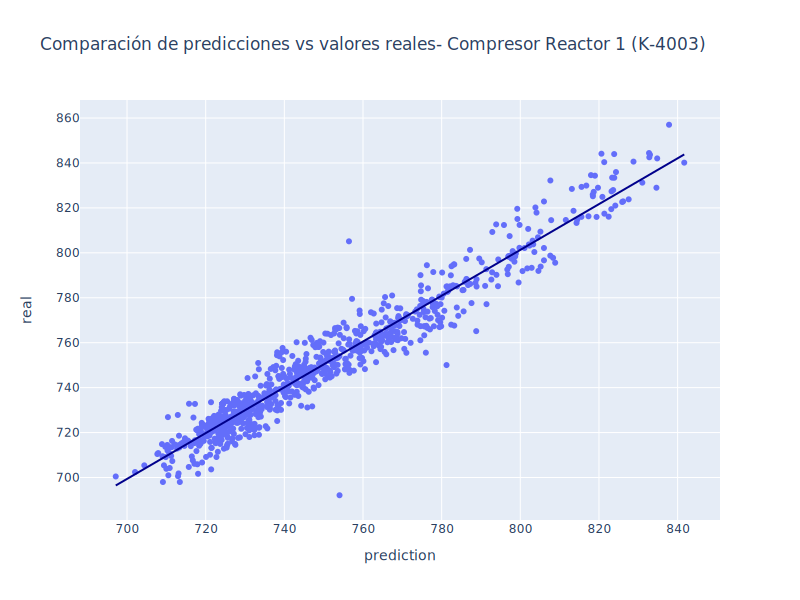

A continuación se pueden observar los pesos de cada variable en el modelo, estos nos sirven para identificar las variables claves que afectan el consumo del compresor:


Peso
Temp salida H2O E-4002 (F_CV)                    176.33
Rx1 Cycle Gas Flow (F_CV)                        111.30
Rx1 Cycle Gas Density (F_CV)                      81.77
Rx2 Filt Final Production Rate (F_CV)             59.65
Rx1 Cycle Gas N2 (F_CV)                           56.96
Rx1 Cycle Gas H2 (F_CV)                           54.75
Rx1 Cooler DP (F_CV)                              27.38
Rx1 Compressor DP (F_CV)                          17.94
Rx1 Cycle Gas C2H4 (F_CV)                         -1.61
Rx1 Cycle Gas C2H6 (F_CV)                         -2.57
Rx1 Compressor Discharge Temperature (F_CV)       -4.31
Rx1 Cycle Water Flow (F_CV)                      -26.14
Rx1 Cycle Gas Flow (F_CV)                        -55.65
Rx1 Cycle Gas C3H8 (F_CV)                        -64.07
Rx1 Cycle Gas C3H6 (F_CV)                        -65.07
Rx1 Pressure Control (F_CV)                      -99.12
Rx1 Cycle Water Cooler Inlet Temperature (F_CV) -104.79

In [383]:
Feature_Tags_K4003  = ['FIX.AI-400114.F_CV','FIX.AI-400115.F_CV','FIX.AI-400116B.F_CV','FIX.AI-400117B.F_CV','FIX.AI-400118.F_CV','FIX.AI-400119.F_CV',
                       'FIX.APC-CGDENS1.F_CV','FIX.APC-CGFLO1M1.F_CV','FIX.FI-40021.F_CV','FIX.FIC-40015.F_CV','FIX.APC-FILTPR1.F_CV',
                       'FIX.P1-TI-4002-4.F_CV','FIX.PDI-40022.F_CV','FIX.PDI-40036.F_CV','FIX.PIC-400130.F_CV','FIX.TI-40023.F_CV','FIX.TI-40035.F_CV']

Feature_Names_K4003 = ['Rx1 Cycle Gas C2H6 (F_CV)','Rx1 Cycle Gas C3H6 (F_CV)','Rx1 Cycle Gas C2H4 (F_CV)','Rx1 Cycle Gas H2 (F_CV)','Rx1 Cycle Gas N2 (F_CV)','Rx1 Cycle Gas C3H8 (F_CV)','Rx1 Cycle Gas Density (F_CV)','Rx1 Cycle Gas Flow (F_CV)','Rx1 Cycle Water Flow (F_CV)','Rx1 Cycle Gas Flow (F_CV)','Rx2 Filt Final Production Rate (F_CV)','Temp salida H2O E-4002 (F_CV)','Rx1 Cooler DP (F_CV)','Rx1 Compressor DP (F_CV)','Rx1 Pressure Control (F_CV)','Rx1 Cycle Water Cooler Inlet Temperature (F_CV)','Rx1 Compressor Discharge Temperature (F_CV)']

Output_Tags_K4003 = ['FIX.JI-40032.F_CV']


K_4003_complete_features = K_4003_complete_scatter[Feature_Tags_K4003]
K_4003_complete_output = K_4003_complete_scatter[Output_Tags_K4003]

from sklearn import svm
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split

scaler = MinMaxScaler()

X = scaler.fit_transform(K_4003_complete_features)
y = K_4003_complete_output.values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42)



SVR = svm.SVR(kernel='linear', C=1e3, gamma=0.1)
validation = cross_validate(SVR, X_train, y_train, cv=10, scoring='r2', return_estimator=True)
print('R^2 medio',validation['test_score'].mean())




best_estimator = validation['estimator'][np.argmax(validation['test_score'])]


prediction = best_estimator.predict(X_test)

comparison = pd.DataFrame([prediction, y_test.flatten()]).T
comparison.columns = ['prediction', 'real']

MSE = np.mean((prediction - y_test.flatten())**2)
print(f"Error cuadratico medio sobre el conjunto de Test: {MSE.round(2)} kW")

fig = px.scatter(comparison, x=comparison['prediction'], y=comparison['real'], trendline="ols", trendline_color_override="darkblue", title='Comparación de predicciones vs valores reales- Compresor Reactor 1 (K-4003)', width=800,
height=600)
fig.show()

print('A continuación se pueden observar los pesos de cada variable en el modelo, estos nos sirven para identificar las variables claves que afectan el consumo del compresor:')

coeficientes = pd.DataFrame(best_estimator.coef_.T, index=Feature_Names_K4003, columns=['Peso'])
coeficientes.round(2).sort_values(by='Peso', ascending=False)

# print('Los coeficientes del modelo son: ', best_estimator.coef_)
# print('El intercepto del modelo es: ', best_estimator.intercept_)
# print('los nombres de las variables son: ', Feature_Names_K4003)

#### Modelación termodinamica

In [384]:
#%% 


import pyromat as pm
import pandas as pd
import numpy as np
#Entrada de la base de datos (Compresor reactor 1 y 2)
##      

df = K_4003_complete.copy()

In [385]:
Wo = []
Wo_isot = []
Power=[]
nf = []

for i in range(0, len(df)):

    mol_1 = df.iloc[i]['FIX.AI-400114.F_CV']
    mol_1 =    df.iloc[i]['FIX.AI-400114.F_CV']
    mol_2 =     df.iloc[i]['FIX.AI-400115.F_CV']
    mol_3 =     df.iloc[i]['FIX.AI-400116B.F_CV']
    mol_4 =  df.iloc[i]['FIX.AI-400117B.F_CV']
    mol_5 =  df.iloc[i]['FIX.AI-400118.F_CV']
    mol_6 =    df.iloc[i]['FIX.AI-400119.F_CV']
    T2 =   df.iloc[i]['FIX.TI-40035.F_CV']
    P2 = df.iloc[i]['FIX.PIC-400130.F_CV']+1
    DP = df.iloc[i]['FIX.PDI-40036.F_CV']  
    gas =  df.iloc[i]['FIX.APC-CGFLO1M1.F_CV']  
    P_e = df.iloc[i]['FIX.JI-40032.F_CV'] 



    mol_t = mol_1+mol_2+mol_3+mol_4+mol_5+mol_6 

    #Cálculo fracciones molares
    y_1 = mol_1/mol_t
    y_2 = mol_2/mol_t
    y_3 = mol_3/mol_t
    y_4 = mol_4/mol_t
    y_5 = mol_5/mol_t
    y_6 = mol_6/mol_t

    ## Especies químicas 
    e_1 = pm.get('ig.C2H6')
    e_2 = pm.get('ig.C3H6')
    e_3 = pm.get('ig.C2H4')
    e_4 = pm.get('ig.H2')
    e_5 = pm.get('ig.N2')
    e_6 = pm.get('ig.C3H8')

    #Calculo peso molecular de la mezcla
    P_mol = e_1.mw()*y_1+e_2.mw()*y_2+e_3.mw()*y_3+e_4.mw()*y_4+ e_5.mw()*y_5+e_6.mw()*y_6  #KG/Kmol

    #Cálculo de fracciones de masa

    m_1 = e_1.mw()*y_1/P_mol
    m_2 = e_2.mw()*y_2/P_mol
    m_3 = e_3.mw()*y_3/P_mol
    m_4 = e_4.mw()*y_4/P_mol
    m_5 = e_5.mw()*y_5/P_mol
    m_6 = e_6.mw()*y_6/P_mol


    # Corrección de unidades y calculo de supuestos
    n0 = 1.4 # Relación de calores específicos. Valor supuesto y debe ser iterado
    T2 = T2 +273 # Kelvin
    P1 = (P2-DP)*0.98066  # Presión de ingreso a compresor, Bar
    error = 3

    while error > 0.002:
        T1 = T2*(P2/P1)**((1-n0)/n0)  #Temperatura ingreso a compresor, en Kelvin

        #Cálculo de relación de calores específicos (Cp) (KJ/KGK)
        Cp = e_1.cp(T= T1,p=P1)*m_1+e_2.cp(T= T1,p=P1)*m_2+e_3.cp(T=T1,p=P1)*m_3+e_4.cp(T=T1,p=P1)*m_4+e_5.cp(T=T1,p=P1)*m_5+e_6.cp(T=T1,p=P1)*m_6
        
        #Cálculo Cv  (KJ/KGK)
        Cv = e_1.cv(T= T1,p=P1)*m_1+e_2.cv(T= T1,p=P1)*m_2+e_3.cv(T=T1,p=P1)*m_3+e_4.cv(T=T1,p=P1)*m_4+e_5.cv(T=T1,p=P1)*m_5+e_6.cv(T=T1,p=P1)*m_6
        
        #Relación de calores específicos
        n = Cp/Cv
        
        #Constante del gas
        R0 =8.314 # KJ/KmolK  
        R = Cp-Cv  #Constante del gas KJ/kgK
        error = abs(n-n0)
        n0=n

        

    #Trabajo de compresión politrópica
    Z = 1 # factor de compresibilidad de la mezcla. se asume de 1


    
    Wo.append(Z*R*T1*(n/(n-1))*((P2/P1)**((n-1)/n)-1))   # Trabajo politrópico, adiabático KJ/kg
    Wo_isot.append(R*T1*np.log(P2/P1))
    Power.append(Wo[i]*gas/3.6)  # Potencia mínimima; adiabática KW
    nf.append(Power[i]/P_e)

    
pd.concat([df, pd.DataFrame(Wo, columns=['Wo'])], axis=1)
pd.concat([df, pd.DataFrame(Wo_isot, columns=['Wo_isot'])], axis=1)
pd.concat([df, pd.DataFrame(Power, columns=['Power'])], axis=1)
pd.concat([df, pd.DataFrame(nf, columns=['nf'])], axis=1)
print(" ")


### Compresor Reactor 2 (K4303) -- No existe en el Query

### Bomba de propileno area 20 (G-0216) 

In [386]:
G_0216 = Esenttia[Esenttia['Máquina'] == 'Bomba de propileno area 20 (G-0216)']
G_0216_historico = Esenttia_historico[Esenttia_historico['Máquina'] == 'Bomba de propileno area 20 (G-0216)']


mask_bl = (G_0216_historico['timestamp'] > periodo_historico[0]) & (G_0216_historico['timestamp'] <= periodo_historico[1])
G_0216_bl = G_0216_historico.loc[mask_bl]

mask_sp = (G_0216['timestamp'] >= periodo_de_estudio[0]) & (G_0216['timestamp'] <= periodo_de_estudio[1])
G_0216_sp = G_0216.loc[mask_sp]

G_0216_sp.replace(0, np.nan, inplace=True)
G_0216_bl.replace(0, np.nan, inplace=True)


G_0216_complete = pd.concat([G_0216_sp,G_0216_bl], axis=0)


G_0216_complete['periodo'] = np.where((G_0216_complete['timestamp'] >= datetime.strptime(periodo_historico[0], "%Y-%m-%d")) & (G_0216_complete['timestamp'] <= datetime.strptime(periodo_historico[1], "%Y-%m-%d")), 'Baseline', 'Estudio')

md(f"Durante el periodo de estudio, el consumo total fue de {G_0216_sp['Consumo (MWh)'].sum().round(2)} MWh")

Durante el periodo de estudio, el consumo total fue de 23.42 MWh

In [387]:
md(f"El consumo por día para la Bomba de propileno area 20 (G-0216) puede ser observado en la siguiente gráfica:")

El consumo por día para la Bomba de propileno area 20 (G-0216) puede ser observado en la siguiente gráfica:

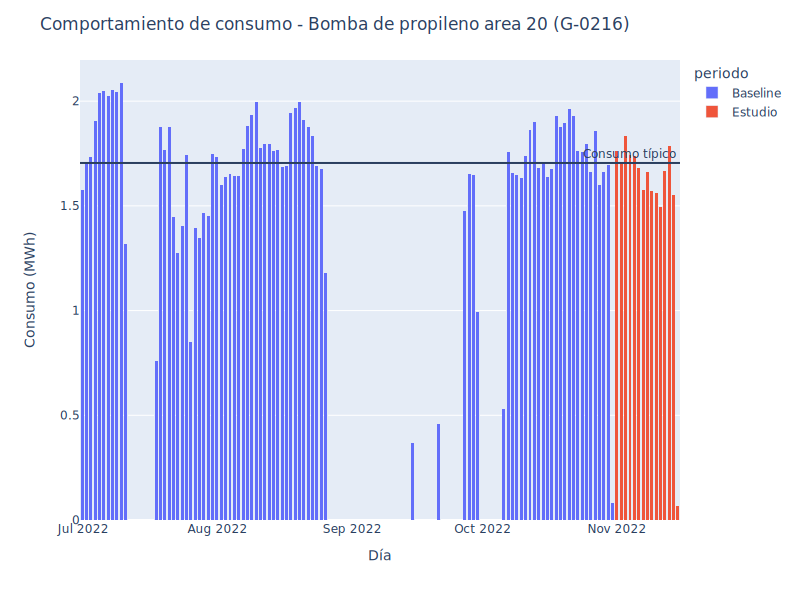

In [388]:
G_0216_diario = G_0216_complete.resample('D').sum().sort_values(by='timestamp', ascending=True).reset_index()
G_0216_diario.replace(0, np.nan, inplace=True)
G_0216_diario['periodo'] = np.where((G_0216_diario['timestamp'] >= datetime.strptime(periodo_historico[0], "%Y-%m-%d")) & (G_0216_diario['timestamp'] <= datetime.strptime(periodo_historico[1], "%Y-%m-%d")), 'Baseline', 'Estudio')


G_0216_diario_LB=G_0216_diario['Consumo (MWh)'].median()

fig = px.bar(G_0216_diario, x="timestamp", y="Consumo (MWh)", color="periodo")
fig.update_layout(barmode='stack', title='Comportamiento de consumo - Bomba de propileno area 20 (G-0216)', width=800, height=600, colorway=['#fc7703', '#757371'], xaxis_title="Día", yaxis_title="Consumo (MWh)")
fig.add_hline(y=G_0216_diario_LB, annotation_text=" Consumo típico")
fig.show()

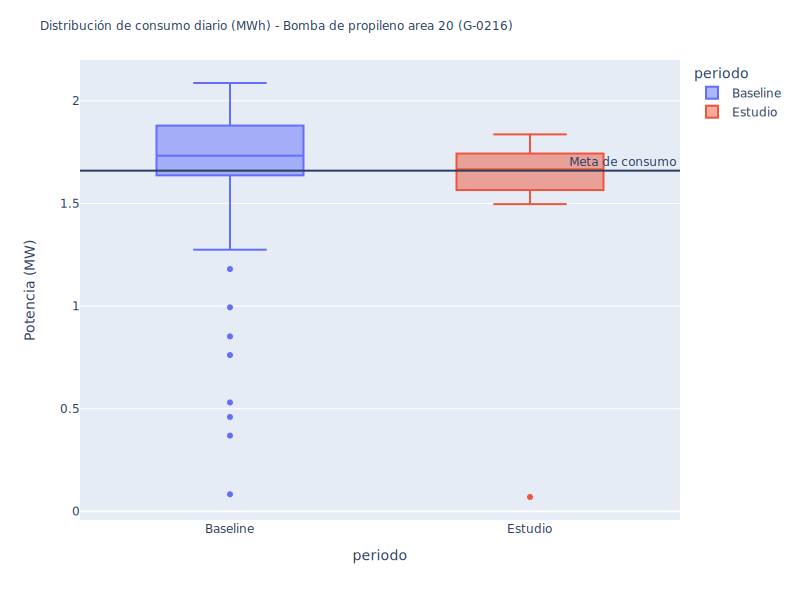

In [389]:
G_0216_LB = G_0216_diario.loc[(G_0216_diario['periodo']=="Baseline") & (G_0216_diario['Consumo (MWh)'].between(G_0216_diario['Consumo (MWh)'].quantile(.25),G_0216_diario['Consumo (MWh)'].quantile(.5)))]['Consumo (MWh)'].mean()

fig = px.box(G_0216_diario, x="periodo", y="Consumo (MWh)", color="periodo")
fig.add_hline(y=G_0216_LB, annotation_text=" Meta de consumo")
fig.update_layout( title='Distribución de consumo diario (MWh) - Bomba de propileno area 20 (G-0216)', width=800, height=600, colorway=['#fc7703', '#757371'], yaxis_title="Potencia (MW)", title_font_size=12)
fig.show()


### Bomba de propileno (G-0226) 

In [390]:
G_0226 = Esenttia[Esenttia['Máquina'] == 'Bomba de propileno (G-0226)']
G_0226_historico = Esenttia_historico[Esenttia_historico['Máquina'] == 'Bomba de propileno (G-0226)']


mask_bl = (G_0226_historico['timestamp'] > periodo_historico[0]) & (G_0226_historico['timestamp'] <= periodo_historico[1])
G_0226_bl = G_0226_historico.loc[mask_bl]

mask_sp = (G_0226['timestamp'] >= periodo_de_estudio[0]) & (G_0226['timestamp'] <= periodo_de_estudio[1])
G_0226_sp = G_0226.loc[mask_sp]

G_0226_sp.replace(0, np.nan, inplace=True)
G_0226_bl.replace(0, np.nan, inplace=True)


G_0226_complete = pd.concat([G_0226_sp,G_0226_bl], axis=0)


G_0226_complete['periodo'] = np.where((G_0226_complete['timestamp'] >= datetime.strptime(periodo_historico[0], "%Y-%m-%d")) & (G_0226_complete['timestamp'] <= datetime.strptime(periodo_historico[1], "%Y-%m-%d")), 'Baseline', 'Estudio')

md(f"Durante el periodo de estudio, el consumo total fue de {G_0226_sp['Consumo (MWh)'].sum().round(2)} MWh")

Durante el periodo de estudio, el consumo total fue de 0.0 MWh

In [391]:
md(f"El consumo por día para la Bomba de propileno (G-0226)  puede ser observado en la siguiente gráfica:")

El consumo por día para la Bomba de propileno (G-0226)  puede ser observado en la siguiente gráfica:

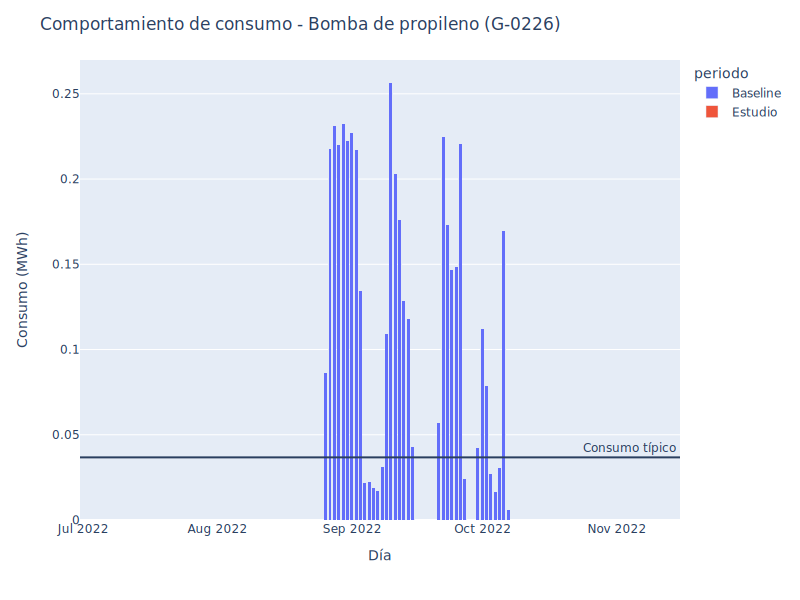

In [392]:
G_0226_diario = G_0226_complete.resample('D').sum().sort_values(by='timestamp', ascending=True).reset_index()
G_0226_diario['periodo'] = np.where((G_0226_diario['timestamp'] >= datetime.strptime(periodo_historico[0], "%Y-%m-%d")) & (G_0226_diario['timestamp'] <= datetime.strptime(periodo_historico[1], "%Y-%m-%d")), 'Baseline', 'Estudio')
G_0226_diario.replace(0, np.nan, inplace=True)
G_0226_diario_LB=G_0226_diario['Consumo (MWh)'].median()
fig = px.bar(G_0226_diario, x="timestamp", y="Consumo (MWh)", color="periodo")

fig.update_layout(barmode='stack', title='Comportamiento de consumo - Bomba de propileno (G-0226) ', width=800, height=600, colorway=['#fc7703', '#757371'], xaxis_title="Día", yaxis_title="Consumo (MWh)")
fig.add_hline(y=G_0226_diario_LB, annotation_text=" Consumo típico")
fig.show()

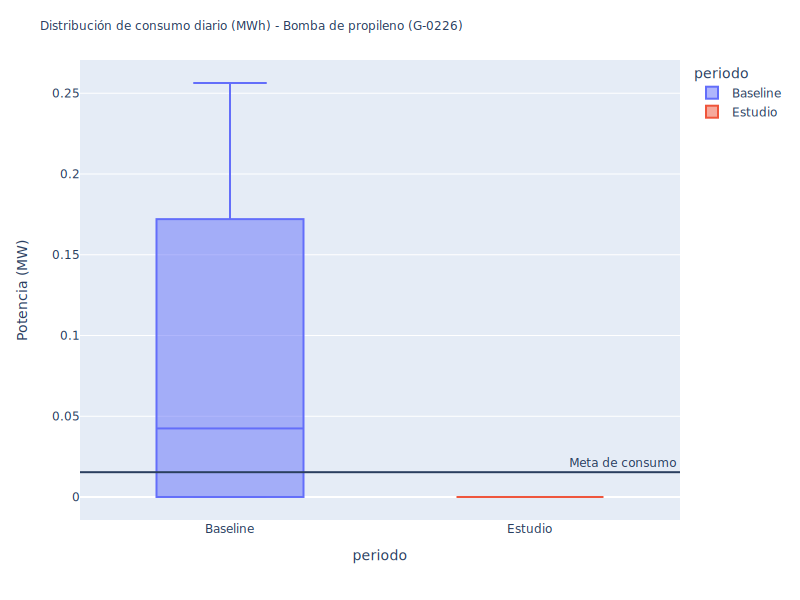

In [393]:
G_0226_LB = G_0226_diario.loc[(G_0226_diario['periodo']=="Baseline") & (G_0226_diario['Consumo (MWh)'].between(G_0226_diario['Consumo (MWh)'].quantile(.25),G_0226_diario['Consumo (MWh)'].quantile(.5)))]['Consumo (MWh)'].mean()

fig = px.box(G_0226_diario, x="periodo", y="Consumo (MWh)", color="periodo")
fig.add_hline(y=G_0226_LB, annotation_text=" Meta de consumo")
    

fig.update_layout( title='Distribución de consumo diario (MWh) -  Bomba de propileno (G-0226)', width=800, height=600, colorway=['#fc7703', '#757371'], yaxis_title="Potencia (MW)", title_font_size=12)
fig.show()

### Bomba calentador propileno (G-0231) 

In [394]:
G_0231 = Esenttia[Esenttia['Máquina'] == 'Bomba calentador propileno (G-0231)']
G_0231_historico = Esenttia_historico[Esenttia_historico['Máquina'] == 'Bomba calentador propileno (G-0231)']


mask_bl = (G_0231_historico['timestamp'] > periodo_historico[0]) & (G_0231_historico['timestamp'] <= periodo_historico[1])
G_0231_bl = G_0231_historico.loc[mask_bl]

mask_sp = (G_0231['timestamp'] >= periodo_de_estudio[0]) & (G_0231['timestamp'] <= periodo_de_estudio[1])
G_0231_sp = G_0231.loc[mask_sp]

G_0231_sp.replace(0, np.nan, inplace=True)
G_0231_bl.replace(0, np.nan, inplace=True)


G_0231_complete = pd.concat([G_0231_sp,G_0231_bl], axis=0)


G_0231_complete['periodo'] = np.where((G_0231_complete['timestamp'] >= datetime.strptime(periodo_historico[0], "%Y-%m-%d")) & (G_0231_complete['timestamp'] <= datetime.strptime(periodo_historico[1], "%Y-%m-%d")), 'Baseline', 'Estudio')

md(f"Durante el periodo de estudio, el consumo total fue de {G_0231_sp['Consumo (MWh)'].sum().round(2)} MWh, lo que representa una diferencia de {np.round((G_0231_bl['Consumo (MWh)'].sum() - G_0231_sp['Consumo (MWh)'].sum()),2)} MWh respecto al periodo anterior.")

Durante el periodo de estudio, el consumo total fue de 0.0 MWh, lo que representa una diferencia de 2.14 MWh respecto al periodo anterior.

In [395]:
md(f"El consumo por día para la Bomba calentador propileno (G-0231)  puede ser observado en la siguiente gráfica:")

El consumo por día para la Bomba calentador propileno (G-0231)  puede ser observado en la siguiente gráfica:

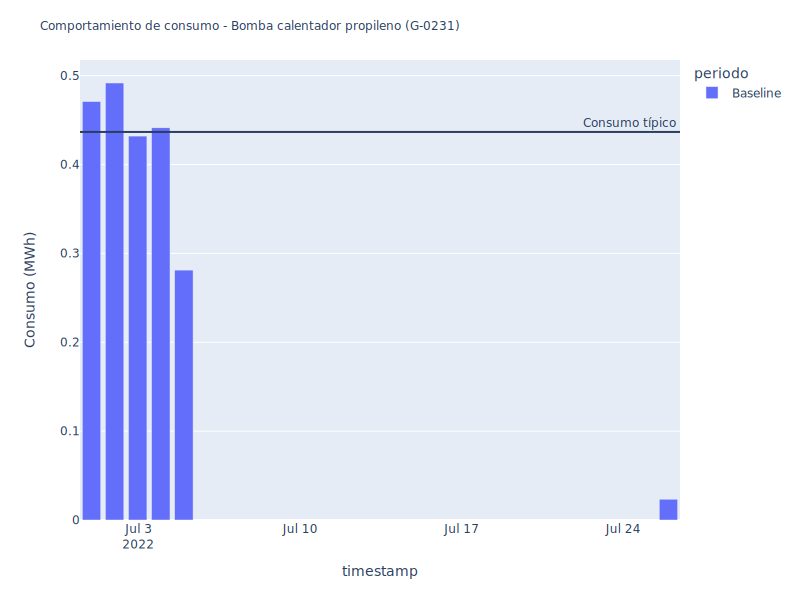

In [396]:
G_0231_diario = G_0231_complete.resample('D').sum().sort_values(by='timestamp', ascending=True).reset_index()
G_0231_diario.replace(0, np.nan, inplace=True)
G_0231_diario['periodo'] = np.where((G_0231_diario['timestamp'] >= datetime.strptime(periodo_historico[0], "%Y-%m-%d")) & (G_0231_diario['timestamp'] <= datetime.strptime(periodo_historico[1], "%Y-%m-%d")), 'Baseline', 'Estudio')

G_0231_diario_LB=G_0231_diario['Consumo (MWh)'].median()
fig = px.bar(G_0231_diario, x="timestamp", y="Consumo (MWh)", color="periodo")

fig.update_layout(barmode='stack', title='Comportamiento de consumo - Bomba calentador propileno (G-0231)', width=800, height=600, colorway=['#fc7703', '#757371'],title_font_size=12)
fig.add_hline(y=G_0231_diario_LB, annotation_text=" Consumo típico")
fig.show()

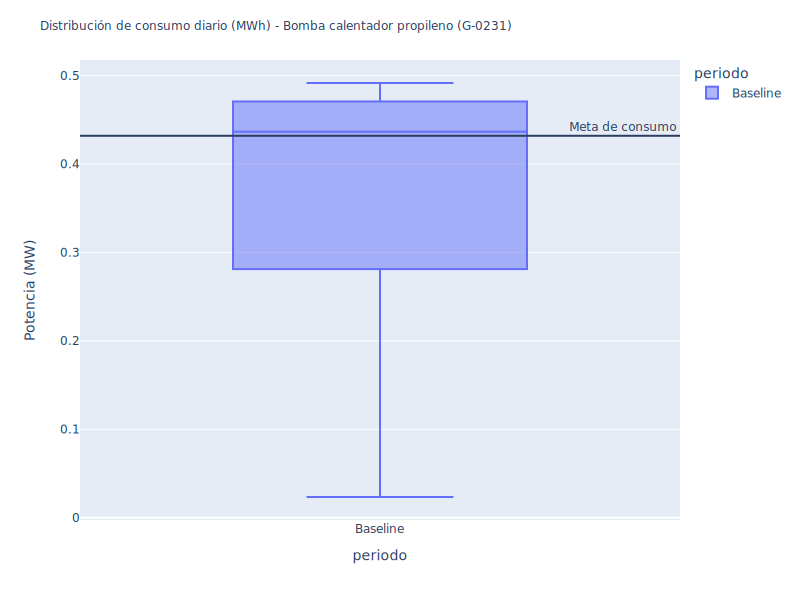

In [397]:
G_0231_LB = G_0231_diario.loc[(G_0231_diario['periodo']=="Baseline") & (G_0231_diario['Consumo (MWh)'].between(G_0231_diario['Consumo (MWh)'].quantile(.25),G_0231_diario['Consumo (MWh)'].quantile(.5)))]['Consumo (MWh)'].mean()

fig = px.box(G_0231_diario, x="periodo", y="Consumo (MWh)", color="periodo")
fig.add_hline(y=G_0231_LB, annotation_text=" Meta de consumo")
fig.update_layout( title='Distribución de consumo diario (MWh) - Bomba calentador propileno (G-0231)', width=800, height=600, colorway=['#fc7703', '#757371'], yaxis_title="Potencia (MW)", title_font_size=12)
fig.show()



### Bomba calentador propileno (G-0230) & bomba calentador propileno (G-0232) 

In [398]:
G_0230 = Esenttia[Esenttia['Máquina'] == 'Bomba calentador propileno (G-0230) & bomba calentador propileno (G-0232)']
G_0230_historico = Esenttia_historico[Esenttia_historico['Máquina'] == 'Bomba calentador propileno (G-0230) & bomba calentador propileno (G-0232)']


mask_bl = (G_0230_historico['timestamp'] > periodo_historico[0]) & (G_0230_historico['timestamp'] <= periodo_historico[1])
G_0230_bl = G_0230_historico.loc[mask_bl]

mask_sp = (G_0230['timestamp'] >= periodo_de_estudio[0]) & (G_0230['timestamp'] <= periodo_de_estudio[1])
G_0230_sp = G_0230.loc[mask_sp]

G_0230_sp.replace(0, np.nan, inplace=True)
G_0230_bl.replace(0, np.nan, inplace=True)


G_0230_complete = pd.concat([G_0230_sp,G_0230_bl], axis=0)


G_0230_complete['periodo'] = np.where((G_0230_complete['timestamp'] >= datetime.strptime(periodo_historico[0], "%Y-%m-%d")) & (G_0230_complete['timestamp'] <= datetime.strptime(periodo_historico[1], "%Y-%m-%d")), 'Baseline', 'Estudio')

md(f"Durante el periodo de estudio, el consumo total fue de {G_0230_sp['Consumo (MWh)'].sum().round(2)} MWh")

Durante el periodo de estudio, el consumo total fue de 7.57 MWh

In [399]:
md(f"El consumo por día para la Bomba calentador propileno (G-0230) & bomba calentador propileno (G-0232) puede ser observado en la siguiente gráfica:")

El consumo por día para la Bomba calentador propileno (G-0230) & bomba calentador propileno (G-0232) puede ser observado en la siguiente gráfica:

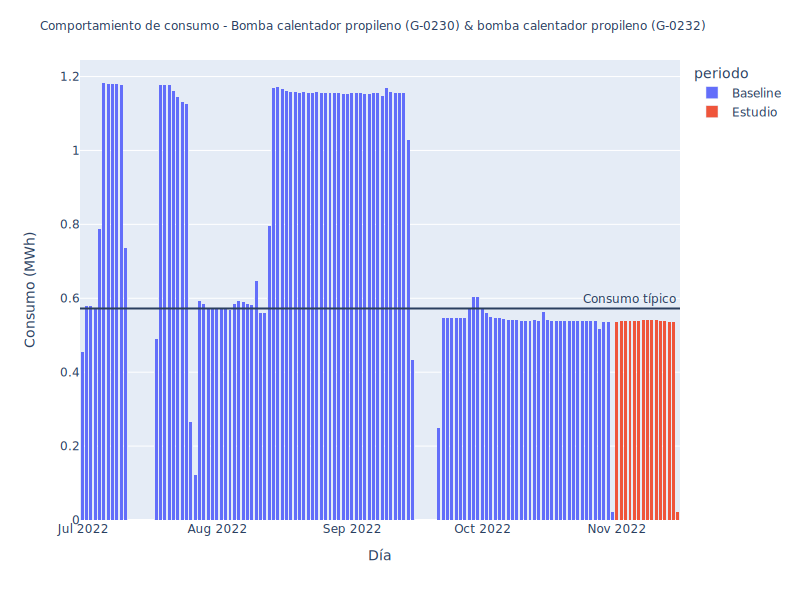

In [400]:
G_0230_diario = G_0230_complete.resample('D').sum().sort_values(by='timestamp', ascending=True).reset_index()
G_0230_diario.replace(0, np.nan, inplace=True)
G_0230_diario['periodo'] = np.where((G_0230_diario['timestamp'] >= datetime.strptime(periodo_historico[0], "%Y-%m-%d")) & (G_0230_diario['timestamp'] <= datetime.strptime(periodo_historico[1], "%Y-%m-%d")), 'Baseline', 'Estudio')

G_0230_diario_LB=G_0230_diario['Consumo (MWh)'].median()

fig = px.bar(G_0230_diario, x="timestamp", y="Consumo (MWh)", color="periodo")

fig.update_layout(barmode='stack', title='Comportamiento de consumo - Bomba calentador propileno (G-0230) & bomba calentador propileno (G-0232) ', width=800, height=600, colorway=['#fc7703', '#757371'], xaxis_title="Día", yaxis_title="Consumo (MWh)")
fig.update_layout(title_font=dict(size=12))
fig.add_hline(y=G_0230_diario_LB, annotation_text=" Consumo típico")
fig.show()

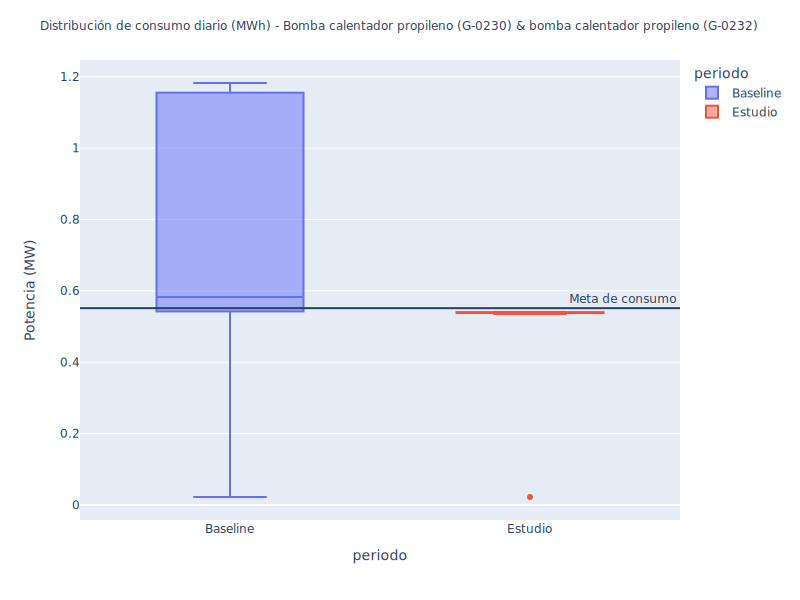

In [401]:
G_0230_LB = G_0230_diario.loc[(G_0230_diario['periodo']=="Baseline") & (G_0230_diario['Consumo (MWh)'].between(G_0230_diario['Consumo (MWh)'].quantile(.25),G_0230_diario['Consumo (MWh)'].quantile(.5)))]['Consumo (MWh)'].mean()

fig = px.box(G_0230_diario, x="periodo", y="Consumo (MWh)", color="periodo")
fig.add_hline(y=G_0230_LB, annotation_text=" Meta de consumo")
fig.update_layout(title_font=dict(size=12.5))
fig.update_layout( title='Distribución de consumo diario (MWh) - Bomba calentador propileno (G-0230) & bomba calentador propileno (G-0232)', width=800, height=600, colorway=['#fc7703', '#757371'], yaxis_title="Potencia (MW)", title_font_size=12)
fig.show()

### Bomba de Cargue de Propileno (G-2013) & Bomba de Circulación de Agua del E-4002 (G-4004) 

In [402]:
G_2013 = Esenttia[Esenttia['Máquina'] == 'Bomba de Cargue de Propileno (G-2013) & Bomba de Circulación de Agua del E-4002 (G-4004)']
G_2013_historico = Esenttia_historico[Esenttia_historico['Máquina'] == 'Bomba de Cargue de Propileno (G-2013) & Bomba de Circulación de Agua del E-4002 (G-4004)']


mask_bl = (G_2013_historico['timestamp'] > periodo_historico[0]) & (G_2013_historico['timestamp'] <= periodo_historico[1])
G_2013_bl = G_2013_historico.loc[mask_bl]

mask_sp = (G_2013['timestamp'] >= periodo_de_estudio[0]) & (G_2013['timestamp'] <= periodo_de_estudio[1])
G_2013_sp = G_2013.loc[mask_sp]

G_2013_sp.replace(0, np.nan, inplace=True)
G_2013_bl.replace(0, np.nan, inplace=True)


G_2013_complete = pd.concat([G_2013_sp,G_2013_bl], axis=0)


G_2013_complete['periodo'] = np.where((G_2013_complete['timestamp'] >= datetime.strptime(periodo_historico[0], "%Y-%m-%d")) & (G_2013_complete['timestamp'] <= datetime.strptime(periodo_historico[1], "%Y-%m-%d")), 'Baseline', 'Estudio')


md(f"Durante el periodo de estudio, el consumo total fue de {G_2013_sp['Consumo (MWh)'].sum().round(2)} MWh")

Durante el periodo de estudio, el consumo total fue de 56.27 MWh

In [403]:
md(f"El consumo por día para la Bomba de Cargue de Propileno (G-2013) & Bomba de Circulación de Agua del E-4002 (G-4004) puede ser observado en la siguiente gráfica:")

El consumo por día para la Bomba de Cargue de Propileno (G-2013) & Bomba de Circulación de Agua del E-4002 (G-4004) puede ser observado en la siguiente gráfica:

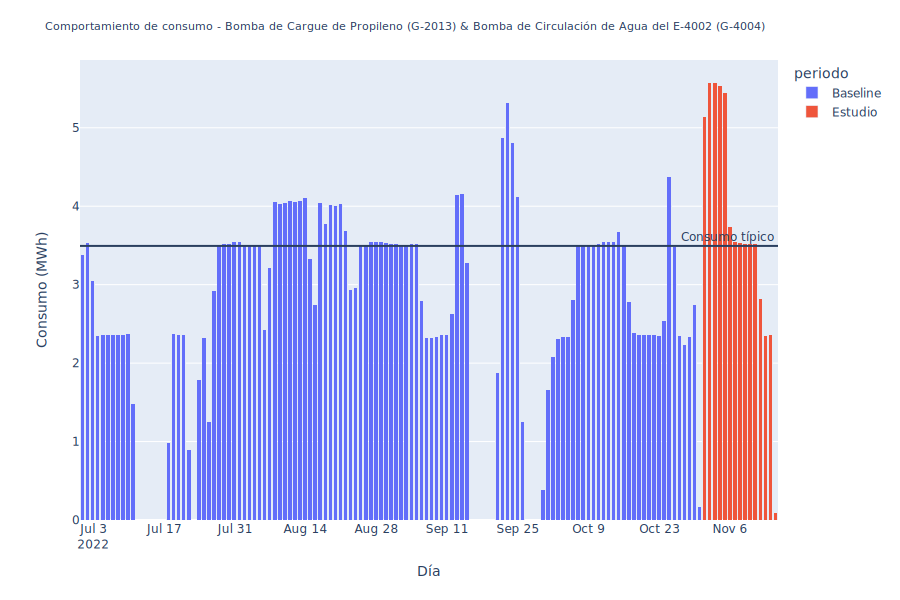

In [404]:
G_2013_diario = G_2013_complete.resample('D').sum().sort_values(by='timestamp', ascending=True).reset_index()
G_2013_diario.replace(0, np.nan, inplace=True)
G_2013_diario['periodo'] = np.where((G_2013_diario['timestamp'] >= datetime.strptime(periodo_historico[0], "%Y-%m-%d")) & (G_2013_diario['timestamp'] <= datetime.strptime(periodo_historico[1], "%Y-%m-%d")), 'Baseline', 'Estudio')

G_2013_diario_diario_LB=G_2013_diario['Consumo (MWh)'].median()

fig = px.bar(G_2013_diario, x="timestamp", y="Consumo (MWh)", color="periodo")

fig.update_layout(barmode='stack', title='Comportamiento de consumo - Bomba de Cargue de Propileno (G-2013) & Bomba de Circulación de Agua del E-4002 (G-4004)',width=900, height=600, colorway=['#fc7703', '#757371'], xaxis_title="Día", yaxis_title="Consumo (MWh)",title_font=dict(size=11))
fig.add_hline(y=G_2013_diario_diario_LB, annotation_text=" Consumo típico")
fig.show()

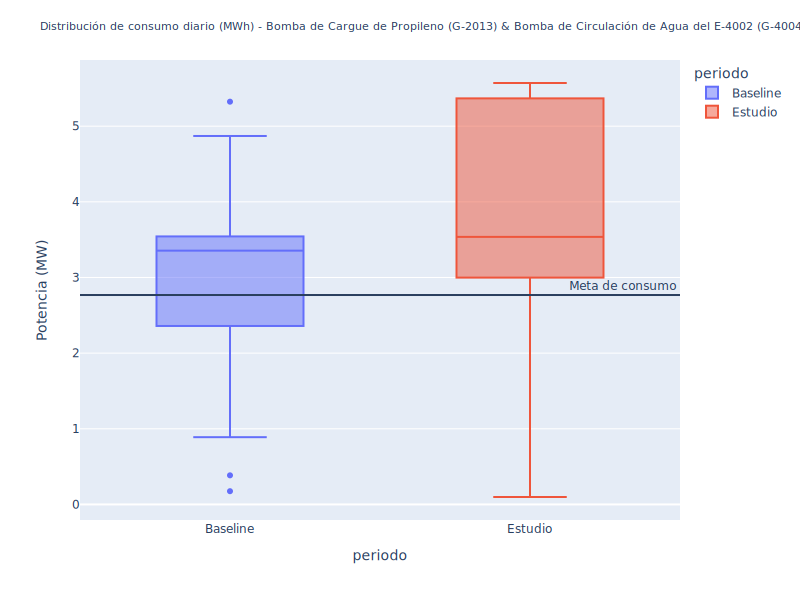

In [405]:
G_2013_LB = G_2013_diario.loc[(G_2013_diario['periodo']=="Baseline") & (G_2013_diario['Consumo (MWh)'].between(G_2013_diario['Consumo (MWh)'].quantile(.25),G_2013_diario['Consumo (MWh)'].quantile(.5)))]['Consumo (MWh)'].mean()

fig = px.box(G_2013_diario, x="periodo", y="Consumo (MWh)", color="periodo")
fig.add_hline(y=G_2013_LB, annotation_text=" Meta de consumo")
fig.update_layout(title_font=dict(size=12.5))
fig.update_layout( title='Distribución de consumo diario (MWh) - Bomba de Cargue de Propileno (G-2013) & Bomba de Circulación de Agua del E-4002 (G-4004)', width=800, height=600, colorway=['#fc7703', '#757371'], yaxis_title="Potencia (MW)", title_font_size=11)
fig.show()

### Bomba de Cargue de Propileno (G-2011)

In [406]:
G_2011 = Esenttia[Esenttia['Máquina'] == 'Bomba de Cargue de Propileno (G-2011)']
G_2011_historico = Esenttia_historico[Esenttia_historico['Máquina'] == 'Bomba de Cargue de Propileno (G-2011)']


mask_bl = (G_2011_historico['timestamp'] > periodo_historico[0]) & (G_2011_historico['timestamp'] <= periodo_historico[1])
G_2011_bl = G_2011_historico.loc[mask_bl]

mask_sp = (G_2011['timestamp'] >= periodo_de_estudio[0]) & (G_2011['timestamp'] <= periodo_de_estudio[1])
G_2011_sp = G_2011.loc[mask_sp]

G_2011_sp.replace(0, np.nan, inplace=True)
G_2011_bl.replace(0, np.nan, inplace=True)


G_2011_complete = pd.concat([G_2011_sp,G_2011_bl], axis=0)


G_2011_complete['periodo'] = np.where((G_2011_complete['timestamp'] >= datetime.strptime(periodo_historico[0], "%Y-%m-%d")) & (G_2011_complete['timestamp'] <= datetime.strptime(periodo_historico[1], "%Y-%m-%d")), 'Baseline', 'Estudio')


md(f"Durante el periodo de estudio, el consumo total fue de {G_2011_sp['Consumo (MWh)'].sum().round(2)} MWh")

Durante el periodo de estudio, el consumo total fue de 0.0 MWh

In [407]:
md(f"El consumo por día para la Bomba booster de propileno (G-2011) puede ser observado en la siguiente gráfica:")

El consumo por día para la Bomba booster de propileno (G-2011) puede ser observado en la siguiente gráfica:

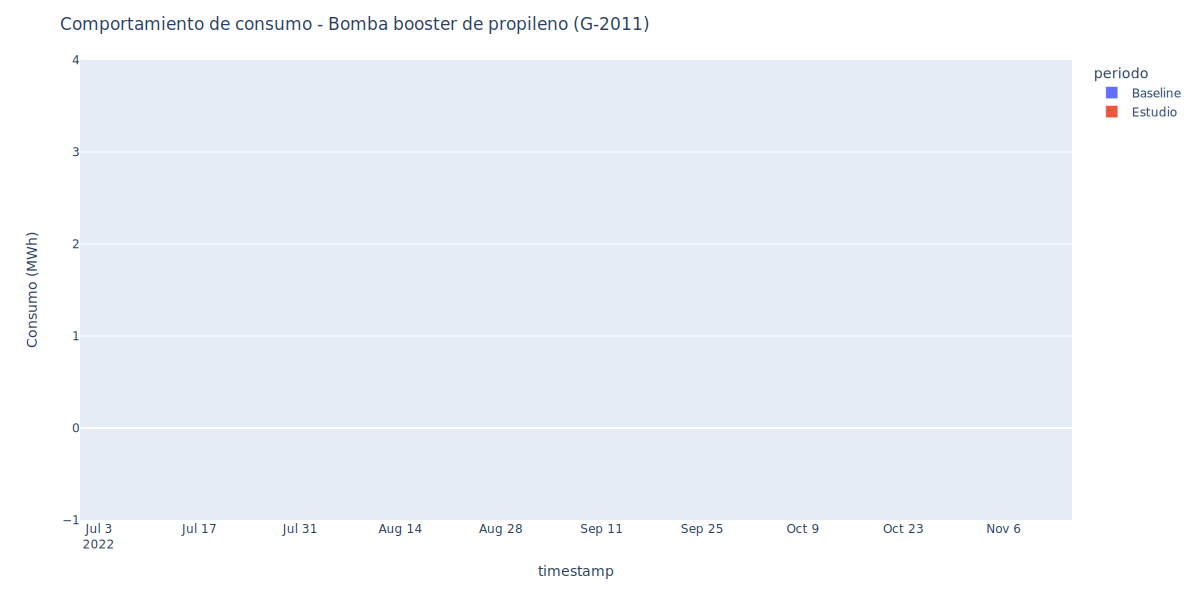

In [408]:
G_2011_diario = G_2011_complete.resample('D').sum().sort_values(by='timestamp', ascending=True).reset_index()
G_2011_diario.replace(0, np.nan, inplace=True)
G_2011_diario['periodo'] = np.where((G_2011_diario['timestamp'] >= datetime.strptime(periodo_historico[0], "%Y-%m-%d")) & (G_2011_diario['timestamp'] <= datetime.strptime(periodo_historico[1], "%Y-%m-%d")), 'Baseline', 'Estudio')


fig = px.bar(G_2011_diario, x="timestamp", y="Consumo (MWh)", color="periodo")


fig.update_layout(barmode='stack', title='Comportamiento de consumo - Bomba booster de propileno (G-2011)',width=1200, height=600, colorway=['#fc7703', '#757371'])
fig.show()

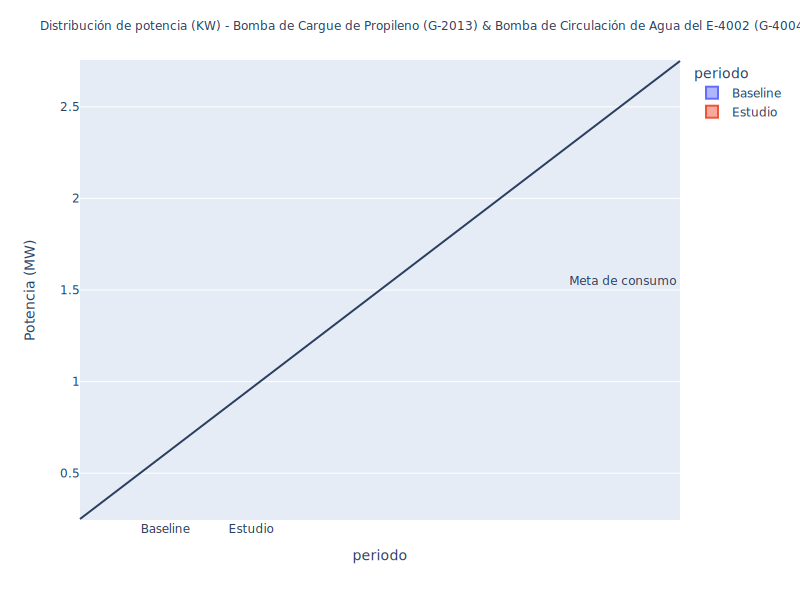

In [409]:
G_2011_LB = G_2011_diario.loc[(G_2011_diario['periodo']=="Baseline") & (G_2011_diario['Consumo (MWh)'].between(G_2011_diario['Consumo (MWh)'].quantile(.3),G_2011_diario['Consumo (MWh)'].quantile(.6)))]['Consumo (MWh)'].mean()

fig = px.box(G_2011_diario, x="periodo", y="Consumo (MWh)", color="periodo")
fig.add_hline(y=G_2011_LB, annotation_text=" Meta de consumo")
fig.update_layout(title_font=dict(size=12.5))
fig.update_layout( title='Distribución de potencia (KW) - Bomba de Cargue de Propileno (G-2013) & Bomba de Circulación de Agua del E-4002 (G-4004)', width=800, height=600, colorway=['#fc7703', '#757371'], yaxis_title="Potencia (MW)", title_font_size=12)
fig.show()

### Bomba booster de propileno (G-2012)

In [410]:
G_2012 = Esenttia[Esenttia['Máquina'] == 'Bomba booster de propileno (G-2012)']
G_2012_historico = Esenttia_bl[Esenttia_bl['Máquina'] == 'Bomba booster de propileno (G-2012)']


mask_bl = (G_2012_historico['timestamp'] > periodo_historico[0]) & (G_2012_historico['timestamp'] <= periodo_historico[1])
G_2012_bl = G_2012_historico.loc[mask_bl]

mask_sp = (G_2012['timestamp'] >= periodo_de_estudio[0]) & (G_2012['timestamp'] <= periodo_de_estudio[1])
G_2012_sp = G_2012.loc[mask_sp]

G_2012_sp.replace(0, np.nan, inplace=True)
G_2012_bl.replace(0, np.nan, inplace=True)


G_2012_complete = pd.concat([G_2012_sp,G_2012_bl], axis=0)


G_2012_complete['periodo'] = np.where((G_2012_complete['timestamp'] >= datetime.strptime(periodo_historico[0], "%Y-%m-%d")) & (G_2012_complete['timestamp'] <= datetime.strptime(periodo_historico[1], "%Y-%m-%d")), 'Baseline', 'Estudio')


md(f"Durante el periodo de estudio, el consumo total fue de {G_2012_sp['Consumo (MWh)'].sum().round(2)} MWh")

Durante el periodo de estudio, el consumo total fue de 0.13 MWh

In [411]:
md(f"El consumo por día para la Bomba booster de propileno (G-2012) puede ser observado en la siguiente gráfica:")

El consumo por día para la Bomba booster de propileno (G-2012) puede ser observado en la siguiente gráfica:

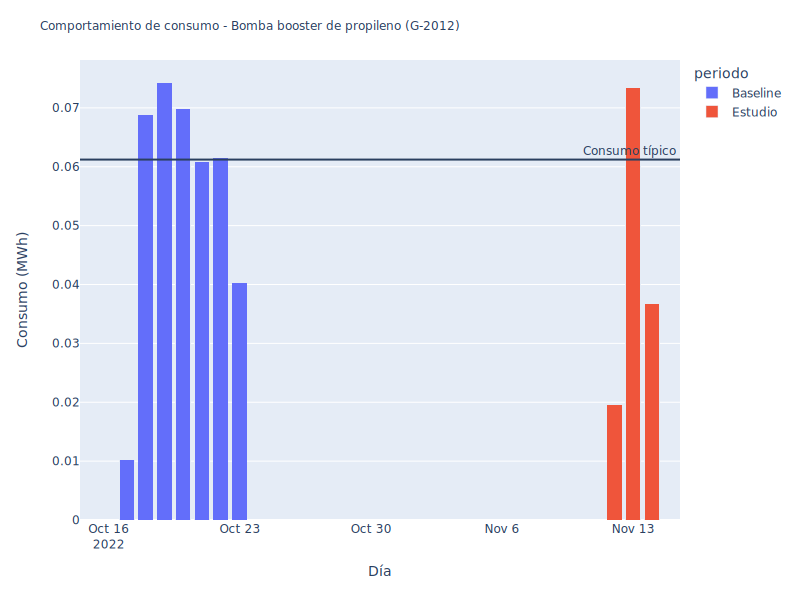

In [412]:
G_2012_diario = G_2012_complete.resample('D').sum().sort_values(by='timestamp', ascending=True).reset_index()
G_2012_diario.replace(0, np.nan, inplace=True)
G_2012_diario['periodo'] = np.where((G_2012_diario['timestamp'] >= datetime.strptime(periodo_historico[0], "%Y-%m-%d")) & (G_2012_diario['timestamp'] <= datetime.strptime(periodo_historico[1], "%Y-%m-%d")), 'Baseline', 'Estudio')

G_2012_diario_diario_LB=G_2012_diario['Consumo (MWh)'].median()


fig = px.bar(G_2012_diario, x="timestamp", y="Consumo (MWh)", color="periodo")


fig.add_hline(y=G_2012_diario_diario_LB, annotation_text=" Consumo típico")
fig.update_layout(barmode='stack', title='Comportamiento de consumo - Bomba booster de propileno (G-2012)',width=800, height=600, colorway=['#fc7703', '#757371'], xaxis_title="Día", yaxis_title="Consumo (MWh)", title_font_size=12)
fig.show()

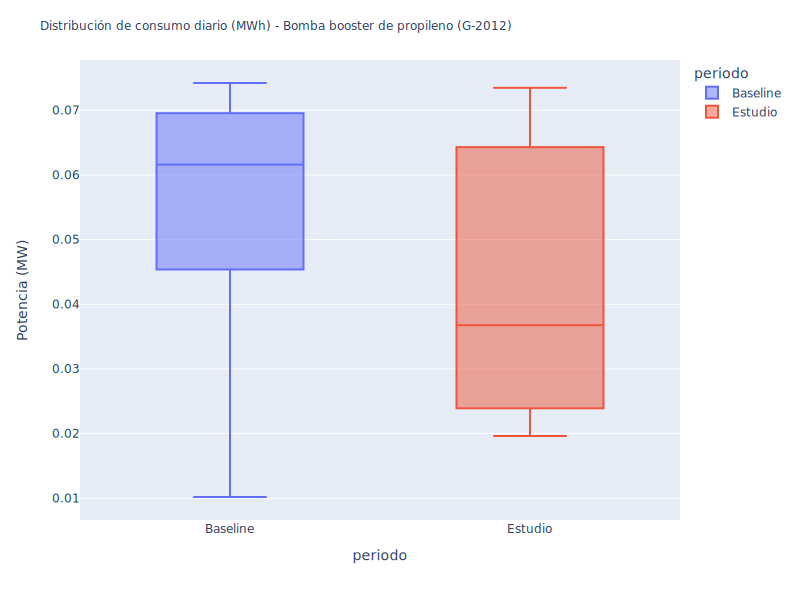

In [413]:
G_2012_LB = G_2012_diario.loc[(G_2012_diario['periodo']=="Baseline") & (G_2012_diario['Consumo (MWh)'].between(G_2012_diario['Consumo (MWh)'].quantile(.25),G_2012_diario['Consumo (MWh)'].quantile(.5)))]['Consumo (MWh)'].mean()

fig = px.box(G_2012_diario, x="periodo", y="Consumo (MWh)", color="periodo")
# fig.add_hline(y=G_2012_LB, annotation_text=" Meta de consumo")
fig.update_layout(title_font=dict(size=12.5))
fig.update_layout( title='Distribución de consumo diario (MWh) - Bomba booster de propileno (G-2012)', width=800, height=600, colorway=['#fc7703', '#757371'], yaxis_title="Potencia (MW)", title_font_size=12)
fig.show()

### Bomba de Circulación de Agua de Torre 2 (G-0402)

In [414]:
G_0402 = Esenttia[Esenttia['Máquina'] == 'Bomba de Circulación de Agua de Torre 2 (G-0402)']
G_0402_historico = Esenttia_bl[Esenttia_bl['Máquina'] == 'Bomba de Circulación de Agua de Torre 2 (G-0402)']


mask_bl = (G_0402_historico['timestamp'] > periodo_historico[0]) & (G_0402_historico['timestamp'] <= periodo_historico[1])
G_0402_bl = G_0402_historico.loc[mask_bl]

mask_sp = (G_0402['timestamp'] >= periodo_de_estudio[0]) & (G_0402['timestamp'] <= periodo_de_estudio[1])
G_0402_sp = G_0402.loc[mask_sp]

G_0402_sp.replace(0, np.nan, inplace=True)
G_0402_bl.replace(0, np.nan, inplace=True)


G_0402_complete = pd.concat([G_0402_sp,G_0402_bl], axis=0)


G_0402_complete['periodo'] = np.where((G_0402_complete['timestamp'] >= datetime.strptime(periodo_historico[0], "%Y-%m-%d")) & (G_0402_complete['timestamp'] <= datetime.strptime(periodo_historico[1], "%Y-%m-%d")), 'Baseline', 'Estudio')


md(f"Durante el periodo de estudio, el consumo total fue de {G_0402_sp['Consumo (MWh)'].sum().round(2)} MWh")

Durante el periodo de estudio, el consumo total fue de 43.53 MWh

In [415]:
md(f"El consumo por día para la Bomba de Circulación de Agua de Torre 2 (G-0402) puede ser observado en la siguiente gráfica:")

El consumo por día para la Bomba de Circulación de Agua de Torre 2 (G-0402) puede ser observado en la siguiente gráfica:

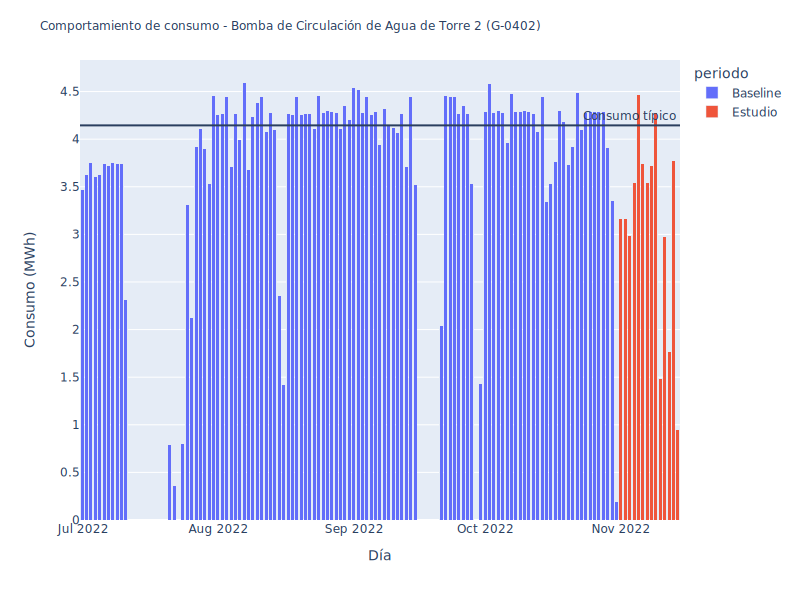

In [416]:
G_0402_diario = G_0402_complete.resample('D').sum().sort_values(by='timestamp', ascending=True).reset_index()
G_0402_diario.replace(0, np.nan, inplace=True)
G_0402_diario['periodo'] = np.where((G_0402_diario['timestamp'] >= datetime.strptime(periodo_historico[0], "%Y-%m-%d")) & (G_0402_diario['timestamp'] <= datetime.strptime(periodo_historico[1], "%Y-%m-%d")), 'Baseline', 'Estudio')

G_0402_diario_diario_LB=G_0402_diario['Consumo (MWh)'].median()

fig = px.bar(G_0402_diario, x="timestamp", y="Consumo (MWh)", color="periodo")
fig.add_hline(y=G_0402_diario_diario_LB, annotation_text=" Consumo típico")
fig.update_layout(barmode='stack', title='Comportamiento de consumo - Bomba de Circulación de Agua de Torre 2 (G-0402)',width=800, height=600, colorway=['#fc7703', '#757371'], xaxis_title="Día", yaxis_title="Consumo (MWh)", title_font_size=12)
fig.show()

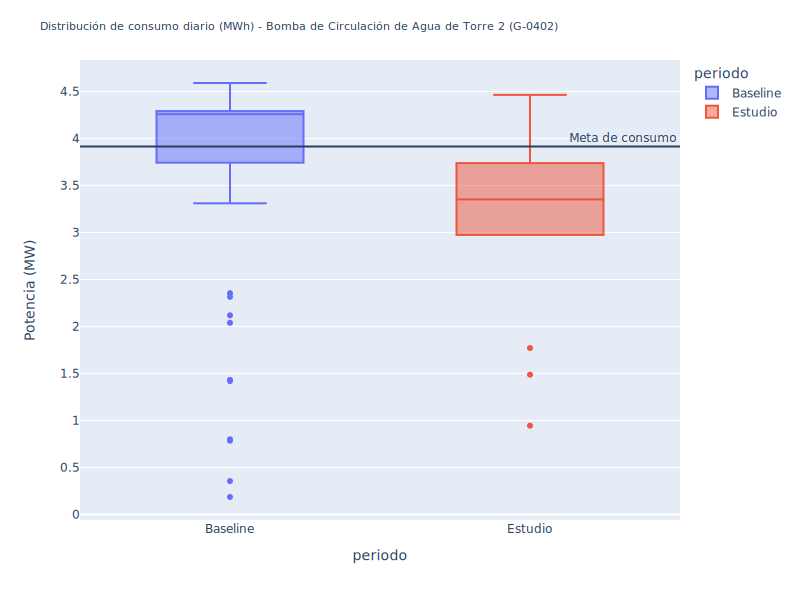

In [417]:
G_0402_LB = G_0402_diario.loc[(G_0402_diario['periodo']=="Baseline") & (G_0402_diario['Consumo (MWh)'].between(G_0402_diario['Consumo (MWh)'].quantile(.25),G_0402_diario['Consumo (MWh)'].quantile(.5)))]['Consumo (MWh)'].mean()

fig = px.box(G_0402_diario, x="periodo", y="Consumo (MWh)", color="periodo")
fig.add_hline(y=G_0402_LB, annotation_text=" Meta de consumo")
fig.update_layout(title_font=dict(size=12.5))
fig.update_layout( title='Distribución de consumo diario (MWh) - Bomba de Circulación de Agua de Torre 2 (G-0402)', width=800, height=600, colorway=['#fc7703', '#757371'], yaxis_title="Potencia (MW)", title_font_size=11)
fig.show()

### Bomba de Circulación de Agua de Torre 4 (G-0404)

In [418]:
G_0404 = Esenttia[Esenttia['Máquina'] == 'Bomba de Circulación de Agua de Torre 4 (G-0404)']
G_0404_historico = Esenttia_bl[Esenttia_bl['Máquina'] == 'Bomba de Circulación de Agua de Torre 4 (G-0404)']


mask_bl = (G_0404_historico['timestamp'] > periodo_historico[0]) & (G_0404_historico['timestamp'] <= periodo_historico[1])
G_0404_bl = G_0404_historico.loc[mask_bl]

mask_sp = (G_0404['timestamp'] >= periodo_de_estudio[0]) & (G_0404['timestamp'] <= periodo_de_estudio[1])
G_0404_sp = G_0404.loc[mask_sp]

G_0404_sp.replace(0, np.nan, inplace=True)
G_0404_bl.replace(0, np.nan, inplace=True)


G_0404_complete = pd.concat([G_0404_sp,G_0404_bl], axis=0)


G_0404_complete['periodo'] = np.where((G_0404_complete['timestamp'] >= datetime.strptime(periodo_historico[0], "%Y-%m-%d")) & (G_0404_complete['timestamp'] <= datetime.strptime(periodo_historico[1], "%Y-%m-%d")), 'Baseline', 'Estudio')


md(f"Durante el periodo de estudio, el consumo total fue de {G_0404_sp['Consumo (MWh)'].sum().round(2)} MWh")

Durante el periodo de estudio, el consumo total fue de 40.09 MWh

In [419]:
md(f"El consumo por día para la Bomba de Circulación de Agua de Torre 4 (G-0404) puede ser observado en la siguiente gráfica:")

El consumo por día para la Bomba de Circulación de Agua de Torre 4 (G-0404) puede ser observado en la siguiente gráfica:

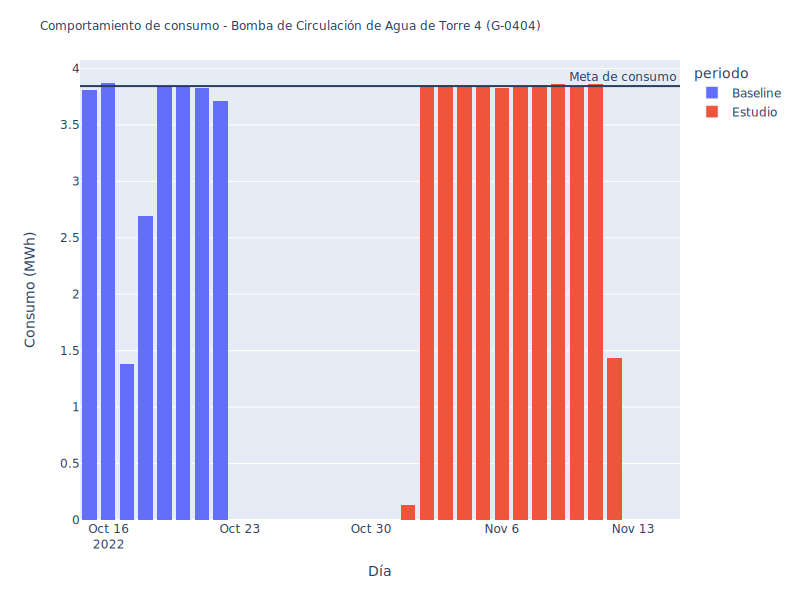

In [420]:
G_0404_diario = G_0404_complete.resample('D').sum().sort_values(by='timestamp', ascending=True).reset_index()
G_0404_diario.replace(0, np.nan, inplace=True)
G_0404_diario['periodo'] = np.where((G_0404_diario['timestamp'] >= datetime.strptime(periodo_historico[0], "%Y-%m-%d")) & (G_0404_diario['timestamp'] <= datetime.strptime(periodo_historico[1], "%Y-%m-%d")), 'Baseline', 'Estudio')


G_0404_diario_diario_LB=G_0404_diario['Consumo (MWh)'].median()


fig = px.bar(G_0404_diario, x="timestamp", y="Consumo (MWh)", color="periodo")
fig.add_hline(y=G_0404_diario_diario_LB, annotation_text=" Meta de consumo")


fig.update_layout(barmode='stack', title='Comportamiento de consumo - Bomba de Circulación de Agua de Torre 4 (G-0404)',width=800, height=600, colorway=['#fc7703', '#757371'], xaxis_title="Día", yaxis_title="Consumo (MWh)", title_font_size=12)
fig.show()

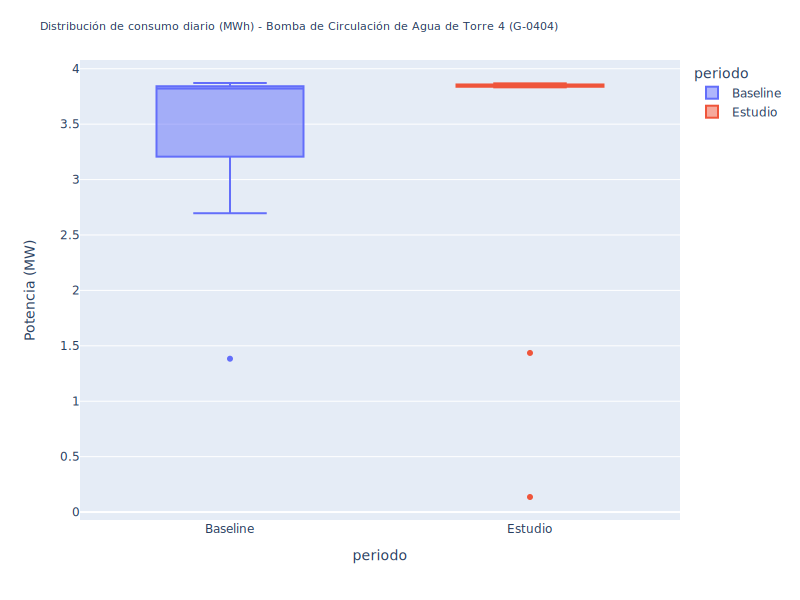

In [421]:
G_0404_LB = G_0404_diario.loc[(G_0404_diario['periodo']=="Baseline") & (G_0404_diario['Consumo (MWh)'].between(G_0404_diario['Consumo (MWh)'].quantile(.3),G_0404_diario['Consumo (MWh)'].quantile(.6)))]['Consumo (MWh)'].mean()

fig = px.box(G_0404_diario, x="periodo", y="Consumo (MWh)", color="periodo")
# fig.add_hline(y=G_0404_LB, annotation_text=" Meta de consumo")
fig.update_layout(title_font=dict(size=12.5))
fig.update_layout( title='Distribución de consumo diario (MWh) - Bomba de Circulación de Agua de Torre 4 (G-0404)', width=800, height=600, colorway=['#fc7703', '#757371'], yaxis_title="Potencia (MW)", title_font_size=11)
fig.show()

### Bomba de Circulación de Agua de Torre N°5 (G-0405)

In [422]:
G_0405 = Esenttia[Esenttia['Máquina'] == 'Bomba de Circulación de Agua de Torre N°5 (G-0405)']
G_0405_historico = Esenttia_historico[Esenttia_historico['Máquina'] == 'Bomba de Circulación de Agua de Torre N°5 (G-0405)']


mask_bl = (G_0405_historico['timestamp'] > periodo_historico[0]) & (G_0405_historico['timestamp'] <= periodo_historico[1])
G_0405_bl = G_0405_historico.loc[mask_bl]

mask_sp = (G_0405['timestamp'] >= periodo_de_estudio[0]) & (G_0405['timestamp'] <= periodo_de_estudio[1])
G_0405_sp = G_0405.loc[mask_sp]

G_0405_sp.replace(0, np.nan, inplace=True)
G_0405_bl.replace(0, np.nan, inplace=True)


G_0405_complete = pd.concat([G_0405_sp,G_0405_bl], axis=0)


G_0405_complete['periodo'] = np.where((G_0405_complete['timestamp'] >= datetime.strptime(periodo_historico[0], "%Y-%m-%d")) & (G_0405_complete['timestamp'] <= datetime.strptime(periodo_historico[1], "%Y-%m-%d")), 'Baseline', 'Estudio')


md(f"Durante el periodo de estudio, el consumo total fue de {G_0405_sp['Consumo (MWh)'].sum().round(2)} MWh")

Durante el periodo de estudio, el consumo total fue de 45.98 MWh

In [423]:
md(f"El consumo por día para la Bomba de Circulación de Agua de Torre N°5 (G-0405) puede ser observado en la siguiente gráfica:")

El consumo por día para la Bomba de Circulación de Agua de Torre N°5 (G-0405) puede ser observado en la siguiente gráfica:

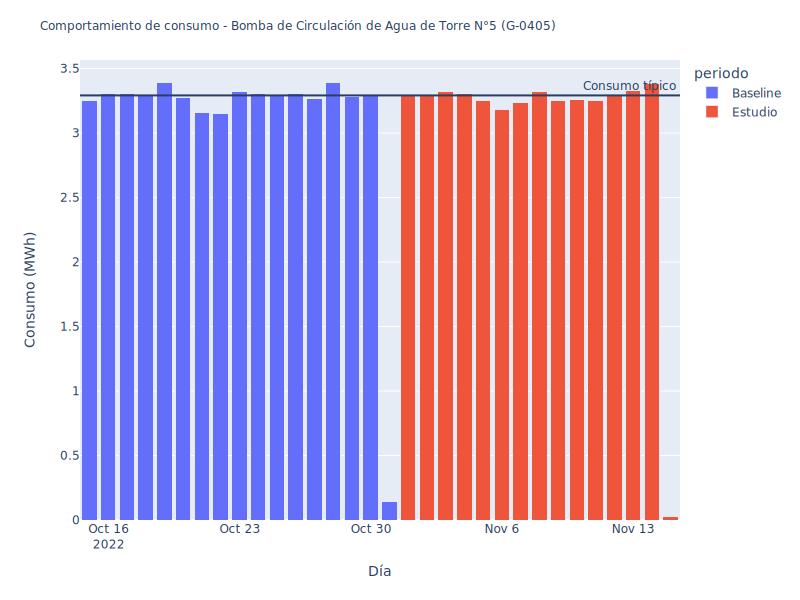

In [424]:
G_0405_diario = G_0405_complete.resample('D').sum().sort_values(by='timestamp', ascending=True).reset_index()
G_0405_diario.replace(0, np.nan, inplace=True)
G_0405_diario['periodo'] = np.where((G_0405_diario['timestamp'] >= datetime.strptime(periodo_historico[0], "%Y-%m-%d")) & (G_0405_diario['timestamp'] <= datetime.strptime(periodo_historico[1], "%Y-%m-%d")), 'Baseline', 'Estudio')

G_0405_diario_diario_LB=G_0405_diario['Consumo (MWh)'].median()

fig = px.bar(G_0405_diario, x="timestamp", y="Consumo (MWh)", color="periodo")


fig.add_hline(y=G_0405_diario_diario_LB, annotation_text=" Consumo típico")
fig.update_layout(barmode='stack', title='Comportamiento de consumo - Bomba de Circulación de Agua de Torre N°5 (G-0405)',width=800, height=600, colorway=['#fc7703', '#757371'], xaxis_title="Día", yaxis_title="Consumo (MWh)", title_font_size=12)
fig.show()

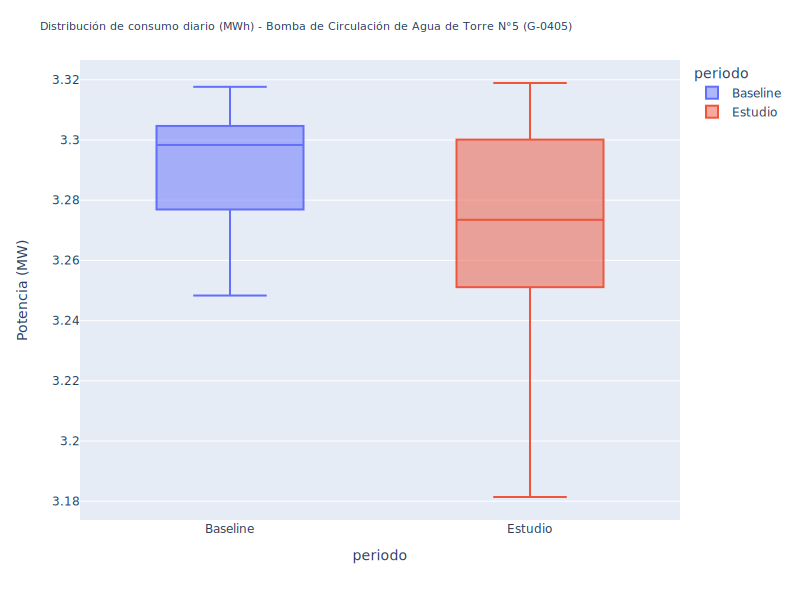

In [425]:
G_0405_diario = G_0405_diario.loc[(G_0405_diario['Consumo (MWh)'].between(G_0405_diario['Consumo (MWh)'].quantile(.10),G_0405_diario['Consumo (MWh)'].quantile(.90)))]

G_0405_LB = G_0405_diario.loc[(G_0405_diario['periodo']=="Baseline") & (G_0405_diario['Consumo (MWh)'].between(G_0405_diario['Consumo (MWh)'].quantile(.3),G_0405_diario['Consumo (MWh)'].quantile(.6)))]['Consumo (MWh)'].mean()

fig = px.box(G_0405_diario, x="periodo", y="Consumo (MWh)", color="periodo")
# fig.add_hline(y=G_0405_LB, annotation_text=" Meta de consumo")
fig.update_layout(title_font=dict(size=12.5))
fig.update_layout( title='Distribución de consumo diario (MWh) - Bomba de Circulación de Agua de Torre N°5 (G-0405)', width=800, height=600, colorway=['#fc7703', '#757371'], yaxis_title="Potencia (MW)", title_font_size=11)
fig.show()

### Bombas de Agua Tratada (G-0446) y (G-0447)

In [426]:
G_0446 = Esenttia[Esenttia['Máquina'] == 'Bombas de Agua Tratada (G-0446) y (G-0447)']
G_0446_historico = Esenttia_historico[Esenttia_historico['Máquina'] == 'Bombas de Agua Tratada (G-0446) y (G-0447)']


mask_bl = (G_0446_historico['timestamp'] > periodo_historico[0]) & (G_0446_historico['timestamp'] <= periodo_historico[1])
G_0446_bl = G_0446_historico.loc[mask_bl]

mask_sp = (G_0446['timestamp'] >= periodo_de_estudio[0]) & (G_0446['timestamp'] <= periodo_de_estudio[1])
G_0446_sp = G_0446.loc[mask_sp]

G_0446_sp.replace(0, np.nan, inplace=True)
G_0446_bl.replace(0, np.nan, inplace=True)


G_0446_complete = pd.concat([G_0446_sp,G_0446_bl], axis=0)


G_0446_complete['periodo'] = np.where((G_0446_complete['timestamp'] >= datetime.strptime(periodo_historico[0], "%Y-%m-%d")) & (G_0446_complete['timestamp'] <= datetime.strptime(periodo_historico[1], "%Y-%m-%d")), 'Baseline', 'Estudio')


md(f"Durante el periodo de estudio, el consumo total fue de {G_0446_sp['Consumo (MWh)'].sum().round(2)} MWh")

Durante el periodo de estudio, el consumo total fue de 0.2 MWh

In [427]:
md(f"El consumo por día para las Bombas de Agua Tratada (G-0446) y (G-0447) puede ser observado en la siguiente gráfica:")

El consumo por día para las Bombas de Agua Tratada (G-0446) y (G-0447) puede ser observado en la siguiente gráfica:

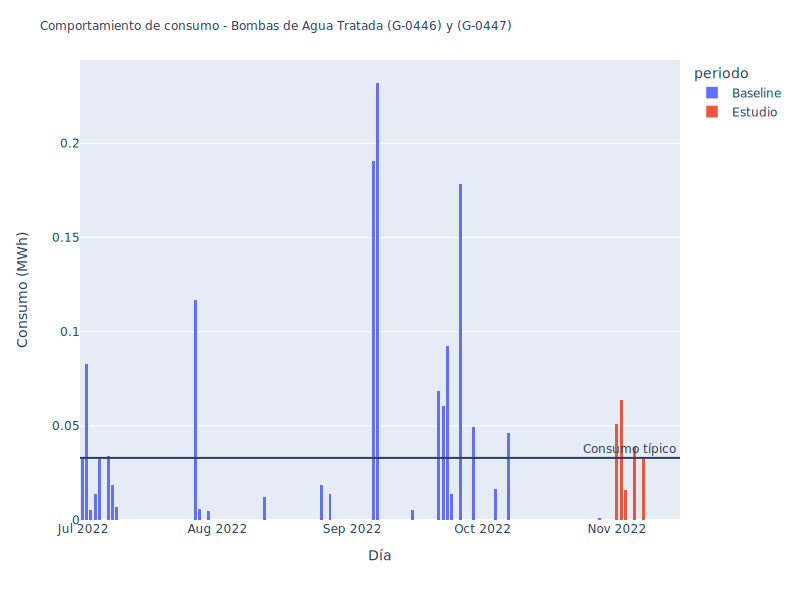

In [428]:
G_0446_diario = G_0446_complete.resample('D').sum().sort_values(by='timestamp', ascending=True).reset_index()
G_0446_diario.replace(0, np.nan, inplace=True)
G_0446_diario['periodo'] = np.where((G_0446_diario['timestamp'] >= datetime.strptime(periodo_historico[0], "%Y-%m-%d")) & (G_0446_diario['timestamp'] <= datetime.strptime(periodo_historico[1], "%Y-%m-%d")), 'Baseline', 'Estudio')


G_0446_diario_diario_LB=G_0446_diario['Consumo (MWh)'].median()

fig = px.bar(G_0446_diario, x="timestamp", y="Consumo (MWh)", color="periodo")

fig.add_hline(y=G_0446_diario_diario_LB, annotation_text=" Consumo típico")

fig.update_layout(barmode='stack', title='Comportamiento de consumo - Bombas de Agua Tratada (G-0446) y (G-0447)',width=800, height=600, colorway=['#fc7703', '#757371'], xaxis_title="Día", yaxis_title="Consumo (MWh)", title_font_size=12)
fig.show()

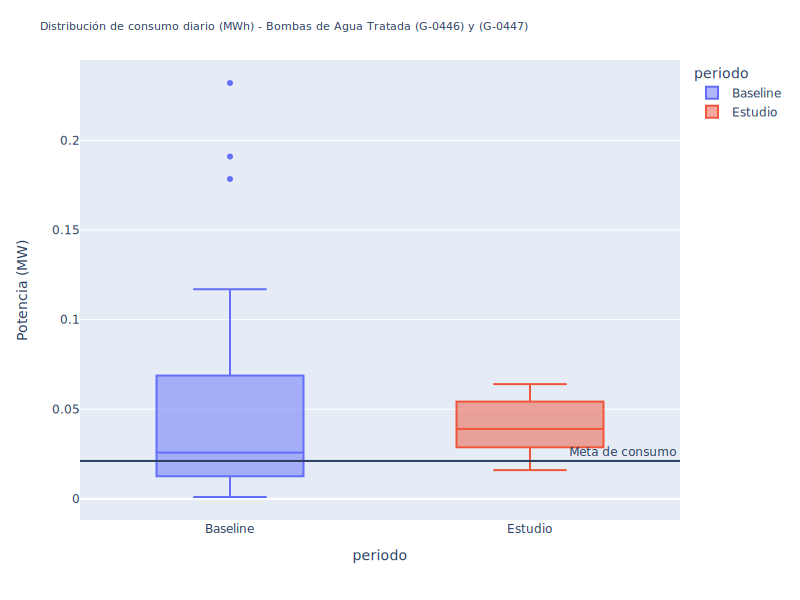

In [429]:
G_0446_LB = G_0446_diario.loc[(G_0446_diario['periodo']=="Baseline") & (G_0446_diario['Consumo (MWh)'].between(G_0446_diario['Consumo (MWh)'].quantile(.25),G_0446_diario['Consumo (MWh)'].quantile(.5)))]['Consumo (MWh)'].mean()

fig = px.box(G_0446_diario, x="periodo", y="Consumo (MWh)", color="periodo")
fig.add_hline(y=G_0446_LB, annotation_text=" Meta de consumo")
fig.update_layout(title_font=dict(size=12.5))
fig.update_layout( title='Distribución de consumo diario (MWh) - Bombas de Agua Tratada (G-0446) y (G-0447)', width=800, height=600, colorway=['#fc7703', '#757371'], yaxis_title="Potencia (MW)", title_font_size=11)
fig.show()

### Ventilador de Torres de Enfriamiento (Y_0400F2M)

In [430]:
Y_0400F2M = Esenttia[Esenttia['Máquina'] == 'Ventilador de Torres de Enfriamiento (Y_0400F2M)']
Y_0400F2M_historico = Esenttia_historico[Esenttia_historico['Máquina'] == 'Ventilador de Torres de Enfriamiento (Y_0400F2M)']


mask_bl = (Y_0400F2M_historico['timestamp'] > periodo_historico[0]) & (Y_0400F2M_historico['timestamp'] <= periodo_historico[1])
Y_0400F2M_bl = Y_0400F2M_historico.loc[mask_bl]

mask_sp = (Y_0400F2M['timestamp'] >= periodo_de_estudio[0]) & (Y_0400F2M['timestamp'] <= periodo_de_estudio[1])
Y_0400F2M_sp = Y_0400F2M.loc[mask_sp]

Y_0400F2M_sp.replace(0, np.nan, inplace=True)
Y_0400F2M_bl.replace(0, np.nan, inplace=True)


Y_0400F2M_complete = pd.concat([Y_0400F2M_sp,Y_0400F2M_bl], axis=0)


Y_0400F2M_complete['periodo'] = np.where((Y_0400F2M_complete['timestamp'] >= datetime.strptime(periodo_historico[0], "%Y-%m-%d")) & (Y_0400F2M_complete['timestamp'] <= datetime.strptime(periodo_historico[1], "%Y-%m-%d")), 'Baseline', 'Estudio')


md(f"Durante el periodo de estudio, el consumo total fue de {Y_0400F2M_sp['Consumo (MWh)'].sum().round(2)} MWh")

Durante el periodo de estudio, el consumo total fue de 19.36 MWh

In [431]:
md(f"El consumo por día para el Ventilador de Torres de Enfriamiento (Y_0400F2M) puede ser observado en la siguiente gráfica:")

El consumo por día para el Ventilador de Torres de Enfriamiento (Y_0400F2M) puede ser observado en la siguiente gráfica:

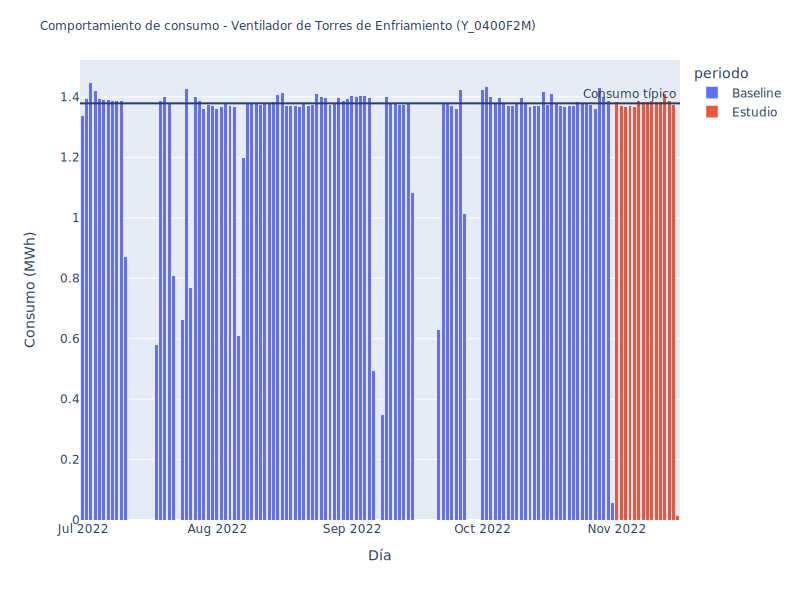

In [432]:
Y_0400F2M_diario = Y_0400F2M_complete.resample('D').sum().sort_values(by='timestamp', ascending=True).reset_index()
Y_0400F2M_diario.replace(0, np.nan, inplace=True)
Y_0400F2M_diario['periodo'] = np.where((Y_0400F2M_diario['timestamp'] >= datetime.strptime(periodo_historico[0], "%Y-%m-%d")) & (Y_0400F2M_diario['timestamp'] <= datetime.strptime(periodo_historico[1], "%Y-%m-%d")), 'Baseline', 'Estudio')



Y_0400F2M_diario_LB=Y_0400F2M_diario['Consumo (MWh)'].median()

fig = px.bar(Y_0400F2M_diario, x="timestamp", y="Consumo (MWh)", color="periodo")

fig.add_hline(y=Y_0400F2M_diario_LB, annotation_text=" Consumo típico")

fig.update_layout(barmode='stack', title='Comportamiento de consumo - Ventilador de Torres de Enfriamiento (Y_0400F2M)',width=800, height=600, colorway=['#fc7703', '#757371'], xaxis_title="Día", yaxis_title="Consumo (MWh)", title_font_size=12)
fig.show()

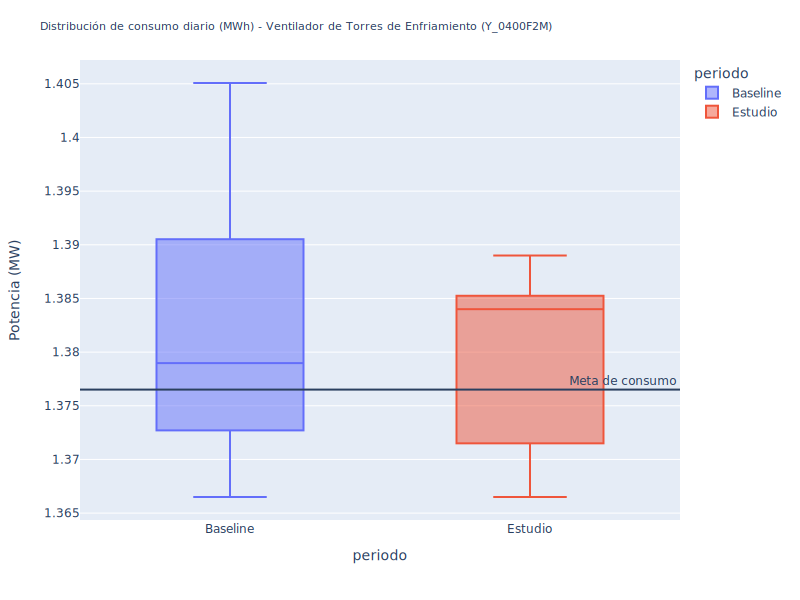

In [433]:
Y_0400F2M_diario = Y_0400F2M_diario.loc[(Y_0400F2M_diario['Consumo (MWh)'].between(Y_0400F2M_diario['Consumo (MWh)'].quantile(.15),Y_0400F2M_diario['Consumo (MWh)'].quantile(.90)))]

Y_0400F2M_LB = Y_0400F2M_diario.loc[(Y_0400F2M_diario['periodo']=="Baseline") & (Y_0400F2M_diario['Consumo (MWh)'].between(Y_0400F2M_diario['Consumo (MWh)'].quantile(.25),Y_0400F2M_diario['Consumo (MWh)'].quantile(.5)))]['Consumo (MWh)'].mean()

fig = px.box(Y_0400F2M_diario, x="periodo", y="Consumo (MWh)", color="periodo")
fig.add_hline(y=Y_0400F2M_LB, annotation_text=" Meta de consumo")
fig.update_layout(title_font=dict(size=12.5))
fig.update_layout( title='Distribución de consumo diario (MWh) - Ventilador de Torres de Enfriamiento (Y_0400F2M)', width=800, height=600, colorway=['#fc7703', '#757371'], yaxis_title="Potencia (MW)", title_font_size=11)
fig.show()

### Ventilador de Torres de Enfriamiento Y-0400F3

In [434]:
Y_0400F3 = Esenttia[Esenttia['Máquina'] == 'Ventilador de Torres de Enfriamiento (Y_0400F3)']
Y_0400F3_historico = Esenttia_historico[Esenttia_historico['Máquina'] == 'Ventilador de Torres de Enfriamiento (Y_0400F3)']


mask_bl = (Y_0400F3_historico['timestamp'] > periodo_historico[0]) & (Y_0400F3_historico['timestamp'] <= periodo_historico[1])
Y_0400F3_bl = Y_0400F3_historico.loc[mask_bl]

mask_sp = (Y_0400F3['timestamp'] >= periodo_de_estudio[0]) & (Y_0400F3['timestamp'] <= periodo_de_estudio[1])
Y_0400F3_sp = Y_0400F3.loc[mask_sp]

Y_0400F3_sp.replace(0, np.nan, inplace=True)
Y_0400F3_bl.replace(0, np.nan, inplace=True)


Y_0400F3_complete = pd.concat([Y_0400F3_sp,Y_0400F3_bl], axis=0)


Y_0400F3_complete['periodo'] = np.where((Y_0400F3_complete['timestamp'] >= datetime.strptime(periodo_historico[0], "%Y-%m-%d")) & (Y_0400F3_complete['timestamp'] <= datetime.strptime(periodo_historico[1], "%Y-%m-%d")), 'Baseline', 'Estudio')


md(f"Durante el periodo de estudio, el consumo total fue de {Y_0400F3_sp['Consumo (MWh)'].sum().round(2)} MWh")

Durante el periodo de estudio, el consumo total fue de 21.13 MWh

In [435]:
md(f"El consumo por día para el Ventilador de Torres de Enfriamiento (Y_0400F3) puede ser observado en la siguiente gráfica:")

El consumo por día para el Ventilador de Torres de Enfriamiento (Y_0400F3) puede ser observado en la siguiente gráfica:

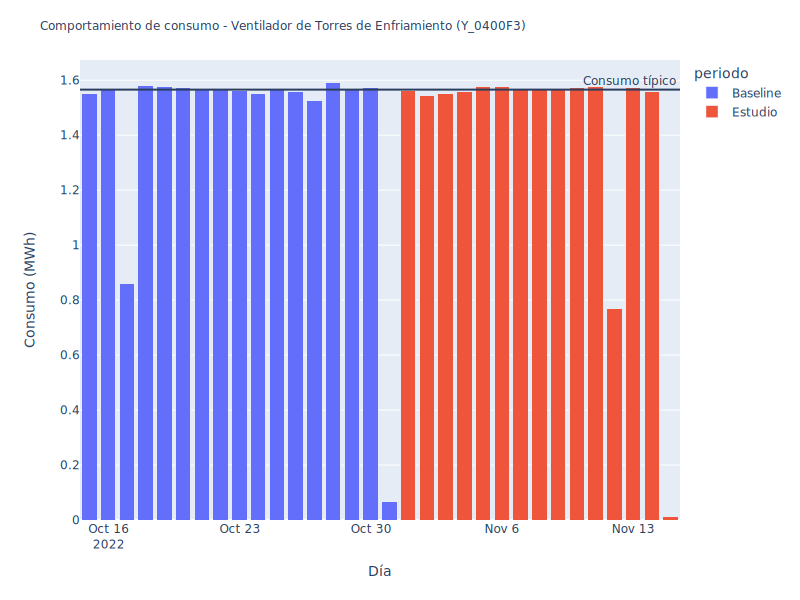

In [436]:
Y_0400F3_diario = Y_0400F3_complete.resample('D').sum().sort_values(by='timestamp', ascending=True).reset_index()
Y_0400F3_diario.replace(0, np.nan, inplace=True)
Y_0400F3_diario['periodo'] = np.where((Y_0400F3_diario['timestamp'] >= datetime.strptime(periodo_historico[0], "%Y-%m-%d")) & (Y_0400F3_diario['timestamp'] <= datetime.strptime(periodo_historico[1], "%Y-%m-%d")), 'Baseline', 'Estudio')

Y_0400F3_diario_LB=Y_0400F3_diario['Consumo (MWh)'].median()

fig = px.bar(Y_0400F3_diario, x="timestamp", y="Consumo (MWh)", color="periodo")

fig.add_hline(y=Y_0400F3_diario_LB, annotation_text=" Consumo típico")

fig.update_layout(barmode='stack', title='Comportamiento de consumo - Ventilador de Torres de Enfriamiento (Y_0400F3)',width=800, height=600, colorway=['#fc7703', '#757371'], xaxis_title="Día", yaxis_title="Consumo (MWh)", title_font_size=12)
fig.show()

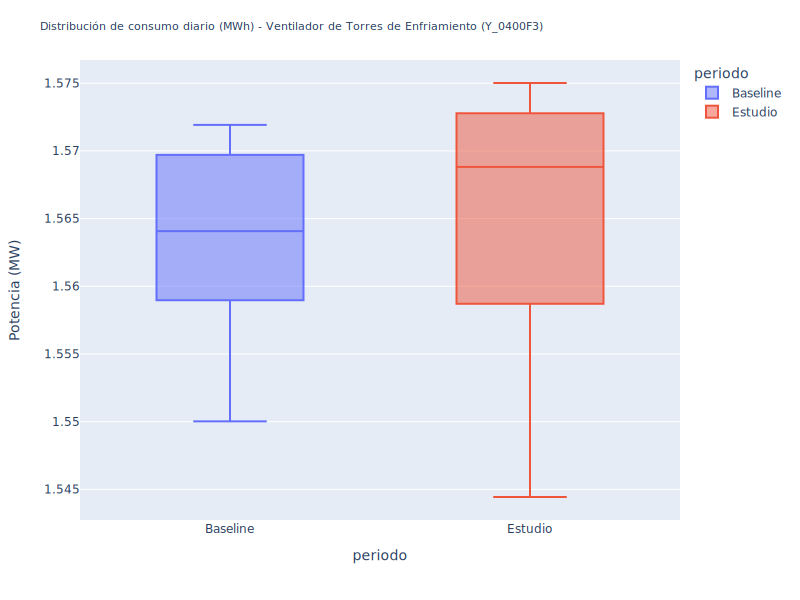

In [437]:
Y_0400F3_diario = Y_0400F3_diario.loc[(Y_0400F3_diario['Consumo (MWh)'].between(Y_0400F3_diario['Consumo (MWh)'].quantile(.15),Y_0400F3_diario['Consumo (MWh)'].quantile(.90)))]

Y_0400F3_LB = Y_0400F3_diario.loc[(Y_0400F3_diario['periodo']=="Baseline") & (Y_0400F3_diario['Consumo (MWh)'].between(Y_0400F3_diario['Consumo (MWh)'].quantile(.3),Y_0400F3_diario['Consumo (MWh)'].quantile(.6)))]['Consumo (MWh)'].mean()

fig = px.box(Y_0400F3_diario, x="periodo", y="Consumo (MWh)", color="periodo")
# fig.add_hline(y=Y_0400F3_LB, annotation_text=" Meta de consumo")
fig.update_layout(title_font=dict(size=12.5))
fig.update_layout( title='Distribución de consumo diario (MWh) - Ventilador de Torres de Enfriamiento (Y_0400F3)', width=800, height=600, colorway=['#fc7703', '#757371'], yaxis_title="Potencia (MW)", title_font_size=11)
fig.show()

### Ventilador de Torres de Enfriamiento (Y_0400F1M)

In [438]:
Y_0400F1M = Esenttia[Esenttia['Máquina'] == 'Ventilador de Torres de Enfriamiento (Y_0400F1M)']
Y_0400F1M_historico = Esenttia_historico[Esenttia_historico['Máquina'] == 'Ventilador de Torres de Enfriamiento (Y_0400F1M)']


mask_bl = (Y_0400F1M_historico['timestamp'] > periodo_historico[0]) & (Y_0400F1M_historico['timestamp'] <= periodo_historico[1])
Y_0400F1M_bl = Y_0400F1M_historico.loc[mask_bl]

mask_sp = (Y_0400F1M['timestamp'] >= periodo_de_estudio[0]) & (Y_0400F1M['timestamp'] <= periodo_de_estudio[1])
Y_0400F1M_sp = Y_0400F1M.loc[mask_sp]

Y_0400F1M_sp.replace(0, np.nan, inplace=True)
Y_0400F1M_bl.replace(0, np.nan, inplace=True)


Y_0400F1M_complete = pd.concat([Y_0400F1M_sp,Y_0400F1M_bl], axis=0)


Y_0400F1M_complete['periodo'] = np.where((Y_0400F1M_complete['timestamp'] >= datetime.strptime(periodo_historico[0], "%Y-%m-%d")) & (Y_0400F1M_complete['timestamp'] <= datetime.strptime(periodo_historico[1], "%Y-%m-%d")), 'Baseline', 'Estudio')


md(f"Durante el periodo de estudio, el consumo total fue de {Y_0400F1M_sp['Consumo (MWh)'].sum().round(2)} MWh")

Durante el periodo de estudio, el consumo total fue de 19.81 MWh

In [439]:
md(f"El consumo por día para el Ventilador de Torres de Enfriamiento (Y_0400F1M) puede ser observado en la siguiente gráfica:")

El consumo por día para el Ventilador de Torres de Enfriamiento (Y_0400F1M) puede ser observado en la siguiente gráfica:

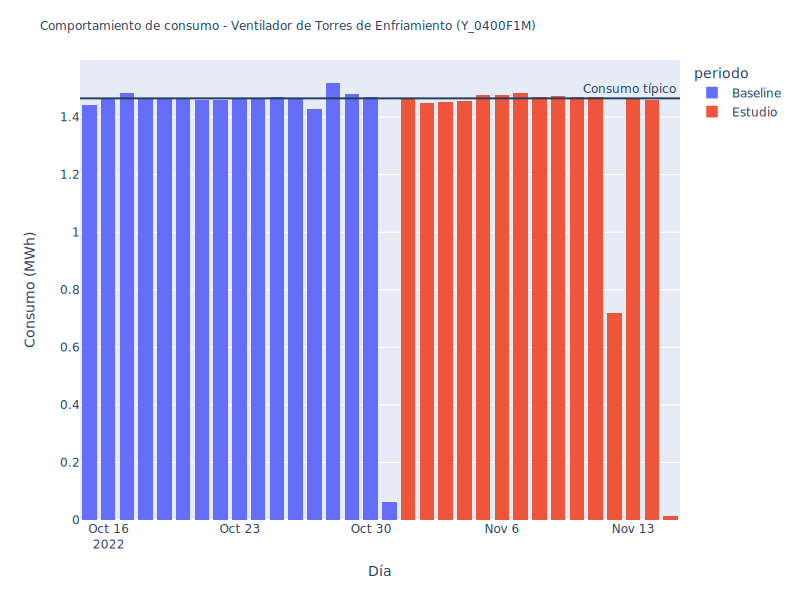

In [440]:
Y_0400F1M_diario = Y_0400F1M_complete.resample('D').sum().sort_values(by='timestamp', ascending=True).reset_index()
Y_0400F1M_diario.replace(0, np.nan, inplace=True)
Y_0400F1M_diario['periodo'] = np.where((Y_0400F1M_diario['timestamp'] >= datetime.strptime(periodo_historico[0], "%Y-%m-%d")) & (Y_0400F1M_diario['timestamp'] <= datetime.strptime(periodo_historico[1], "%Y-%m-%d")), 'Baseline', 'Estudio')

Y_0400F1M_diario_LB=Y_0400F1M_diario['Consumo (MWh)'].median()

fig = px.bar(Y_0400F1M_diario, x="timestamp", y="Consumo (MWh)", color="periodo")

fig.add_hline(y=Y_0400F1M_diario_LB, annotation_text=" Consumo típico")

fig.update_layout(barmode='stack', title='Comportamiento de consumo - Ventilador de Torres de Enfriamiento (Y_0400F1M)',width=800, height=600, colorway=['#fc7703', '#757371'], xaxis_title="Día", yaxis_title="Consumo (MWh)", title_font_size=12)
fig.show()

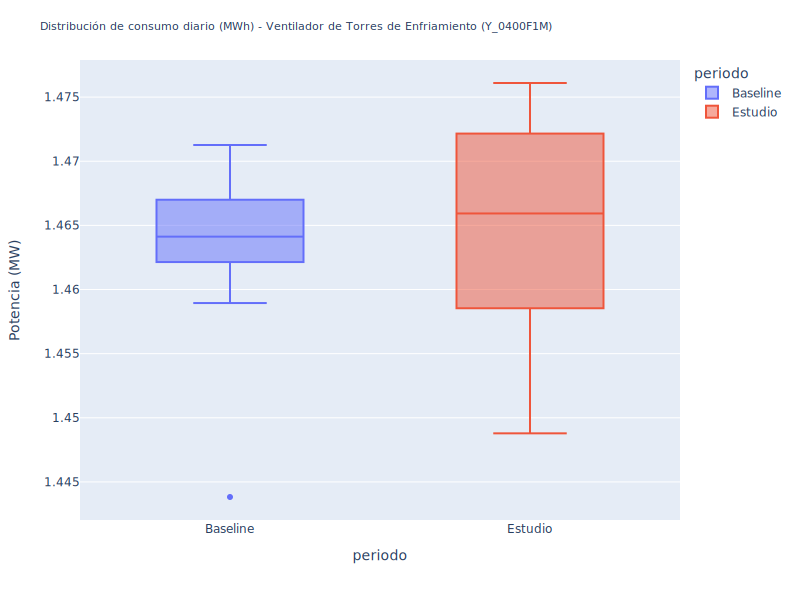

In [441]:
Y_0400F1M_diario = Y_0400F1M_diario.loc[(Y_0400F1M_diario['Consumo (MWh)'].between(Y_0400F1M_diario['Consumo (MWh)'].quantile(.10),Y_0400F1M_diario['Consumo (MWh)'].quantile(.85)))]


Y_0400F1M_LB = Y_0400F1M_diario.loc[(Y_0400F1M_diario['periodo']=="Baseline") & (Y_0400F1M_diario['Consumo (MWh)'].between(Y_0400F1M_diario['Consumo (MWh)'].quantile(.3),Y_0400F1M_diario['Consumo (MWh)'].quantile(.6)))]['Consumo (MWh)'].mean()

fig = px.box(Y_0400F1M_diario, x="periodo", y="Consumo (MWh)", color="periodo")
# fig.add_hline(y=Y_0400F1M_LB, annotation_text=" Meta de consumo")
fig.update_layout(title_font=dict(size=12.5))
fig.update_layout( title='Distribución de consumo diario (MWh) - Ventilador de Torres de Enfriamiento (Y_0400F1M)', width=800, height=600, colorway=['#fc7703', '#757371'], yaxis_title="Potencia (MW)", title_font_size=11)
fig.show()

### Compresor de Etileno (K-0253)

In [442]:
K_0253 = Esenttia[Esenttia['Máquina'] == 'Compresor de Etileno (K-0253)']
K_0253_historico = Esenttia_historico[Esenttia_historico['Máquina'] == 'Compresor de Etileno (K-0253)']


mask_bl = (K_0253_historico['timestamp'] > periodo_historico[0]) & (K_0253_historico['timestamp'] <= periodo_historico[1])
K_0253_bl = K_0253_historico.loc[mask_bl]

mask_sp = (K_0253['timestamp'] >= periodo_de_estudio[0]) & (K_0253['timestamp'] <= periodo_de_estudio[1])
K_0253_sp = K_0253.loc[mask_sp]

K_0253_sp.replace(0, np.nan, inplace=True)
K_0253_bl.replace(0, np.nan, inplace=True)


K_0253_complete = pd.concat([K_0253_sp,K_0253_bl], axis=0)


K_0253_complete['periodo'] = np.where((K_0253_complete['timestamp'] >= datetime.strptime(periodo_historico[0], "%Y-%m-%d")) & (K_0253_complete['timestamp'] <= datetime.strptime(periodo_historico[1], "%Y-%m-%d")), 'Baseline', 'Estudio')


md(f"Durante el periodo de estudio, el consumo total fue de {K_0253_sp['Consumo (MWh)'].sum().round(2)} MWh")

Durante el periodo de estudio, el consumo total fue de 50.1 MWh

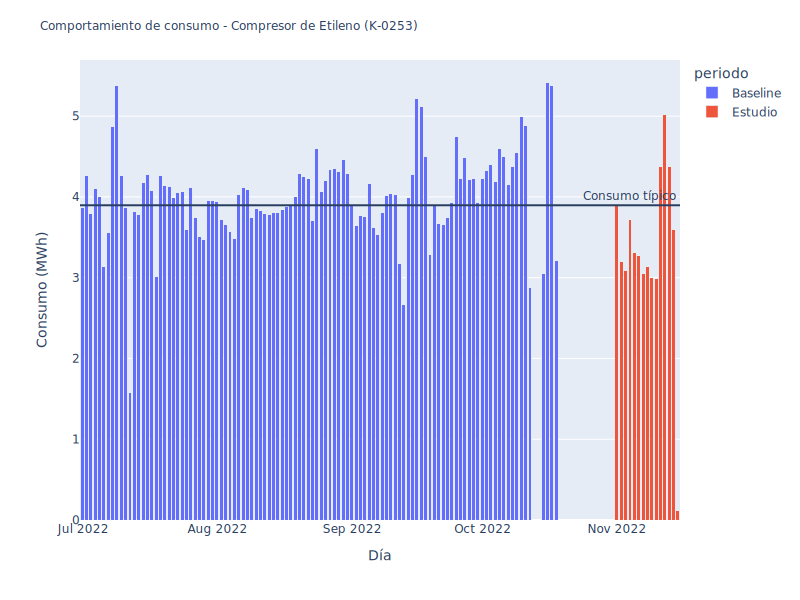

In [443]:
K_0253_diario = K_0253_complete.resample('D').sum().sort_values(by='timestamp', ascending=True).reset_index()
K_0253_diario.replace(0, np.nan, inplace=True)
K_0253_diario['periodo'] = np.where((K_0253_diario['timestamp'] >= datetime.strptime(periodo_historico[0], "%Y-%m-%d")) & (K_0253_diario['timestamp'] <= datetime.strptime(periodo_historico[1], "%Y-%m-%d")), 'Baseline', 'Estudio')

K_0253_diario_LB=K_0253_diario['Consumo (MWh)'].median()

fig = px.bar(K_0253_diario, x="timestamp", y="Consumo (MWh)", color="periodo")

fig.add_hline(y=K_0253_diario_LB, annotation_text=" Consumo típico")


fig.update_layout(barmode='stack', title='Comportamiento de consumo - Compresor de Etileno (K-0253)',width=800, height=600, colorway=['#fc7703', '#757371'], xaxis_title="Día", yaxis_title="Consumo (MWh)", title_font_size=12)
fig.show()

In [444]:

K_0253_complete = pd.DataFrame()
K_0253_historico_complete = pd.DataFrame()


Tags_0253  = ['FIX.P1-JI-0253.F_CV','FIX.P2-20PI-250.F_CV']

K_0253_complete = data[Tags_0253].astype(float)
K_0253_historico_complete = historic_data.loc[historic_data['NAME'].isin(Tags_0253)].drop('datetime', axis=1)

K_0253_historico_complete = K_0253_historico_complete.pivot_table(index='datetime', columns='NAME', values='Active power', aggfunc='mean')


K_0253_complete['KPI (MW KWh/kg)'] = K_0253_complete['FIX.P1-JI-0253.F_CV'] / K_0253_complete['FIX.P2-20PI-250.F_CV']
K_0253_historico_complete['KPI (MW KWh/kg)'] = K_0253_historico_complete['FIX.P1-JI-0253.F_CV'] / K_0253_historico_complete['FIX.P2-20PI-250.F_CV']

K_0253_complete['timestamp'] = pd.to_datetime(K_0253_complete.index)
K_0253_historico_complete['timestamp'] = pd.to_datetime(K_0253_historico_complete.index)


K_0253_complete['periodo'] = np.where((K_0253_complete['timestamp'] > datetime.strptime(periodo_historico[0], "%Y-%m-%d")) & (K_0253_complete['timestamp'] <= datetime.strptime(periodo_historico[1], "%Y-%m-%d")), 'Baseline', 'Estudio')
K_0253_historico_complete['periodo'] = np.where((K_0253_historico_complete['timestamp'] > datetime.strptime(periodo_historico[0], "%Y-%m-%d")) & (K_0253_historico_complete['timestamp'] <= datetime.strptime(periodo_historico[1], "%Y-%m-%d")), 'Baseline', 'Estudio')

K_0253_complete_sp = K_0253_complete[K_0253_complete['periodo']=='Estudio']


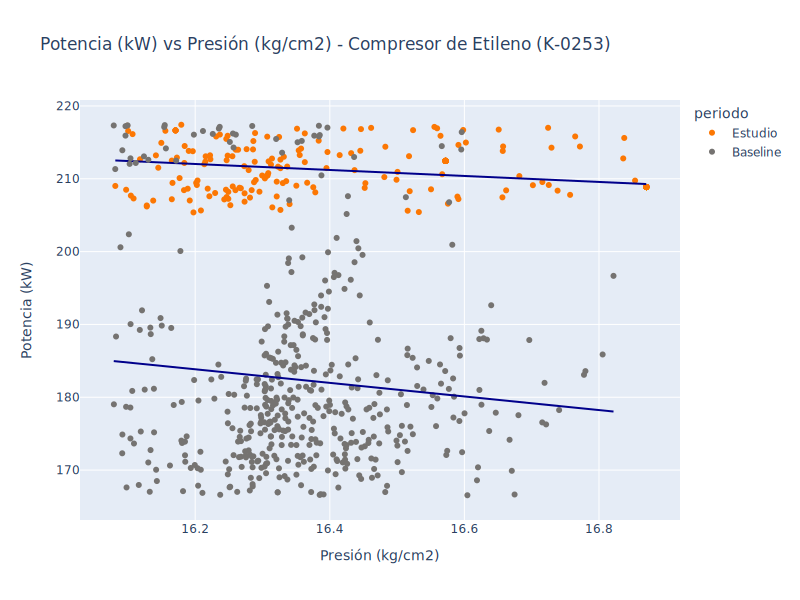

AIC Periodo de estudio 3733.7576389262176
AIC Periodo Anterior 1812.798567098104
R^2 Periodo de estudio 0.010039399115387981
R^2 Periodo Anterior 0.1873136950554708
MSE Periodo de estudio 165.66994806851946
MSE Periodo Anterior 6.798953944735207


In [445]:

K_0253_complete_scatter = pd.concat([K_0253_complete_sp,K_0253_historico_complete], axis = 0)


K_0253_complete_scatter = K_0253_complete_scatter[K_0253_complete_scatter['FIX.P1-JI-0253.F_CV'].between(K_0253_complete_scatter['FIX.P1-JI-0253.F_CV'].quantile(.5),K_0253_complete_scatter['FIX.P1-JI-0253.F_CV'].quantile(.95) ) ]
K_0253_complete_scatter = K_0253_complete_scatter[K_0253_complete_scatter['FIX.P2-20PI-250.F_CV'].between(K_0253_complete_scatter['FIX.P2-20PI-250.F_CV'].quantile(.5),K_0253_complete_scatter['FIX.P2-20PI-250.F_CV'].quantile(.95) ) ]

fig = px.scatter(K_0253_complete_scatter, y=K_0253_complete_scatter['FIX.P1-JI-0253.F_CV'], x=K_0253_complete_scatter['FIX.P2-20PI-250.F_CV'], color='periodo', trendline="ols", trendline_color_override="darkblue", title='Potencia (kW) vs Presión (kg/cm2) - Compresor de Etileno (K-0253)', width=800,
 height=600, color_discrete_map={'Baseline': '#757371', 'Estudio': '#fc7703'}, labels={'FIX.P1-JI-0253.F_CV': 'Potencia (kW)','FIX.P2-20PI-250.F_CV': 'Presión (kg/cm2)'})
fig.show()

print('AIC Periodo de estudio',px.get_trendline_results(fig)['px_fit_results'][1].aic)
print('AIC Periodo Anterior',px.get_trendline_results(fig)['px_fit_results'][0].aic)


print('R^2 Periodo de estudio',px.get_trendline_results(fig)['px_fit_results'][1].rsquared)
print('R^2 Periodo Anterior',px.get_trendline_results(fig)['px_fit_results'][0].rsquared)

print('MSE Periodo de estudio',px.get_trendline_results(fig)['px_fit_results'][1].mse_total)
print('MSE Periodo Anterior',px.get_trendline_results(fig)['px_fit_results'][0].mse_total)

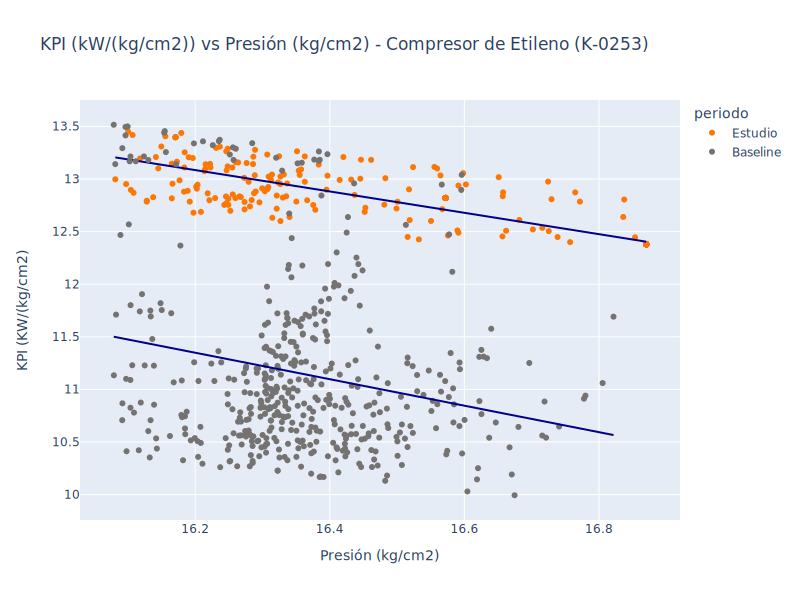

AIC Periodo de estudio 1109.9440051602196
AIC Periodo Anterior -417.60527276335165
R^2 Periodo de estudio 0.046756968901701446
R^2 Periodo Anterior 0.7926128914589698
MSE Periodo de estudio 0.6474009967961879
MSE Periodo Anterior 0.09812599823986361


In [446]:


fig = px.scatter(K_0253_complete_scatter, y=K_0253_complete_scatter['KPI (MW KWh/kg)'], x=K_0253_complete_scatter['FIX.P2-20PI-250.F_CV'], color='periodo', trendline="ols", trendline_color_override="darkblue", title='KPI (kW/(kg/cm2)) vs Presión (kg/cm2) - Compresor de Etileno (K-0253)', width=800,
 height=600, color_discrete_map={'Baseline': '#757371', 'Estudio': '#fc7703'}, labels={'KPI (MW KWh/kg)': 'KPI (KW/(kg/cm2)','FIX.P2-20PI-250.F_CV': 'Presión (kg/cm2)'})
fig.show()

print('AIC Periodo de estudio',px.get_trendline_results(fig)['px_fit_results'][1].aic)
print('AIC Periodo Anterior',px.get_trendline_results(fig)['px_fit_results'][0].aic)


print('R^2 Periodo de estudio',px.get_trendline_results(fig)['px_fit_results'][1].rsquared)
print('R^2 Periodo Anterior',px.get_trendline_results(fig)['px_fit_results'][0].rsquared)

print('MSE Periodo de estudio',px.get_trendline_results(fig)['px_fit_results'][1].mse_total)
print('MSE Periodo Anterior',px.get_trendline_results(fig)['px_fit_results'][0].mse_total)

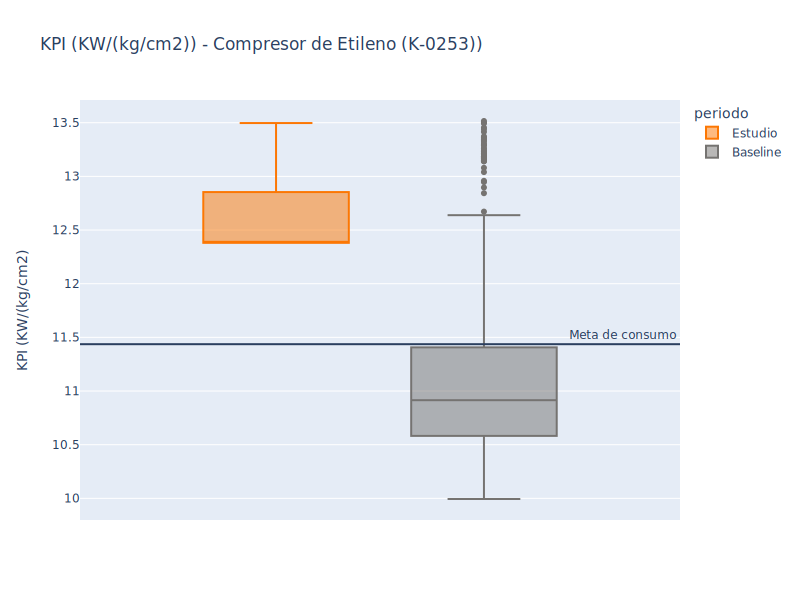

In [447]:
K_0253_LB = K_0253_complete_scatter.loc[(K_0253_complete_scatter['periodo']=="Baseline") & (K_0253_complete_scatter['KPI (MW KWh/kg)'].between(K_0253_complete_scatter['KPI (MW KWh/kg)'].quantile(.3),K_0253_complete_scatter['KPI (MW KWh/kg)'].quantile(.6)))]['KPI (MW KWh/kg)'].mean()


fig = px.box(K_0253_complete_scatter, y=K_0253_complete_scatter['KPI (MW KWh/kg)'], color='periodo',  title='KPI (KW/(kg/cm2)) - Compresor de Etileno (K-0253))', width=800,
 height=600, color_discrete_map={'Baseline': '#757371', 'Estudio': '#fc7703'}, labels={'KPI (MW KWh/kg)': 'KPI (KW/(kg/cm2)'})

fig.add_hline(y=K_0253_LB, annotation_text=" Meta de consumo")
fig.show()

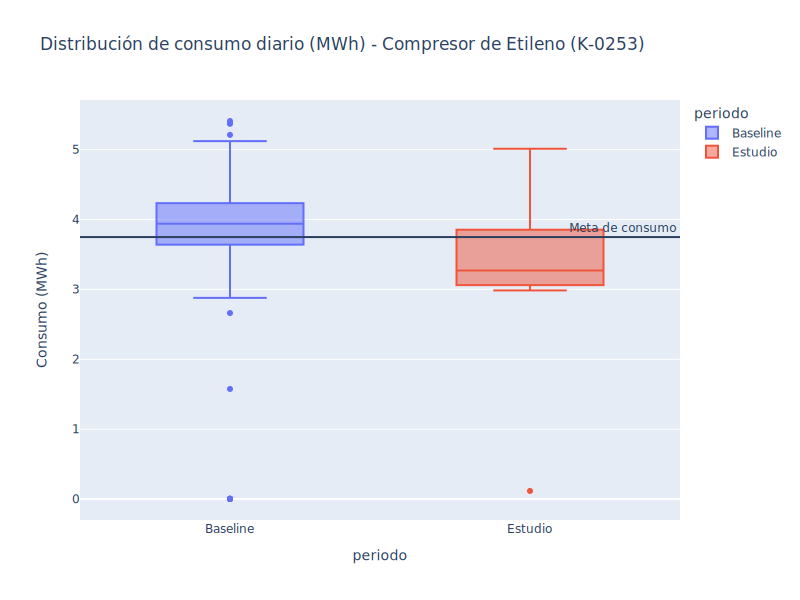

In [448]:
K_0253_LB = K_0253_diario.loc[(K_0253_diario['periodo']=="Baseline") & (K_0253_diario['Consumo (MWh)'].between(K_0253_diario['Consumo (MWh)'].quantile(.25),K_0253_diario['Consumo (MWh)'].quantile(.5)))]['Consumo (MWh)'].mean()


fig = px.box(K_0253_diario, x="periodo", y="Consumo (MWh)", color="periodo",  labels={'FIX.P1-JI-0204.F_CV': 'Potencia (kW)'}, title='Distribución de consumo diario (MWh) - Compresor de Etileno (K-0253)', width=800,
 height=600)
fig.add_hline(y=K_0253_LB, annotation_text=" Meta de consumo")
fig.show()

### Compresor de Propileno (K-0204)

In [449]:
K_0204 = Esenttia[Esenttia['Máquina'] == 'Compresor de Propileno (K-0204)']
K_0204_historico = Esenttia_historico[Esenttia_historico['Máquina'] == 'Compresor de Propileno (K-0204)']


mask_bl = (K_0204_historico['timestamp'] > periodo_historico[0]) & (K_0204_historico['timestamp'] <= periodo_historico[1])
K_0204_bl = K_0204_historico.loc[mask_bl]

mask_sp = (K_0204['timestamp'] >= periodo_de_estudio[0]) & (K_0204['timestamp'] <= periodo_de_estudio[1])
K_0204_sp = K_0204.loc[mask_sp]

K_0204_sp.replace(0, np.nan, inplace=True)
K_0204_bl.replace(0, np.nan, inplace=True)


K_0204_complete = pd.concat([K_0204_sp,K_0204_bl], axis=0)


K_0204_complete['periodo'] = np.where((K_0204_complete['timestamp'] >= datetime.strptime(periodo_historico[0], "%Y-%m-%d")) & (K_0204_complete['timestamp'] <= datetime.strptime(periodo_historico[1], "%Y-%m-%d")), 'Baseline', 'Estudio')


md(f"Durante el periodo de estudio, el consumo total fue de {K_0204_sp['Consumo (MWh)'].sum().round(2)} MWh")

Durante el periodo de estudio, el consumo total fue de 91.75 MWh

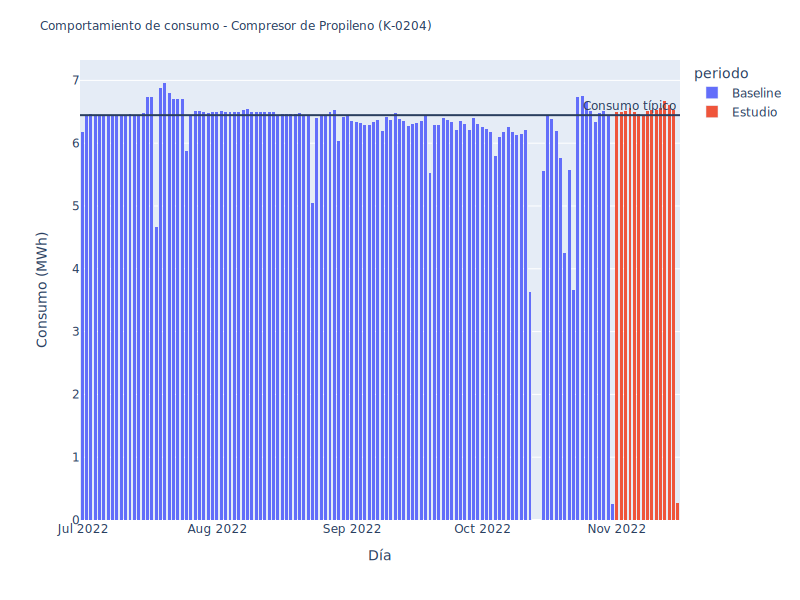

In [450]:
K_0204_diario = K_0204_complete.resample('D').sum().sort_values(by='timestamp', ascending=True).reset_index()
K_0204_diario.replace(0, np.nan, inplace=True)
K_0204_diario['periodo'] = np.where((K_0204_diario['timestamp'] >= datetime.strptime(periodo_historico[0], "%Y-%m-%d")) & (K_0204_diario['timestamp'] <= datetime.strptime(periodo_historico[1], "%Y-%m-%d")), 'Baseline', 'Estudio')

K_0204_diario_LB=K_0204_diario['Consumo (MWh)'].median()

fig = px.bar(K_0204_diario, x="timestamp", y="Consumo (MWh)", color="periodo")

fig.add_hline(y=K_0204_diario_LB, annotation_text=" Consumo típico")


fig.update_layout(barmode='stack', title='Comportamiento de consumo - Compresor de Propileno (K-0204)',width=800, height=600, colorway=['#fc7703', '#757371'], xaxis_title="Día", yaxis_title="Consumo (MWh)", title_font_size=12)
fig.show()

In [451]:

K_0204_complete = pd.DataFrame()
K_0204_historico_complete = pd.DataFrame()

Tags_K_0204  = ['FIX.20PI-120.F_CV','FIX.20PIC-102.F_CV','FIX.20TI-151.F_CV','FIX.20TIC-103.F_CV','FIX.P1-JI-0204.F_CV']

K_0204_complete = data[Tags_K_0204].astype(float)
K_0204_historico_complete = historic_data.loc[historic_data['NAME'].isin(Tags_K_0204)].drop('datetime', axis=1)

K_0204_historico_complete = K_0204_historico_complete.pivot_table(index='datetime', columns='NAME', values='Active power', aggfunc='mean')


K_0204_complete['KPI (MW KWh/kg)'] = K_0204_complete['FIX.P1-JI-0204.F_CV'] / abs(K_0204_complete['FIX.20PI-120.F_CV'] - K_0204_complete['FIX.20PIC-102.F_CV'])
K_0204_historico_complete['KPI (MW KWh/kg)'] = K_0204_historico_complete['FIX.P1-JI-0204.F_CV'] / abs(K_0204_historico_complete['FIX.20PI-120.F_CV'] - K_0204_historico_complete['FIX.20PIC-102.F_CV'])

K_0204_complete = K_0204_complete[K_0204_complete['FIX.P1-JI-0204.F_CV'].between(K_0204_complete['FIX.P1-JI-0204.F_CV'].quantile(.1),K_0204_complete['FIX.P1-JI-0204.F_CV'].quantile(.95) ) ]
K_0204_complete = K_0204_complete[K_0204_complete['KPI (MW KWh/kg)'].between(K_0204_complete['KPI (MW KWh/kg)'].quantile(.1),K_0204_complete['KPI (MW KWh/kg)'].quantile(.95) ) ]

K_0204_historico_complete = K_0204_historico_complete[K_0204_historico_complete['FIX.P1-JI-0204.F_CV'].between(K_0204_historico_complete['FIX.P1-JI-0204.F_CV'].quantile(.1),K_0204_historico_complete['FIX.P1-JI-0204.F_CV'].quantile(.95) ) ]
K_0204_historico_complete = K_0204_historico_complete[K_0204_historico_complete['KPI (MW KWh/kg)'].between(K_0204_historico_complete['KPI (MW KWh/kg)'].quantile(.1),K_0204_historico_complete['KPI (MW KWh/kg)'].quantile(.95) ) ]


K_0204_complete['timestamp'] = pd.to_datetime(K_0204_complete.index)
K_0204_historico_complete['timestamp'] = pd.to_datetime(K_0204_historico_complete.index)

K_0204_complete['periodo'] = np.where((K_0204_complete['timestamp'] > datetime.strptime(periodo_historico[0], "%Y-%m-%d")) & (K_0204_complete['timestamp'] <= datetime.strptime(periodo_historico[1], "%Y-%m-%d")), 'Baseline', 'Estudio')
K_0204_historico_complete['periodo'] = np.where((K_0204_historico_complete['timestamp'] > datetime.strptime(periodo_historico[0], "%Y-%m-%d")) & (K_0204_historico_complete['timestamp'] <= datetime.strptime(periodo_historico[1], "%Y-%m-%d")), 'Baseline', 'Estudio')

K_0204_complete_sp = K_0204_complete[K_0204_complete['periodo']=='Estudio']

K_0204_complete_bl = K_0204_complete[K_0204_complete['periodo']=='Baseline']


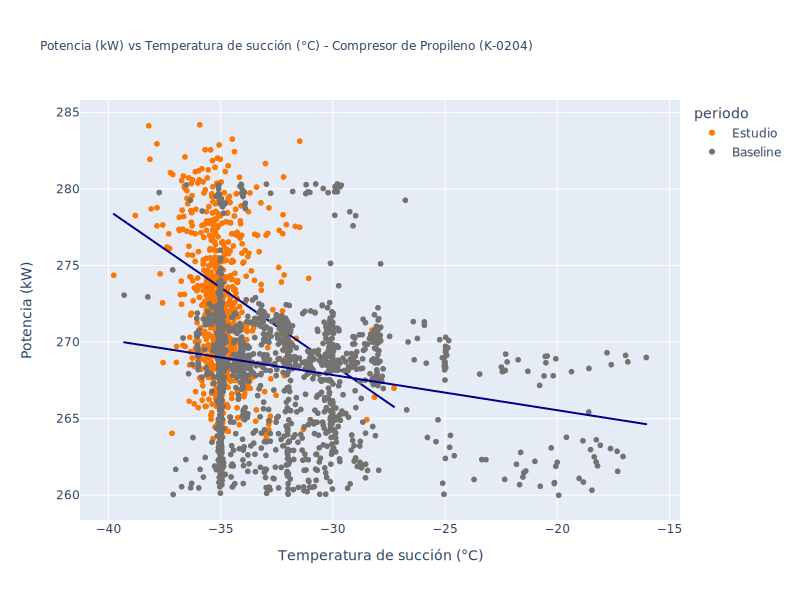

AIC Periodo de estudio 9792.15569405221
AIC Periodo Anterior 6196.88184506254
R^2 Periodo de estudio 0.04194788252652193
R^2 Periodo Anterior 0.04757165759811821
MSE Periodo de estudio 14.40643064478909
MSE Periodo Anterior 21.798514846747075


In [452]:

K_0204_complete_scatter = pd.concat([K_0204_complete_sp,K_0204_historico_complete], axis = 0)


fig = px.scatter(K_0204_complete_scatter, y=K_0204_complete_scatter['FIX.P1-JI-0204.F_CV'], x=K_0204_complete_scatter['FIX.20TIC-103.F_CV'], color='periodo', trendline="ols", trendline_color_override="darkblue", title='Potencia (kW) vs Temperatura de succión (°C) - Compresor de Propileno (K-0204)', width=800,
 height=600, color_discrete_map={'Baseline': '#757371', 'Estudio': '#fc7703'}, labels={'FIX.P1-JI-0204.F_CV': 'Potencia (kW)', 'FIX.20TIC-103.F_CV': 'Temperatura de succión (°C)'})
fig.update_layout(title_font_size=12)
fig.show()

print('AIC Periodo de estudio',px.get_trendline_results(fig)['px_fit_results'][1].aic)
print('AIC Periodo Anterior',px.get_trendline_results(fig)['px_fit_results'][0].aic)


print('R^2 Periodo de estudio',px.get_trendline_results(fig)['px_fit_results'][1].rsquared)
print('R^2 Periodo Anterior',px.get_trendline_results(fig)['px_fit_results'][0].rsquared)

print('MSE Periodo de estudio',px.get_trendline_results(fig)['px_fit_results'][1].mse_total)
print('MSE Periodo Anterior',px.get_trendline_results(fig)['px_fit_results'][0].mse_total)

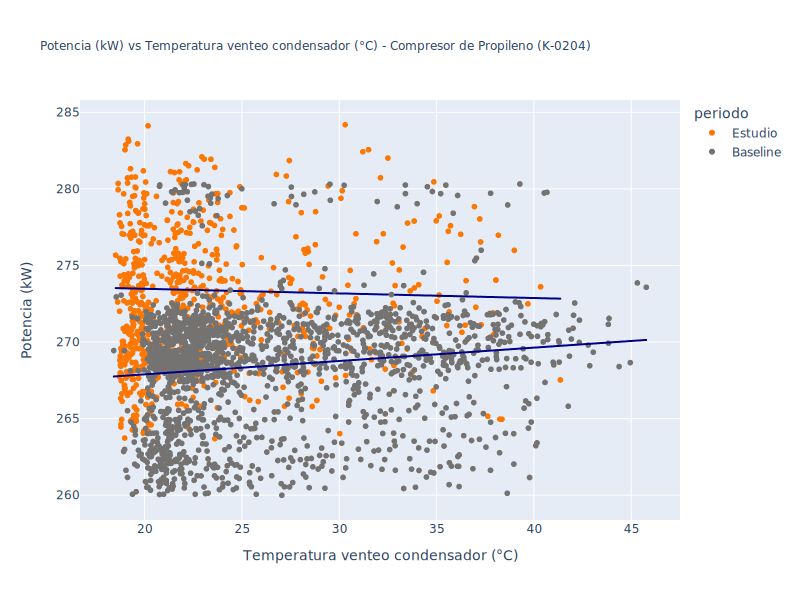

AIC Periodo de estudio 9836.038343752825
AIC Periodo Anterior 6247.467889698795
R^2 Periodo de estudio 0.01819740508862977
R^2 Periodo Anterior 0.000791235218494557
MSE Periodo de estudio 14.40643064478909
MSE Periodo Anterior 21.79851484674707


In [453]:
fig = px.scatter(K_0204_complete_scatter, y=K_0204_complete_scatter['FIX.P1-JI-0204.F_CV'], x=K_0204_complete_scatter['FIX.20TI-151.F_CV'], color='periodo', trendline="ols", trendline_color_override="darkblue", title='Potencia (kW) vs Temperatura venteo condensador (°C) - Compresor de Propileno (K-0204)', width=800,
 height=600, color_discrete_map={'Baseline': '#757371', 'Estudio': '#fc7703'}, labels={'FIX.P1-JI-0204.F_CV': 'Potencia (kW)', 'FIX.20TI-151.F_CV': 'Temperatura venteo condensador (°C)'})
fig.update_layout(title_font_size=12)
fig.show()

print('AIC Periodo de estudio',px.get_trendline_results(fig)['px_fit_results'][1].aic)
print('AIC Periodo Anterior',px.get_trendline_results(fig)['px_fit_results'][0].aic)


print('R^2 Periodo de estudio',px.get_trendline_results(fig)['px_fit_results'][1].rsquared)
print('R^2 Periodo Anterior',px.get_trendline_results(fig)['px_fit_results'][0].rsquared)

print('MSE Periodo de estudio',px.get_trendline_results(fig)['px_fit_results'][1].mse_total)
print('MSE Periodo Anterior',px.get_trendline_results(fig)['px_fit_results'][0].mse_total)

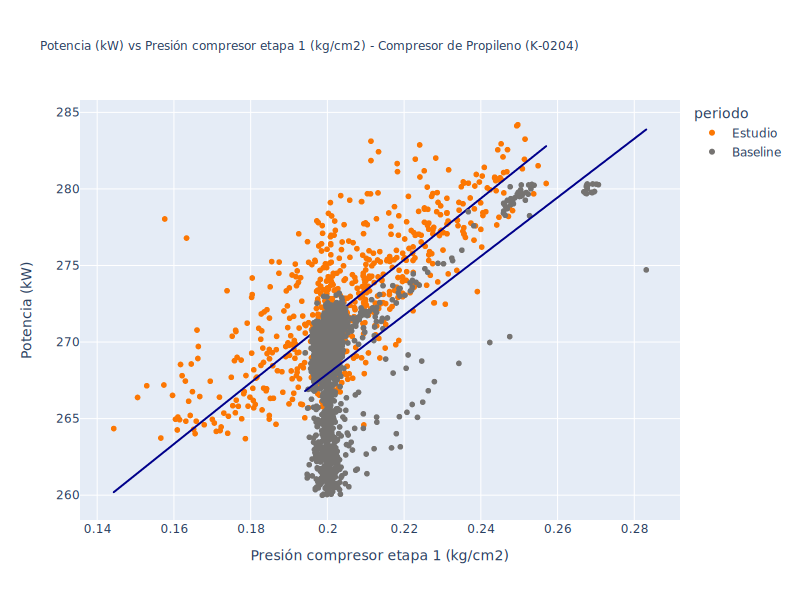

AIC Periodo de estudio 9260.439861204191
AIC Periodo Anterior 5052.305413023516
R^2 Periodo de estudio 0.28792321173473834
R^2 Periodo Anterior 0.6781426926523524
MSE Periodo de estudio 14.40643064478909
MSE Periodo Anterior 21.798514846747075


In [454]:
fig = px.scatter(K_0204_complete_scatter, y=K_0204_complete_scatter['FIX.P1-JI-0204.F_CV'], x=K_0204_complete_scatter['FIX.20PIC-102.F_CV'], color='periodo', trendline="ols", trendline_color_override="darkblue", title='Potencia (kW) vs Presión compresor etapa 1 (kg/cm2) - Compresor de Propileno (K-0204)', width=800,
 height=600, color_discrete_map={'Baseline': '#757371', 'Estudio': '#fc7703'}, labels={'FIX.P1-JI-0204.F_CV': 'Potencia (kW)', 'FIX.20PIC-102.F_CV': 'Presión compresor etapa 1 (kg/cm2)'})
fig.update_layout(title_font_size=12)
fig.show()

print('AIC Periodo de estudio',px.get_trendline_results(fig)['px_fit_results'][1].aic)
print('AIC Periodo Anterior',px.get_trendline_results(fig)['px_fit_results'][0].aic)


print('R^2 Periodo de estudio',px.get_trendline_results(fig)['px_fit_results'][1].rsquared)
print('R^2 Periodo Anterior',px.get_trendline_results(fig)['px_fit_results'][0].rsquared)

print('MSE Periodo de estudio',px.get_trendline_results(fig)['px_fit_results'][1].mse_total)
print('MSE Periodo Anterior',px.get_trendline_results(fig)['px_fit_results'][0].mse_total)

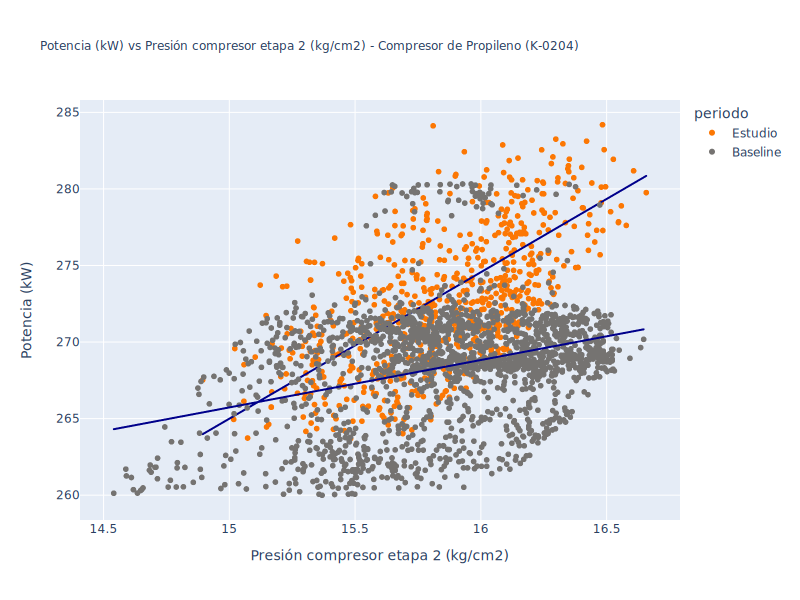

AIC Periodo de estudio 9668.74803951948
AIC Periodo Anterior 5465.790285714735
R^2 Periodo de estudio 0.10570446177084769
R^2 Periodo Anterior 0.5237051516721978
MSE Periodo de estudio 14.40643064478909
MSE Periodo Anterior 21.79851484674707


In [455]:
fig = px.scatter(K_0204_complete_scatter, y=K_0204_complete_scatter['FIX.P1-JI-0204.F_CV'], x=K_0204_complete_scatter['FIX.20PI-120.F_CV'], color='periodo', trendline="ols", trendline_color_override="darkblue", title='Potencia (kW) vs Presión compresor etapa 2 (kg/cm2) - Compresor de Propileno (K-0204)', width=800,
 height=600, color_discrete_map={'Baseline': '#757371', 'Estudio': '#fc7703'}, labels={'FIX.P1-JI-0204.F_CV': 'Potencia (kW)', 'FIX.20PI-120.F_CV': 'Presión compresor etapa 2 (kg/cm2)'})
fig.update_layout(title_font_size=12)
fig.show()

print('AIC Periodo de estudio',px.get_trendline_results(fig)['px_fit_results'][1].aic)
print('AIC Periodo Anterior',px.get_trendline_results(fig)['px_fit_results'][0].aic)


print('R^2 Periodo de estudio',px.get_trendline_results(fig)['px_fit_results'][1].rsquared)
print('R^2 Periodo Anterior',px.get_trendline_results(fig)['px_fit_results'][0].rsquared)

print('MSE Periodo de estudio',px.get_trendline_results(fig)['px_fit_results'][1].mse_total)
print('MSE Periodo Anterior',px.get_trendline_results(fig)['px_fit_results'][0].mse_total)

In [456]:

# import seaborn as sns

# interest = ['FIX.20PI-120.F_CV','FIX.20PIC-102.F_CV','FIX.20TI-151.F_CV','FIX.20TIC-103.F_CV','FIX.P1-JI-0204.F_CV','KPI (MW KWh/kg)']
# sns.pairplot(K_0204_complete, hue="periodo", height=2.5, vars = interest)

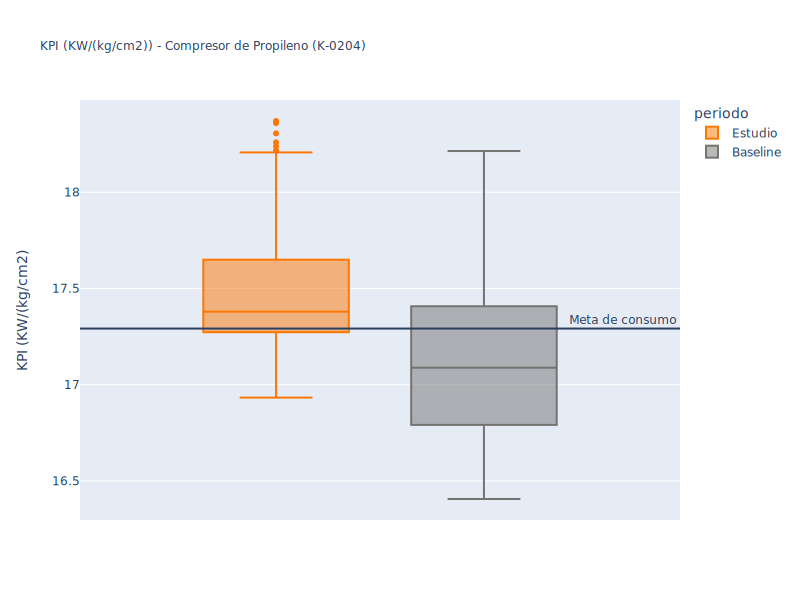

In [457]:
K_0204_LB = K_0204_complete_scatter.loc[(K_0204_complete_scatter['periodo']=="Baseline") & (K_0204_complete_scatter['KPI (MW KWh/kg)'].between(K_0204_complete_bl['KPI (MW KWh/kg)'].quantile(.0),K_0204_complete_bl['KPI (MW KWh/kg)'].quantile(.6)))]['KPI (MW KWh/kg)'].mean()

fig = px.box(K_0204_complete_scatter, y=K_0204_complete_scatter['KPI (MW KWh/kg)'], color='periodo',  title='KPI (KW/(kg/cm2)) - Compresor de Propileno (K-0204)', width=800,
 height=600, color_discrete_map={'Baseline': '#757371', 'Estudio': '#fc7703'}, labels={'KPI (MW KWh/kg)': 'KPI (KW/(kg/cm2)'})
fig.add_hline(y=K_0204_LB, annotation_text=" Meta de consumo")
fig.update_layout(title_font_size=12)
fig.show()

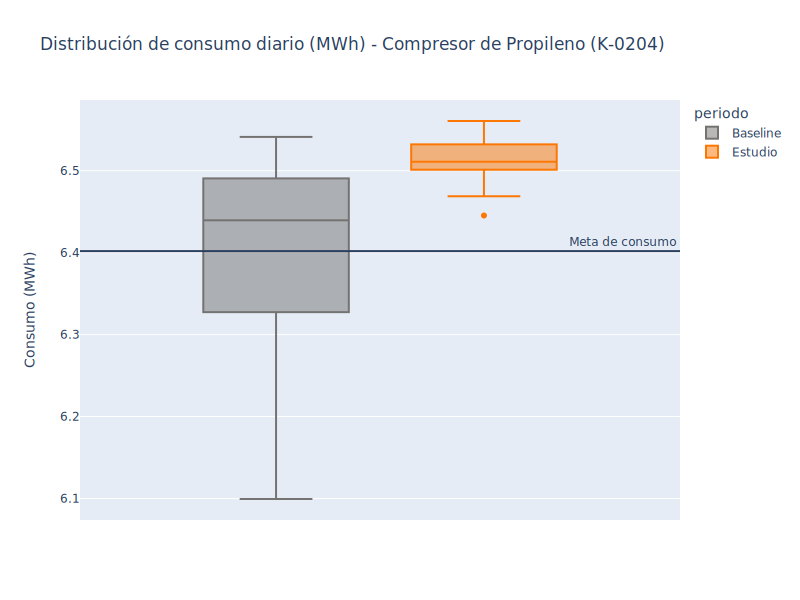

In [458]:
K_0204_diario = K_0204_diario.loc[(K_0204_diario['Consumo (MWh)'].between(K_0204_diario['Consumo (MWh)'].quantile(.10),K_0204_diario['Consumo (MWh)'].quantile(.90)))]


K_0204_LB = K_0204_diario.loc[(K_0204_diario['periodo']=="Baseline") & (K_0204_diario['Consumo (MWh)'].between(K_0204_diario['Consumo (MWh)'].quantile(.25),K_0204_diario['Consumo (MWh)'].quantile(.5)))]['Consumo (MWh)'].mean()


fig = px.box(K_0204_diario, y=K_0204_diario['Consumo (MWh)'], color='periodo',  title='Distribución de consumo diario (MWh) - Compresor de Propileno (K-0204)', width=800,
 height=600, color_discrete_map={'Baseline': '#757371', 'Estudio': '#fc7703'}, labels={'FIX.P1-JI-0204.F_CV': 'Potencia (kW)'})
fig.add_hline(y=K_0204_LB, annotation_text=" Meta de consumo")
fig.show()

#### Modelación Analítica

R^2 medio 0.5736841500139191
Error cuadratico medio sobre el conjunto de Test: 9.26 kW


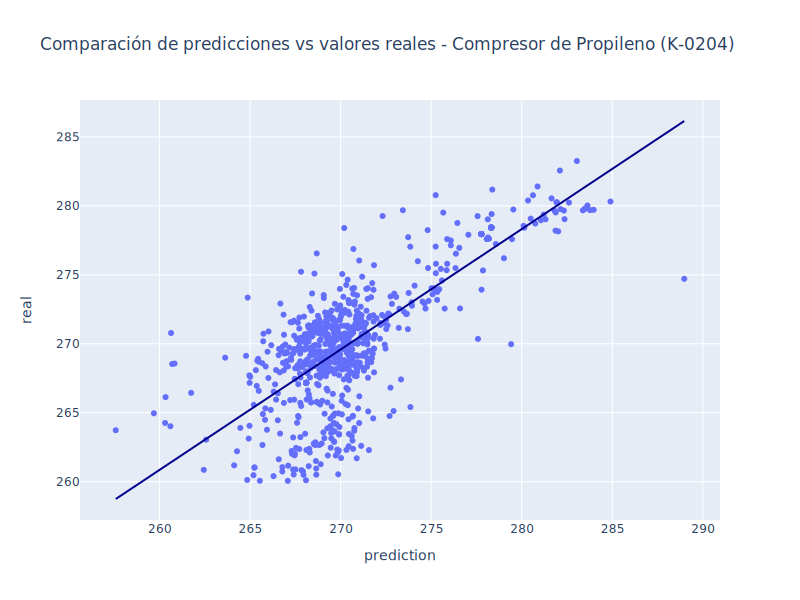

Peso
Presión de succión etapa 1      31.54
Presion de descarga etapa 2      5.88
Temperatura venteo condensador  -1.84
Temperatura de succión          -7.85

In [459]:
Feature_Tags_K0204  = ['FIX.20PI-120.F_CV','FIX.20PIC-102.F_CV','FIX.20TI-151.F_CV','FIX.20TIC-103.F_CV']

Feature_Names_K0204 = ['Presion de descarga etapa 2','Presión de succión etapa 1','Temperatura venteo condensador','Temperatura de succión']

Output_Tags_K0204 = ['FIX.P1-JI-0204.F_CV']


K_0204_complete_features = K_0204_complete_scatter[Feature_Tags_K0204]
K_0204_complete_output = K_0204_complete_scatter[Output_Tags_K0204]

from sklearn import svm
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split

scaler = MinMaxScaler()

X = scaler.fit_transform(K_0204_complete_features)
y = K_0204_complete_output.values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42)



SVR = svm.SVR(kernel='linear', C=1e3, gamma=0.1)
validation = cross_validate(SVR, X_train, y_train, cv=10, scoring='r2', return_estimator=True)
print('R^2 medio',validation['test_score'].mean())




best_estimator = validation['estimator'][np.argmax(validation['test_score'])]


prediction = best_estimator.predict(X_test)

comparison = pd.DataFrame([prediction, y_test.flatten()]).T
comparison.columns = ['prediction', 'real']

MSE = np.mean((prediction - y_test.flatten())**2)
print(f"Error cuadratico medio sobre el conjunto de Test: {MSE.round(2)} kW")

fig = px.scatter(comparison, x=comparison['prediction'], y=comparison['real'], trendline="ols", trendline_color_override="darkblue", title='Comparación de predicciones vs valores reales - Compresor de Propileno (K-0204)', width=800,
height=600)
fig.show()

coeficientes = pd.DataFrame(best_estimator.coef_.T, index=Feature_Names_K0204, columns=['Peso'])
coeficientes.round(2).sort_values(by='Peso', ascending=False)

# print('Los coeficientes del modelo son: ', best_estimator.coef_)
# print('El intercepto del modelo es: ', best_estimator.intercept_)
# print('los nombres de las variables son: ', Feature_Names_K0204)

### Motor Soplador Aire de Transporte (K-0303-M)

In [460]:
K_0303_M = Esenttia[Esenttia['Máquina'] == 'Motor Soplador Aire de Transporte (K-0303-M)']
K_0303_M_historico = Esenttia_historico[Esenttia_historico['Máquina'] == 'Motor Soplador Aire de Transporte (K-0303-M)']


mask_bl = (K_0303_M_historico['timestamp'] > periodo_historico[0]) & (K_0303_M_historico['timestamp'] <= periodo_historico[1])
K_0303_M_bl = K_0303_M_historico.loc[mask_bl]

mask_sp = (K_0303_M['timestamp'] >= periodo_de_estudio[0]) & (K_0303_M['timestamp'] <= periodo_de_estudio[1])
K_0303_M_sp = K_0303_M.loc[mask_sp]

K_0303_M_sp.replace(0, np.nan, inplace=True)
K_0303_M_bl.replace(0, np.nan, inplace=True)


K_0303_M_complete = pd.concat([K_0303_M_sp,K_0303_M_bl], axis=0)


K_0303_M_complete['periodo'] = np.where((K_0303_M_complete['timestamp'] >= datetime.strptime(periodo_historico[0], "%Y-%m-%d")) & (K_0303_M_complete['timestamp'] <= datetime.strptime(periodo_historico[1], "%Y-%m-%d")), 'Baseline', 'Estudio')


md(f"Durante el periodo de estudio, el consumo total fue de {K_0303_M_sp['Consumo (MWh)'].sum().round(2)} MWh")

Durante el periodo de estudio, el consumo total fue de 29.94 MWh

In [461]:
md(f"El consumo por día para el Motor Soplador Aire de Transporte (K-0303-M) puede ser observado en la siguiente gráfica:")

El consumo por día para el Motor Soplador Aire de Transporte (K-0303-M) puede ser observado en la siguiente gráfica:

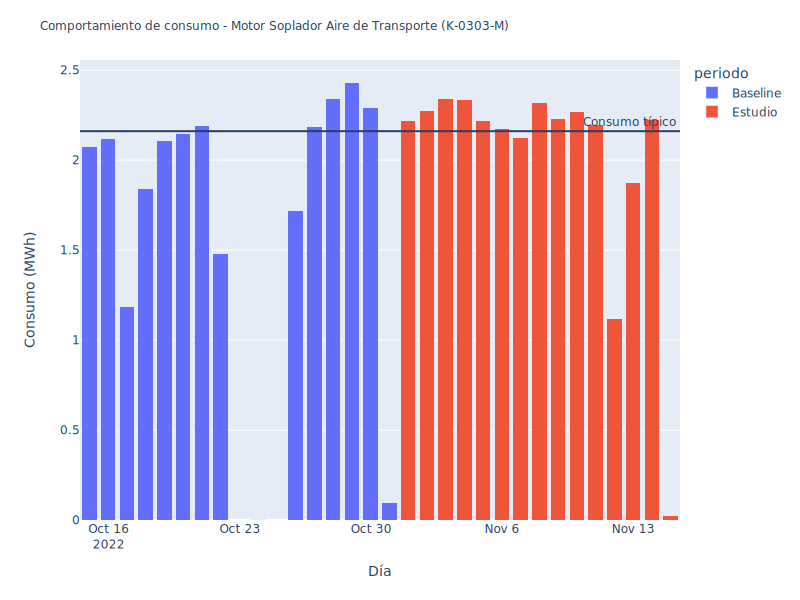

In [462]:
K_0303_M_diario = K_0303_M_complete.resample('D').sum().sort_values(by='timestamp', ascending=True).reset_index()
K_0303_M_diario.replace(0, np.nan, inplace=True)
K_0303_M_diario['periodo'] = np.where((K_0303_M_diario['timestamp'] >= datetime.strptime(periodo_historico[0], "%Y-%m-%d")) & (K_0303_M_diario['timestamp'] <= datetime.strptime(periodo_historico[1], "%Y-%m-%d")), 'Baseline', 'Estudio')

K_0303_M_diario_LB=K_0303_M_diario['Consumo (MWh)'].median()

fig = px.bar(K_0303_M_diario, x="timestamp", y="Consumo (MWh)", color="periodo")


fig.add_hline(y=K_0303_M_diario_LB, annotation_text=" Consumo típico")


fig.update_layout(barmode='stack', title='Comportamiento de consumo - Motor Soplador Aire de Transporte (K-0303-M)',width=800, height=600, colorway=['#fc7703', '#757371'], xaxis_title="Día", yaxis_title="Consumo (MWh)", title_font_size=12)
fig.show()

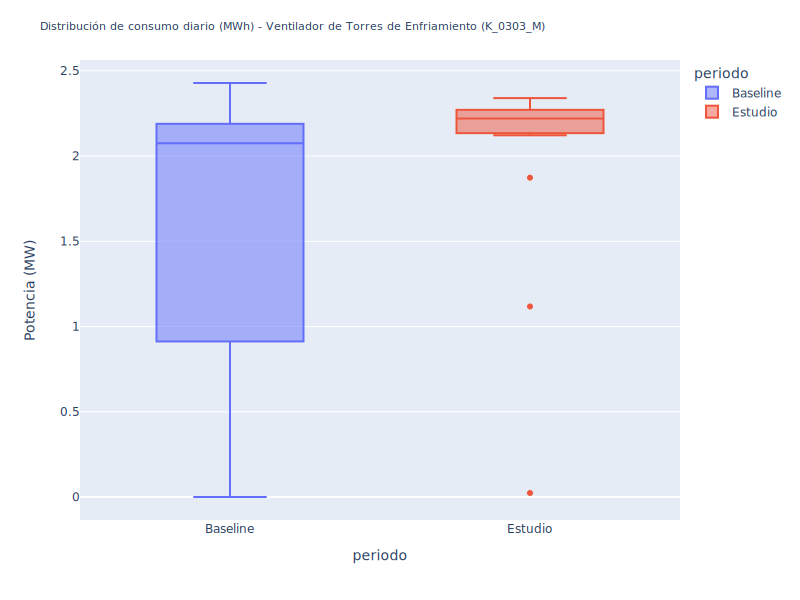

In [463]:
K_0303_M_LB = K_0303_M_diario.loc[(K_0303_M_diario['periodo']=="Baseline") & (K_0303_M_diario['Consumo (MWh)'].between(K_0303_M_diario['Consumo (MWh)'].quantile(.3),K_0303_M_diario['Consumo (MWh)'].quantile(.6)))]['Consumo (MWh)'].mean()

fig = px.box(K_0303_M_diario, x="periodo", y="Consumo (MWh)", color="periodo")
# fig.add_hline(y=K_0303_M_LB, annotation_text=" Meta de consumo")
fig.update_layout(title_font=dict(size=12.5))
fig.update_layout( title='Distribución de consumo diario (MWh) - Ventilador de Torres de Enfriamiento (K_0303_M)', width=800, height=600, colorway=['#fc7703', '#757371'], yaxis_title="Potencia (MW)", title_font_size=11)
fig.show()

### Soplador de Transporte de Pellets (K-0305), Soplador hacia el Silo de Almacenamiento (K-0308) & Soplador hacia Empaque (K-0311)

In [464]:
K_0305 = Esenttia[Esenttia['Máquina'] == 'Soplador de Transporte de Pellets (K-0305), Soplador hacia el Silo de Almacenamiento (K-0308) & Soplador hacia Empaque (K-0311)']
K_0305_historico = Esenttia_historico[Esenttia_historico['Máquina'] == 'Soplador de Transporte de Pellets (K-0305), Soplador hacia el Silo de Almacenamiento (K-0308) & Soplador hacia Empaque (K-0311)']


mask_bl = (K_0305_historico['timestamp'] > periodo_historico[0]) & (K_0305_historico['timestamp'] <= periodo_historico[1])
K_0305_bl = K_0305_historico.loc[mask_bl]

mask_sp = (K_0305['timestamp'] >= periodo_de_estudio[0]) & (K_0305['timestamp'] <= periodo_de_estudio[1])
K_0305_sp = K_0305.loc[mask_sp]

K_0305_sp.replace(0, np.nan, inplace=True)
K_0305_bl.replace(0, np.nan, inplace=True)


K_0305_complete = pd.concat([K_0305_sp,K_0305_bl], axis=0)


K_0305_complete['periodo'] = np.where((K_0305_complete['timestamp'] >= datetime.strptime(periodo_historico[0], "%Y-%m-%d")) & (K_0305_complete['timestamp'] <= datetime.strptime(periodo_historico[1], "%Y-%m-%d")), 'Baseline', 'Estudio')


md(f"Durante el periodo de estudio, el consumo total fue de {K_0305_sp['Consumo (MWh)'].sum().round(2)} MWh")

Durante el periodo de estudio, el consumo total fue de 16.12 MWh

In [465]:
md(f"El consumo por día para el Soplador de Transporte de Pellets (K-0305), Soplador hacia el Silo de Almacenamiento (K-0308) & Soplador hacia Empaque (K-0311) puede ser observado en la siguiente gráfica:")

El consumo por día para el Soplador de Transporte de Pellets (K-0305), Soplador hacia el Silo de Almacenamiento (K-0308) & Soplador hacia Empaque (K-0311) puede ser observado en la siguiente gráfica:

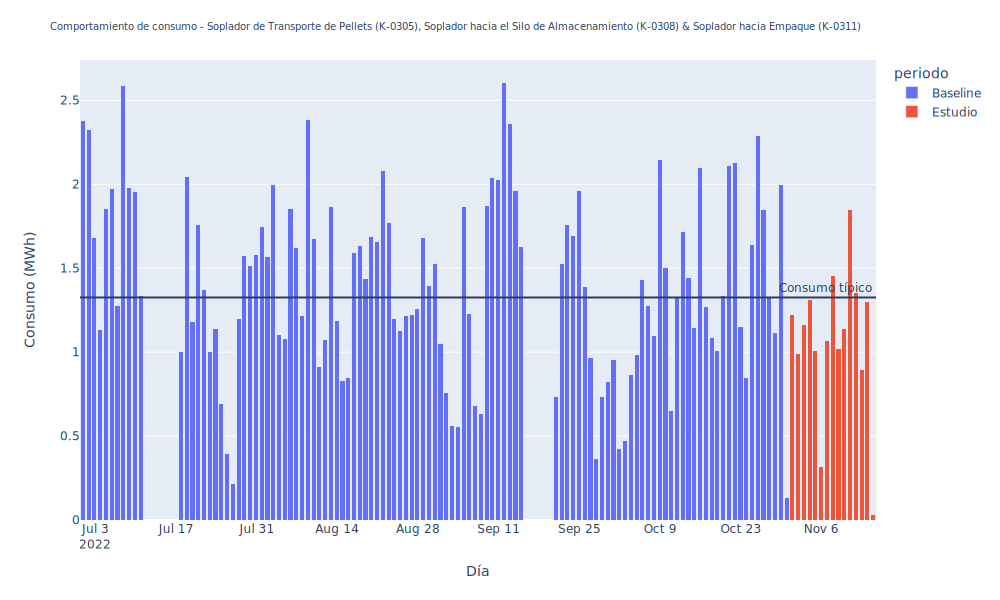

In [466]:
K_0305_diario = K_0305_complete.resample('D').sum().sort_values(by='timestamp', ascending=True).reset_index()
K_0305_diario.replace(0, np.nan, inplace=True)
K_0305_diario['periodo'] = np.where((K_0305_diario['timestamp'] >= datetime.strptime(periodo_historico[0], "%Y-%m-%d")) & (K_0305_diario['timestamp'] <= datetime.strptime(periodo_historico[1], "%Y-%m-%d")), 'Baseline', 'Estudio')



fig = px.bar(K_0305_diario, x="timestamp", y="Consumo (MWh)", color="periodo")
K_0305_diario_LB=K_0305_diario['Consumo (MWh)'].median()
fig.add_hline(y=K_0305_diario_LB, annotation_text=" Consumo típico")


fig.update_layout(barmode='stack', title='Comportamiento de consumo - Soplador de Transporte de Pellets (K-0305), Soplador hacia el Silo de Almacenamiento (K-0308) & Soplador hacia Empaque (K-0311)',width=1000, height=600, colorway=['#fc7703', '#757371'], xaxis_title="Día", yaxis_title="Consumo (MWh)", title_font_size=10)
fig.show()

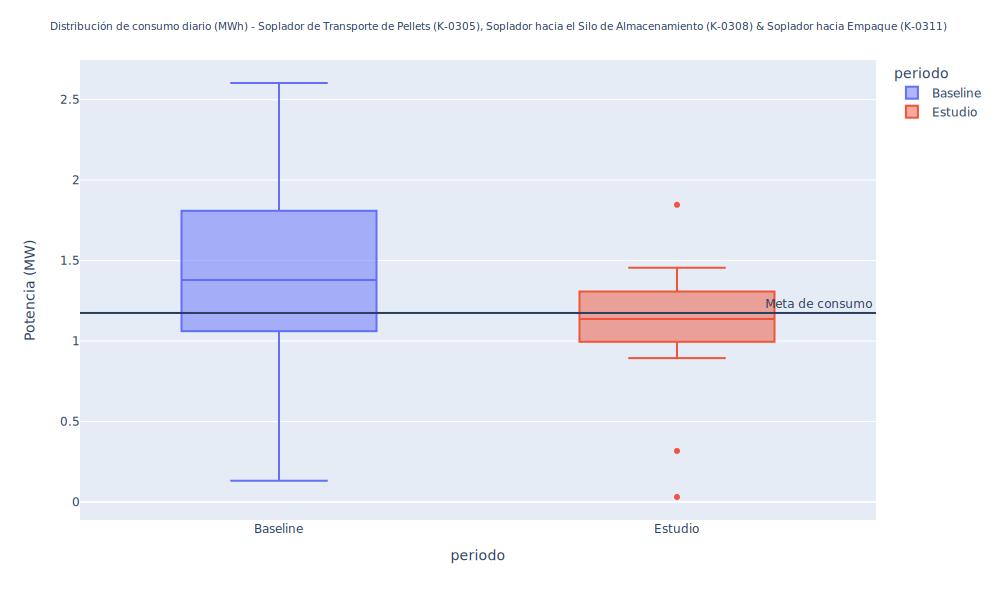

In [467]:
K_0305_LB = K_0305_diario.loc[(K_0305_diario['periodo']=="Baseline") & (K_0305_diario['Consumo (MWh)'].between(K_0305_diario['Consumo (MWh)'].quantile(.25),K_0305_diario['Consumo (MWh)'].quantile(.5)))]['Consumo (MWh)'].mean()

fig = px.box(K_0305_diario, x="periodo", y="Consumo (MWh)", color="periodo")
fig.add_hline(y=K_0305_LB, annotation_text=" Meta de consumo")
fig.update_layout(title_font=dict(size=12.5))
fig.update_layout( title='Distribución de consumo diario (MWh) - Soplador de Transporte de Pellets (K-0305), Soplador hacia el Silo de Almacenamiento (K-0308) & Soplador hacia Empaque (K-0311)', width=1000, height=600, colorway=['#fc7703', '#757371'], yaxis_title="Potencia (MW)", title_font_size=10.5)
fig.show()

### Soplador de Aire para Silos Unipol I (K-0304)

In [468]:
K_0304 = Esenttia[Esenttia['Máquina'] == 'Soplador de Aire para Silos Unipol I (K-0304)']
K_0304_historico = Esenttia_historico[Esenttia_historico['Máquina'] == 'Soplador de Aire para Silos Unipol I (K-0304)']


mask_bl = (K_0304_historico['timestamp'] > periodo_historico[0]) & (K_0304_historico['timestamp'] <= periodo_historico[1])
K_0304_bl = K_0304_historico.loc[mask_bl]

mask_sp = (K_0304['timestamp'] >= periodo_de_estudio[0]) & (K_0304['timestamp'] <= periodo_de_estudio[1])
K_0304_sp = K_0304.loc[mask_sp]

K_0304_sp.replace(0, np.nan, inplace=True)
K_0304_bl.replace(0, np.nan, inplace=True)


K_0304_complete = pd.concat([K_0304_sp,K_0304_bl], axis=0)


K_0304_complete['periodo'] = np.where((K_0304_complete['timestamp'] >= datetime.strptime(periodo_historico[0], "%Y-%m-%d")) & (K_0304_complete['timestamp'] <= datetime.strptime(periodo_historico[1], "%Y-%m-%d")), 'Baseline', 'Estudio')


md(f"Durante el periodo de estudio, el consumo total fue de {K_0304_sp['Consumo (MWh)'].sum().round(2)} MWh")

Durante el periodo de estudio, el consumo total fue de 0.0 MWh

In [469]:
md(f"El consumo por día para el Soplador de Aire para Silos Unipol I (K-0304) puede ser observado en la siguiente gráfica:")

El consumo por día para el Soplador de Aire para Silos Unipol I (K-0304) puede ser observado en la siguiente gráfica:

In [470]:
# K_0304_diario = K_0304_complete.resample('D').sum().sort_values(by='timestamp', ascending=True).reset_index()
# K_0304_diario.replace(0, np.nan, inplace=True)
# K_0304_diario['periodo'] = np.where((K_0304_diario['timestamp'] >= datetime.strptime(periodo_historico[0], "%Y-%m-%d")) & (K_0304_diario['timestamp'] <= datetime.strptime(periodo_historico[1], "%Y-%m-%d")), 'Baseline', 'Estudio')


# fig = px.bar(K_0304_diario, x="timestamp", y="Consumo (MWh)", color="periodo")



# fig.update_layout(barmode='stack', title='Comportamiento de consumo Q1 vs Q2 - Soplador de Transporte de Pellets (K-0305), Soplador hacia el Silo de Almacenamiento (K-0308) & Soplador hacia Empaque (K-0311)',width=1000, height=600, colorway=['#fc7703', '#757371'], xaxis_title="Día", yaxis_title="Consumo (MWh)", title_font_size=10)
# fig.show()

In [471]:
# K_0304_LB = K_0304_diario.loc[(K_0304_diario['periodo']=="Baseline") & (K_0304_diario['Consumo (MWh)'].between(K_0304_diario['Consumo (MWh)'].quantile(.3),K_0304_diario['Consumo (MWh)'].quantile(.6)))]['Consumo (MWh)'].mean()

# fig = px.box(K_0304_diario, x="periodo", y="Consumo (MWh)", color="periodo")
# fig.add_hline(y=K_0304_LB, annotation_text=" Meta de consumo")
# fig.update_layout(title_font=dict(size=12.5))
# fig.update_layout( title='Distribución de potencia (KW) - Soplador de Transporte de Pellets (K-0305), Soplador hacia el Silo de Almacenamiento (K-0308) & Soplador hacia Empaque (K-0311)', width=1000, height=600, colorway=['#fc7703', '#757371'], yaxis_title="Potencia (MW)", title_font_size=11)
# fig.show()

### Soplador hacia el Silo de Almacenamiento (K-0309)

In [472]:
K_0309 = Esenttia[Esenttia['Máquina'] == 'Soplador hacia el Silo de Almacenamiento (K-0309)']
K_0309_historico = Esenttia_historico[Esenttia_historico['Máquina'] == 'Soplador hacia el Silo de Almacenamiento (K-0309)']


mask_bl = (K_0309_historico['timestamp'] > periodo_historico[0]) & (K_0309_historico['timestamp'] <= periodo_historico[1])
K_0309_bl = K_0309_historico.loc[mask_bl]

mask_sp = (K_0309['timestamp'] >= periodo_de_estudio[0]) & (K_0309['timestamp'] <= periodo_de_estudio[1])
K_0309_sp = K_0309.loc[mask_sp]

K_0309_sp.replace(0, np.nan, inplace=True)
K_0309_bl.replace(0, np.nan, inplace=True)


K_0309_complete = pd.concat([K_0309_sp,K_0309_bl], axis=0)


K_0309_complete['periodo'] = np.where((K_0309_complete['timestamp'] >= datetime.strptime(periodo_historico[0], "%Y-%m-%d")) & (K_0309_complete['timestamp'] <= datetime.strptime(periodo_historico[1], "%Y-%m-%d")), 'Baseline', 'Estudio')


md(f"Durante el periodo de estudio, el consumo total fue de {K_0309_sp['Consumo (MWh)'].sum().round(2)} MWh")

Durante el periodo de estudio, el consumo total fue de 0.0 MWh

In [473]:
md(f"El consumo por día para el Soplador hacia el Silo de Almacenamiento (K-0309) puede ser observado en la siguiente gráfica:")

El consumo por día para el Soplador hacia el Silo de Almacenamiento (K-0309) puede ser observado en la siguiente gráfica:

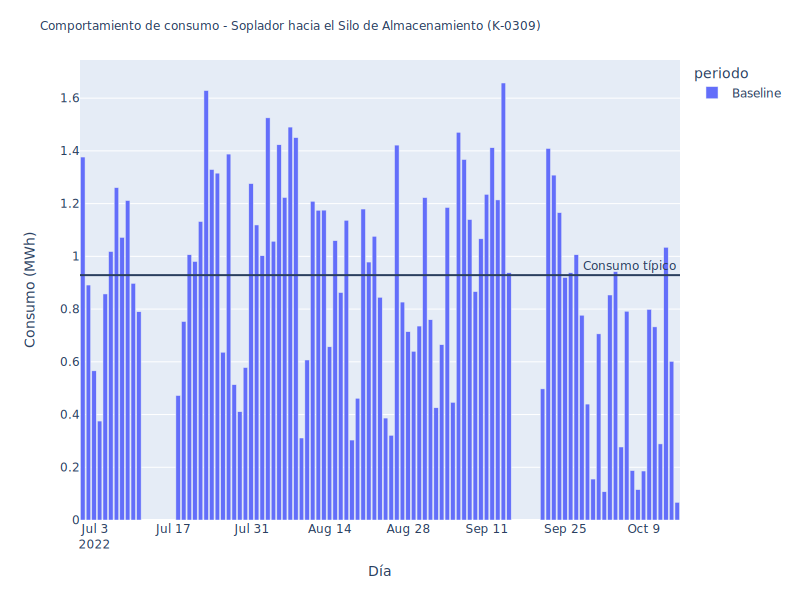

In [474]:
K_0309_diario = K_0309_complete.resample('D').sum().sort_values(by='timestamp', ascending=True).reset_index()
K_0309_diario.replace(0, np.nan, inplace=True)
K_0309_diario['periodo'] = np.where((K_0309_diario['timestamp'] >= datetime.strptime(periodo_historico[0], "%Y-%m-%d")) & (K_0309_diario['timestamp'] <= datetime.strptime(periodo_historico[1], "%Y-%m-%d")), 'Baseline', 'Estudio')


fig = px.bar(K_0309_diario, x="timestamp", y="Consumo (MWh)", color="periodo")

K_0309_diario_LB=K_0309_diario['Consumo (MWh)'].median()
fig.add_hline(y=K_0309_diario_LB, annotation_text=" Consumo típico")


fig.update_layout(barmode='stack', title='Comportamiento de consumo - Soplador hacia el Silo de Almacenamiento (K-0309)',width=800, height=600, colorway=['#fc7703', '#757371'], xaxis_title="Día", yaxis_title="Consumo (MWh)", title_font_size=12)
fig.show()

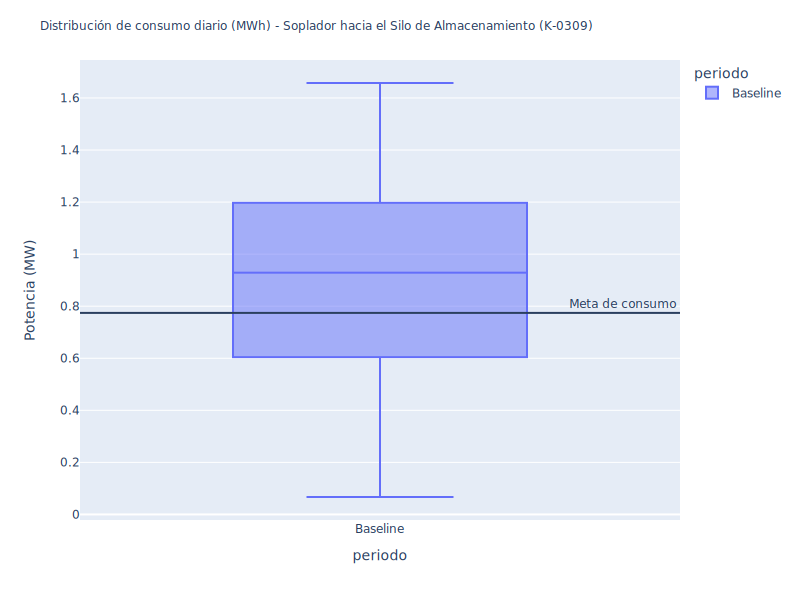

In [475]:
K_0309_LB = K_0309_diario.loc[(K_0309_diario['periodo']=="Baseline") & (K_0309_diario['Consumo (MWh)'].between(K_0309_diario['Consumo (MWh)'].quantile(.25),K_0309_diario['Consumo (MWh)'].quantile(.5)))]['Consumo (MWh)'].mean()

fig = px.box(K_0309_diario, x="periodo", y="Consumo (MWh)", color="periodo")
fig.add_hline(y=K_0309_LB, annotation_text=" Meta de consumo")
fig.update_layout(title_font=dict(size=12.5))
fig.update_layout( title='Distribución de consumo diario (MWh) - Soplador hacia el Silo de Almacenamiento (K-0309)', width=800, height=600, colorway=['#fc7703', '#757371'], yaxis_title="Potencia (MW)", title_font_size=12)
fig.show()

### Extrusora Y-7101

In [476]:
Y_7101 = Esenttia[Esenttia['Máquina'] == 'Extrusora Y-7101']
Y_7101_historico = Esenttia_historico[Esenttia_historico['Máquina'] == 'Extrusora Y-7101']


mask_bl = (Y_7101_historico['timestamp'] > periodo_historico[0]) & (Y_7101_historico['timestamp'] <= periodo_historico[1])
Y_7101_bl = Y_7101_historico.loc[mask_bl]

mask_sp = (Y_7101['timestamp'] >= periodo_de_estudio[0]) & (Y_7101['timestamp'] <= periodo_de_estudio[1])
Y_7101_sp = Y_7101.loc[mask_sp]

Y_7101_sp.replace(0, np.nan, inplace=True)
Y_7101_bl.replace(0, np.nan, inplace=True)


Y_7101_complete = pd.concat([Y_7101_sp,Y_7101_bl], axis=0)


Y_7101_complete['periodo'] = np.where((Y_7101_complete['timestamp'] >= datetime.strptime(periodo_historico[0], "%Y-%m-%d")) & (Y_7101_complete['timestamp'] <= datetime.strptime(periodo_historico[1], "%Y-%m-%d")), 'Baseline', 'Estudio')


md(f"Durante el periodo de estudio, el consumo total fue de {Y_7101_sp['Consumo (MWh)'].sum().round(2)} MWh")

Durante el periodo de estudio, el consumo total fue de 1093.03 MWh

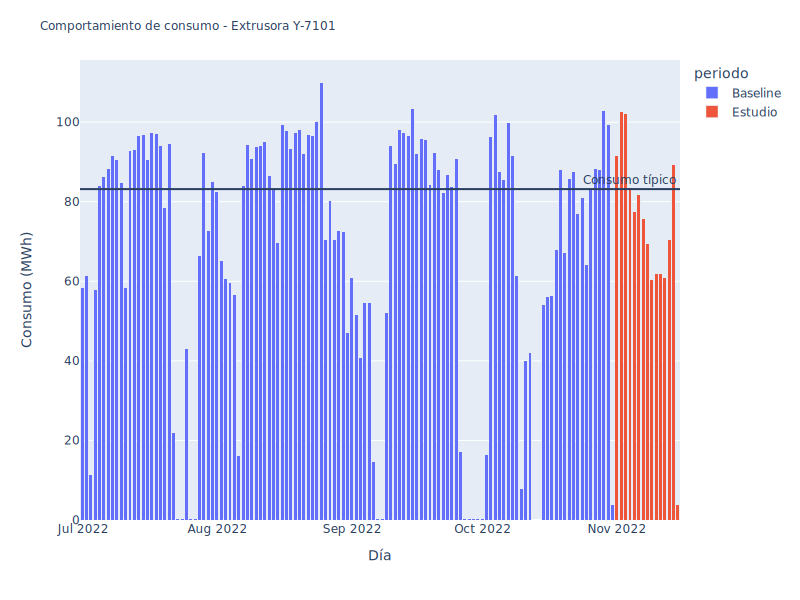

In [477]:
Y_7101_diario = Y_7101_complete.resample('D').sum().sort_values(by='timestamp', ascending=True).reset_index()
Y_7101_diario.replace(0, np.nan, inplace=True)
Y_7101_diario['periodo'] = np.where((Y_7101_diario['timestamp'] >= datetime.strptime(periodo_historico[0], "%Y-%m-%d")) & (Y_7101_diario['timestamp'] <= datetime.strptime(periodo_historico[1], "%Y-%m-%d")), 'Baseline', 'Estudio')


fig = px.bar(Y_7101_diario, x="timestamp", y="Consumo (MWh)", color="periodo")

Y_7101_diario_LB=Y_7101_diario['Consumo (MWh)'].median()
fig.add_hline(y=Y_7101_diario_LB, annotation_text=" Consumo típico")


fig.update_layout(barmode='stack', title='Comportamiento de consumo - Extrusora Y-7101',width=800, height=600, colorway=['#fc7703', '#757371'], xaxis_title="Día", yaxis_title="Consumo (MWh)", title_font_size=12)
fig.show()

In [478]:
Y_7101_complete = pd.DataFrame()
Y_7101_historico_complete = pd.DataFrame()

Tags_Y_7101  = ['FIX.CWP-FEED-RATE.F_CV','FIX.P1-FF-7180-2.F_CV','FIX.PRODUCT-EXT-P1.A_CV','FIX.TI7101-168.F_CV','FIX.TI7101-169.F_CV','FIX.TI7101-170.F_CV','FIX.TI7101-171.F_CV','FIX.TI7101-172.F_CV','FIX.TI7101-173.F_CV','FIX.TI7101-174.F_CV','FIX.TI7101-175.F_CV','FIX.TI7101-176.F_CV','FIX.TI7104-191.F_CV','FIX.XI7101-02.F_CV','FIX.XI7101-211.F_CV','FIX.XI7101-212.F_CV','FIX.XI7101-213.F_CV']
Y_7101_complete = data[Tags_Y_7101].astype(float)
Y_7101_historico_complete = historic_data.loc[historic_data['NAME'].isin(Tags_Y_7101)].drop('datetime', axis=1)

Y_7101_historico_complete = Y_7101_historico_complete.pivot_table(index='datetime', columns='NAME', values='Active power', aggfunc='mean')


Y_7101_complete['KPI (MW KWh/kg)'] = Y_7101_complete['FIX.XI7101-213.F_CV'] / Y_7101_complete['FIX.CWP-FEED-RATE.F_CV']

Y_7101_historico_complete[Y_7101_historico_complete['FIX.CWP-FEED-RATE.F_CV'].gt(1)]
Y_7101_historico_complete[Y_7101_historico_complete['FIX.XI7101-213.F_CV'].gt(1)]

Y_7101_complete[Y_7101_complete['FIX.CWP-FEED-RATE.F_CV'].gt(1)]
Y_7101_complete[Y_7101_complete['FIX.XI7101-213.F_CV'].gt(1)]

Y_7101_historico_complete['KPI (MW KWh/kg)'] = Y_7101_historico_complete['FIX.XI7101-213.F_CV'] / Y_7101_historico_complete['FIX.CWP-FEED-RATE.F_CV']



Y_7101_complete = Y_7101_complete[Y_7101_complete['FIX.XI7101-213.F_CV'].between(Y_7101_complete['FIX.XI7101-213.F_CV'].quantile(.1),Y_7101_complete['FIX.XI7101-213.F_CV'].quantile(.90) ) ]
Y_7101_complete = Y_7101_complete[Y_7101_complete['KPI (MW KWh/kg)'].between(Y_7101_complete['KPI (MW KWh/kg)'].quantile(.1),Y_7101_complete['KPI (MW KWh/kg)'].quantile(.90) ) ]


Y_7101_complete['timestamp'] = pd.to_datetime(Y_7101_complete.index)
Y_7101_historico_complete['timestamp'] = pd.to_datetime(Y_7101_historico_complete.index)


Y_7101_complete.dropna(inplace=True)
Y_7101_complete['timestamp'] = pd.to_datetime(Y_7101_complete.index)

Y_7101_complete['periodo'] = np.where((Y_7101_complete['timestamp'] > datetime.strptime(periodo_historico[0], "%Y-%m-%d")) & (Y_7101_complete['timestamp'] <= datetime.strptime(periodo_historico[1], "%Y-%m-%d")), 'Baseline', 'Estudio')
Y_7101_historico_complete['periodo'] = np.where((Y_7101_historico_complete['timestamp'] > datetime.strptime(periodo_historico[0], "%Y-%m-%d")) & (Y_7101_historico_complete['timestamp'] <= datetime.strptime(periodo_historico[1], "%Y-%m-%d")), 'Baseline', 'Estudio')

Y_7101_complete_sp = Y_7101_complete[Y_7101_complete['periodo']=='Estudio']

Y_7101_complete_bl = Y_7101_complete[Y_7101_complete['periodo']=='Baseline']

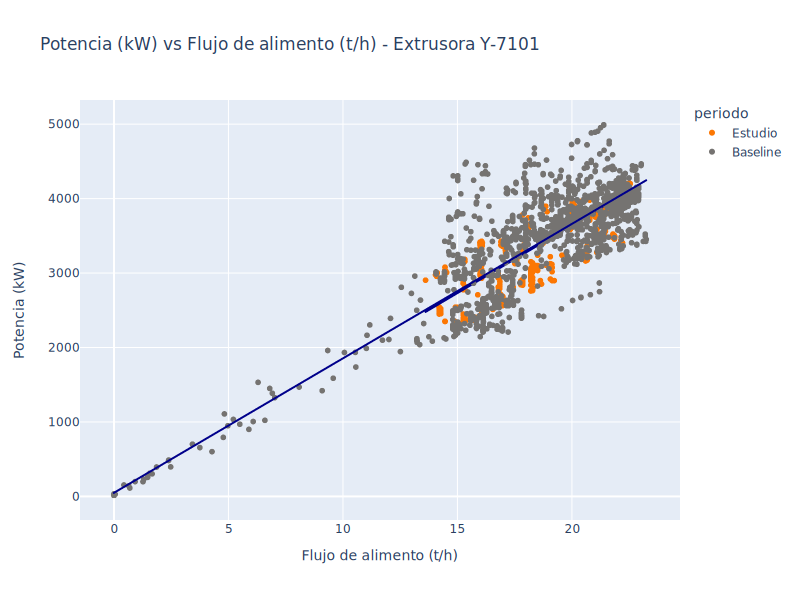

AIC Periodo de estudio 36508.48169798488
AIC Periodo Anterior 14895.244408796369
R^2 Periodo de estudio 0.9354365437909925
R^2 Periodo Anterior 0.7046074629436192
MSE Periodo de estudio 2214020.5417243843
MSE Periodo Anterior 274925.6035332285


In [479]:
Y_7101_complete_scatter = pd.concat([Y_7101_complete_sp,Y_7101_historico_complete], axis = 0)


fig = px.scatter(Y_7101_complete_scatter, y=Y_7101_complete_scatter['FIX.XI7101-213.F_CV'], x=Y_7101_complete_scatter['FIX.CWP-FEED-RATE.F_CV'], color='periodo', trendline="ols", trendline_color_override="darkblue", title='Potencia (kW) vs Flujo de alimento (t/h) - Extrusora Y-7101', width=800, height=600, color_discrete_map={'Baseline': '#757371', 'Estudio': '#fc7703'}, labels={'FIX.XI7101-213.F_CV':'Potencia (kW)', 'FIX.CWP-FEED-RATE.F_CV':'Flujo de alimento (t/h)'})
fig.show()

print('AIC Periodo de estudio',px.get_trendline_results(fig)['px_fit_results'][1].aic)
print('AIC Periodo Anterior',px.get_trendline_results(fig)['px_fit_results'][0].aic)


print('R^2 Periodo de estudio',px.get_trendline_results(fig)['px_fit_results'][1].rsquared)
print('R^2 Periodo Anterior',px.get_trendline_results(fig)['px_fit_results'][0].rsquared)

print('MSE Periodo de estudio',px.get_trendline_results(fig)['px_fit_results'][1].mse_total)
print('MSE Periodo Anterior',px.get_trendline_results(fig)['px_fit_results'][0].mse_total)

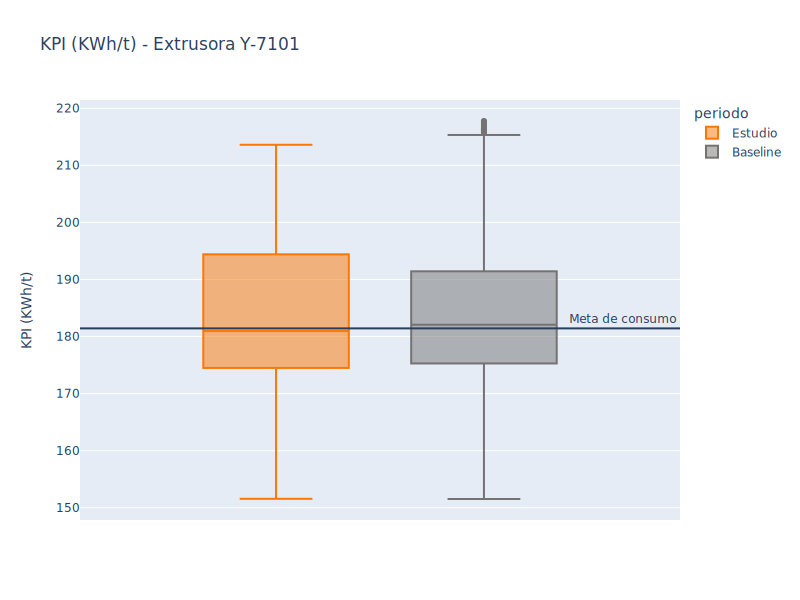

In [480]:
Y_7101_complete_scatter = Y_7101_complete_scatter[(Y_7101_complete_scatter['KPI (MW KWh/kg)'].lt(1000)) & (Y_7101_complete_scatter['KPI (MW KWh/kg)'].gt(0))]

Y_7101_complete_scatter = Y_7101_complete_scatter[(Y_7101_complete_scatter['KPI (MW KWh/kg)'].between(Y_7101_complete_scatter['KPI (MW KWh/kg)'].quantile(.05),Y_7101_complete_scatter['KPI (MW KWh/kg)'].quantile(.95)))]

Y_7101_LB = Y_7101_complete_scatter.loc[(Y_7101_complete_scatter['periodo']=="Baseline") & (Y_7101_complete_scatter['KPI (MW KWh/kg)'].between(Y_7101_complete_scatter['KPI (MW KWh/kg)'].quantile(.3),Y_7101_complete_scatter['KPI (MW KWh/kg)'].quantile(.6)))]['KPI (MW KWh/kg)'].mean()


fig = px.box(Y_7101_complete_scatter, y=Y_7101_complete_scatter['KPI (MW KWh/kg)'], color='periodo',  title='KPI (KWh/t) - Extrusora Y-7101', width=800,
 height=600, color_discrete_map={'Baseline': '#757371', 'Estudio': '#fc7703'}, labels={'KPI (MW KWh/kg)':'KPI (KWh/t)'})
fig.add_hline(y=Y_7101_LB, annotation_text=" Meta de consumo")
fig.show()

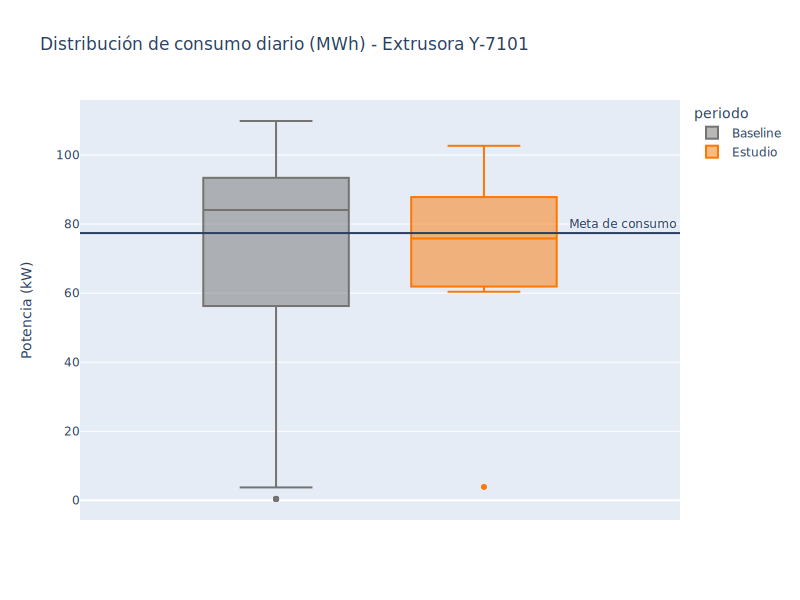

In [481]:


Y_7101_LB = Y_7101_diario.loc[(Y_7101_diario['periodo']=="Baseline") & (Y_7101_diario['Consumo (MWh)'].between(Y_7101_diario['Consumo (MWh)'].quantile(.3),Y_7101_diario['Consumo (MWh)'].quantile(.6)))]['Consumo (MWh)'].mean()


fig = px.box(Y_7101_diario, y=Y_7101_diario['Consumo (MWh)'], color='periodo',  title='Distribución de consumo diario (MWh) - Extrusora Y-7101', width=800,
 height=600, color_discrete_map={'Baseline': '#757371', 'Estudio': '#fc7703'}, labels={'Consumo (MWh)':'Potencia (kW)'})
fig.add_hline(y=Y_7101_LB, annotation_text=" Meta de consumo")
fig.show()

#### Modelación Analítica

R^2 medio 0.8869265771071367
Error cuadratico medio sobre el conjunto de Test: 35458.05 kW


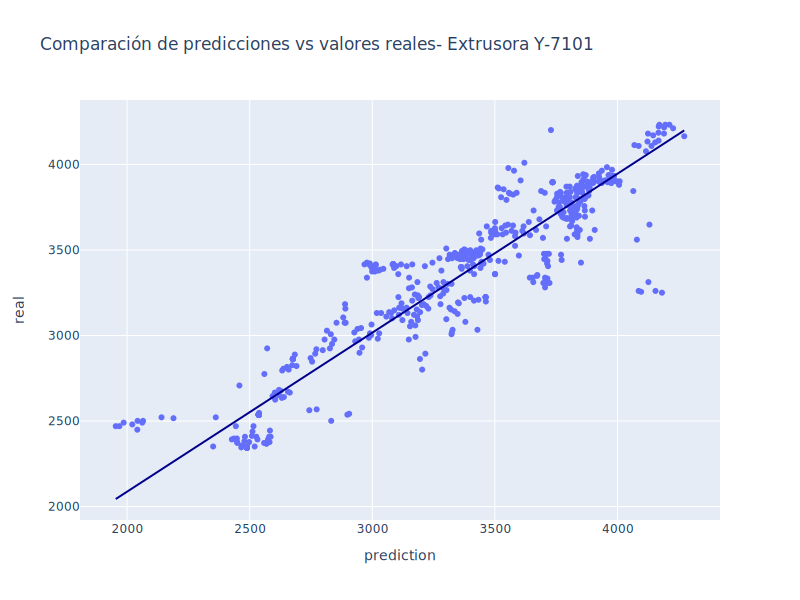

Peso
Alimento de polvo                         1594.79
Temp Barril 6                             1239.17
Temp Barril 5                              231.67
Melt Temp Disch Ext Uno                    139.01
Temp Barril 9                              104.37
Temp Barril 4                               71.33
Rata reproceso Extrusora P1                -23.27
Temp Barril 8                              -41.61
Temp Barril 10                            -103.17
Producto Peletizado - Extruder P1 (A_CV)  -400.75
Temp Barril 2                             -525.50
Temp Barril 7                             -533.85
Temp Barril 3                             -895.35

In [482]:
Feature_Tags_Y_7101  = ['FIX.CWP-FEED-RATE.F_CV','FIX.P1-FF-7180-2.F_CV','FIX.PRODUCT-EXT-P1.A_CV','FIX.TI7101-168.F_CV',
'FIX.TI7101-169.F_CV','FIX.TI7101-170.F_CV','FIX.TI7101-171.F_CV','FIX.TI7101-172.F_CV','FIX.TI7101-173.F_CV',
'FIX.TI7101-174.F_CV','FIX.TI7101-175.F_CV','FIX.TI7101-176.F_CV','FIX.TI7104-191.F_CV']

Feature_Names_Y_7101 = ['Alimento de polvo','Rata reproceso Extrusora P1','Producto Peletizado - Extruder P1 (A_CV)',
'Temp Barril 2','Temp Barril 3','Temp Barril 4','Temp Barril 5','Temp Barril 6',
'Temp Barril 7','Temp Barril 8','Temp Barril 9','Temp Barril 10','Melt Temp Disch Ext Uno']

Output_Tags_Y_7101 = ['FIX.XI7101-213.F_CV']


Y_7101_complete_features = Y_7101_complete[Feature_Tags_Y_7101]
Y_7101_complete_output = Y_7101_complete[Output_Tags_Y_7101]

from sklearn import svm
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split

scaler = MinMaxScaler()

X = scaler.fit_transform(Y_7101_complete_features)
y = Y_7101_complete_output.values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42)



SVR = svm.SVR(kernel='linear', C=1e3, gamma=0.1)
validation = cross_validate(SVR, X_train, y_train, cv=10, scoring='r2', return_estimator=True)
print('R^2 medio',validation['test_score'].mean())




best_estimator = validation['estimator'][np.argmax(validation['test_score'])]


prediction = best_estimator.predict(X_test)

comparison = pd.DataFrame([prediction, y_test.flatten()]).T
comparison.columns = ['prediction', 'real']

MSE = np.mean((prediction - y_test.flatten())**2)
print(f"Error cuadratico medio sobre el conjunto de Test: {MSE.round(2)} kW")

fig = px.scatter(comparison, x=comparison['prediction'], y=comparison['real'], trendline="ols", trendline_color_override="darkblue", title='Comparación de predicciones vs valores reales- Extrusora Y-7101', width=800,
height=600)
fig.show()



coeficientes = pd.DataFrame(best_estimator.coef_.T, index=Feature_Names_Y_7101, columns=['Peso'])
coeficientes.round(2).sort_values(by='Peso', ascending=False)

# print('Los coeficientes del modelo son: ', best_estimator.coef_)
# print('El intercepto del modelo es: ', best_estimator.intercept_)
# print('los nombres de las variables son: ', Feature_Names_Y_7101)

### Mixer Y-7001

In [483]:
Y_7001 = Esenttia[Esenttia['Máquina'] == 'Mixer Y-7001']
Y_7001_historico = Esenttia_historico[Esenttia_historico['Máquina'] == 'Mixer Y-7001']


mask_bl = (Y_7001_historico['timestamp'] > periodo_historico[0]) & (Y_7001_historico['timestamp'] <= periodo_historico[1])
Y_7001_bl = Y_7001_historico.loc[mask_bl]

mask_sp = (Y_7001['timestamp'] >= periodo_de_estudio[0]) & (Y_7001['timestamp'] <= periodo_de_estudio[1])
Y_7001_sp = Y_7001.loc[mask_sp]

Y_7001_sp.replace(0, np.nan, inplace=True)
Y_7001_bl.replace(0, np.nan, inplace=True)


Y_7001_complete = pd.concat([Y_7001_sp,Y_7001_bl], axis=0)

Y_7001_complete = Y_7001_complete[Y_7001_complete['Consumo (MWh)'].gt(0)]

Y_7001_complete['periodo'] = np.where((Y_7001_complete['timestamp'] >= datetime.strptime(periodo_historico[0], "%Y-%m-%d")) & (Y_7001_complete['timestamp'] <= datetime.strptime(periodo_historico[1], "%Y-%m-%d")), 'Baseline', 'Estudio')


md(f"Durante el periodo de estudio, el consumo total fue de {Y_7001_sp['Consumo (MWh)'].sum().round(2)} MWh")

Durante el periodo de estudio, el consumo total fue de 821.11 MWh

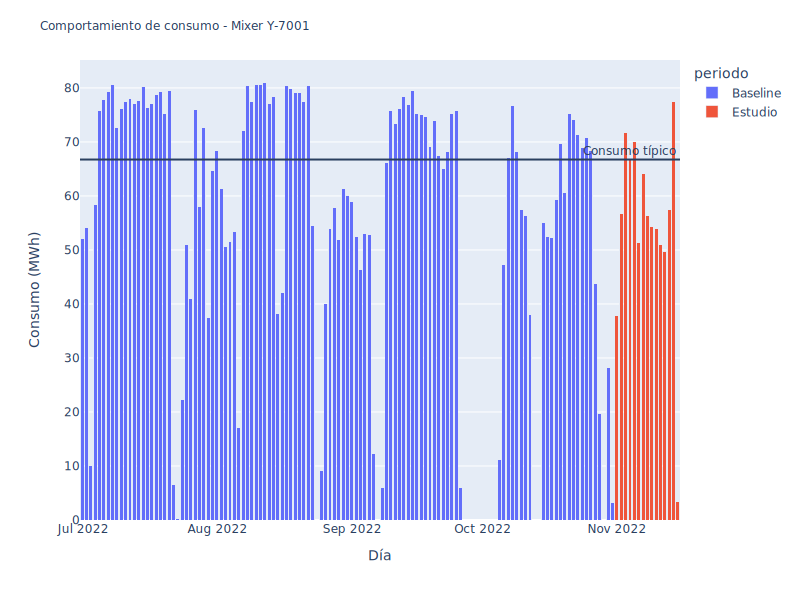

In [484]:
Y_7001_diario = Y_7001_complete.resample('D').sum().sort_values(by='timestamp', ascending=True).reset_index()
Y_7001_diario.replace(0, np.nan, inplace=True)
Y_7001_diario['periodo'] = np.where((Y_7001_diario['timestamp'] >= datetime.strptime(periodo_historico[0], "%Y-%m-%d")) & (Y_7001_diario['timestamp'] <= datetime.strptime(periodo_historico[1], "%Y-%m-%d")), 'Baseline', 'Estudio')


fig = px.bar(Y_7001_diario, x="timestamp", y="Consumo (MWh)", color="periodo")

Y_7001_diario_LB=Y_7001_diario['Consumo (MWh)'].median()
fig.add_hline(y=Y_7001_diario_LB, annotation_text=" Consumo típico")

fig.update_layout(barmode='stack', title='Comportamiento de consumo - Mixer Y-7001',width=800, height=600, colorway=['#fc7703', '#757371'], xaxis_title="Día", yaxis_title="Consumo (MWh)", title_font_size=12)
fig.show()

In [485]:
Y_7001_complete = pd.DataFrame()
Y_7001_historico_complete = pd.DataFrame()

Tags_Y_7001  = ['FIX.FF-7056-2.F_CV','FIX.MES-P1-Y-7001-RATA.F_CV',
'FIX.MIXER-FEED-RATE.F_CV','FIX.MIX-I-7001-5.F_CV','FIX.MIX-II-7001A-2.F_CV',
'FIX.MIX-II-7004-15.F_CV','FIX.MIX-JI-7001-02.F_CV','FIX.MIX-JI-7004-15.F_CV',
'FIX.MIX-PI-7004-11.F_CV','FIX.MIX-PRODUCT-MIXER-P1.A_CV','FIX.MIX-TI-7001-02A.F_CV',
'FIX.MIX-TI-7001-02B.F_CV','FIX.MIX-TI-7001-02C.F_CV','FIX.MIX-TI-7001-02D.F_CV','FIX.MIX-TI-7001-10A.F_CV',
'FIX.MIX-TI-7001-10B.F_CV','FIX.MIX-TI-7001-10C.F_CV','FIX.MIX-TI-7001-10D.F_CV','FIX.MIX-TI-7004-05.F_CV']
    
    
Y_7001_complete = data[Tags_Y_7001].astype(float)
Y_7001_historico_complete = historic_data.loc[historic_data['NAME'].isin(Tags_Y_7001)].drop('datetime', axis=1)

Y_7001_historico_complete = Y_7001_historico_complete.pivot_table(index='datetime', columns='NAME', values='Active power', aggfunc='mean')

Y_7001_complete = Y_7001_complete[Y_7001_complete['FIX.MIXER-FEED-RATE.F_CV'] != 0] 
Y_7001_historico_complete = Y_7001_historico_complete[Y_7001_historico_complete['FIX.MIXER-FEED-RATE.F_CV'] != 0] 

Y_7001_complete['KPI (MW KWh/kg)'] = (Y_7001_complete['FIX.MIX-JI-7001-02.F_CV']+ Y_7001_complete['FIX.MIX-JI-7004-15.F_CV']) / Y_7001_complete['FIX.MIXER-FEED-RATE.F_CV']
Y_7001_historico_complete['KPI (MW KWh/kg)'] = (Y_7001_historico_complete['FIX.MIX-JI-7001-02.F_CV']+ Y_7001_historico_complete['FIX.MIX-JI-7004-15.F_CV']) / Y_7001_historico_complete['FIX.MIXER-FEED-RATE.F_CV']

Y_7001_complete = Y_7001_complete[Y_7001_complete['KPI (MW KWh/kg)'].between(Y_7001_complete['KPI (MW KWh/kg)'].quantile(.05),Y_7001_complete['KPI (MW KWh/kg)'].quantile(.95) ) ].dropna()

Y_7001_complete['timestamp'] = pd.to_datetime(Y_7001_complete.index)
Y_7001_historico_complete['timestamp'] = pd.to_datetime(Y_7001_historico_complete.index)



Y_7001_complete['periodo'] = np.where((Y_7001_complete['timestamp'] > datetime.strptime(periodo_historico[0], "%Y-%m-%d")) & (Y_7001_complete['timestamp'] <= datetime.strptime(periodo_historico[1], "%Y-%m-%d")), 'Baseline', 'Estudio')
Y_7001_historico_complete['periodo'] = np.where((Y_7001_historico_complete['timestamp'] > datetime.strptime(periodo_historico[0], "%Y-%m-%d")) & (Y_7001_historico_complete['timestamp'] <= datetime.strptime(periodo_historico[1], "%Y-%m-%d")), 'Baseline', 'Estudio')



Y_7001_complete_sp = Y_7001_complete[Y_7001_complete['periodo']=='Estudio']

Y_7001_complete_bl = Y_7001_complete[Y_7001_complete['periodo']=='Baseline']

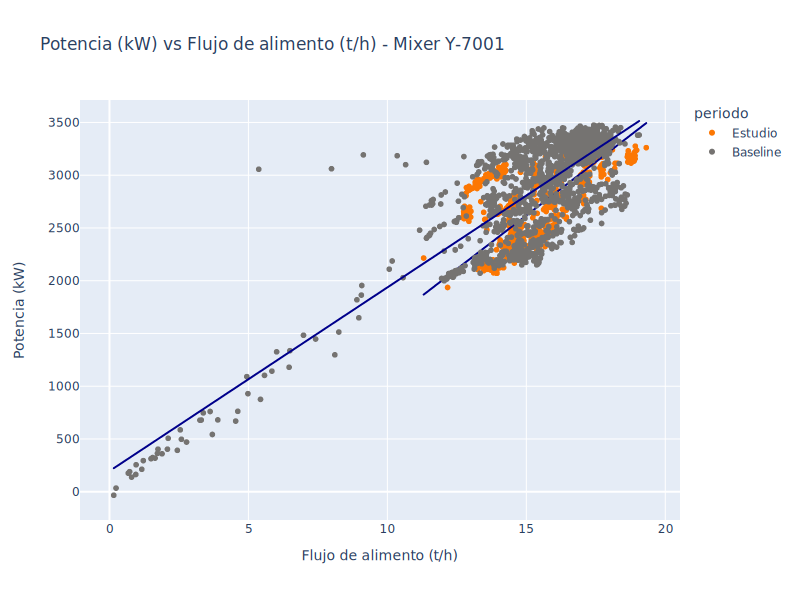

AIC Periodo de estudio 28130.910634330747
AIC Periodo Anterior 16992.2559671529
R^2 Periodo de estudio 0.6546020343571601
R^2 Periodo Anterior 0.5064070261166933
MSE Periodo de estudio 269226.49446334306
MSE Periodo Anterior 175120.71970095576


In [486]:
Y_7001_complete_scatter = pd.concat([Y_7001_complete_sp,Y_7001_historico_complete], axis = 0)

fig = px.scatter(Y_7001_complete_scatter, y=Y_7001_complete_scatter['FIX.MIX-JI-7001-02.F_CV'], x=Y_7001_complete_scatter['FIX.MIXER-FEED-RATE.F_CV'], color='periodo', trendline="ols", trendline_color_override="darkblue", title='Potencia (kW) vs Flujo de alimento (t/h) - Mixer Y-7001', width=800, height=600, color_discrete_map={'Baseline': '#757371', 'Estudio': '#fc7703'}, labels={'FIX.MIX-JI-7001-02.F_CV': 'Potencia (kW)', 'FIX.MIXER-FEED-RATE.F_CV': 'Flujo de alimento (t/h)'})
fig.show()

print('AIC Periodo de estudio',px.get_trendline_results(fig)['px_fit_results'][1].aic)
print('AIC Periodo Anterior',px.get_trendline_results(fig)['px_fit_results'][0].aic)


print('R^2 Periodo de estudio',px.get_trendline_results(fig)['px_fit_results'][1].rsquared)
print('R^2 Periodo Anterior',px.get_trendline_results(fig)['px_fit_results'][0].rsquared)

print('MSE Periodo de estudio',px.get_trendline_results(fig)['px_fit_results'][1].mse_total)
print('MSE Periodo Anterior',px.get_trendline_results(fig)['px_fit_results'][0].mse_total)

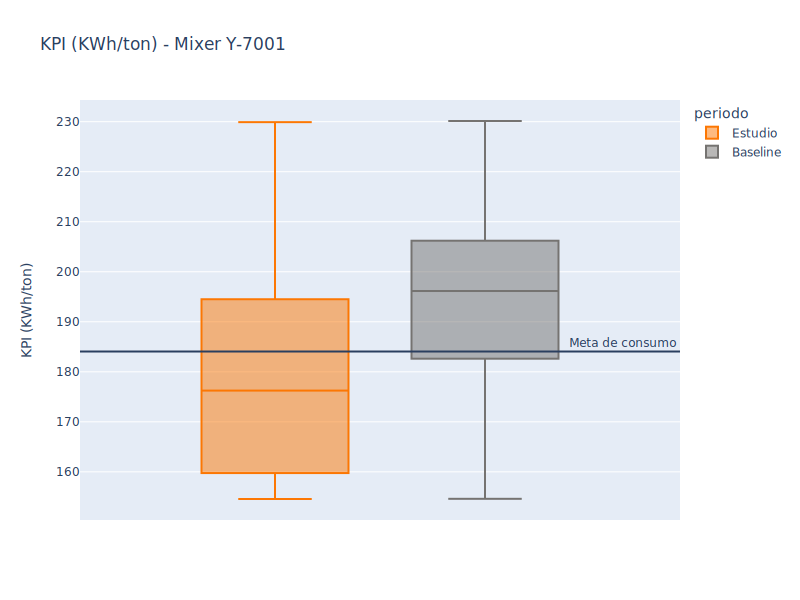

In [487]:
Y_7001_LB = Y_7001_complete_scatter.loc[(Y_7001_complete_scatter['periodo']=="Baseline") & (Y_7001_complete_scatter['KPI (MW KWh/kg)'].between(Y_7001_complete_scatter['KPI (MW KWh/kg)'].quantile(.25),Y_7001_complete_scatter['KPI (MW KWh/kg)'].quantile(.5)))]['KPI (MW KWh/kg)'].mean()

Y_7001_complete_scatter = Y_7001_complete_scatter[Y_7001_complete_scatter['KPI (MW KWh/kg)'].between(Y_7001_complete_scatter['KPI (MW KWh/kg)'].quantile(.05),Y_7001_complete_scatter['KPI (MW KWh/kg)'].quantile(.95))]

fig = px.box(Y_7001_complete_scatter, y=Y_7001_complete_scatter['KPI (MW KWh/kg)'], color='periodo',  title='KPI (KWh/ton) - Mixer Y-7001', width=800,
 height=600, color_discrete_map={'Baseline': '#757371', 'Estudio': '#fc7703'},labels={'KPI (MW KWh/kg)': 'KPI (KWh/ton)'})
fig.add_hline(y=Y_7001_LB, annotation_text=" Meta de consumo")
fig.show()

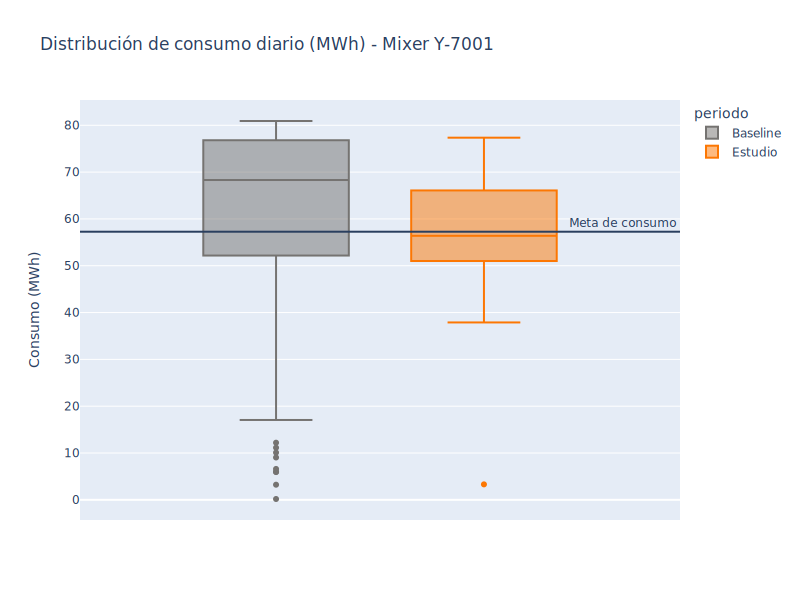

In [488]:


Y_7001_LB = Y_7001_diario.loc[(Y_7001_diario['periodo']=="Baseline") & (Y_7001_diario['Consumo (MWh)'].between(Y_7001_diario['Consumo (MWh)'].quantile(.25),Y_7001_diario['Consumo (MWh)'].quantile(.5)))]['Consumo (MWh)'].mean()

fig = px.box(Y_7001_diario, y=Y_7001_diario['Consumo (MWh)'], color='periodo',  title='Distribución de consumo diario (MWh) - Mixer Y-7001', width=800,
 height=600, color_discrete_map={'Baseline': '#757371', 'Estudio': '#fc7703'}, labels={'y': 'Potencia (kW)'})
fig.add_hline(y=Y_7001_LB, annotation_text=" Meta de consumo")
fig.show()

#### Modelación Analítica

R^2 medio 0.813658544397264
Error cuadratico medio sobre el conjunto de Test: 24175.67 kW


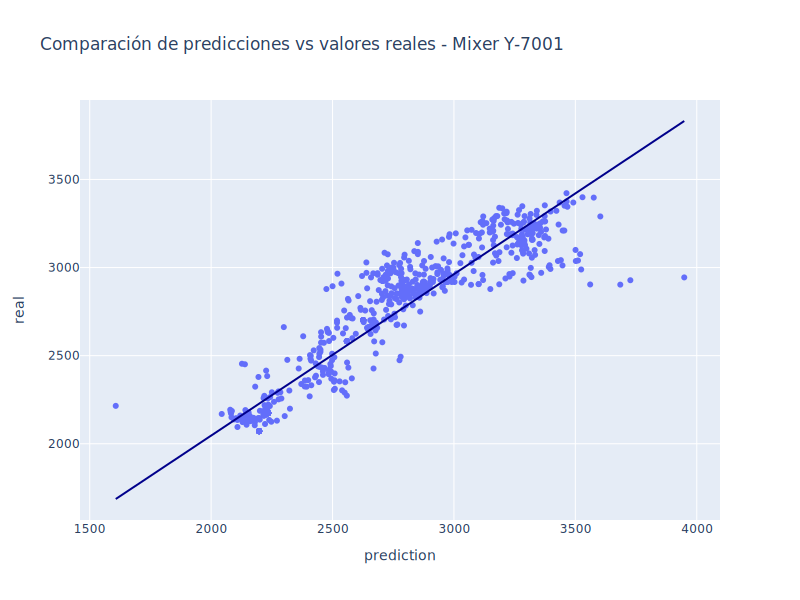

Peso
Temp Barril T 7001 2C                  1213.80
Temp Barril T 7001 2A                   921.46
Melt Temp Y-7004                        903.23
Rata Y-7001 (F_CV)                      764.76
Rate Mixer                              764.76
Disch Pres Y-7004                       607.63
Temp Barril T 7001 10A                  319.74
Rata Reproceso Mixer                    179.51
Temp Barril T 7001 10D                   44.84
Temp Barril T 7001 10B                   32.83
Aux Motor Load (F_CV)                     0.00
Temp Barril T 7001 2B                  -176.92
Producto Peletizado - Mixer P1 (A_CV)  -274.34
Temp Barril T 7001 2D                  -479.33
Temp Barril T 7001 10C                 -594.77

In [489]:
Feature_Tags_Y_7001  = ['FIX.FF-7056-2.F_CV','FIX.MES-P1-Y-7001-RATA.F_CV',
'FIX.MIXER-FEED-RATE.F_CV','FIX.MIX-II-7001A-2.F_CV',
'FIX.MIX-PI-7004-11.F_CV','FIX.MIX-PRODUCT-MIXER-P1.A_CV','FIX.MIX-TI-7001-02A.F_CV',
'FIX.MIX-TI-7001-02B.F_CV','FIX.MIX-TI-7001-02C.F_CV','FIX.MIX-TI-7001-02D.F_CV','FIX.MIX-TI-7001-10A.F_CV',
'FIX.MIX-TI-7001-10B.F_CV','FIX.MIX-TI-7001-10C.F_CV','FIX.MIX-TI-7001-10D.F_CV','FIX.MIX-TI-7004-05.F_CV']


Feature_Names_Y_7001 = [
    'Rata Reproceso Mixer ','Rata Y-7001 (F_CV)',
    'Rate Mixer','Aux Motor Load (F_CV)','Disch Pres Y-7004',
    'Producto Peletizado - Mixer P1 (A_CV)','Temp Barril T 7001 2A','Temp Barril T 7001 2B',
    'Temp Barril T 7001 2C','Temp Barril T 7001 2D','Temp Barril T 7001 10A','Temp Barril T 7001 10B',
    'Temp Barril T 7001 10C','Temp Barril T 7001 10D','Melt Temp Y-7004']

Output_Tags_Y_7001 = ['FIX.MIX-JI-7001-02.F_CV']


Y_7001_complete_features = Y_7001_complete[Feature_Tags_Y_7001]
Y_7001_complete_output = Y_7001_complete[Output_Tags_Y_7001]

from sklearn import svm
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split

scaler = MinMaxScaler()

X = scaler.fit_transform(Y_7001_complete_features)
y = Y_7001_complete_output.values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42)



SVR = svm.SVR(kernel='linear', C=1e3, gamma=0.1)
validation = cross_validate(SVR, X_train, y_train, cv=10, scoring='r2', return_estimator=True)
print('R^2 medio',validation['test_score'].mean())




best_estimator = validation['estimator'][np.argmax(validation['test_score'])]


prediction = best_estimator.predict(X_test)

comparison = pd.DataFrame([prediction, y_test.flatten()]).T
comparison.columns = ['prediction', 'real']

MSE = np.mean((prediction - y_test.flatten())**2)
print(f"Error cuadratico medio sobre el conjunto de Test: {MSE.round(2)} kW")

fig = px.scatter(comparison, x=comparison['prediction'], y=comparison['real'], trendline="ols", trendline_color_override="darkblue",
 title='Comparación de predicciones vs valores reales - Mixer Y-7001', width=800,
height=600)
fig.show()

coeficientes = pd.DataFrame(best_estimator.coef_.T, index=Feature_Names_Y_7001, columns=['Peso'])
coeficientes.round(2).sort_values(by='Peso', ascending=False)

# print('Los coeficientes del modelo son: ', best_estimator.coef_)
# print('El intercepto del modelo es: ', best_estimator.intercept_)
# print('los nombres de las variables son: ', Feature_Names_Y_7001)

### Compresor de Recuperación de Venteos (K-5234)

In [490]:
K_5234 = Esenttia[Esenttia['Máquina'] == 'Compresor de Recuperación de Venteos (K-5234)']
K_5234_historico = Esenttia_historico[Esenttia_historico['Máquina'] == 'Compresor de Recuperación de Venteos (K-5234)']


mask_bl = (K_5234_historico['timestamp'] > periodo_historico[0]) & (K_5234_historico['timestamp'] <= periodo_historico[1])
K_5234_bl = K_5234_historico.loc[mask_bl]

mask_sp = (K_5234['timestamp'] >= periodo_de_estudio[0]) & (K_5234['timestamp'] <= periodo_de_estudio[1])
K_5234_sp = K_5234.loc[mask_sp]

K_5234_sp.replace(0, np.nan, inplace=True)
K_5234_bl.replace(0, np.nan, inplace=True)


K_5234_complete = pd.concat([K_5234_sp,K_5234_bl], axis=0)


K_5234_complete['periodo'] = np.where((K_5234_complete['timestamp'] >= datetime.strptime(periodo_historico[0], "%Y-%m-%d")) & (K_5234_complete['timestamp'] <= datetime.strptime(periodo_historico[1], "%Y-%m-%d")), 'Baseline', 'Estudio')


md(f"Durante el periodo de estudio, el consumo total fue de {K_5234_sp['Consumo (MWh)'].sum().round(2)} MWh")

Durante el periodo de estudio, el consumo total fue de 263.7 MWh

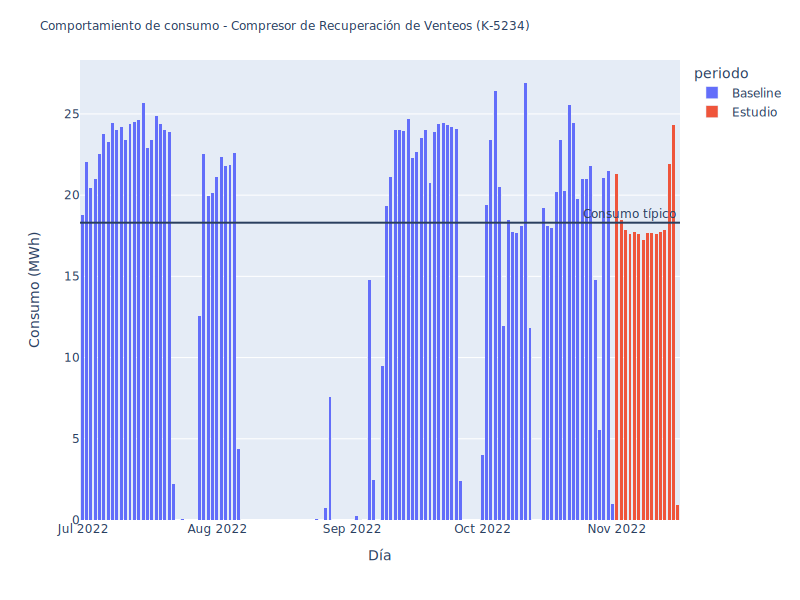

In [491]:
K_5234_diario = K_5234_complete.resample('D').sum().sort_values(by='timestamp', ascending=True).reset_index()
K_5234_diario.replace(0, np.nan, inplace=True)
K_5234_diario['periodo'] = np.where((K_5234_diario['timestamp'] >= datetime.strptime(periodo_historico[0], "%Y-%m-%d")) & (K_5234_diario['timestamp'] <= datetime.strptime(periodo_historico[1], "%Y-%m-%d")), 'Baseline', 'Estudio')


fig = px.bar(K_5234_diario, x="timestamp", y="Consumo (MWh)", color="periodo")

K_5234_diario_LB=K_5234_diario['Consumo (MWh)'].median()
fig.add_hline(y=K_5234_diario_LB, annotation_text=" Consumo típico")


fig.update_layout(barmode='stack', title='Comportamiento de consumo - Compresor de Recuperación de Venteos (K-5234)',width=800, height=600, colorway=['#fc7703', '#757371'], xaxis_title="Día", yaxis_title="Consumo (MWh)", title_font_size=12)
fig.show()

In [492]:
from scipy import stats
K_5234_complete = pd.DataFrame()
K_5234_historico_complete = pd.DataFrame()

Tags_K_5234  = ['FIX.P1-EI-5234-01.F_CV','FIX.P1-FI-5234-02.F_CV','FIX.P1-II-5234-01.F_CV','FIX.P1-JI-5234.F_CV','FIX.P1-PT-5234-09B.F_CV','FIX.P1-PT-5234-28B.F_CV','FIX.P1-TT-5234-03A.F_CV','FIX.P1-TT-5234-05.F_CV','FIX.P1-TT-5234-12.F_CV','FIX.P1-TT-5234-16.F_CV','FIX.P1-TT-5234-22.F_CV','FIX.P1-TT-5234-26.F_CV']
    
    
K_5234_complete = data[Tags_K_5234].astype(float)
K_5234_historico_complete = historic_data.loc[historic_data['NAME'].isin(Tags_K_5234)].drop('datetime', axis=1)

K_5234_historico_complete = K_5234_historico_complete.pivot_table(index='datetime', columns='NAME', values='Active power', aggfunc='mean')

K_5234_complete.replace(0, np.nan, inplace=True)
K_5234_historico_complete.replace(0, np.nan, inplace=True)

K_5234_complete = K_5234_complete[K_5234_complete['FIX.P1-FI-5234-02.F_CV'].between(K_5234_complete['FIX.P1-FI-5234-02.F_CV'].quantile(.2),K_5234_complete['FIX.P1-FI-5234-02.F_CV'].quantile(.8))]
K_5234_historico_complete = K_5234_historico_complete[K_5234_historico_complete['FIX.P1-FI-5234-02.F_CV'].between(K_5234_historico_complete['FIX.P1-FI-5234-02.F_CV'].quantile(.2),K_5234_historico_complete['FIX.P1-FI-5234-02.F_CV'].quantile(.8))]

K_5234_complete = K_5234_complete[K_5234_complete['FIX.P1-JI-5234.F_CV'].between(K_5234_complete['FIX.P1-JI-5234.F_CV'].quantile(.2),K_5234_complete['FIX.P1-JI-5234.F_CV'].quantile(.8))]
K_5234_historico_complete = K_5234_historico_complete[K_5234_historico_complete['FIX.P1-JI-5234.F_CV'].between(K_5234_historico_complete['FIX.P1-JI-5234.F_CV'].quantile(.2),K_5234_historico_complete['FIX.P1-JI-5234.F_CV'].quantile(.8))]

K_5234_complete['KPI (MW KWh/kg)'] = (K_5234_complete['FIX.P1-JI-5234.F_CV']) / K_5234_complete['FIX.P1-FI-5234-02.F_CV']
K_5234_historico_complete['KPI (MW KWh/kg)'] = (K_5234_historico_complete['FIX.P1-JI-5234.F_CV']) / K_5234_historico_complete['FIX.P1-FI-5234-02.F_CV']


K_5234_complete['timestamp'] = pd.to_datetime(K_5234_complete.index)
K_5234_historico_complete['timestamp'] = pd.to_datetime(K_5234_historico_complete.index)




K_5234_complete['periodo'] = np.where((K_5234_complete['timestamp'] > datetime.strptime(periodo_historico[0], "%Y-%m-%d")) & (K_5234_complete['timestamp'] <= datetime.strptime(periodo_historico[1], "%Y-%m-%d")), 'Baseline', 'Estudio')
K_5234_historico_complete['periodo'] = np.where((K_5234_historico_complete['timestamp'] > datetime.strptime(periodo_historico[0], "%Y-%m-%d")) & (K_5234_historico_complete['timestamp'] <= datetime.strptime(periodo_historico[1], "%Y-%m-%d")), 'Baseline', 'Estudio')



K_5234_complete_sp = K_5234_complete[K_5234_complete['periodo']=='Estudio']

K_5234_complete_bl = K_5234_complete[K_5234_complete['periodo']=='Baseline']

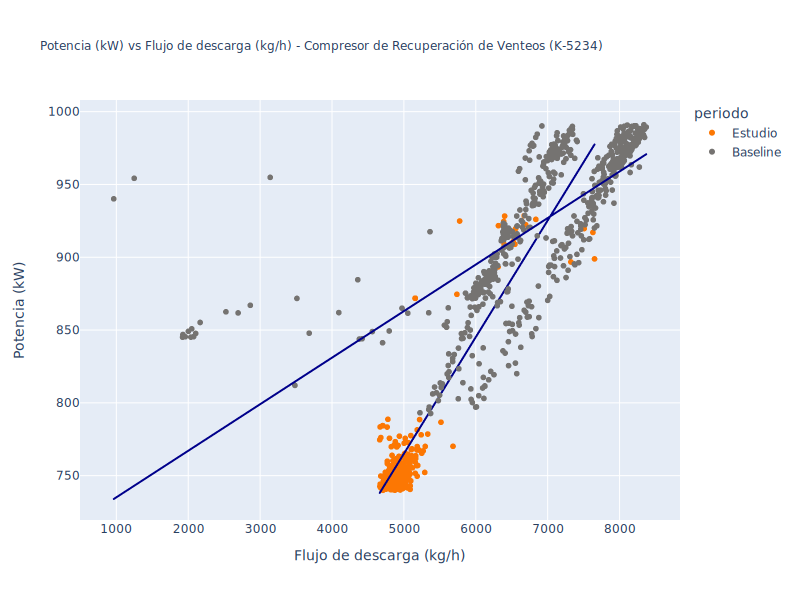

AIC Periodo de estudio 6532.258064371859
AIC Periodo Anterior 4389.281898385323
R^2 Periodo de estudio 0.49105280589690914
R^2 Periodo Anterior 0.7098522700353016
MSE Periodo de estudio 2691.961039274431
MSE Periodo Anterior 1349.2241480862085


In [493]:
K_5234_complete_scatter = pd.concat([K_5234_complete_sp,K_5234_historico_complete], axis = 0)

fig = px.scatter(K_5234_complete_scatter, y=K_5234_complete_scatter['FIX.P1-JI-5234.F_CV'], x=K_5234_complete_scatter['FIX.P1-FI-5234-02.F_CV'], 
color='periodo', trendline="ols", trendline_color_override="darkblue", title='Potencia (kW) vs Flujo de descarga (kg/h) - Compresor de Recuperación de Venteos (K-5234)',
width=800, height=600, color_discrete_map={'Baseline': '#757371', 'Estudio': '#fc7703'}, labels={'FIX.P1-JI-5234.F_CV': 'Potencia (kW)', 'FIX.P1-FI-5234-02.F_CV': 'Flujo de descarga (kg/h)'})
fig.update_layout(title_font_size=12)

fig.show()


print('AIC Periodo de estudio',px.get_trendline_results(fig)['px_fit_results'][1].aic)
print('AIC Periodo Anterior',px.get_trendline_results(fig)['px_fit_results'][0].aic)


print('R^2 Periodo de estudio',px.get_trendline_results(fig)['px_fit_results'][1].rsquared)
print('R^2 Periodo Anterior',px.get_trendline_results(fig)['px_fit_results'][0].rsquared)

print('MSE Periodo de estudio',px.get_trendline_results(fig)['px_fit_results'][1].mse_total)
print('MSE Periodo Anterior',px.get_trendline_results(fig)['px_fit_results'][0].mse_total)

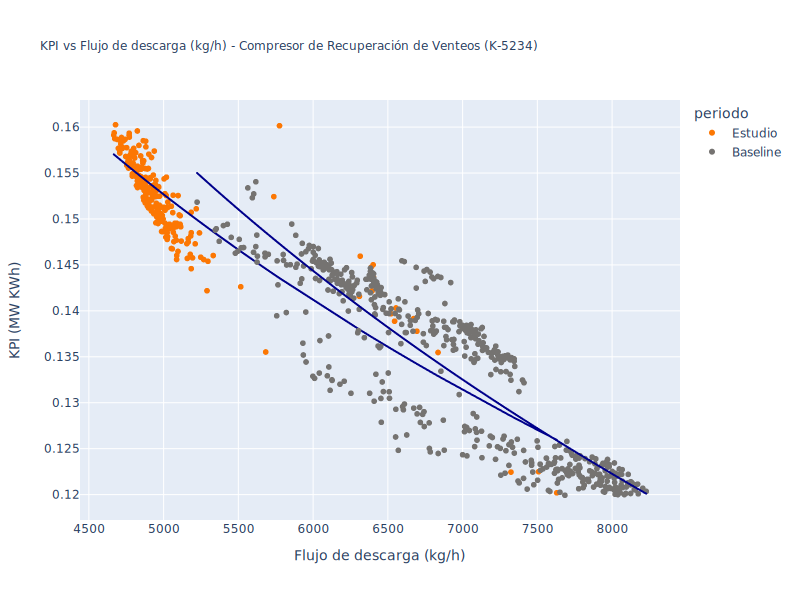

AIC Periodo de estudio -4525.733266519146
AIC Periodo Anterior -4393.443395203074
R^2 Periodo de estudio 0.7827460259101338
R^2 Periodo Anterior 0.7829738309036842
MSE Periodo de estudio 8.652142676545526e-05
MSE Periodo Anterior 2.244938672977051e-05


In [494]:
K_5234_complete_scatter = K_5234_complete_scatter[K_5234_complete_scatter['KPI (MW KWh/kg)'].gt(0)]

K_5234_complete_scatter = K_5234_complete_scatter[K_5234_complete_scatter['KPI (MW KWh/kg)'].between(K_5234_complete_scatter['KPI (MW KWh/kg)'].quantile(.05),K_5234_complete_scatter['KPI (MW KWh/kg)'].quantile(.95))]

fig = px.scatter(K_5234_complete_scatter, y=K_5234_complete_scatter['KPI (MW KWh/kg)'], x=K_5234_complete_scatter['FIX.P1-FI-5234-02.F_CV'], 
color='periodo', trendline="ols",trendline_options=dict(log_x=True), trendline_color_override="darkblue", title='KPI vs Flujo de descarga (kg/h) - Compresor de Recuperación de Venteos (K-5234)',
width=800, height=600, color_discrete_map={'Baseline': '#757371', 'Estudio': '#fc7703'}, labels={'KPI (MW KWh/kg)': 'KPI (MW KWh)', 'FIX.P1-FI-5234-02.F_CV': 'Flujo de descarga (kg/h)'})

fig.update_layout(title_font_size=12)
fig.show()

print('AIC Periodo de estudio',px.get_trendline_results(fig)['px_fit_results'][1].aic)
print('AIC Periodo Anterior',px.get_trendline_results(fig)['px_fit_results'][0].aic)


print('R^2 Periodo de estudio',px.get_trendline_results(fig)['px_fit_results'][1].rsquared)
print('R^2 Periodo Anterior',px.get_trendline_results(fig)['px_fit_results'][0].rsquared)

print('MSE Periodo de estudio',px.get_trendline_results(fig)['px_fit_results'][1].mse_total)
print('MSE Periodo Anterior',px.get_trendline_results(fig)['px_fit_results'][0].mse_total)

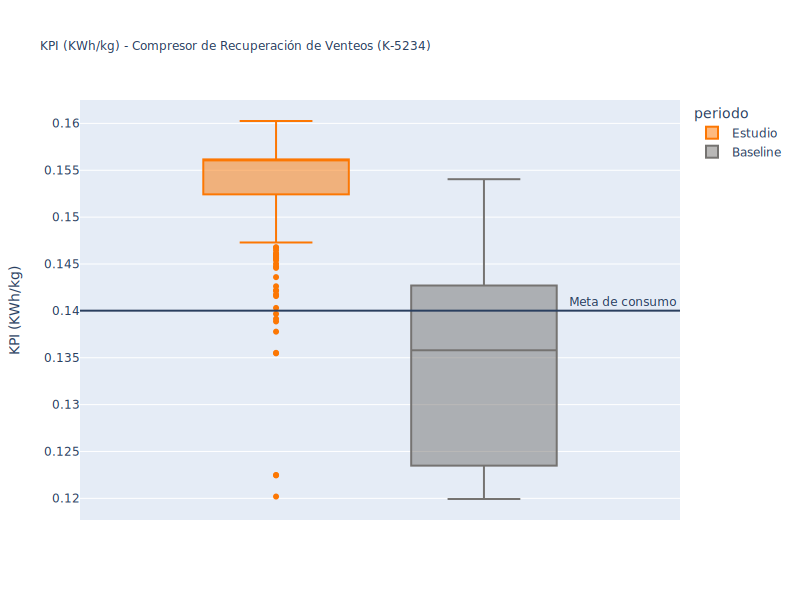

In [495]:
K_5234_LB = K_5234_complete_scatter.loc[(K_5234_complete_scatter['periodo']=="Baseline") & (K_5234_complete_scatter['KPI (MW KWh/kg)'].between(K_5234_complete_scatter['KPI (MW KWh/kg)'].quantile(.25),K_5234_complete_scatter['KPI (MW KWh/kg)'].quantile(.5)))]['KPI (MW KWh/kg)'].mean()

fig = px.box(K_5234_complete_scatter, y=K_5234_complete_scatter['KPI (MW KWh/kg)'], color='periodo',  title='KPI (KWh/kg) - Compresor de Recuperación de Venteos (K-5234)', width=800,
 height=600, color_discrete_map={'Baseline': '#757371', 'Estudio': '#fc7703'}, labels={'KPI (MW KWh/kg)': 'KPI (KWh/kg)'})
fig.add_hline(y=K_5234_LB, annotation_text=" Meta de consumo")
fig.update_layout(title_font_size=12)

fig.show()

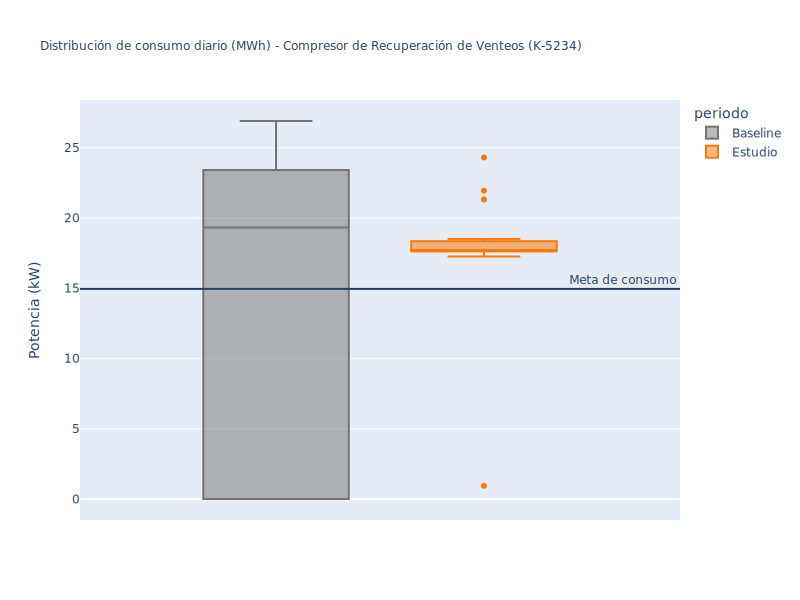

In [496]:

K_5234_LB = K_5234_diario.loc[(K_5234_diario['periodo']=="Baseline") & (K_5234_diario['Consumo (MWh)'].between(K_5234_diario['Consumo (MWh)'].quantile(.3),K_5234_diario['Consumo (MWh)'].quantile(.6)))]['Consumo (MWh)'].mean()

fig = px.box(K_5234_diario, y=K_5234_diario['Consumo (MWh)'], color='periodo',  title='Distribución de consumo diario (MWh) - Compresor de Recuperación de Venteos (K-5234)', width=800,
 height=600, color_discrete_map={'Baseline': '#757371', 'Estudio': '#fc7703'},labels={'Consumo (MWh)': 'Potencia (kW)'})

fig.add_hline(y=K_5234_LB, annotation_text=" Meta de consumo")
fig.update_layout(title_font_size=12)
fig.show()

#### Modelación Analítica

R^2 medio 0.7663229250994182
Error cuadratico medio sobre el conjunto de Test: 670.08 kW


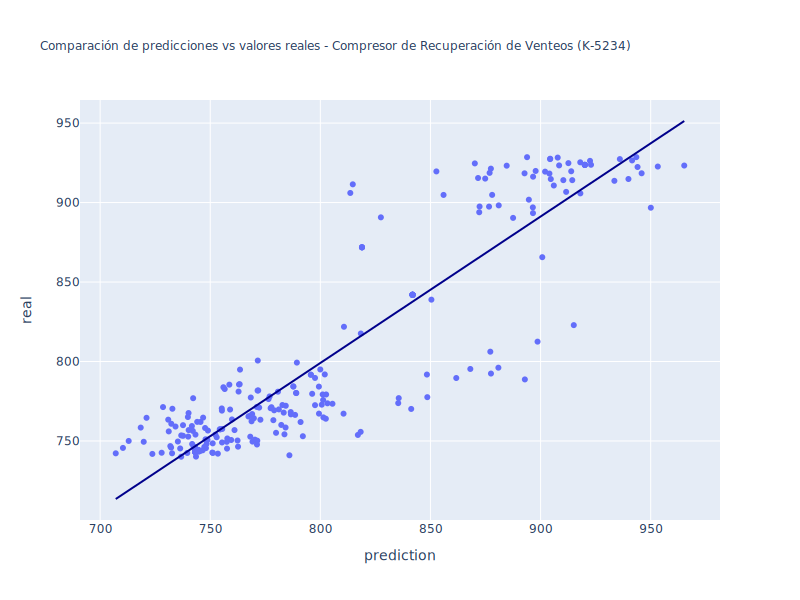

Peso
Suction Temp. 2nd Stage (F_CV)          298.52
Flujo compresor K-5234 (F_CV)           230.90
Discharge Pressure Stage 3 (F_CV)       123.94
Suction Pressure Stage 1 (HIMA) (F_CV)   51.89
Discharge Temp 1st Stage (F_CV)          29.95
Suction Temp. 1st Stage (F_CV)          -20.18
Discharge Temp 2nd Stage (F_CV)         -35.06
Discharge Temp 3rd Stage (F_CV)        -110.10
Suction Temp. 3rd Stage (F_CV)         -413.78

In [497]:
Feature_Tags_K_5234  = ['FIX.P1-FI-5234-02.F_CV','FIX.P1-PT-5234-09B.F_CV','FIX.P1-PT-5234-28B.F_CV','FIX.P1-TT-5234-03A.F_CV','FIX.P1-TT-5234-05.F_CV','FIX.P1-TT-5234-12.F_CV','FIX.P1-TT-5234-16.F_CV','FIX.P1-TT-5234-22.F_CV','FIX.P1-TT-5234-26.F_CV']


Feature_Names_K_5234 = ['Flujo compresor K-5234 (F_CV)','Suction Pressure Stage 1 (HIMA) (F_CV)','Discharge Pressure Stage 3 (F_CV)','Suction Temp. 1st Stage (F_CV)','Discharge Temp 1st Stage (F_CV)','Suction Temp. 2nd Stage (F_CV)','Discharge Temp 2nd Stage (F_CV)','Suction Temp. 3rd Stage (F_CV)','Discharge Temp 3rd Stage (F_CV)']

Output_Tags_K_5234 = ['FIX.P1-JI-5234.F_CV']


K_5234_complete_features = K_5234_complete[Feature_Tags_K_5234]
K_5234_complete_output = K_5234_complete[Output_Tags_K_5234]

from sklearn import svm
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split

scaler = MinMaxScaler()

X = scaler.fit_transform(K_5234_complete_features)
y = K_5234_complete_output.values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42)



SVR = svm.SVR(kernel='linear', C=1e3, gamma=0.1)
validation = cross_validate(SVR, X_train, y_train, cv=10, scoring='r2', return_estimator=True)
print('R^2 medio',validation['test_score'].mean())




best_estimator = validation['estimator'][np.argmax(validation['test_score'])]


prediction = best_estimator.predict(X_test)

comparison = pd.DataFrame([prediction, y_test.flatten()]).T
comparison.columns = ['prediction', 'real']

MSE = np.mean((prediction - y_test.flatten())**2)
print(f"Error cuadratico medio sobre el conjunto de Test: {MSE.round(2)} kW")

fig = px.scatter(comparison, x=comparison['prediction'], y=comparison['real'], trendline="ols", trendline_color_override="darkblue",
 title='Comparación de predicciones vs valores reales - Compresor de Recuperación de Venteos (K-5234)', width=800,
height=600)

fig.update_layout(title_font_size=12)
fig.show()

coeficientes = pd.DataFrame(best_estimator.coef_.T, index=Feature_Names_K_5234, columns=['Peso'])
coeficientes.round(2).sort_values(by='Peso', ascending=False)

# print('Los coeficientes del modelo son: ', best_estimator.coef_)
# print('El intercepto del modelo es: ', best_estimator.intercept_)
# print('los nombres de las variables son: ', Feature_Names_K_5234)

## Análisis por máquina - Planta 2

### Compresor de transporte de N2 (20K050BM01)

In [498]:
Comp_20K050BM01 = Esenttia[Esenttia['Máquina'] == 'Compresor de transporte de N2 (20K050BM01)']
Comp_20K050BM01_historico = Esenttia_historico[Esenttia_historico['Máquina'] == 'Compresor de transporte de N2 (20K050BM01)']


mask_bl = (Comp_20K050BM01_historico['timestamp'] > periodo_historico[0]) & (Comp_20K050BM01_historico['timestamp'] <= periodo_historico[1])
Comp_20K050BM01_bl = Comp_20K050BM01_historico.loc[mask_bl]

mask_sp = (Comp_20K050BM01['timestamp'] >= periodo_de_estudio[0]) & (Comp_20K050BM01['timestamp'] <= periodo_de_estudio[1])
Comp_20K050BM01_sp = Comp_20K050BM01.loc[mask_sp]

Comp_20K050BM01_sp.replace(0, np.nan, inplace=True)
Comp_20K050BM01_bl.replace(0, np.nan, inplace=True)


Comp_20K050BM01_complete = pd.concat([Comp_20K050BM01_sp,Comp_20K050BM01_bl], axis=0)


Comp_20K050BM01_complete['periodo'] = np.where((Comp_20K050BM01_complete['timestamp'] >= datetime.strptime(periodo_historico[0], "%Y-%m-%d")) & (Comp_20K050BM01_complete['timestamp'] <= datetime.strptime(periodo_historico[1], "%Y-%m-%d")), 'Baseline', 'Estudio')

md(f"Durante el periodo de estudio, el consumo total fue de {Comp_20K050BM01_sp['Consumo (MWh)'].sum().round(2)} MWh")

Durante el periodo de estudio, el consumo total fue de 5.79 MWh

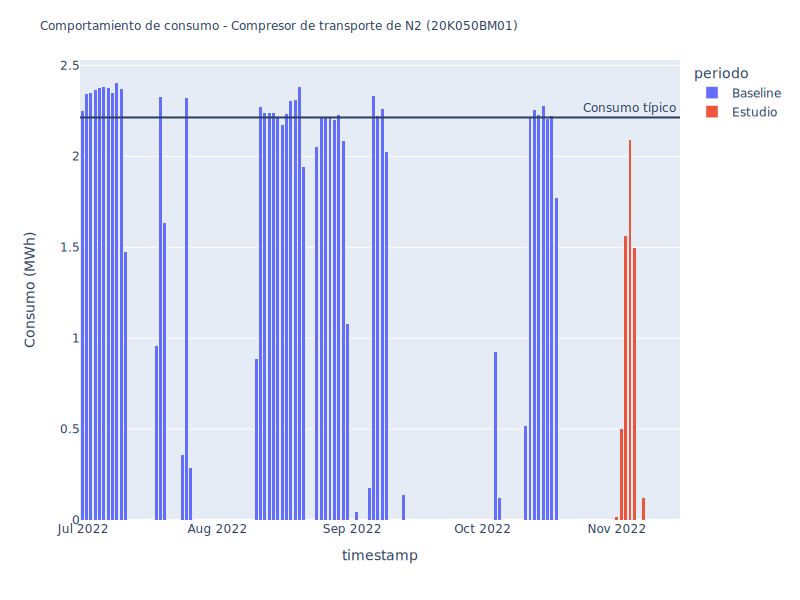

In [499]:
Comp_20K050BM01_diario = Comp_20K050BM01_complete.resample('D').sum().sort_values(by='timestamp', ascending=True).reset_index()
Comp_20K050BM01_diario.replace(0, np.nan, inplace=True)
Comp_20K050BM01_diario['periodo'] = np.where((Comp_20K050BM01_diario['timestamp'] >= datetime.strptime(periodo_historico[0], "%Y-%m-%d")) & (Comp_20K050BM01_diario['timestamp'] <= datetime.strptime(periodo_historico[1], "%Y-%m-%d")), 'Baseline', 'Estudio')



fig = px.bar(Comp_20K050BM01_diario, x="timestamp", y="Consumo (MWh)", color="periodo")
Comp_20K050BM01_diario_LB=Comp_20K050BM01_diario['Consumo (MWh)'].median()
fig.add_hline(y=Comp_20K050BM01_diario_LB, annotation_text=" Consumo típico")

fig.update_layout(barmode='stack', title='Comportamiento de consumo - Compresor de transporte de N2 (20K050BM01)', width=800, height=600, colorway=['#fc7703', '#757371'],title_font_size=12)
fig.show()

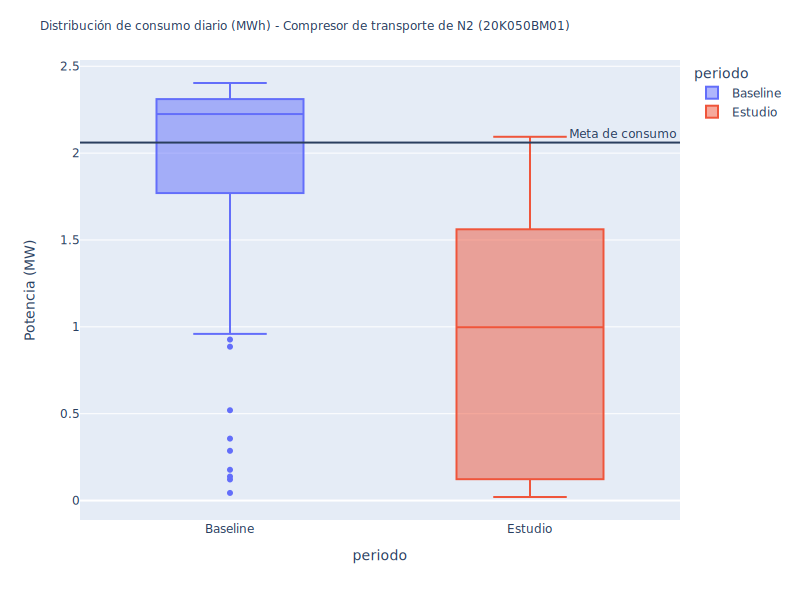

In [500]:
Comp_20K050BM01_LB = Comp_20K050BM01_diario.loc[(Comp_20K050BM01_diario['periodo']=="Baseline") & (Comp_20K050BM01_diario['Consumo (MWh)'].between(Comp_20K050BM01_diario['Consumo (MWh)'].quantile(.25),Comp_20K050BM01_diario['Consumo (MWh)'].quantile(.5)))]['Consumo (MWh)'].mean()

fig = px.box(Comp_20K050BM01_diario, x="periodo", y="Consumo (MWh)", color="periodo")
fig.add_hline(y=Comp_20K050BM01_LB, annotation_text=" Meta de consumo")
fig.update_layout( title='Distribución de consumo diario (MWh) - Compresor de transporte de N2 (20K050BM01)', width=800, height=600, colorway=['#fc7703', '#757371'], yaxis_title="Potencia (MW)", title_font_size=12)
fig.show()


### Compresor de inertes (20K010M01)

In [501]:
Comp_20K010M01 = Esenttia[Esenttia['Máquina'] == 'Compresor de inertes (20K010M01)']
Comp_20K010M01_historico = Esenttia_historico[Esenttia_historico['Máquina'] == 'Compresor de inertes (20K010M01)']


mask_bl = (Comp_20K010M01_historico['timestamp'] > periodo_historico[0]) & (Comp_20K010M01_historico['timestamp'] <= periodo_historico[1])
Comp_20K010M01_bl = Comp_20K010M01_historico.loc[mask_bl]

mask_sp = (Comp_20K010M01['timestamp'] >= periodo_de_estudio[0]) & (Comp_20K010M01['timestamp'] <= periodo_de_estudio[1])
Comp_20K010M01_sp = Comp_20K010M01.loc[mask_sp]

Comp_20K010M01_sp.replace(0, np.nan, inplace=True)
Comp_20K010M01_bl.replace(0, np.nan, inplace=True)


Comp_20K010M01_complete = pd.concat([Comp_20K010M01_sp,Comp_20K010M01_bl], axis=0)


Comp_20K010M01_complete['periodo'] = np.where((Comp_20K010M01_complete['timestamp'] >= datetime.strptime(periodo_historico[0], "%Y-%m-%d")) & (Comp_20K010M01_complete['timestamp'] <= datetime.strptime(periodo_historico[1], "%Y-%m-%d")), 'Baseline', 'Estudio')

md(f"Durante el periodo de estudio, el consumo total fue de {Comp_20K010M01_sp['Consumo (MWh)'].sum().round(2)} MWh, lo que representa una diferencia de {np.round((Comp_20K010M01_bl['Consumo (MWh)'].sum() - Comp_20K010M01_sp['Consumo (MWh)'].sum()),2)} MWh respecto al periodo anterior.")

Durante el periodo de estudio, el consumo total fue de 33.47 MWh, lo que representa una diferencia de 3.96 MWh respecto al periodo anterior.

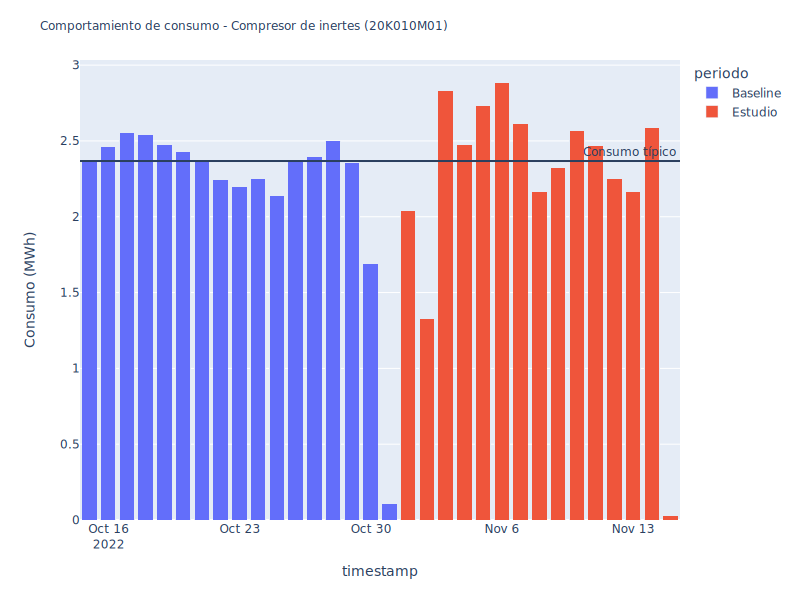

In [502]:
Comp_20K010M01_diario = Comp_20K010M01_complete.resample('D').sum().sort_values(by='timestamp', ascending=True).reset_index()
Comp_20K010M01_diario.replace(0, np.nan, inplace=True)
Comp_20K010M01_diario['periodo'] = np.where((Comp_20K010M01_diario['timestamp'] >= datetime.strptime(periodo_historico[0], "%Y-%m-%d")) & (Comp_20K010M01_diario['timestamp'] <= datetime.strptime(periodo_historico[1], "%Y-%m-%d")), 'Baseline', 'Estudio')


fig = px.bar(Comp_20K010M01_diario, x="timestamp", y="Consumo (MWh)", color="periodo")

Comp_20K010M01_diario_LB=Comp_20K010M01_diario['Consumo (MWh)'].median()
fig.add_hline(y=Comp_20K010M01_diario_LB, annotation_text=" Consumo típico")

fig.update_layout(barmode='stack', title='Comportamiento de consumo - Compresor de inertes (20K010M01)', width=800, height=600, colorway=['#fc7703', '#757371'],title_font_size=12)
fig.show()


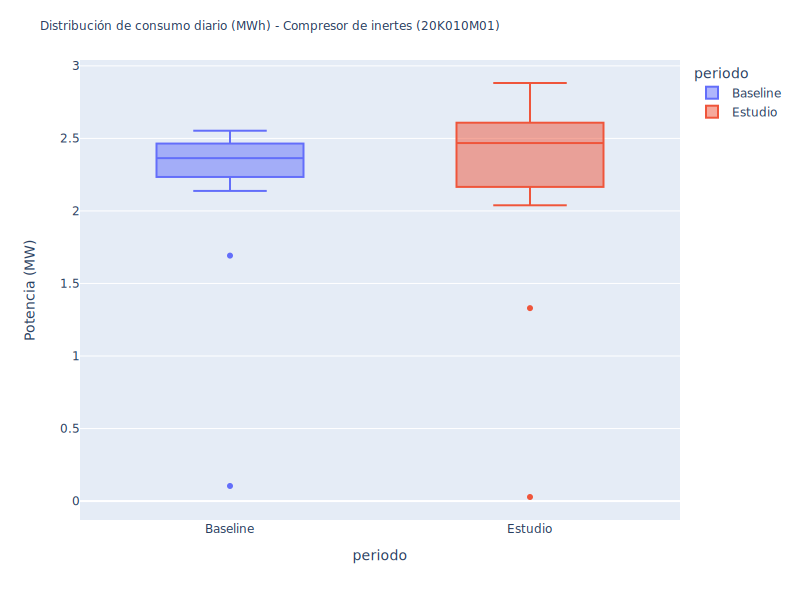

In [503]:


Comp_20K010M01_LB = Comp_20K010M01_diario.loc[(Comp_20K010M01_diario['periodo']=="Baseline") & (Comp_20K010M01_diario['Consumo (MWh)'].between(Comp_20K010M01_diario['Consumo (MWh)'].quantile(.3),Comp_20K010M01_diario['Consumo (MWh)'].quantile(.6)))]['Consumo (MWh)'].mean()

fig = px.box(Comp_20K010M01_diario, x="periodo", y="Consumo (MWh)", color="periodo")
# fig.add_hline(y=Comp_20K010M01_LB, annotation_text=" Meta de consumo")
fig.update_layout( title='Distribución de consumo diario (MWh) - Compresor de inertes (20K010M01)', width=800, height=600, colorway=['#fc7703', '#757371'], yaxis_title="Potencia (MW)", title_font_size=12)
fig.show()

### Blender aditivo sólido A (03DN11AM01)

In [504]:
bl_03DN11AM01 = Esenttia[Esenttia['Máquina'] == 'Blender aditivo sólido A (03DN11AM01)']
bl_03DN11AM01_historico = Esenttia_historico[Esenttia_historico['Máquina'] == 'Blender aditivo sólido A (03DN11AM01)']


mask_bl = (bl_03DN11AM01_historico['timestamp'] > periodo_historico[0]) & (bl_03DN11AM01_historico['timestamp'] <= periodo_historico[1])
bl_03DN11AM01_bl = bl_03DN11AM01_historico.loc[mask_bl]

mask_sp = (bl_03DN11AM01['timestamp'] >= periodo_de_estudio[0]) & (bl_03DN11AM01['timestamp'] <= periodo_de_estudio[1])
bl_03DN11AM01_sp = bl_03DN11AM01.loc[mask_sp]

bl_03DN11AM01_sp.replace(0, np.nan, inplace=True)
bl_03DN11AM01_bl.replace(0, np.nan, inplace=True)


bl_03DN11AM01_complete = pd.concat([bl_03DN11AM01_sp,bl_03DN11AM01_bl], axis=0)


bl_03DN11AM01_complete['periodo'] = np.where((bl_03DN11AM01_complete['timestamp'] >= datetime.strptime(periodo_historico[0], "%Y-%m-%d")) & (bl_03DN11AM01_complete['timestamp'] <= datetime.strptime(periodo_historico[1], "%Y-%m-%d")), 'Baseline', 'Estudio')

md(f"Durante el periodo de estudio, el consumo total fue de {bl_03DN11AM01_sp['Consumo (MWh)'].sum().round(2)} MWh")

Durante el periodo de estudio, el consumo total fue de 0.23 MWh

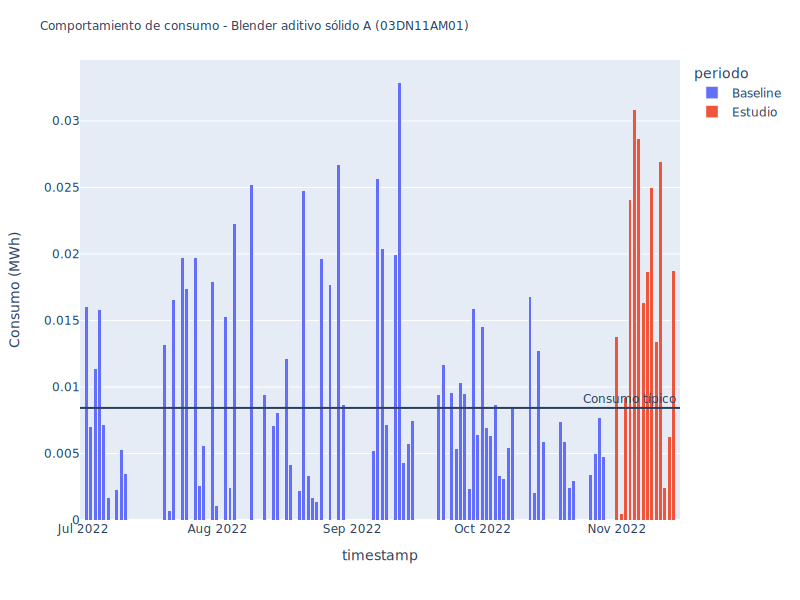

In [505]:
bl_03DN11AM01_diario = bl_03DN11AM01_complete.resample('D').sum().sort_values(by='timestamp', ascending=True).reset_index()
bl_03DN11AM01_diario.replace(0, np.nan, inplace=True)
bl_03DN11AM01_diario['periodo'] = np.where((bl_03DN11AM01_diario['timestamp'] >= datetime.strptime(periodo_historico[0], "%Y-%m-%d")) & (bl_03DN11AM01_diario['timestamp'] <= datetime.strptime(periodo_historico[1], "%Y-%m-%d")), 'Baseline', 'Estudio')


fig = px.bar(bl_03DN11AM01_diario, x="timestamp", y="Consumo (MWh)", color="periodo")

bl_03DN11AM01_diario_LB=bl_03DN11AM01_diario['Consumo (MWh)'].median()
fig.add_hline(y=bl_03DN11AM01_diario_LB, annotation_text=" Consumo típico")

fig.update_layout(barmode='stack', title='Comportamiento de consumo - Blender aditivo sólido A (03DN11AM01)', width=800, height=600, colorway=['#fc7703', '#757371'],title_font_size=12)
fig.show()

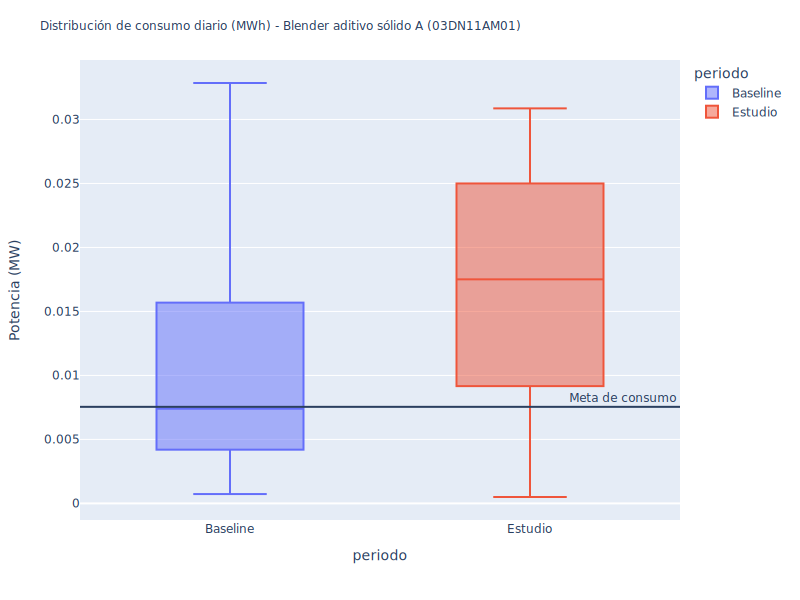

In [506]:


bl_03DN11AM01_LB = bl_03DN11AM01_diario.loc[(bl_03DN11AM01_diario['periodo']=="Baseline") & (bl_03DN11AM01_diario['Consumo (MWh)'].between(bl_03DN11AM01_diario['Consumo (MWh)'].quantile(.3),bl_03DN11AM01_diario['Consumo (MWh)'].quantile(.6)))]['Consumo (MWh)'].mean()

fig = px.box(bl_03DN11AM01_diario, x="periodo", y="Consumo (MWh)", color="periodo")
fig.add_hline(y=bl_03DN11AM01_LB, annotation_text=" Meta de consumo")
fig.update_layout( title='Distribución de consumo diario (MWh) - Blender aditivo sólido A (03DN11AM01)', width=800, height=600, colorway=['#fc7703', '#757371'], yaxis_title="Potencia (MW)", title_font_size=12)
fig.show()

### Agitador de purga (20DN51M01)

In [507]:

Ag_20DN51M01 = Esenttia[Esenttia['Máquina'] == 'Agitador de purga (20DN51M01)']
Ag_20DN51M01_historico = Esenttia_historico[Esenttia_historico['Máquina'] == 'Agitador de purga (20DN51M01)']


mask_bl = (Ag_20DN51M01_historico['timestamp'] > periodo_historico[0]) & (Ag_20DN51M01_historico['timestamp'] <= periodo_historico[1])
Ag_20DN51M01_bl = Ag_20DN51M01_historico.loc[mask_bl]

mask_sp = (Ag_20DN51M01['timestamp'] >= periodo_de_estudio[0]) & (Ag_20DN51M01['timestamp'] <= periodo_de_estudio[1])
Ag_20DN51M01_sp = Ag_20DN51M01.loc[mask_sp]

Ag_20DN51M01_sp.replace(0, np.nan, inplace=True)
Ag_20DN51M01_bl.replace(0, np.nan, inplace=True)


Ag_20DN51M01_complete = pd.concat([Ag_20DN51M01_sp,Ag_20DN51M01_bl], axis=0)


Ag_20DN51M01_complete['periodo'] = np.where((Ag_20DN51M01_complete['timestamp'] >= datetime.strptime(periodo_historico[0], "%Y-%m-%d")) & (Ag_20DN51M01_complete['timestamp'] <= datetime.strptime(periodo_historico[1], "%Y-%m-%d")), 'Baseline', 'Estudio')

md(f"Durante el periodo de estudio, el consumo total fue de {Ag_20DN51M01_sp['Consumo (MWh)'].sum().round(2)} MWh")

Durante el periodo de estudio, el consumo total fue de 29.74 MWh

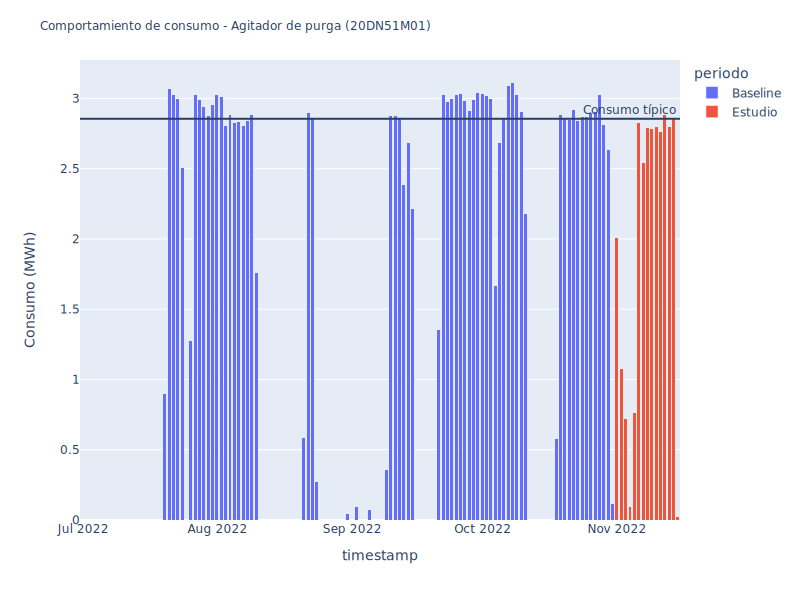

In [508]:
Ag_20DN51M01_diario = Ag_20DN51M01_complete.resample('D').sum().sort_values(by='timestamp', ascending=True).reset_index()
Ag_20DN51M01_diario.replace(0, np.nan, inplace=True)
Ag_20DN51M01_diario['periodo'] = np.where((Ag_20DN51M01_diario['timestamp'] >= datetime.strptime(periodo_historico[0], "%Y-%m-%d")) & (Ag_20DN51M01_diario['timestamp'] <= datetime.strptime(periodo_historico[1], "%Y-%m-%d")), 'Baseline', 'Estudio')


fig = px.bar(Ag_20DN51M01_diario, x="timestamp", y="Consumo (MWh)", color="periodo")

Ag_20DN51M01_diario_LB=Ag_20DN51M01_diario['Consumo (MWh)'].median()
fig.add_hline(y=Ag_20DN51M01_diario_LB, annotation_text=" Consumo típico")

fig.update_layout(barmode='stack', title='Comportamiento de consumo - Agitador de purga (20DN51M01)', width=800, height=600, colorway=['#fc7703', '#757371'],title_font_size=12)
fig.show()

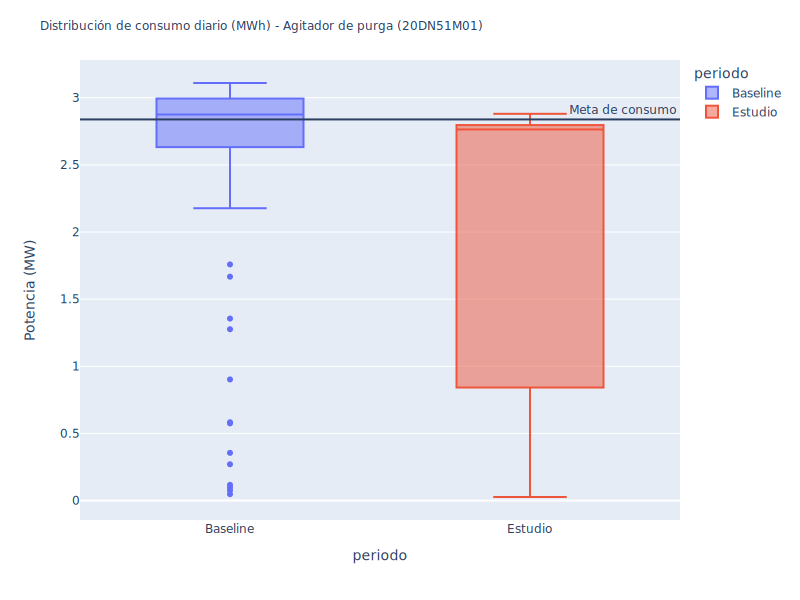

In [509]:

Ag_20DN51M01_LB = Ag_20DN51M01_diario.loc[(Ag_20DN51M01_diario['periodo']=="Baseline") & (Ag_20DN51M01_diario['Consumo (MWh)'].between(Ag_20DN51M01_diario['Consumo (MWh)'].quantile(.3),Ag_20DN51M01_diario['Consumo (MWh)'].quantile(.6)))]['Consumo (MWh)'].mean()

fig = px.box(Ag_20DN51M01_diario, x="periodo", y="Consumo (MWh)", color="periodo")
fig.add_hline(y=Ag_20DN51M01_LB, annotation_text=" Meta de consumo")
fig.update_layout( title='Distribución de consumo diario (MWh) - Agitador de purga (20DN51M01)', width=800, height=600, colorway=['#fc7703', '#757371'], yaxis_title="Potencia (MW)", title_font_size=12)
fig.show()

### Bombas torre de enfriamiento (94P010CM01) y (94P010DM01)

In [510]:

Bom_94P010CM01 = Esenttia[Esenttia['Máquina'] == 'Bombas torre de enfriamiento (94P010CM01) y (94P010DM01)']
Bom_94P010CM01_historico = Esenttia_historico[Esenttia_historico['Máquina'] == 'Bombas torre de enfriamiento (94P010CM01) y (94P010DM01)']


mask_bl = (Bom_94P010CM01_historico['timestamp'] > periodo_historico[0]) & (Bom_94P010CM01_historico['timestamp'] <= periodo_historico[1])
Bom_94P010CM01_bl = Bom_94P010CM01_historico.loc[mask_bl]

mask_sp = (Bom_94P010CM01['timestamp'] >= periodo_de_estudio[0]) & (Bom_94P010CM01['timestamp'] <= periodo_de_estudio[1])
Bom_94P010CM01_sp = Bom_94P010CM01.loc[mask_sp]

Bom_94P010CM01_sp.replace(0, np.nan, inplace=True)
Bom_94P010CM01_bl.replace(0, np.nan, inplace=True)


Bom_94P010CM01_complete = pd.concat([Bom_94P010CM01_sp,Bom_94P010CM01_bl], axis=0)


Bom_94P010CM01_complete['periodo'] = np.where((Bom_94P010CM01_complete['timestamp'] >= datetime.strptime(periodo_historico[0], "%Y-%m-%d")) & (Bom_94P010CM01_complete['timestamp'] <= datetime.strptime(periodo_historico[1], "%Y-%m-%d")), 'Baseline', 'Estudio')

md(f"Durante el periodo de estudio, el consumo total fue de {Bom_94P010CM01_sp['Consumo (MWh)'].sum().round(2)} MWh")

Durante el periodo de estudio, el consumo total fue de 116.54 MWh

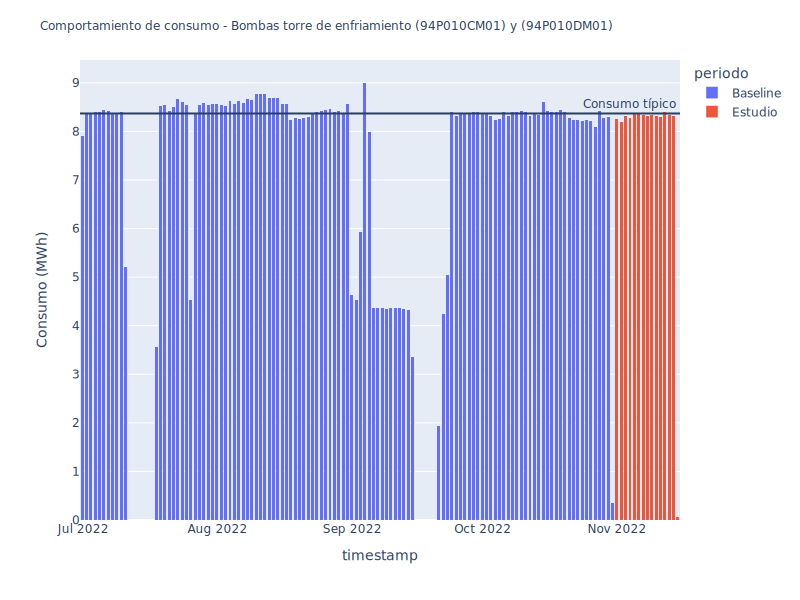

In [511]:
Bom_94P010CM01_diario = Bom_94P010CM01_complete.resample('D').sum().sort_values(by='timestamp', ascending=True).reset_index()
Bom_94P010CM01_diario.replace(0, np.nan, inplace=True)
Bom_94P010CM01_diario['periodo'] = np.where((Bom_94P010CM01_diario['timestamp'] >= datetime.strptime(periodo_historico[0], "%Y-%m-%d")) & (Bom_94P010CM01_diario['timestamp'] <= datetime.strptime(periodo_historico[1], "%Y-%m-%d")), 'Baseline', 'Estudio')


fig = px.bar(Bom_94P010CM01_diario, x="timestamp", y="Consumo (MWh)", color="periodo")


Bom_94P010CM01_diario_LB=Bom_94P010CM01_diario['Consumo (MWh)'].median()
fig.add_hline(y=Bom_94P010CM01_diario_LB, annotation_text=" Consumo típico")

fig.update_layout(barmode='stack', title='Comportamiento de consumo - Bombas torre de enfriamiento (94P010CM01) y (94P010DM01)', width=800, height=600, colorway=['#fc7703', '#757371'],title_font_size=12)
fig.show()

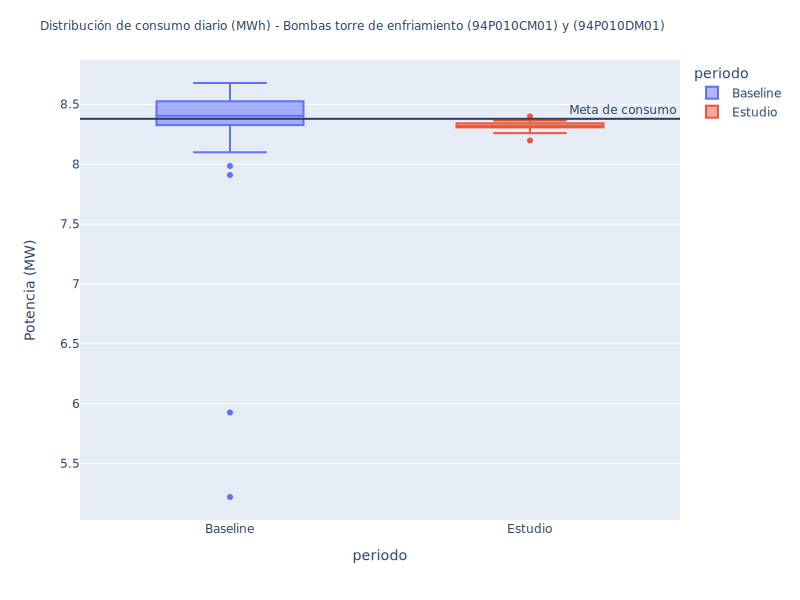

In [512]:


Bom_94P010CM01_diario = Bom_94P010CM01_diario[Bom_94P010CM01_diario['Consumo (MWh)'].between(Bom_94P010CM01_diario['Consumo (MWh)'].quantile(.15),Bom_94P010CM01_diario['Consumo (MWh)'].quantile(.95))]

Bom_94P010CM01_LB = Bom_94P010CM01_diario.loc[(Bom_94P010CM01_diario['periodo']=="Baseline") & (Bom_94P010CM01_diario['Consumo (MWh)'].between(Bom_94P010CM01_diario['Consumo (MWh)'].quantile(.3),Bom_94P010CM01_diario['Consumo (MWh)'].quantile(.6)))]['Consumo (MWh)'].mean()

fig = px.box(Bom_94P010CM01_diario, x="periodo", y="Consumo (MWh)", color="periodo")
fig.add_hline(y=Bom_94P010CM01_LB, annotation_text=" Meta de consumo")
fig.update_layout( title='Distribución de consumo diario (MWh) - Bombas torre de enfriamiento (94P010CM01) y (94P010DM01)', width=800, height=600, colorway=['#fc7703', '#757371'], yaxis_title="Potencia (MW)", title_font_size=12)
fig.show()

### Bombas torre de enfriamiento (94P010AM01) y (94P010BM01)

In [513]:

Bom_4P010AM01 = Esenttia[Esenttia['Máquina'] == 'Bombas torre de enfriamiento (94P010AM01) y (94P010BM01)']
Bom_4P010AM01_historico = Esenttia_historico[Esenttia_historico['Máquina'] == 'Bombas torre de enfriamiento (94P010AM01) y (94P010BM01)']


mask_bl = (Bom_4P010AM01_historico['timestamp'] > periodo_historico[0]) & (Bom_4P010AM01_historico['timestamp'] <= periodo_historico[1])
Bom_4P010AM01_bl = Bom_4P010AM01_historico.loc[mask_bl]

mask_sp = (Bom_4P010AM01['timestamp'] >= periodo_de_estudio[0]) & (Bom_4P010AM01['timestamp'] <= periodo_de_estudio[1])
Bom_4P010AM01_sp = Bom_4P010AM01.loc[mask_sp]

Bom_4P010AM01_sp.replace(0, np.nan, inplace=True)
Bom_4P010AM01_bl.replace(0, np.nan, inplace=True)


Bom_4P010AM01_complete = pd.concat([Bom_4P010AM01_sp,Bom_4P010AM01_bl], axis=0)


Bom_4P010AM01_complete['periodo'] = np.where((Bom_4P010AM01_complete['timestamp'] >= datetime.strptime(periodo_historico[0], "%Y-%m-%d")) & (Bom_4P010AM01_complete['timestamp'] <= datetime.strptime(periodo_historico[1], "%Y-%m-%d")), 'Baseline', 'Estudio')

md(f"Durante el periodo de estudio, el consumo total fue de {Bom_4P010AM01_sp['Consumo (MWh)'].sum().round(2)} MWh")
md(f"Durante el periodo de estudio, el consumo total fue de {Bom_4P010AM01_sp['Consumo (MWh)'].sum().round(2)} MWh")

Durante el periodo de estudio, el consumo total fue de 123.34 MWh

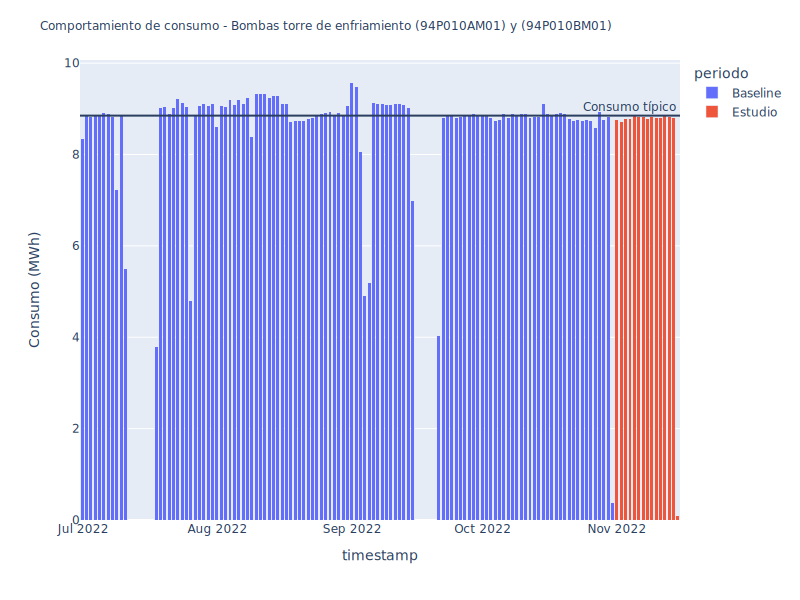

In [514]:
Bom_4P010AM01_diario = Bom_4P010AM01_complete.resample('D').sum().sort_values(by='timestamp', ascending=True).reset_index()
Bom_4P010AM01_diario.replace(0, np.nan, inplace=True)
Bom_4P010AM01_diario['periodo'] = np.where((Bom_4P010AM01_diario['timestamp'] >= datetime.strptime(periodo_historico[0], "%Y-%m-%d")) & (Bom_4P010AM01_diario['timestamp'] <= datetime.strptime(periodo_historico[1], "%Y-%m-%d")), 'Baseline', 'Estudio')



fig = px.bar(Bom_4P010AM01_diario, x="timestamp", y="Consumo (MWh)", color="periodo")

Bom_4P010AM01_diario_LB=Bom_4P010AM01_diario['Consumo (MWh)'].median()
fig.add_hline(y=Bom_4P010AM01_diario_LB, annotation_text=" Consumo típico")

fig.update_layout(barmode='stack', title='Comportamiento de consumo - Bombas torre de enfriamiento (94P010AM01) y (94P010BM01)', width=800, height=600, colorway=['#fc7703', '#757371'],title_font_size=12)
fig.show()

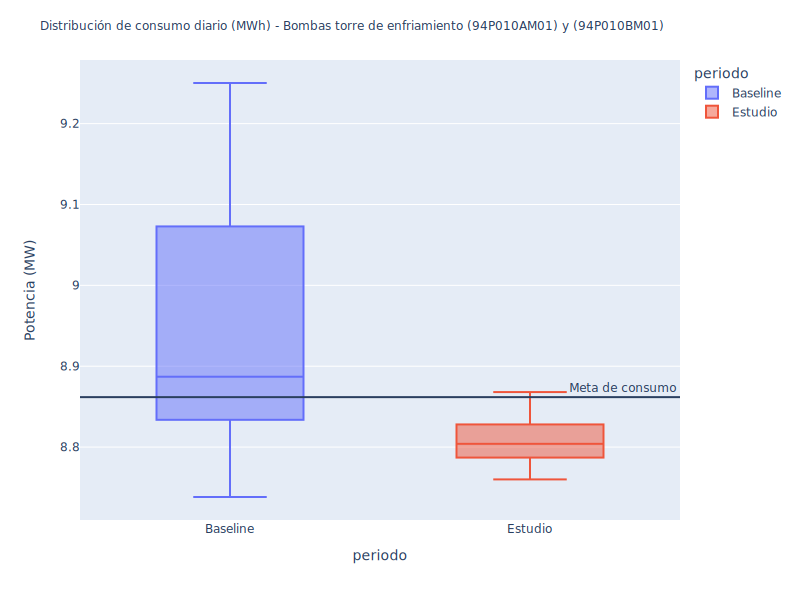

In [515]:
Bom_4P010AM01_diario = Bom_4P010AM01_diario[Bom_4P010AM01_diario['Consumo (MWh)'].between(Bom_4P010AM01_diario['Consumo (MWh)'].quantile(.15),Bom_4P010AM01_diario['Consumo (MWh)'].quantile(.95))]


Bom_4P010AM01_LB = Bom_4P010AM01_diario.loc[(Bom_4P010AM01_diario['periodo']=="Baseline") & (Bom_4P010AM01_diario['Consumo (MWh)'].between(Bom_4P010AM01_diario['Consumo (MWh)'].quantile(.3),Bom_4P010AM01_diario['Consumo (MWh)'].quantile(.6)))]['Consumo (MWh)'].mean()

fig = px.box(Bom_4P010AM01_diario, x="periodo", y="Consumo (MWh)", color="periodo")
fig.add_hline(y=Bom_4P010AM01_LB, annotation_text=" Meta de consumo")
fig.update_layout( title='Distribución de consumo diario (MWh) - Bombas torre de enfriamiento (94P010AM01) y (94P010BM01)', width=800, height=600, colorway=['#fc7703', '#757371'], yaxis_title="Potencia (MW)", title_font_size=12)
fig.show()

### COMPRESOR DE NITROGENO (K-1104)

In [516]:

K_1104 = Esenttia[Esenttia['Máquina'] == 'COMPRESOR DE NITROGENO (K-1104)']
K_1104_historico = Esenttia_historico[Esenttia_historico['Máquina'] == 'COMPRESOR DE NITROGENO (K-1104)']


mask_bl = (K_1104_historico['timestamp'] > periodo_historico[0]) & (K_1104_historico['timestamp'] <= periodo_historico[1])
K_1104_bl = K_1104_historico.loc[mask_bl]

mask_sp = (K_1104['timestamp'] >= periodo_de_estudio[0]) & (K_1104['timestamp'] <= periodo_de_estudio[1])
K_1104_sp = K_1104.loc[mask_sp]

K_1104_sp.replace(0, np.nan, inplace=True)
K_1104_bl.replace(0, np.nan, inplace=True)


K_1104_complete = pd.concat([K_1104_sp,K_1104_bl], axis=0)


K_1104_complete['periodo'] = np.where((K_1104_complete['timestamp'] >= datetime.strptime(periodo_historico[0], "%Y-%m-%d")) & (K_1104_complete['timestamp'] <= datetime.strptime(periodo_historico[1], "%Y-%m-%d")), 'Baseline', 'Estudio')

md(f"Durante el periodo de estudio, el consumo total fue de {K_1104_sp['Consumo (MWh)'].sum().round(2)} MWh")
md(f"Durante el periodo de estudio, el consumo total fue de {K_1104_sp['Consumo (MWh)'].sum().round(2)} MWh")

Durante el periodo de estudio, el consumo total fue de 25.67 MWh

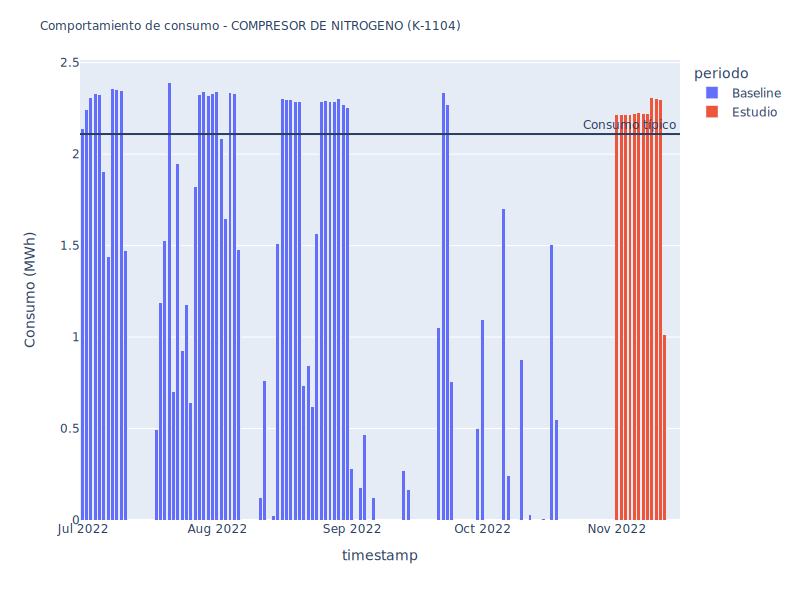

In [517]:
K_1104_diario = K_1104_complete.resample('D').sum().sort_values(by='timestamp', ascending=True).reset_index()
K_1104_diario.replace(0, np.nan, inplace=True)
K_1104_diario['periodo'] = np.where((K_1104_diario['timestamp'] >= datetime.strptime(periodo_historico[0], "%Y-%m-%d")) & (K_1104_diario['timestamp'] <= datetime.strptime(periodo_historico[1], "%Y-%m-%d")), 'Baseline', 'Estudio')


fig = px.bar(K_1104_diario, x="timestamp", y="Consumo (MWh)", color="periodo")

K_1104_diario_LB=K_1104_diario['Consumo (MWh)'].median()
fig.add_hline(y=K_1104_diario_LB, annotation_text=" Consumo típico")
fig.update_layout(barmode='stack', title='Comportamiento de consumo - COMPRESOR DE NITROGENO (K-1104)', width=800, height=600, colorway=['#fc7703', '#757371'],title_font_size=12)
fig.show()

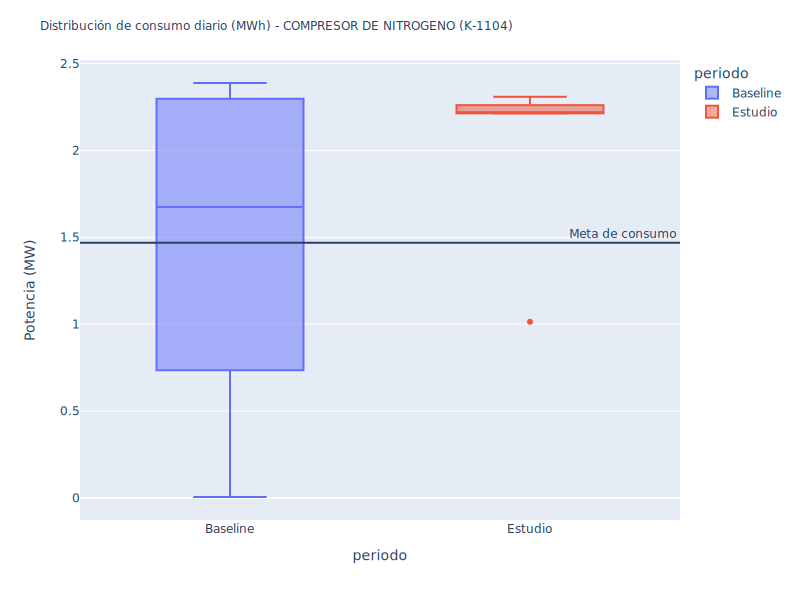

In [518]:

K_1104_LB = K_1104_diario.loc[(K_1104_diario['periodo']=="Baseline") & (K_1104_diario['Consumo (MWh)'].between(K_1104_diario['Consumo (MWh)'].quantile(.25),K_1104_diario['Consumo (MWh)'].quantile(.5)))]['Consumo (MWh)'].mean()

fig = px.box(K_1104_diario, x="periodo", y="Consumo (MWh)", color="periodo")
fig.add_hline(y=K_1104_LB, annotation_text=" Meta de consumo")
fig.update_layout( title='Distribución de consumo diario (MWh) - COMPRESOR DE NITROGENO (K-1104)', width=800, height=600, colorway=['#fc7703', '#757371'], yaxis_title="Potencia (MW)", title_font_size=12)
fig.show()

### Compresor de nitrógeno (01K040M01)

In [519]:
Comp_01K040M01 = Esenttia[Esenttia['Máquina'] == 'Compresor de nitrógeno (01K040M01)']
Comp_01K040M01_historico = Esenttia_historico[Esenttia_historico['Máquina'] == 'Compresor de nitrógeno (01K040M01)']


mask_bl = (Comp_01K040M01_historico['timestamp'] > periodo_historico[0]) & (Comp_01K040M01_historico['timestamp'] <= periodo_historico[1])
Comp_01K040M01_bl = Comp_01K040M01_historico.loc[mask_bl]

mask_sp = (Comp_01K040M01['timestamp'] >= periodo_de_estudio[0]) & (Comp_01K040M01['timestamp'] <= periodo_de_estudio[1])
Comp_01K040M01_sp = Comp_01K040M01.loc[mask_sp]

Comp_01K040M01_sp.replace(0, np.nan, inplace=True)
Comp_01K040M01_bl.replace(0, np.nan, inplace=True)


Comp_01K040M01_complete = pd.concat([Comp_01K040M01_sp,Comp_01K040M01_bl], axis=0)


Comp_01K040M01_complete['periodo'] = np.where((Comp_01K040M01_complete['timestamp'] >= datetime.strptime(periodo_historico[0], "%Y-%m-%d")) & (Comp_01K040M01_complete['timestamp'] <= datetime.strptime(periodo_historico[1], "%Y-%m-%d")), 'Baseline', 'Estudio')

md(f"Durante el periodo de estudio, el consumo total fue de {Comp_01K040M01_sp['Consumo (MWh)'].sum().round(2)} MWh")
md(f"Durante el periodo de estudio, el consumo total fue de {Comp_01K040M01_sp['Consumo (MWh)'].sum().round(2)} MWh")

Durante el periodo de estudio, el consumo total fue de 0.0 MWh

In [520]:
# Comp_01K040M01_diario = Comp_01K040M01_complete.resample('D').sum().sort_values(by='timestamp', ascending=True).reset_index()
# Comp_01K040M01_diario.replace(0, np.nan, inplace=True)
# Comp_01K040M01_diario['periodo'] = np.where((Comp_01K040M01_diario['timestamp'] >= datetime.strptime(periodo_historico[0], "%Y-%m-%d")) & (Comp_01K040M01_diario['timestamp'] <= datetime.strptime(periodo_historico[1], "%Y-%m-%d")), 'Baseline', 'Estudio')


# fig = px.bar(Comp_01K040M01_diario, x="timestamp", y="Consumo (MWh)", color="periodo")

# fig.update_layout(barmode='stack', title='Comportamiento de consumo Q1 vs Q2 - COMPRESOR DE NITROGENO (K-1104)', width=800, height=600, colorway=['#fc7703', '#757371'],title_font_size=12)
# fig.show()

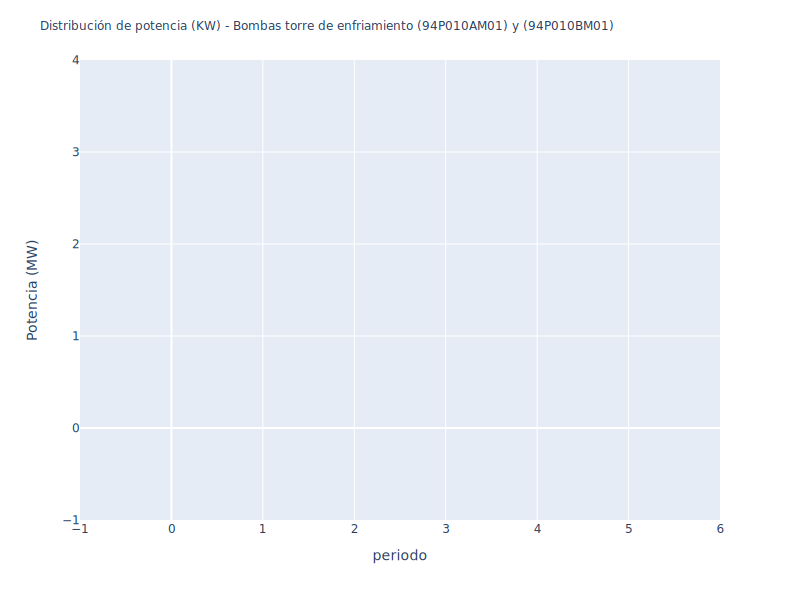

In [521]:

Comp_01K040M01_LB = Comp_01K040M01_complete.loc[(Comp_01K040M01_complete['periodo']=="Baseline") & (Comp_01K040M01_complete['Consumo (MWh)'].between(Comp_01K040M01_complete['Consumo (MWh)'].quantile(.3),Comp_01K040M01_complete['Consumo (MWh)'].quantile(.6)))]['Consumo (MWh)'].mean()

fig = px.box(Comp_01K040M01_complete, x="periodo", y="Consumo (MWh)", color="periodo")
fig.add_hline(y=Comp_01K040M01_LB, annotation_text=" Meta de consumo")
fig.update_layout( title='Distribución de potencia (KW) - Bombas torre de enfriamiento (94P010AM01) y (94P010BM01)', width=800, height=600, colorway=['#fc7703', '#757371'], yaxis_title="Potencia (MW)", title_font_size=12)
fig.show()

### Bomba torres de enfriamiento (94P010E)

In [522]:
bomb_94P010E = Esenttia[Esenttia['Máquina'] == 'Bomba torres de enfriamiento (94P010E)']
bomb_94P010E_historico = Esenttia_historico[Esenttia_historico['Máquina'] == 'Bomba torres de enfriamiento (94P010E)']


mask_bl = (bomb_94P010E_historico['timestamp'] > periodo_historico[0]) & (bomb_94P010E_historico['timestamp'] <= periodo_historico[1])
bomb_94P010E_bl = bomb_94P010E_historico.loc[mask_bl]

mask_sp = (bomb_94P010E['timestamp'] >= periodo_de_estudio[0]) & (bomb_94P010E['timestamp'] <= periodo_de_estudio[1])
bomb_94P010E_sp = bomb_94P010E.loc[mask_sp]

bomb_94P010E_sp.replace(0, np.nan, inplace=True)
bomb_94P010E_bl.replace(0, np.nan, inplace=True)


bomb_94P010E_complete = pd.concat([bomb_94P010E_sp,bomb_94P010E_bl], axis=0)


bomb_94P010E_complete['periodo'] = np.where((bomb_94P010E_complete['timestamp'] >= datetime.strptime(periodo_historico[0], "%Y-%m-%d")) & (bomb_94P010E_complete['timestamp'] <= datetime.strptime(periodo_historico[1], "%Y-%m-%d")), 'Baseline', 'Estudio')

md(f"Durante el periodo de estudio, el consumo total fue de {bomb_94P010E_sp['Consumo (MWh)'].sum().round(2)} MWh")
md(f"Durante el periodo de estudio, el consumo total fue de {bomb_94P010E_sp['Consumo (MWh)'].sum().round(2)} MWh")

Durante el periodo de estudio, el consumo total fue de 0.0 MWh

In [523]:
# bomb_94P010E_diario = bomb_94P010E_complete.resample('D').sum().sort_values(by='timestamp', ascending=True).reset_index()
# bomb_94P010E_diario.replace(0, np.nan, inplace=True)
# bomb_94P010E_diario['periodo'] = np.where((bomb_94P010E_diario['timestamp'] >= datetime.strptime(periodo_historico[0], "%Y-%m-%d")) & (bomb_94P010E_diario['timestamp'] <= datetime.strptime(periodo_historico[1], "%Y-%m-%d")), 'Baseline', 'Estudio')


# fig = px.bar(bomb_94P010E_diario, x="timestamp", y="Consumo (MWh)", color="periodo")

# fig.update_layout(barmode='stack', title='Comportamiento de consumo Q1 vs Q2 - COMPRESOR DE NITROGENO (K-1104)', width=800, height=600, colorway=['#fc7703', '#757371'],title_font_size=12)
# fig.show()

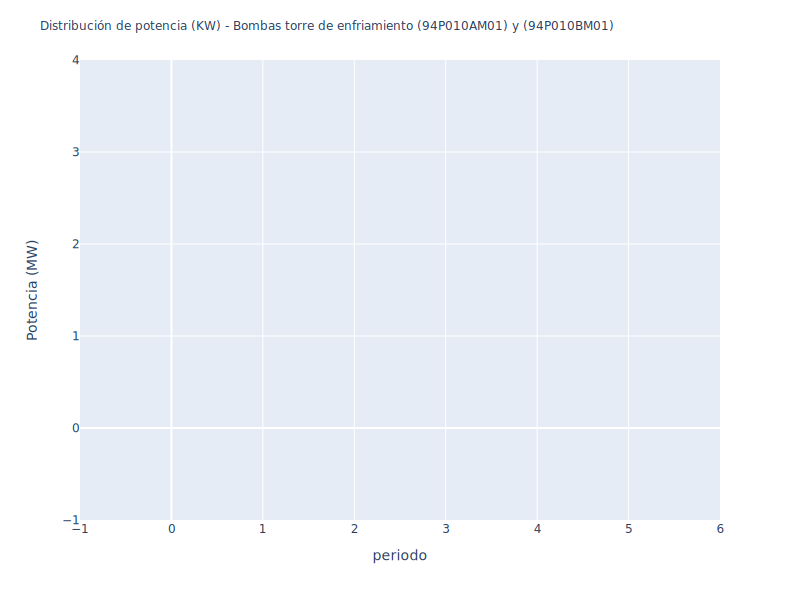

In [524]:

bomb_94P010E_LB = bomb_94P010E_complete.loc[(bomb_94P010E_complete['periodo']=="Baseline") & (bomb_94P010E_complete['Consumo (MWh)'].between(bomb_94P010E_complete['Consumo (MWh)'].quantile(.3),bomb_94P010E_complete['Consumo (MWh)'].quantile(.6)))]['Consumo (MWh)'].mean()

fig = px.box(bomb_94P010E_complete, x="periodo", y="Consumo (MWh)", color="periodo")
fig.add_hline(y=bomb_94P010E_LB, annotation_text=" Meta de consumo")
fig.update_layout( title='Distribución de potencia (KW) - Bombas torre de enfriamiento (94P010AM01) y (94P010BM01)', width=800, height=600, colorway=['#fc7703', '#757371'], yaxis_title="Potencia (MW)", title_font_size=12)
fig.show()

### Extrusora 21UN20

In [525]:

Ex_21UN20 = Esenttia[Esenttia['Máquina'] == 'Extrusora (21UN20)']
Ex_21UN20_historico = Esenttia_historico[Esenttia_historico['Máquina'] == 'Extrusora (21UN20)']


mask_bl = (Ex_21UN20_historico['timestamp'] > periodo_historico[0]) & (Ex_21UN20_historico['timestamp'] <= periodo_historico[1])
Ex_21UN20_bl = Ex_21UN20_historico.loc[mask_bl]

mask_sp = (Ex_21UN20['timestamp'] >= periodo_de_estudio[0]) & (Ex_21UN20['timestamp'] <= periodo_de_estudio[1])
Ex_21UN20_sp = Ex_21UN20.loc[mask_sp]

Ex_21UN20_sp.replace(0, np.nan, inplace=True)
Ex_21UN20_bl.replace(0, np.nan, inplace=True)


Ex_21UN20_complete = pd.concat([Ex_21UN20_sp,Ex_21UN20_bl], axis=0)


Ex_21UN20_complete['periodo'] = np.where((Ex_21UN20_complete['timestamp'] >= datetime.strptime(periodo_historico[0], "%Y-%m-%d")) & (Ex_21UN20_complete['timestamp'] <= datetime.strptime(periodo_historico[1], "%Y-%m-%d")), 'Baseline', 'Estudio')

md(f"Durante el periodo de estudio, el consumo total fue de {Ex_21UN20_sp['Consumo (MWh)'].sum().round(2)} MWh")
md(f"Durante el periodo de estudio, el consumo total fue de {Ex_21UN20_sp['Consumo (MWh)'].sum().round(2)} MWh")

Durante el periodo de estudio, el consumo total fue de 831.89 MWh

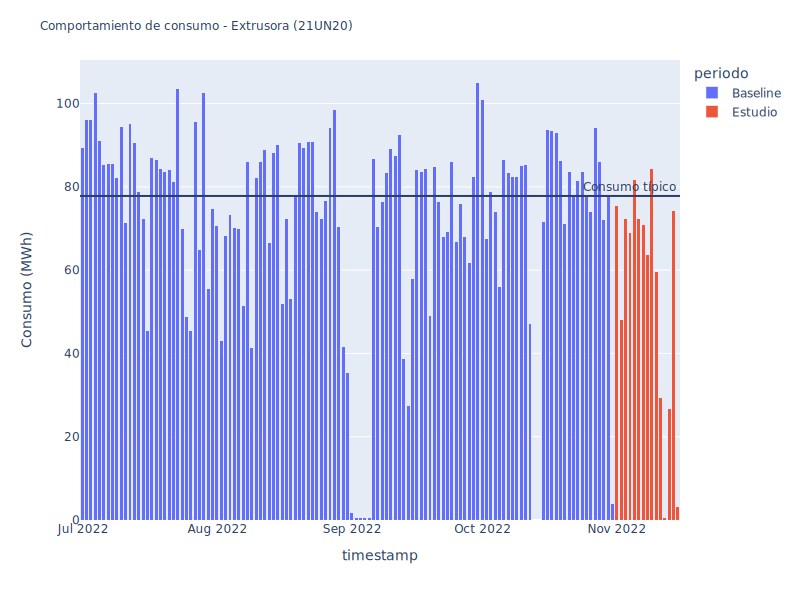

In [526]:
Ex_21UN20_diario = Ex_21UN20_complete.resample('D').sum().sort_values(by='timestamp', ascending=True).reset_index()
Ex_21UN20_diario.replace(0, np.nan, inplace=True)
Ex_21UN20_diario['periodo'] = np.where((Ex_21UN20_diario['timestamp'] >= datetime.strptime(periodo_historico[0], "%Y-%m-%d")) & (Ex_21UN20_diario['timestamp'] <= datetime.strptime(periodo_historico[1], "%Y-%m-%d")), 'Baseline', 'Estudio')


fig = px.bar(Ex_21UN20_diario, x="timestamp", y="Consumo (MWh)", color="periodo")

Ex_21UN20_diario_LB=Ex_21UN20_diario['Consumo (MWh)'].median()
fig.add_hline(y=Ex_21UN20_diario_LB, annotation_text=" Consumo típico")

fig.update_layout(barmode='stack', title='Comportamiento de consumo - Extrusora (21UN20)', width=800, height=600, colorway=['#fc7703', '#757371'],title_font_size=12)
fig.show()

In [527]:
Ex_21UN20_complete = pd.DataFrame()
Ex_21UN20_historico_complete = pd.DataFrame()

Tags_Ex_21UN20 = ['FIX.P2-FIC-210220.F_CV','FIX.P2-JI-212505.F_CV','FIX.P2-POWER-EXT-P2.F_CV','FIX.P2-TI-212102.F_CV','FIX.P2-TI-212103.F_CV','FIX.P2-TI-212104.F_CV','FIX.P2-TI-212105.F_CV','FIX.P2-TI-212106.F_CV','FIX.P2-TI-212107.F_CV','FIX.P2-TI-212108.F_CV','FIX.P2-TI-212109.F_CV','FIX.P2-TI-212110.F_CV','FIX.P2-TI-212111.F_CV','FIX.P2-TI-212202.F_CV', 'FIX.MES-P2-21UN20-RATA.F_CV','FIX.P2-FF-211003.F_CV']

Ex_21UN20_complete = data[Tags_Ex_21UN20].astype(float)
Ex_21UN20_historico_complete = historic_data.loc[historic_data['NAME'].isin(Tags_Ex_21UN20)].drop('datetime', axis=1)

Ex_21UN20_historico_complete = Ex_21UN20_historico_complete.pivot_table(index='datetime', columns='NAME', values='Active power', aggfunc='mean')

Ex_21UN20_complete = Ex_21UN20_complete[Ex_21UN20_complete['FIX.P2-FIC-210220.F_CV']>0]
Ex_21UN20_historico_complete = Ex_21UN20_historico_complete[Ex_21UN20_historico_complete['FIX.P2-FIC-210220.F_CV']>0]

Ex_21UN20_complete = Ex_21UN20_complete[Ex_21UN20_complete['FIX.P2-FIC-210220.F_CV'].between(Ex_21UN20_complete['FIX.P2-FIC-210220.F_CV'].quantile(.05),Ex_21UN20_complete['FIX.P2-FIC-210220.F_CV'].quantile(.95) )]
Ex_21UN20_complete = Ex_21UN20_complete[Ex_21UN20_complete['FIX.P2-POWER-EXT-P2.F_CV'].between(Ex_21UN20_complete['FIX.P2-POWER-EXT-P2.F_CV'].quantile(.05),Ex_21UN20_complete['FIX.P2-POWER-EXT-P2.F_CV'].quantile(.95) )]
Ex_21UN20_complete = Ex_21UN20_complete[Ex_21UN20_complete['FIX.P2-JI-212505.F_CV'].between(Ex_21UN20_complete['FIX.P2-JI-212505.F_CV'].quantile(.05),Ex_21UN20_complete['FIX.P2-JI-212505.F_CV'].quantile(.95) )]


Ex_21UN20_historico_complete = Ex_21UN20_historico_complete[Ex_21UN20_historico_complete['FIX.P2-FIC-210220.F_CV'].between(Ex_21UN20_historico_complete['FIX.P2-FIC-210220.F_CV'].quantile(.05),Ex_21UN20_historico_complete['FIX.P2-FIC-210220.F_CV'].quantile(.95) )]
Ex_21UN20_historico_complete = Ex_21UN20_historico_complete[Ex_21UN20_historico_complete['FIX.P2-POWER-EXT-P2.F_CV'].between(Ex_21UN20_historico_complete['FIX.P2-POWER-EXT-P2.F_CV'].quantile(.05),Ex_21UN20_historico_complete['FIX.P2-POWER-EXT-P2.F_CV'].quantile(.95) )]
Ex_21UN20_historico_complete = Ex_21UN20_historico_complete[Ex_21UN20_historico_complete['FIX.P2-JI-212505.F_CV'].between(Ex_21UN20_historico_complete['FIX.P2-JI-212505.F_CV'].quantile(.05),Ex_21UN20_historico_complete['FIX.P2-JI-212505.F_CV'].quantile(.95) )]

Ex_21UN20_complete.dropna(inplace=True)
Ex_21UN20_historico_complete.dropna(inplace=True)


# convert to kW
Ex_21UN20_complete['FIX.P2-JI-212505.F_CV'] = Ex_21UN20_complete['FIX.P2-JI-212505.F_CV']*1000
Ex_21UN20_complete['FIX.P2-FIC-210220.F_CV'] = Ex_21UN20_complete['FIX.P2-FIC-210220.F_CV']/1000

Ex_21UN20_historico_complete['FIX.P2-JI-212505.F_CV'] = Ex_21UN20_historico_complete['FIX.P2-JI-212505.F_CV']*1000
Ex_21UN20_historico_complete['FIX.P2-FIC-210220.F_CV'] = Ex_21UN20_historico_complete['FIX.P2-FIC-210220.F_CV']/1000



### Unit converted to kW/ton
Ex_21UN20_complete['KPI (MW KWh/kg)'] = (Ex_21UN20_complete['FIX.P2-JI-212505.F_CV']+ Ex_21UN20_complete['FIX.P2-POWER-EXT-P2.F_CV']) / Ex_21UN20_complete['FIX.P2-FIC-210220.F_CV']
Ex_21UN20_historico_complete['KPI (MW KWh/kg)'] = (Ex_21UN20_historico_complete['FIX.P2-JI-212505.F_CV']+ Ex_21UN20_historico_complete['FIX.P2-POWER-EXT-P2.F_CV']) / Ex_21UN20_historico_complete['FIX.P2-FIC-210220.F_CV']



Ex_21UN20_complete['timestamp'] = pd.to_datetime(Ex_21UN20_complete.index)
Ex_21UN20_historico_complete['timestamp'] = pd.to_datetime(Ex_21UN20_historico_complete.index)



Ex_21UN20_complete['periodo'] = np.where((Ex_21UN20_complete['timestamp'] > datetime.strptime(periodo_historico[0], "%Y-%m-%d")) & (Ex_21UN20_complete['timestamp'] <= datetime.strptime(periodo_historico[1], "%Y-%m-%d")), 'Baseline', 'Estudio')
Ex_21UN20_historico_complete['periodo'] = np.where((Ex_21UN20_historico_complete['timestamp'] > datetime.strptime(periodo_historico[0], "%Y-%m-%d")) & (Ex_21UN20_historico_complete['timestamp'] <= datetime.strptime(periodo_historico[1], "%Y-%m-%d")), 'Baseline', 'Estudio')



Ex_21UN20_complete_sp = Ex_21UN20_complete[Ex_21UN20_complete['periodo']=='Estudio']

Ex_21UN20_complete_bl = Ex_21UN20_complete[Ex_21UN20_complete['periodo']=='Baseline']

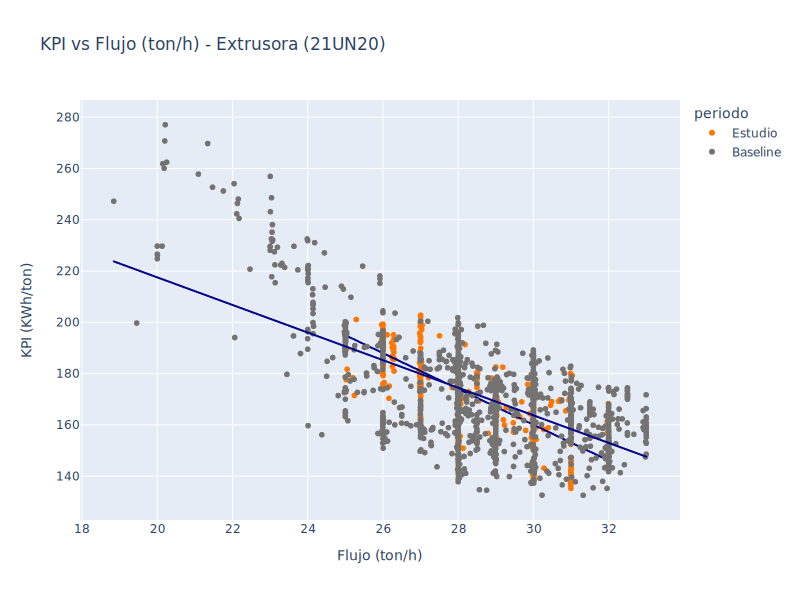

AIC Periodo de estudio 12964.290566145839
AIC Periodo Anterior 4856.514345848148
R^2 Periodo de estudio 0.44784308628883984
R^2 Periodo Anterior 0.5536841844057605
MSE Periodo de estudio 362.2916347759645
MSE Periodo Anterior 246.00837268441325


In [528]:
Ex_21UN20_complete_scatter = pd.concat([Ex_21UN20_complete_sp,Ex_21UN20_historico_complete], axis = 0)


fig = px.scatter(Ex_21UN20_complete_scatter, x=Ex_21UN20_complete_scatter['FIX.P2-FIC-210220.F_CV'], y=Ex_21UN20_complete_scatter['KPI (MW KWh/kg)'], color='periodo', trendline="ols", trendline_color_override="darkblue", title='KPI vs Flujo (ton/h) - Extrusora (21UN20)', width=800,
 height=600, color_discrete_map={'Baseline': '#757371', 'Estudio': '#fc7703'})

fig.update_layout(xaxis_title="Flujo (ton/h)", yaxis_title="KPI (KWh/ton)")
fig.show()

print('AIC Periodo de estudio',px.get_trendline_results(fig)['px_fit_results'][1].aic)
print('AIC Periodo Anterior',px.get_trendline_results(fig)['px_fit_results'][0].aic)


print('R^2 Periodo de estudio',px.get_trendline_results(fig)['px_fit_results'][1].rsquared)
print('R^2 Periodo Anterior',px.get_trendline_results(fig)['px_fit_results'][0].rsquared)

print('MSE Periodo de estudio',px.get_trendline_results(fig)['px_fit_results'][1].mse_total)
print('MSE Periodo Anterior',px.get_trendline_results(fig)['px_fit_results'][0].mse_total)

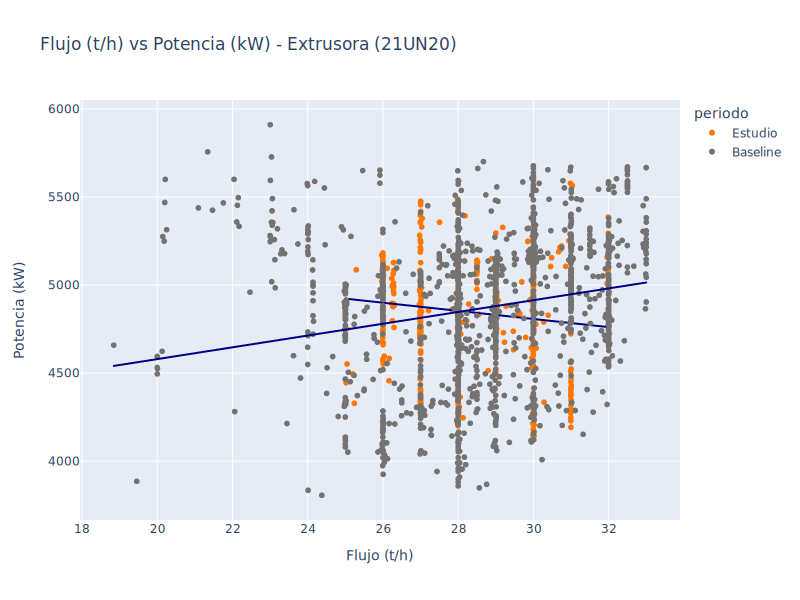

AIC Periodo de estudio 23377.901421768238
AIC Periodo Anterior 9149.875232837372
R^2 Periodo de estudio 0.043455031830124335
R^2 Periodo Anterior 0.017012991943859856
MSE Periodo de estudio 144359.2990967388
MSE Periodo Anterior 87772.71139999418


In [529]:
fig = px.scatter(Ex_21UN20_complete_scatter, y=Ex_21UN20_complete_scatter['FIX.P2-JI-212505.F_CV'] + Ex_21UN20_complete_scatter['FIX.P2-POWER-EXT-P2.F_CV'], x=Ex_21UN20_complete_scatter['FIX.P2-FIC-210220.F_CV'], color='periodo', trendline="ols", trendline_color_override="darkblue", title='Flujo (t/h) vs Potencia (kW) - Extrusora (21UN20)', width=800,
 height=600, color_discrete_map={'Baseline': '#757371', 'Estudio': '#fc7703'}, labels={'y':'Potencia (kW)', 'FIX.P2-FIC-210220.F_CV':'Flujo (t/h)'})
fig.show()

print('AIC Periodo de estudio',px.get_trendline_results(fig)['px_fit_results'][1].aic)
print('AIC Periodo Anterior',px.get_trendline_results(fig)['px_fit_results'][0].aic)


print('R^2 Periodo de estudio',px.get_trendline_results(fig)['px_fit_results'][1].rsquared)
print('R^2 Periodo Anterior',px.get_trendline_results(fig)['px_fit_results'][0].rsquared)

print('MSE Periodo de estudio',px.get_trendline_results(fig)['px_fit_results'][1].mse_total)
print('MSE Periodo Anterior',px.get_trendline_results(fig)['px_fit_results'][0].mse_total)

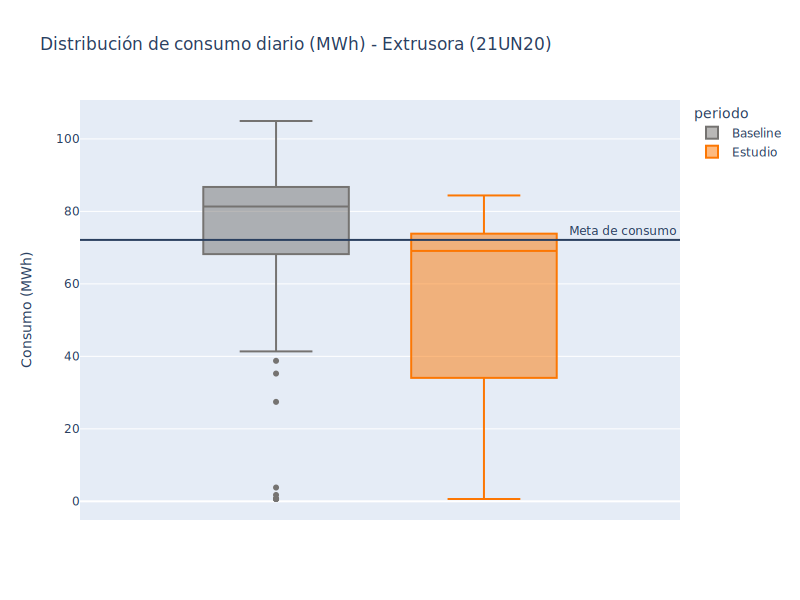

In [530]:


Ex_21UN20_LB = Ex_21UN20_diario.loc[(Ex_21UN20_diario['periodo']=="Baseline") & (Ex_21UN20_diario['Consumo (MWh)'].between(Ex_21UN20_diario['Consumo (MWh)'].quantile(.25),Ex_21UN20_diario['Consumo (MWh)'].quantile(.5)))]['Consumo (MWh)'].mean()

fig = px.box(Ex_21UN20_diario, y=Ex_21UN20_diario['Consumo (MWh)'] , color='periodo',  title='Distribución de consumo diario (MWh) - Extrusora (21UN20)', width=800,
 height=600, color_discrete_map={'Baseline': '#757371', 'Estudio': '#fc7703'}, labels={'y': 'Potencia (kW)'})
fig.add_hline(y=Ex_21UN20_LB, annotation_text=" Meta de consumo")
fig.show()

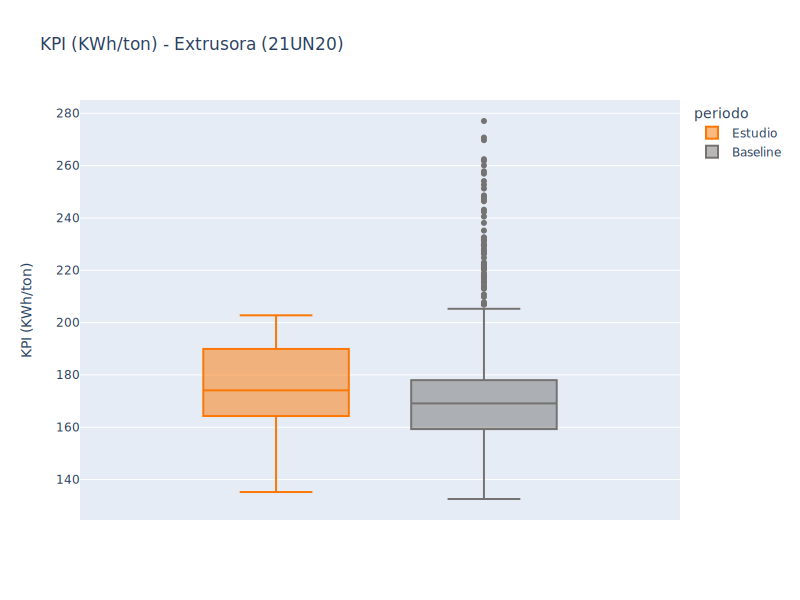

In [531]:
fig = px.box(Ex_21UN20_complete_scatter, y=Ex_21UN20_complete_scatter['KPI (MW KWh/kg)'], color='periodo',  title='KPI (KWh/ton) - Extrusora (21UN20)', width=800,
 height=600, color_discrete_map={'Baseline': '#757371', 'Estudio': '#fc7703'}, labels={'KPI (MW KWh/kg)':'KPI (KWh/ton)'})
fig.show()

R^2 medio 0.6550084422442873
Error cuadratico medio sobre el conjunto de Test: 26589.33 kW


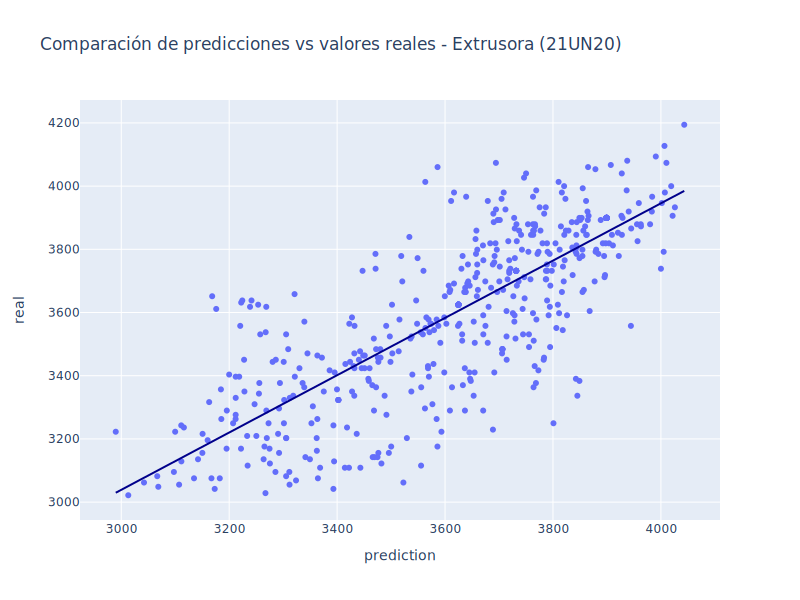

Peso
Temp Barril 6             776.12
Temp Barril 3             683.73
Temp Barril 4             606.36
Temp Barril 2             526.20
Melt Temp SUV             346.15
Temp Barril 7             279.90
Temp Barril 9             227.24
Rata extrusora P2 (F_CV)  146.50
Alimento de polvo (ROT)   146.49
Rata de Reproceso         143.18
Temp Barril 10             92.27
Temp Barril 11             -4.00
Temp Barril 8            -603.42
Temp Barril 5            -794.05

In [532]:
Feature_Tags_Ex_21UN20  = ['FIX.P2-FIC-210220.F_CV','FIX.P2-TI-212102.F_CV','FIX.P2-TI-212103.F_CV','FIX.P2-TI-212104.F_CV','FIX.P2-TI-212105.F_CV','FIX.P2-TI-212106.F_CV','FIX.P2-TI-212107.F_CV','FIX.P2-TI-212108.F_CV','FIX.P2-TI-212109.F_CV','FIX.P2-TI-212110.F_CV','FIX.P2-TI-212111.F_CV','FIX.P2-TI-212202.F_CV','FIX.MES-P2-21UN20-RATA.F_CV','FIX.P2-FF-211003.F_CV']


Feature_Names_Ex_21UN20 = ['Alimento de polvo (ROT)','Temp Barril 2','Temp Barril 3','Temp Barril 4','Temp Barril 5','Temp Barril 6','Temp Barril 7','Temp Barril 8','Temp Barril 9','Temp Barril 10','Temp Barril 11','Melt Temp SUV', 'Rata extrusora P2 (F_CV)','Rata de Reproceso']

Output_Tags_Ex_21UN20 = ['FIX.P2-POWER-EXT-P2.F_CV']


Ex_21UN20_complete_features = Ex_21UN20_complete[Feature_Tags_Ex_21UN20]

Ex_21UN20_complete_output = Ex_21UN20_complete[Output_Tags_Ex_21UN20]

from sklearn import svm
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split

scaler = MinMaxScaler()

X = scaler.fit_transform(Ex_21UN20_complete_features)
y = Ex_21UN20_complete_output.values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42)



SVR = svm.SVR(kernel='linear', C=1e3, gamma=0.1)
validation = cross_validate(SVR, X_train, y_train, cv=10, scoring='r2', return_estimator=True)
print('R^2 medio',validation['test_score'].mean())




best_estimator = validation['estimator'][np.argmax(validation['test_score'])]


prediction = best_estimator.predict(X_test)

comparison = pd.DataFrame([prediction, y_test.flatten()]).T
comparison.columns = ['prediction', 'real']

MSE = np.mean((prediction - y_test.flatten())**2)
print(f"Error cuadratico medio sobre el conjunto de Test: {MSE.round(2)} kW")

fig = px.scatter(comparison, x=comparison['prediction'], y=comparison['real'], trendline="ols", trendline_color_override="darkblue",
 title='Comparación de predicciones vs valores reales - Extrusora (21UN20)', width=800,
height=600)
fig.show()

coeficientes = pd.DataFrame(best_estimator.coef_.T, index=Feature_Names_Ex_21UN20, columns=['Peso'])
coeficientes.round(2).sort_values(by='Peso', ascending=False)

# print('Los coeficientes del modelo son: ', best_estimator.coef_)
# print('El intercepto del modelo es: ', best_estimator.intercept_)
# print('los nombres de las variables son: ', Feature_Names_Ex_21UN20)

### Ventiladores de descarga de aditivos sólidos (03DN10CM01)

In [533]:

Vent_03DN10CM01 = Esenttia[Esenttia['Máquina'] == 'Ventiladores de descarga de aditivos sólidos (03DN10CM01)']
Vent_03DN10CM01_historico = Esenttia_historico[Esenttia_historico['Máquina'] == 'Ventiladores de descarga de aditivos sólidos (03DN10CM01)']


mask_bl = (Vent_03DN10CM01_historico['timestamp'] > periodo_historico[0]) & (Vent_03DN10CM01_historico['timestamp'] <= periodo_historico[1])
Vent_03DN10CM01_bl = Vent_03DN10CM01_historico.loc[mask_bl]

mask_sp = (Vent_03DN10CM01['timestamp'] >= periodo_de_estudio[0]) & (Vent_03DN10CM01['timestamp'] <= periodo_de_estudio[1])
Vent_03DN10CM01_sp = Vent_03DN10CM01.loc[mask_sp]

Vent_03DN10CM01_sp.replace(0, np.nan, inplace=True)
Vent_03DN10CM01_bl.replace(0, np.nan, inplace=True)


Vent_03DN10CM01_complete = pd.concat([Vent_03DN10CM01_sp,Vent_03DN10CM01_bl], axis=0)


Vent_03DN10CM01_complete['periodo'] = np.where((Vent_03DN10CM01_complete['timestamp'] >= datetime.strptime(periodo_historico[0], "%Y-%m-%d")) & (Vent_03DN10CM01_complete['timestamp'] <= datetime.strptime(periodo_historico[1], "%Y-%m-%d")), 'Baseline', 'Estudio')

md(f"Durante el periodo de estudio, el consumo total fue de {Vent_03DN10CM01_sp['Consumo (MWh)'].sum().round(2)} MWh")
md(f"Durante el periodo de estudio, el consumo total fue de {Vent_03DN10CM01_sp['Consumo (MWh)'].sum().round(2)} MWh")

Durante el periodo de estudio, el consumo total fue de 0.0 MWh

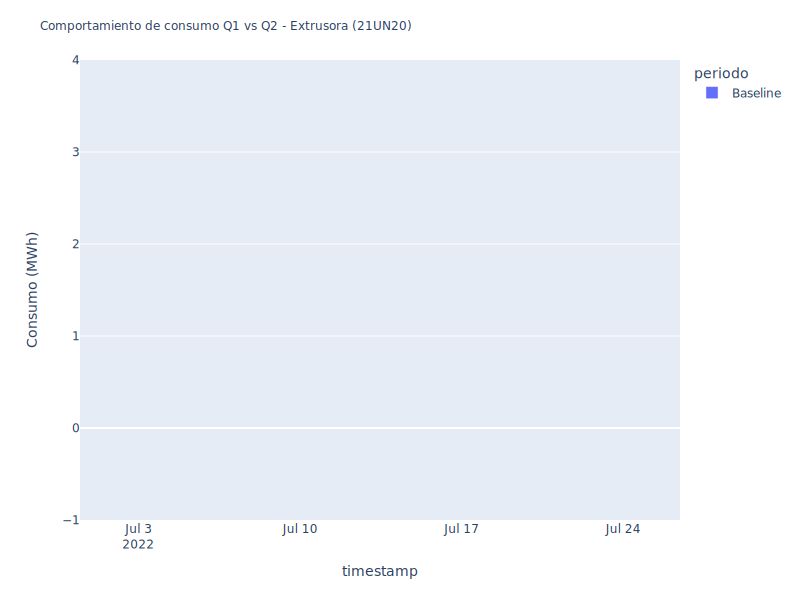

In [534]:
Vent_03DN10CM01_diario = Vent_03DN10CM01_complete.resample('D').sum().sort_values(by='timestamp', ascending=True).reset_index()
Vent_03DN10CM01_diario.replace(0, np.nan, inplace=True)
Vent_03DN10CM01_diario['periodo'] = np.where((Vent_03DN10CM01_diario['timestamp'] >= datetime.strptime(periodo_historico[0], "%Y-%m-%d")) & (Vent_03DN10CM01_diario['timestamp'] <= datetime.strptime(periodo_historico[1], "%Y-%m-%d")), 'Baseline', 'Estudio')


fig = px.bar(Vent_03DN10CM01_diario, x="timestamp", y="Consumo (MWh)", color="periodo")

fig.update_layout(barmode='stack', title='Comportamiento de consumo Q1 vs Q2 - Extrusora (21UN20)', width=800, height=600, colorway=['#fc7703', '#757371'],title_font_size=12)
fig.show()

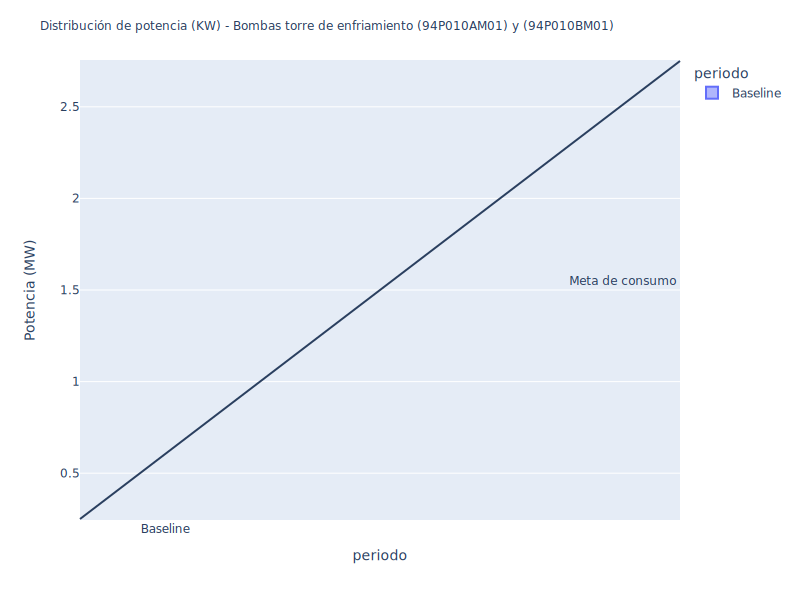

In [535]:

Vent_03DN10CM01_LB = Vent_03DN10CM01_complete.loc[(Vent_03DN10CM01_complete['periodo']=="Baseline") & (Vent_03DN10CM01_complete['Consumo (MWh)'].between(Vent_03DN10CM01_complete['Consumo (MWh)'].quantile(.3),Vent_03DN10CM01_complete['Consumo (MWh)'].quantile(.6)))]['Consumo (MWh)'].mean()

fig = px.box(Vent_03DN10CM01_complete, x="periodo", y="Consumo (MWh)", color="periodo")
fig.add_hline(y=Vent_03DN10CM01_LB, annotation_text=" Meta de consumo")
fig.update_layout( title='Distribución de potencia (KW) - Bombas torre de enfriamiento (94P010AM01) y (94P010BM01)', width=800, height=600, colorway=['#fc7703', '#757371'], yaxis_title="Potencia (MW)", title_font_size=12)
fig.show()

### Compresor (20K060)

In [536]:

Comp_20K060 = Esenttia[Esenttia['Máquina'] == 'Compresor (20K060)']
Comp_20K060_historico = Esenttia_historico[Esenttia_historico['Máquina'] == 'Compresor (20K060)']


mask_bl = (Comp_20K060_historico['timestamp'] > periodo_historico[0]) & (Comp_20K060_historico['timestamp'] <= periodo_historico[1])
Comp_20K060_bl = Comp_20K060_historico.loc[mask_bl]

mask_sp = (Comp_20K060['timestamp'] >= periodo_de_estudio[0]) & (Comp_20K060['timestamp'] <= periodo_de_estudio[1])
Comp_20K060_sp = Comp_20K060.loc[mask_sp]

Comp_20K060_sp.replace(0, np.nan, inplace=True)
Comp_20K060_bl.replace(0, np.nan, inplace=True)


Comp_20K060_complete = pd.concat([Comp_20K060_sp,Comp_20K060_bl], axis=0)


Comp_20K060_complete['periodo'] = np.where((Comp_20K060_complete['timestamp'] >= datetime.strptime(periodo_historico[0], "%Y-%m-%d")) & (Comp_20K060_complete['timestamp'] <= datetime.strptime(periodo_historico[1], "%Y-%m-%d")), 'Baseline', 'Estudio')

md(f"Durante el periodo de estudio, el consumo total fue de {Comp_20K060_sp['Consumo (MWh)'].sum().round(2)} MWh")
md(f"Durante el periodo de estudio, el consumo total fue de {Comp_20K060_sp['Consumo (MWh)'].sum().round(2)} MWh")

Durante el periodo de estudio, el consumo total fue de 184.95 MWh

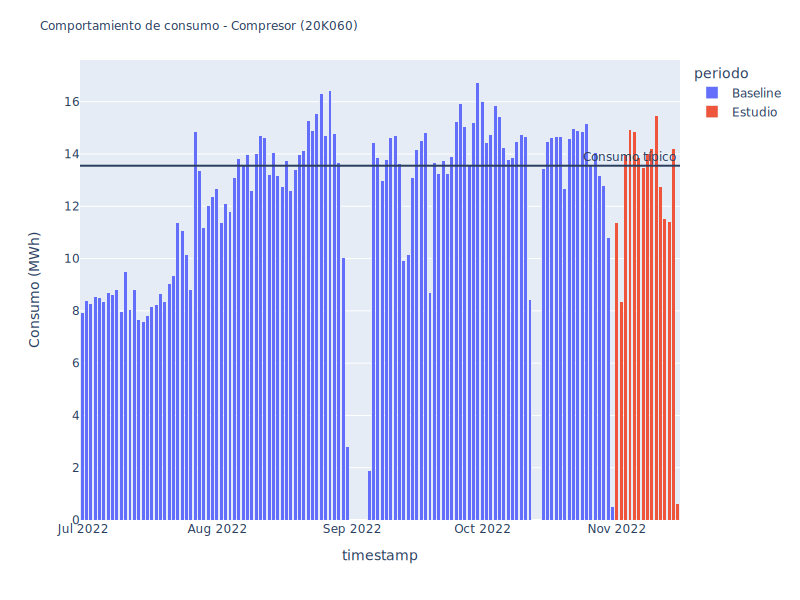

In [537]:
Comp_20K060_diario = Comp_20K060_complete.resample('D').sum().sort_values(by='timestamp', ascending=True).reset_index()
Comp_20K060_diario.replace(0, np.nan, inplace=True)
Comp_20K060_diario['periodo'] = np.where((Comp_20K060_diario['timestamp'] >= datetime.strptime(periodo_historico[0], "%Y-%m-%d")) & (Comp_20K060_diario['timestamp'] <= datetime.strptime(periodo_historico[1], "%Y-%m-%d")), 'Baseline', 'Estudio')


fig = px.bar(Comp_20K060_diario, x="timestamp", y="Consumo (MWh)", color="periodo")

Comp_20K060_diario_LB=Comp_20K060_diario['Consumo (MWh)'].median()
fig.add_hline(y=Comp_20K060_diario_LB, annotation_text=" Consumo típico")

fig.update_layout(barmode='stack', title='Comportamiento de consumo - Compresor (20K060)', width=800, height=600, colorway=['#fc7703', '#757371'],title_font_size=12)
fig.show()

In [538]:

Comp_20K060_complete = pd.DataFrame()
Comp_20K060_historico_complete = pd.DataFrame()

Tags_Comp_20K060  = ['FIX.P2-20K060-M01-POWER.F_CV','FIX.P2-FI-201050.F_CV','FIX.P2-PIC-201000-PV.F_CV','FIX.P2-PIC-201005-PV.F_CV','FIX.P2-TI-201000.F_CV','FIX.P2-TI-205002.F_CV','FIX.P2-TI-205012.F_CV','FIX.P2-TI-205013.F_CV','FIX.P2-TI-205023.F_CV','FIX.P2-TIC-205022-PV.F_CV']

Comp_20K060_complete = data[Tags_Comp_20K060].astype(float)
Comp_20K060_historico_complete = historic_data.loc[historic_data['NAME'].isin(Tags_Comp_20K060)].drop('datetime', axis=1)

Comp_20K060_historico_complete = Comp_20K060_historico_complete.pivot_table(index='datetime', columns='NAME', values='Active power', aggfunc='mean')

Comp_20K060_complete['KPI (MW KWh/kg)'] = Comp_20K060_complete['FIX.P2-20K060-M01-POWER.F_CV'] / Comp_20K060_complete['FIX.P2-FI-201050.F_CV']
Comp_20K060_historico_complete['KPI (MW KWh/kg)'] = Comp_20K060_historico_complete['FIX.P2-20K060-M01-POWER.F_CV'] / Comp_20K060_historico_complete['FIX.P2-FI-201050.F_CV']


Comp_20K060_complete = Comp_20K060_complete[Comp_20K060_complete['KPI (MW KWh/kg)'].between(Comp_20K060_complete['KPI (MW KWh/kg)'].quantile(.05),Comp_20K060_complete['KPI (MW KWh/kg)'].quantile(.95) ) ]
Comp_20K060_historico_complete = Comp_20K060_historico_complete[Comp_20K060_historico_complete['KPI (MW KWh/kg)'].between(Comp_20K060_historico_complete['KPI (MW KWh/kg)'].quantile(.05),Comp_20K060_historico_complete['KPI (MW KWh/kg)'].quantile(.95) ) ]

Comp_20K060_complete['timestamp'] = pd.to_datetime(Comp_20K060_complete.index)
Comp_20K060_historico_complete['timestamp'] = pd.to_datetime(Comp_20K060_historico_complete.index)



Comp_20K060_complete['periodo'] = np.where((Comp_20K060_complete['timestamp'] > datetime.strptime(periodo_historico[0], "%Y-%m-%d")) & (Comp_20K060_complete['timestamp'] <= datetime.strptime(periodo_historico[1], "%Y-%m-%d")), 'Baseline', 'Estudio')
Comp_20K060_historico_complete['periodo'] = np.where((Comp_20K060_historico_complete['timestamp'] > datetime.strptime(periodo_historico[0], "%Y-%m-%d")) & (Comp_20K060_historico_complete['timestamp'] <= datetime.strptime(periodo_historico[1], "%Y-%m-%d")), 'Baseline', 'Estudio')



Comp_20K060_complete_sp = Comp_20K060_complete[Comp_20K060_complete['periodo']=='Estudio']

Comp_20K060_complete_bl = Comp_20K060_complete[Comp_20K060_complete['periodo']=='Baseline']

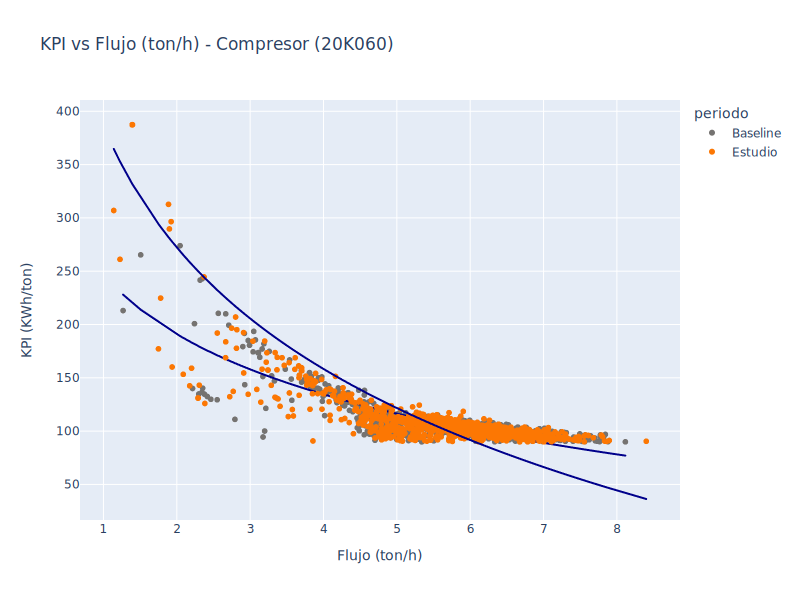

AIC Periodo de estudio 12467.009853762642
AIC Periodo Anterior 10404.717912702254
R^2 Periodo de estudio 0.8360327491965189
R^2 Periodo Anterior 0.7614826727777505
MSE Periodo de estudio 4911.1887947319665
MSE Periodo Anterior 402.9427339419408


In [539]:
Comp_20K060_complete_scatter = pd.concat([Comp_20K060_complete_sp,Comp_20K060_historico_complete], axis = 0)


fig = px.scatter(Comp_20K060_complete, x=Comp_20K060_complete['FIX.P2-FI-201050.F_CV'], y=Comp_20K060_complete['KPI (MW KWh/kg)'], color='periodo', trendline="ols", trendline_options=dict(log_x=True), trendline_color_override="darkblue", title='KPI vs Flujo (ton/h) - Compresor (20K060)', width=800,
 height=600, color_discrete_map={'Baseline': '#757371', 'Estudio': '#fc7703'}, labels={'FIX.P2-FI-201050.F_CV': 'Flujo (ton/h)', 'KPI (MW KWh/kg)': 'KPI (KWh/ton)'})
fig.show()

print('AIC Periodo de estudio',px.get_trendline_results(fig)['px_fit_results'][1].aic)
print('AIC Periodo Anterior',px.get_trendline_results(fig)['px_fit_results'][0].aic)


print('R^2 Periodo de estudio',px.get_trendline_results(fig)['px_fit_results'][1].rsquared)
print('R^2 Periodo Anterior',px.get_trendline_results(fig)['px_fit_results'][0].rsquared)

print('MSE Periodo de estudio',px.get_trendline_results(fig)['px_fit_results'][1].mse_total)
print('MSE Periodo Anterior',px.get_trendline_results(fig)['px_fit_results'][0].mse_total)

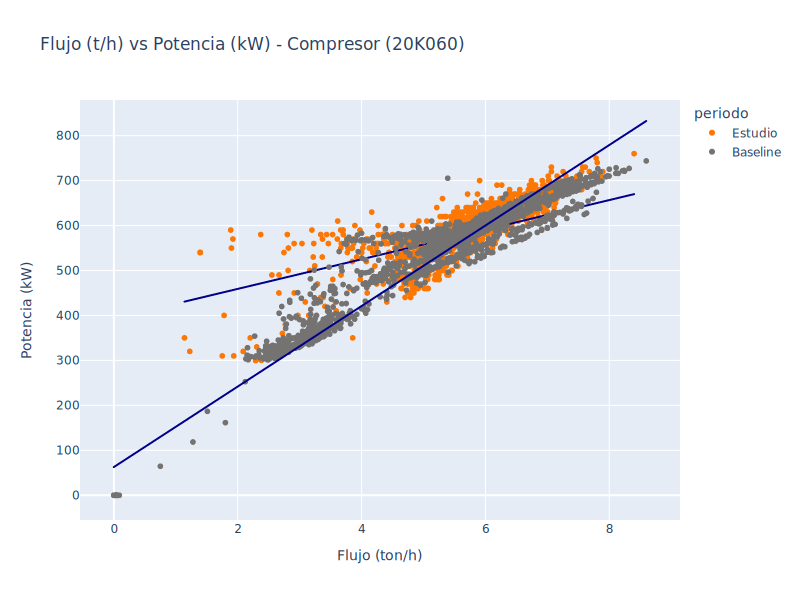

AIC Periodo de estudio 24055.149734926268
AIC Periodo Anterior 14442.197239755134
R^2 Periodo de estudio 0.9465723974749459
R^2 Periodo Anterior 0.36633935308407517
MSE Periodo de estudio 30135.491596074076
MSE Periodo Anterior 5753.171642227573


In [540]:
fig = px.scatter(Comp_20K060_complete_scatter, x=Comp_20K060_complete_scatter['FIX.P2-FI-201050.F_CV'], y=Comp_20K060_complete_scatter['FIX.P2-20K060-M01-POWER.F_CV'], color='periodo', trendline="ols", trendline_color_override="darkblue", title='Flujo (t/h) vs Potencia (kW) - Compresor (20K060)', width=800, height=600, color_discrete_map={'Baseline': '#757371', 'Estudio': '#fc7703'}, labels={'FIX.P2-FI-201050.F_CV': 'Flujo (ton/h)', 'FIX.P2-20K060-M01-POWER.F_CV': 'Potencia (kW)'})
fig.show()

print('AIC Periodo de estudio',px.get_trendline_results(fig)['px_fit_results'][1].aic)
print('AIC Periodo Anterior',px.get_trendline_results(fig)['px_fit_results'][0].aic)


print('R^2 Periodo de estudio',px.get_trendline_results(fig)['px_fit_results'][1].rsquared)
print('R^2 Periodo Anterior',px.get_trendline_results(fig)['px_fit_results'][0].rsquared)

print('MSE Periodo de estudio',px.get_trendline_results(fig)['px_fit_results'][1].mse_total)
print('MSE Periodo Anterior',px.get_trendline_results(fig)['px_fit_results'][0].mse_total)

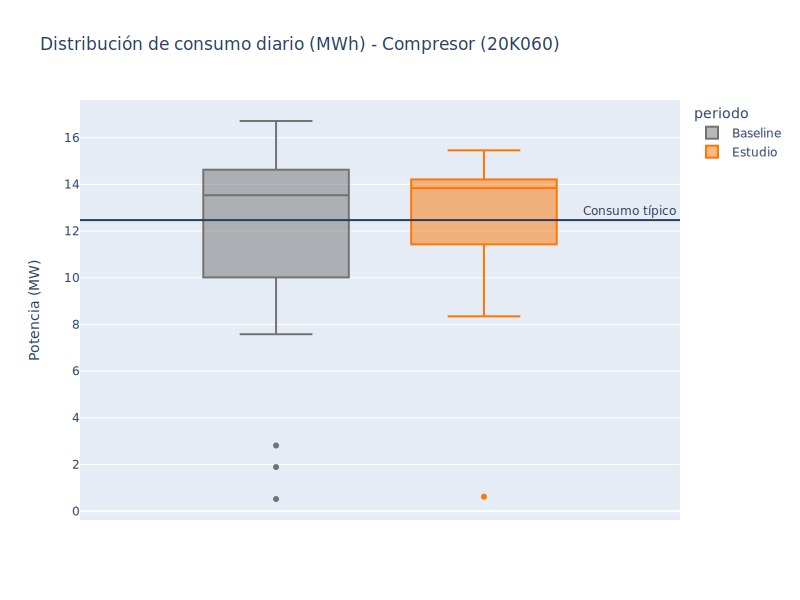

In [541]:

Comp_20K060_LB = Comp_20K060_diario.loc[(Comp_20K060_diario['periodo']=="Baseline") & (Comp_20K060_diario['Consumo (MWh)'].between(Comp_20K060_diario['Consumo (MWh)'].quantile(.25),Comp_20K060_diario['Consumo (MWh)'].quantile(.5)))]['Consumo (MWh)'].mean()


fig = px.box(Comp_20K060_diario, y=Comp_20K060_diario['Consumo (MWh)'], color='periodo',  title='Distribución de consumo diario (MWh) - Compresor (20K060)', width=800,
 height=600, color_discrete_map={'Baseline': '#757371', 'Estudio': '#fc7703'}, labels={'Consumo (MWh)': 'Potencia (MW)'})
fig.add_hline(y=Comp_20K060_LB, annotation_text=" Consumo típico")
fig.show()

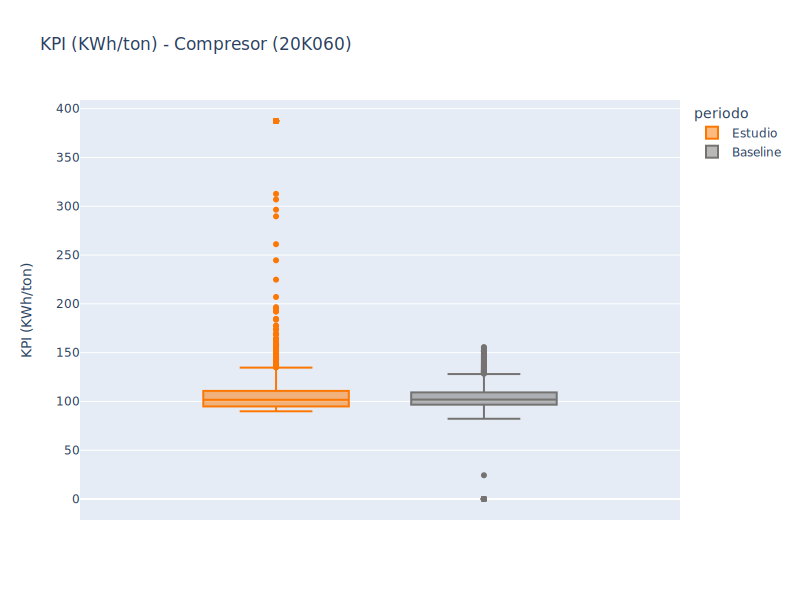

In [542]:
fig = px.box(Comp_20K060_complete_scatter, y=Comp_20K060_complete_scatter['KPI (MW KWh/kg)'], color='periodo',  title='KPI (KWh/ton) - Compresor (20K060)', width=800,
 height=600, color_discrete_map={'Baseline': '#757371', 'Estudio': '#fc7703'}, labels={'KPI (MW KWh/kg)': 'KPI (KWh/ton)'})
fig.show()

In [543]:
# Feature_Tags_Comp_20K060  = ['FIX.P2-FI-201050.F_CV','FIX.P2-PIC-201000-PV.F_CV','FIX.P2-PIC-201005-PV.F_CV','FIX.P2-TI-201000.F_CV','FIX.P2-TI-205002.F_CV','FIX.P2-TI-205012.F_CV','FIX.P2-TI-205013.F_CV','FIX.P2-TI-205023.F_CV','FIX.P2-TIC-205022-PV.F_CV']


# Feature_Names_Comp_20K060 = ['Carrier Flow from 20K060 (F_CV)','Press. Carrier Gas from 20E060 (F_CV) etapa 1','Pressure N2 from 20K050-E1 (F_CV) etapa 3','Carrier Temperature from 20E060 (F_CV) etapa 1','Temperature Gas to 20K060D01 (F_CV) etapa 1','Temperature Gas from 20K060S02 (F_CV) etapa 2','Temperature Gas to 20K060S02 (F_CV) etapa 2','Temperature Gas to 20K060D03 (F_CV) etapa 3','Temperature Gas from 20K060S03 (F_CV) etapa 3']

# Output_Tags_Comp_20K060 = ['FIX.P2-20K060-M01-POWER.F_CV']


# Comp_20K060_complete_features = Comp_20K060_complete[Feature_Tags_Comp_20K060]

# Comp_20K060_complete_output = Comp_20K060_complete[Output_Tags_Comp_20K060]

# from sklearn import svm
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.model_selection import cross_validate
# from sklearn.metrics import make_scorer
# from sklearn.model_selection import train_test_split

# scaler = MinMaxScaler()

# X = scaler.fit_transform(Comp_20K060_complete_features)
# y = Comp_20K060_complete_output.values

# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.30, random_state=42)



# SVR = svm.SVR(kernel='linear', C=1e3, gamma=0.1)
# validation = cross_validate(SVR, X_train, y_train, cv=10, scoring='r2', return_estimator=True)
# print('R^2 medio',validation['test_score'].mean())




# best_estimator = validation['estimator'][np.argmax(validation['test_score'])]


# prediction = best_estimator.predict(X_test)

# comparison = pd.DataFrame([prediction, y_test.flatten()]).T
# comparison.columns = ['prediction', 'real']

# MSE = np.mean((prediction - y_test.flatten())**2)
# print(f"Error cuadratico medio sobre el conjunto de Test: {MSE.round(2)} kW")

# fig = px.scatter(comparison, x=comparison['prediction'], y=comparison['real'], trendline="ols", trendline_color_override="darkblue",
#  title='Comparación de predicciones vs valores reales - Compresor (20K060)', width=1200,
# height=600)
# fig.show()

# print('Los coeficientes del modelo son: ', best_estimator.coef_)
# print('El intercepto del modelo es: ', best_estimator.intercept_)
# print('los nombres de las variables son: ', Feature_Names_Comp_20K060)

### Bomba de propileno (01P010AM01)

In [544]:


bomb_01P010AM01 = Esenttia[Esenttia['Máquina'] == 'Bomba de propileno (01P010AM01)']
bomb_01P010AM01_historico = Esenttia_historico[Esenttia_historico['Máquina'] == 'Bomba de propileno (01P010AM01)']


mask_bl = (bomb_01P010AM01_historico['timestamp'] > periodo_historico[0]) & (bomb_01P010AM01_historico['timestamp'] <= periodo_historico[1])
bomb_01P010AM01_bl = bomb_01P010AM01_historico.loc[mask_bl]

mask_sp = (bomb_01P010AM01['timestamp'] >= periodo_de_estudio[0]) & (bomb_01P010AM01['timestamp'] <= periodo_de_estudio[1])
bomb_01P010AM01_sp = bomb_01P010AM01.loc[mask_sp]

bomb_01P010AM01_sp.replace(0, np.nan, inplace=True)
bomb_01P010AM01_bl.replace(0, np.nan, inplace=True)


bomb_01P010AM01_complete = pd.concat([bomb_01P010AM01_sp,bomb_01P010AM01_bl], axis=0)


bomb_01P010AM01_complete['periodo'] = np.where((bomb_01P010AM01_complete['timestamp'] >= datetime.strptime(periodo_historico[0], "%Y-%m-%d")) & (bomb_01P010AM01_complete['timestamp'] <= datetime.strptime(periodo_historico[1], "%Y-%m-%d")), 'Baseline', 'Estudio')

md(f"Durante el periodo de estudio, el consumo total fue de {bomb_01P010AM01_sp['Consumo (MWh)'].sum().round(2)} MWh")
md(f"Durante el periodo de estudio, el consumo total fue de {bomb_01P010AM01_sp['Consumo (MWh)'].sum().round(2)} MWh")

Durante el periodo de estudio, el consumo total fue de 0.0 MWh

In [545]:
md(f"El consumo por día para la Bomba de propileno (01P010AM01) puede ser observado en la siguiente gráfica:")

El consumo por día para la Bomba de propileno (01P010AM01) puede ser observado en la siguiente gráfica:

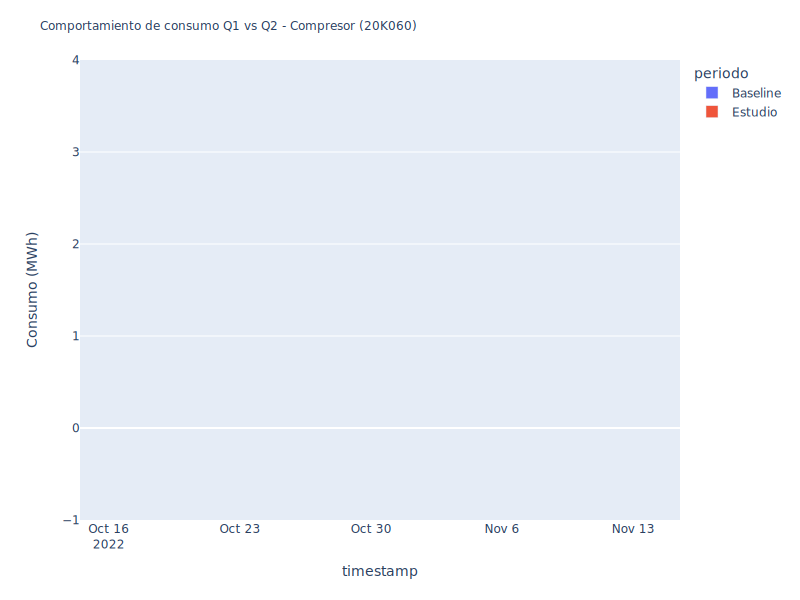

In [546]:
bomb_01P010AM01_diario = bomb_01P010AM01_complete.resample('D').sum().sort_values(by='timestamp', ascending=True).reset_index()
bomb_01P010AM01_diario.replace(0, np.nan, inplace=True)
bomb_01P010AM01_diario['periodo'] = np.where((bomb_01P010AM01_diario['timestamp'] >= datetime.strptime(periodo_historico[0], "%Y-%m-%d")) & (bomb_01P010AM01_diario['timestamp'] <= datetime.strptime(periodo_historico[1], "%Y-%m-%d")), 'Baseline', 'Estudio')


fig = px.bar(bomb_01P010AM01_diario, x="timestamp", y="Consumo (MWh)", color="periodo")

fig.update_layout(barmode='stack', title='Comportamiento de consumo Q1 vs Q2 - Compresor (20K060)', width=800, height=600, colorway=['#fc7703', '#757371'],title_font_size=12)
fig.show()

# Comentarios Equipo CELSIA

Comentarios Informe Esenttia Q2 Octubre

Para Q2 de octubre 17 días de análisis 15 al 31 de octubre de 2022

Para Q2 de octubre 408 horas operativas posibles

**Comentario para las gráficas de consumo general de cada planta y la consolidada:**

Es muy importante comparar el consumo de la planta que se está analizando con la producción respectiva (al menos con resolución diaria). Esto es muy útil para sacar la eficiencia de la producción - indicador de intensidad energética (kWh/producción). De aquí también podemos entregarles una métrica muy valiosa que es la huella de carbono (por energía) del producto (TonCO2/producción). Idealmente para las bombas es clave comparar con el flujo (caudal) o con la energía hidráulica (presión de descarga y presión de succión) entregada para sacar indicadores de eficiencia reales.

Se solicita datos de placa e información de selección de las bombas (punto de trabajo esperado)

**Comentario para:**

- La bomba de propileno área 20 (G-0216)

- Bomba de Circulación de Agua de Torre 2 (G-0402)

Observamos que las variaciones en la demanda de energía de este equipo siguen las variaciones en la demanda de energía de la planta 1, lo que permite inferir que este equipo tiene algún sistema de control y medición que actúa de acuerdo con ajustes en la producción. Este es un buen síntoma, aunque se debe profundizar más en el conocimiento de este equipo para concluir si hay o no oportunidades de optimización.

**Comentario para las bombas/circuitos:**

- Bomba calentador propileno (G-0230) & bomba calentador propileno (G-0232)

- Bomba de Cargue de Propileno (G-2013) & Bomba de Circulación de Agua del E-4002 (G-4004)

- Bomba de Circulación de Agua de Torre N°5 (G-0405)

- Bombas torre de enfriamiento (94P010CM01) y (94P010DM01)

- Bombas torre de enfriamiento (94P010AM01) y (94P010BM01)

Las variaciones en la demanda de energía diaria de este circuito son notablemente diferentes a lo observado en el consumo general de la planta correspondiente. Se requiere conocer algunos detalles de la operación de los equipos asociados a este circuito (por ejemplo: ¿existe alguna/s variable/s de proceso que deba controlar el equipo? ¿el equipo cuenta con variador de velocidad o actuadores que tomen acciones de acuerdo con la variación en la variable a controlar?) para concluir si hay una oportunidad de optimización implementando un sistema de control.

**Comentario para las bombas/circuitos:**

· Bomba de Circulación de Agua de Torre 4 (G-0404)

· Bombas de Agua Tratada (G-0446) y (G-0447)

Se tienen pocos datos para realizar un análisis del comportamiento de este equipo